### Index

1. [Imports](#Imports)
2. [ResNet 50](#ResNet-50)
    - [Optuna Optimization](#Optuna-optimization)
    - [Optuna Optimization - Intensive search for the best optimizer](#Intensive-search-for-the-Best-Optimizer)
3. [Train ResNet50 (best hyperparameters)](#Train-ResNet50-with-the-hyperparameters-found)

### Imports

In [1]:
# 1. Operating System, File Management, and Utilities
import os
import glob
import json
import csv
import gc
import pickle
import random
import re
import xml.etree.ElementTree as ET

# 2. Scientific Computing and Data Processing
import numpy as np
import pandas as pd

# 3. Image Processing and Visualization
import cv2
import pydicom
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sns

# 4. PyTorch - Deep Learning Framework
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts, CyclicLR

# 5. Machine Learning Utilities - Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

# 6. External Tools, Libraries, and Frameworks
from ultralytics import YOLO
import albumentations as A
import optuna
import supervision as sv

# 7. Custom Utility Scripts and Tools
from VisualizationTools.get_data_from_XML import XML_preprocessor, get_category
from VisualizationTools.get_gt import get_gt
from VisualizationTools.getUID import getUID_path
from VisualizationTools.utils import loadFileInformation

# 8. Progress Bar and Visualization Settings
from tqdm import tqdm
%matplotlib inline  

/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Seting seed (for reproducibility)

In [2]:
def set_seed(seed=42):
    """Ensure reproducibility by setting the seed across all libraries and enforcing deterministic behavior."""
    import os
    import random
    import numpy as np
    import torch
    
    # Python random seed
    random.seed(seed)
    
    # Numpy random seed
    np.random.seed(seed)
    
    # PyTorch random seeds
    torch.manual_seed(seed)
    
    # Set environmental variables for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed)
    #os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # CUDA determinism
    #torch.use_deterministic_algorithms(True, warn_only=True)  # Warn for non-deterministic ops

# Example usage
set_seed(42)

### ResNet 50

In [3]:
def extract_patient_id(filename):
    name = os.path.splitext(filename)[0]
    match = re.match(r'^([ABEG]\d{3,4})_', name)
    if match:
        return match.group(1)
    match = re.match(r'^[EG]_(LUNG\d+-\d+)_', name)
    if match:
        return match.group(1)
    return None

In [4]:
# Dataset para classificação multi-target
class LungCancerMultiTargetDataset(Dataset):
    def __init__(self, file_paths, df, transform=None):
        self.file_paths = file_paths
        self.transform = transform

        self.df = df.set_index('PatientID')  # Assume que PatientID é única

        self.valid_paths = []
        self.image_patient_map = {}

        for path in self.file_paths:
            filename = os.path.basename(path)
            patient_id = extract_patient_id(filename)
            if patient_id and patient_id in self.df.index:
                self.valid_paths.append(path)
                self.image_patient_map[path] = patient_id

    def __len__(self):
        return len(self.valid_paths)

    def __getitem__(self, idx):
        file_path = self.valid_paths[idx]
        image = Image.open(file_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        patient_id = self.image_patient_map[file_path]
        row = self.df.loc[patient_id]

        t = int(float(row['T-Stage']))
        n = int(float(row['N-Stage']))
        m = int(float(row['M-Stage']))

        targets = {
            'T': torch.tensor(t, dtype=torch.long),
            'N': torch.tensor(n, dtype=torch.long),
            'M': torch.tensor(m, dtype=torch.long)
        }

        # Metadados numéricos
        gender = row['gender']
        age = row['age']
        weight = row['weight (kg)']
        smoking = row['Smoking History']
        cancer = row['Histology']

        metadata = torch.tensor([gender, age, weight, smoking, cancer], dtype=torch.float)

        return image, metadata, targets


# Dataset e Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Carregar dataframe com colunas: PatientID, T-Stage, N-Stage, M-Stage
df_targets = pd.read_csv("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/TMN_LUNGPETDX_NSCLC_finaldataset.csv")

train_files = glob.glob("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/Dataset TMN/train/images/*.jpg")
val_files = glob.glob("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/Dataset TMN/val/images/*.jpg")

train_dataset = LungCancerMultiTargetDataset(train_files, df=df_targets, transform=transform)
val_dataset = LungCancerMultiTargetDataset(val_files, df=df_targets, transform=transform)


def seed_worker(worker_id):
        np.random.seed(42)
        random.seed(42)
        
def create_dataloader(dataset, batch_size, num_workers=0, worker_init_fn=seed_worker):
    generator = torch.Generator()
    generator.manual_seed(42)  # Seed the generator
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        generator=generator,
        worker_init_fn=seed_worker
    )

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights
import torch.nn.functional as F
import os
import json
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
from tqdm import tqdm
import optuna

# === MODELO MODULAR COM ARQUITETURA DINÂMICA === #
class MultiModalResNet(nn.Module):
    def __init__(
        self,
        num_classes_T,
        num_classes_N,
        num_classes_M,
        metadata_dim=4,
        dropout_rate=0.5,
        dropout_rate_RN50=0.3,
        trainable_layers=2,
        hidden_units=128,
        num_fc_layers=2
    ):
        super(MultiModalResNet, self).__init__()

        base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])
        self.cnn_out_dim = base_model.fc.in_features
        self.resnet_dropout = nn.Dropout(dropout_rate_RN50)

        for param in self.backbone.parameters():
            param.requires_grad = False

        resnet_blocks = ['layer1', 'layer2', 'layer3', 'layer4']
        selected_blocks = resnet_blocks[-trainable_layers:]
        for name, module in base_model.named_children():
            if name in selected_blocks:
                for param in module.parameters():
                    param.requires_grad = True

        self.metadata_net = nn.Sequential(
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),
            nn.Linear(64, hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        combined_layers = []
        input_dim = self.cnn_out_dim + hidden_units
        for _ in range(num_fc_layers):
            combined_layers.append(nn.Linear(input_dim, hidden_units))
            combined_layers.append(nn.ReLU())
            combined_layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_units
        self.combined_fc = nn.Sequential(*combined_layers)

        self.head_T = nn.Linear(hidden_units, num_classes_T)
        self.head_N = nn.Linear(hidden_units, num_classes_N)
        self.head_M = nn.Linear(hidden_units, num_classes_M)

    def forward(self, image, metadata):
        x_img = self.backbone(image).view(image.size(0), -1)
        x_img = self.resnet_dropout(x_img)
        x_meta = self.metadata_net(metadata)
        x = torch.cat((x_img, x_meta), dim=1)
        x = self.combined_fc(x)
        return {'T': self.head_T(x), 'N': self.head_N(x), 'M': self.head_M(x)}

### Optuna optimization 

Optuna to search for the best hyperparameters for ResNet-50

In [6]:
def compute_class_weights_tensor(labels, expected_num_classes, device):
    unique_classes = np.unique(labels)
    weights_present = compute_class_weight(class_weight='balanced', classes=unique_classes, y=labels)
    full_weights = np.zeros(expected_num_classes, dtype=np.float32)
    
    for idx, cls in enumerate(unique_classes):
        full_weights[int(cls)] = weights_present[idx]

    return torch.tensor(full_weights, dtype=torch.float).to(device)

In [7]:
# Directory to store results
RESULTS_DIR = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/TMN/trial_results_40epochs_whigherdropout_+"
os.makedirs(RESULTS_DIR, exist_ok=True)


def save_cm_and_report(y_true, y_pred, labels, target_name, trial_number, results_dir):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    report = classification_report(y_true, y_pred, labels=labels, output_dict=True)

    report_path = os.path.join(results_dir, f"trial_{trial_number + 1}_{target_name}_report.json")
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=4)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {target_name}")
    cm_path = os.path.join(results_dir, f"trial_{trial_number + 1}_{target_name}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()

    return report, cm

# === OBJETIVO PARA OPTUNA COM MELHORIAS === #
def objective(trial):
    gc.collect()
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    learning_rate = trial.suggest_float('learning_rate', 1e-6, 5e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-1, log=True)
    trainable_layers = trial.suggest_int('trainable_layers', 1, 4)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.9)
    dropout_rate_RN50 = trial.suggest_float('dropout_rate_RN50', 0.1, 0.5)
    optimizer_choice = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    scheduler_type = trial.suggest_categorical('scheduler', ['StepLR', 'CosineAnnealingLR', 'ReduceLROnPlateau', 'OneCycleLR'])
    label_smoothing = trial.suggest_float('label_smoothing', 0.1, 0.3)
    hidden_units = trial.suggest_categorical('hidden_units', [64, 128, 256])
    num_fc_layers = trial.suggest_int('num_fc_layers', 1, 3)

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

    model = MultiModalResNet(
        num_classes_T=4, num_classes_N=4, num_classes_M=2,
        metadata_dim=5,
        dropout_rate=dropout_rate,
        dropout_rate_RN50=dropout_rate_RN50,
        trainable_layers=trainable_layers,
        hidden_units=hidden_units,
        num_fc_layers=num_fc_layers
    ).to(device)

    # Otimizador
    if optimizer_choice == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        momentum = trial.suggest_float('momentum', 0.7, 0.99)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loader = create_dataloader(train_dataset, batch_size)
    val_loader = create_dataloader(val_dataset, batch_size)
    
    # Scheduler
    if scheduler_type == 'StepLR':
        step_size = trial.suggest_int('step_size', 1, 6)
        gamma = trial.suggest_float('gamma', 0.1, 0.9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == 'CosineAnnealingLR':
        T_max = trial.suggest_int('T_max', 5, 15)
        eta_min = trial.suggest_float('eta_min', 1e-6, 1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    elif scheduler_type == 'ReduceLROnPlateau':
        factor = trial.suggest_float('factor', 0.1, 0.5)
        patience = trial.suggest_int('patience', 2, 6)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience)
    elif scheduler_type == 'OneCycleLR':
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=40
        )

    t_all = [sample[2]['T'].item() for sample in train_dataset]
    n_all = [sample[2]['N'].item() for sample in train_dataset]
    m_all = [sample[2]['M'].item() for sample in train_dataset]

    weights_T = compute_class_weights_tensor(t_all, 4, device)
    weights_N = compute_class_weights_tensor(n_all, 4, device)
    weights_M = compute_class_weights_tensor(m_all, 2, device)

    criterion_T = nn.CrossEntropyLoss(weight=weights_T, label_smoothing=label_smoothing)
    criterion_N = nn.CrossEntropyLoss(weight=weights_N, label_smoothing=label_smoothing)
    criterion_M = nn.CrossEntropyLoss(weight=weights_M, label_smoothing=label_smoothing)

    trial_results = {"train_metrics": [], "val_metrics": [], "hyperparameters": trial.params,
                     "class_weights": {"T": weights_T.tolist(), "N": weights_N.tolist(), "M": weights_M.tolist()}}

    val_f1_scores = []
    
    train_f1_buffer = []
    early_stopping_patience = 8
    best_val_f1 = -np.inf
    epochs_without_improvement = 0


    for epoch in range(40):
        model.train()
        total_loss = 0


        # Inicializar listas para treino
        preds_train_T, preds_train_N, preds_train_M = [], [], []
        labels_train_T, labels_train_N, labels_train_M = [], [], []

        with tqdm(train_loader, desc=f"[Trial {trial.number}] Training Epoch {epoch+1}", leave=False) as pbar:
            for images, metadata, targets in pbar:
                images, metadata = images.to(device), metadata.to(device)
                t_true = targets['T'].to(device)
                n_true = targets['N'].to(device)
                m_true = targets['M'].to(device)

                optimizer.zero_grad()
                output = model(images, metadata)

                loss_t = criterion_T(output['T'], t_true)
                loss_n = criterion_N(output['N'], n_true)
                loss_m = criterion_M(output['M'], m_true)
                loss = loss_t + loss_n + loss_m
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # Armazenar previsões
                preds_train_T.extend(torch.argmax(output['T'], 1).cpu().numpy())
                preds_train_N.extend(torch.argmax(output['N'], 1).cpu().numpy())
                preds_train_M.extend(torch.argmax(output['M'], 1).cpu().numpy())

                labels_train_T.extend(t_true.cpu().numpy())
                labels_train_N.extend(n_true.cpu().numpy())
                labels_train_M.extend(m_true.cpu().numpy())

        model.eval()
        preds_T, preds_N, preds_M = [], [], []
        labels_T, labels_N, labels_M = [], [], []

        with torch.no_grad():
            for images, metadata, targets in tqdm(val_loader, desc=f"[Trial {trial.number}] Validation Epoch {epoch+1}", leave=False):
                images, metadata = images.to(device), metadata.to(device)
                t_true = targets['T'].to(device)
                n_true = targets['N'].to(device)
                m_true = targets['M'].to(device)

                outputs = model(images, metadata)
                preds_T.extend(torch.argmax(outputs['T'], 1).cpu().numpy())
                preds_N.extend(torch.argmax(outputs['N'], 1).cpu().numpy())
                preds_M.extend(torch.argmax(outputs['M'], 1).cpu().numpy())

                labels_T.extend(t_true.cpu().numpy())
                labels_N.extend(n_true.cpu().numpy())
                labels_M.extend(m_true.cpu().numpy())

        # Val metrics
        acc_T = accuracy_score(labels_T, preds_T)
        acc_N = accuracy_score(labels_N, preds_N)
        acc_M = accuracy_score(labels_M, preds_M)

        precision_T, recall_T, f1_T, _ = precision_recall_fscore_support(labels_T, preds_T, average='macro')
        precision_N, recall_N, f1_N, _ = precision_recall_fscore_support(labels_N, preds_N, average='macro')
        precision_M, recall_M, f1_M, _ = precision_recall_fscore_support(labels_M, preds_M, average='macro')

        mean_f1 = (f1_T + f1_N + f1_M) / 3
        val_f1_scores.append(mean_f1)

        if scheduler_type == 'ReduceLROnPlateau':
            scheduler.step(mean_f1)
        else:
            scheduler.step() 
            
        trial.report(mean_f1, epoch)
        
        if trial.should_prune():
            print(f"[⚡] Trial {trial.number} pruned at epoch {epoch+1} (Mean F1={mean_f1:.4f})")
            raise optuna.TrialPruned()
            
        if mean_f1 > best_val_f1:
            best_val_f1 = mean_f1
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f"  [⏸] No improvement in val F1 for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= early_stopping_patience:
            print(f"[🏁] Early stopping triggered after {early_stopping_patience} epochs without improvement (Trial {trial.number})")
            break
            
        # Training metrics
        acc_train_T = accuracy_score(labels_train_T, preds_train_T)
        acc_train_N = accuracy_score(labels_train_N, preds_train_N)
        acc_train_M = accuracy_score(labels_train_M, preds_train_M)

        prec_train_T, rec_train_T, f1_train_T, _ = precision_recall_fscore_support(labels_train_T, preds_train_T, average='macro')
        prec_train_N, rec_train_N, f1_train_N, _ = precision_recall_fscore_support(labels_train_N, preds_train_N, average='macro')
        prec_train_M, rec_train_M, f1_train_M, _ = precision_recall_fscore_support(labels_train_M, preds_train_M, average='macro')

        mean_train_f1 = (f1_train_T + f1_train_N + f1_train_M) / 3
        
        # Guarda o F1 no buffer
        train_f1_buffer.append(mean_train_f1)
        if len(train_f1_buffer) > 3:
            train_f1_buffer.pop(0)

        # Verifica condição de early stopping baseado no treino
        if len(train_f1_buffer) == 3 and all(f1 >= 0.99 for f1 in train_f1_buffer):
            print(f"[🏁] Early stopping: Train F1 ≥ 0.99 for 3 consecutive epochs (Trial {trial.number})")
            raise optuna.TrialPruned()

        print(f"Epoch {epoch+1}:")
        print(f"  Training Metrics:")
        print(f"    T: Acc={acc_train_T:.4f}, Prec={prec_train_T:.4f}, Rec={rec_train_T:.4f}, F1={f1_train_T:.4f}")
        print(f"    N: Acc={acc_train_N:.4f}, Prec={prec_train_N:.4f}, Rec={rec_train_N:.4f}, F1={f1_train_N:.4f}")
        print(f"    M: Acc={acc_train_M:.4f}, Prec={prec_train_M:.4f}, Rec={rec_train_M:.4f}, F1={f1_train_M:.4f}")
        print(f"    Mean Train F1 Score: {mean_train_f1:.4f}")

        print(f"  Training Loss: {total_loss / len(train_loader.dataset):.4f}")
        print(f"  Validation Metrics:")
        print(f"    T: Acc={acc_T:.4f}, Prec={precision_T:.4f}, Rec={recall_T:.4f}, F1={f1_T:.4f}")
        print(f"    N: Acc={acc_N:.4f}, Prec={precision_N:.4f}, Rec={recall_N:.4f}, F1={f1_N:.4f}")
        print(f"    M: Acc={acc_M:.4f}, Prec={precision_M:.4f}, Rec={recall_M:.4f}, F1={f1_M:.4f}")
        print(f"    Mean F1 Score: {mean_f1:.4f}")

    report_T, _ = save_cm_and_report(labels_T, preds_T, list(range(4)), "T", trial.number, RESULTS_DIR)
    report_N, _ = save_cm_and_report(labels_N, preds_N, list(range(4)), "N", trial.number, RESULTS_DIR)
    report_M, _ = save_cm_and_report(labels_M, preds_M, list(range(2)), "M", trial.number, RESULTS_DIR)

    trial_results["classification_reports"] = {"T": report_T, "N": report_N, "M": report_M}
    trial_results["final_metrics"] = {"val_f1_T": f1_T, "val_f1_N": f1_N, "val_f1_M": f1_M, "val_f1_mean": mean_f1}

    trial_file = os.path.join(RESULTS_DIR, f"trial_{trial.number + 1}.json")
    with open(trial_file, 'w') as f:
        json.dump(trial_results, f, indent=4)

    gc.collect()
    return mean_f1


def progress_callback(study, trial):
    # Filtra apenas os trials que não foram pruned e têm .value definido
    valid_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.value is not None]

    if not valid_trials:
        print("⚠️ Ainda não há nenhum trial completo com valor (todos foram pruned ou incompletos).")
        return

    # Usa trial com maior valor de F1
    best_trial = max(valid_trials, key=lambda t: t.value)

    print("\nBest Trial So Far:")
    print(f"  Best Trial Number : {best_trial.number + 1}")
    print(f"  Best F1-Score     : {best_trial.value:.4f}")
    print("  Best Hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    
    print('_______________________________________________________________________________________________________')


In [8]:
# Define SQLite storage (replace with your desired path)
STORAGE_NAME = "sqlite:///optuna_study.db"
#STUDY_NAME = "resnet50_TMN_50epochs"
#STUDY_NAME = "resnet50_TMN_40epochs_wdropout"
#STUDY_NAME = "resnet50_TMN_40epochs_w_higherdropout"
STUDY_NAME = "resnet50_TMN_40epochs_wdropout_+"

optuna.delete_study(study_name=STUDY_NAME, storage=STORAGE_NAME)

# Load existing study or create a new one
study_40epochs_dropout = optuna.create_study(
    study_name=STUDY_NAME,
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    storage=STORAGE_NAME,  # Persist trials in SQLite
    load_if_exists=True  # Resume if study exists
)

# Run (or resume) the study
study_40epochs_dropout.optimize(
    objective, 
    n_trials=50,
    n_jobs=1, 
    gc_after_trial=True, callbacks=[progress_callback]
)

[I 2025-05-12 12:23:35,267] A new study created in RDB with name: resnet50_TMN_40epochs_wdropout_+


Epoch 1:
  Training Metrics:
    T: Acc=0.3640, Prec=0.3929, Rec=0.3627, F1=0.3295
    N: Acc=0.4203, Prec=0.4554, Rec=0.4178, F1=0.4192
    M: Acc=0.6598, Prec=0.6604, Rec=0.6604, F1=0.6598
    Mean Train F1 Score: 0.4695
  Training Loss: 0.2066
  Validation Metrics:
    T: Acc=0.4023, Prec=0.3101, Rec=0.3800, F1=0.2847
    N: Acc=0.6198, Prec=0.5234, Rec=0.6201, F1=0.5454
    M: Acc=0.6912, Prec=0.7022, Rec=0.6851, F1=0.6821
    Mean F1 Score: 0.5041


Epoch 2:
  Training Metrics:
    T: Acc=0.5938, Prec=0.6062, Rec=0.5925, F1=0.5859
    N: Acc=0.6448, Prec=0.6396, Rec=0.6481, F1=0.6370
    M: Acc=0.8295, Prec=0.8301, Rec=0.8288, F1=0.8291
    Mean Train F1 Score: 0.6840
  Training Loss: 0.1611
  Validation Metrics:
    T: Acc=0.3204, Prec=0.3922, Rec=0.3163, F1=0.2913
    N: Acc=0.5894, Prec=0.5197, Rec=0.5938, F1=0.5369
    M: Acc=0.7078, Prec=0.7427, Rec=0.6989, F1=0.6907
    Mean F1 Score: 0.5063


Epoch 3:
  Training Metrics:
    T: Acc=0.7533, Prec=0.7618, Rec=0.7529, F1=0.7535
    N: Acc=0.7830, Prec=0.7822, Rec=0.7856, F1=0.7824
    M: Acc=0.9226, Prec=0.9226, Rec=0.9225, F1=0.9225
    Mean Train F1 Score: 0.8195
  Training Loss: 0.1289
  Validation Metrics:
    T: Acc=0.3647, Prec=0.4610, Rec=0.3690, F1=0.3674
    N: Acc=0.5772, Prec=0.5777, Rec=0.5818, F1=0.5698
    M: Acc=0.6912, Prec=0.6994, Rec=0.6858, F1=0.6837
    Mean F1 Score: 0.5403


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.8696, Prec=0.8703, Rec=0.8698, F1=0.8697
    N: Acc=0.9002, Prec=0.9002, Rec=0.9011, F1=0.9005
    M: Acc=0.9602, Prec=0.9602, Rec=0.9602, F1=0.9602
    Mean Train F1 Score: 0.9101
  Training Loss: 0.1056
  Validation Metrics:
    T: Acc=0.3863, Prec=0.4560, Rec=0.3856, F1=0.3888
    N: Acc=0.5501, Prec=0.5654, Rec=0.5572, F1=0.5471
    M: Acc=0.6757, Prec=0.7014, Rec=0.6669, F1=0.6576
    Mean F1 Score: 0.5312


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 5:
  Training Metrics:
    T: Acc=0.9480, Prec=0.9480, Rec=0.9480, F1=0.9480
    N: Acc=0.9595, Prec=0.9592, Rec=0.9596, F1=0.9594
    M: Acc=0.9811, Prec=0.9811, Rec=0.9811, F1=0.9811
    Mean Train F1 Score: 0.9628
  Training Loss: 0.0905
  Validation Metrics:
    T: Acc=0.3586, Prec=0.3845, Rec=0.3554, F1=0.3548
    N: Acc=0.5700, Prec=0.5834, Rec=0.5720, F1=0.5468
    M: Acc=0.6569, Prec=0.7041, Rec=0.6454, F1=0.6253
    Mean F1 Score: 0.5090


Epoch 6:
  Training Metrics:
    T: Acc=0.9831, Prec=0.9831, Rec=0.9831, F1=0.9831
    N: Acc=0.9830, Prec=0.9829, Rec=0.9830, F1=0.9829
    M: Acc=0.9937, Prec=0.9937, Rec=0.9937, F1=0.9937
    Mean Train F1 Score: 0.9866
  Training Loss: 0.0832
  Validation Metrics:
    T: Acc=0.4051, Prec=0.4223, Rec=0.3982, F1=0.3969
    N: Acc=0.5462, Prec=0.5679, Rec=0.5502, F1=0.5435
    M: Acc=0.7012, Prec=0.7108, Rec=0.6956, F1=0.6935
    Mean F1 Score: 0.5447


Epoch 7:
  Training Metrics:
    T: Acc=0.9902, Prec=0.9902, Rec=0.9902, F1=0.9902
    N: Acc=0.9905, Prec=0.9904, Rec=0.9905, F1=0.9905
    M: Acc=0.9943, Prec=0.9943, Rec=0.9943, F1=0.9943
    Mean Train F1 Score: 0.9917
  Training Loss: 0.0807
  Validation Metrics:
    T: Acc=0.4222, Prec=0.4402, Rec=0.4171, F1=0.4154
    N: Acc=0.5750, Prec=0.5561, Rec=0.5803, F1=0.5584
    M: Acc=0.7001, Prec=0.7059, Rec=0.6954, F1=0.6943
    Mean F1 Score: 0.5560


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.9911, Prec=0.9911, Rec=0.9911, F1=0.9911
    N: Acc=0.9920, Prec=0.9920, Rec=0.9920, F1=0.9920
    M: Acc=0.9953, Prec=0.9953, Rec=0.9953, F1=0.9953
    Mean Train F1 Score: 0.9928
  Training Loss: 0.0797
  Validation Metrics:
    T: Acc=0.3453, Prec=0.3961, Rec=0.3473, F1=0.3424
    N: Acc=0.6104, Prec=0.6039, Rec=0.6132, F1=0.6054
    M: Acc=0.7222, Prec=0.7395, Rec=0.7156, F1=0.7128
    Mean F1 Score: 0.5535


[I 2025-05-12 13:10:41,702] Trial 0 pruned.                                     


[🏁] Early stopping: Train F1 ≥ 0.99 for 3 consecutive epochs (Trial 0)
⚠️ Ainda não há nenhum trial completo com valor (todos foram pruned ou incompletos).


Epoch 1:
  Training Metrics:
    T: Acc=0.2687, Prec=0.2702, Rec=0.2677, F1=0.1801
    N: Acc=0.2743, Prec=0.2950, Rec=0.2707, F1=0.2241
    M: Acc=0.5289, Prec=0.5289, Rec=0.5289, F1=0.5288
    Mean Train F1 Score: 0.3110
  Training Loss: 0.1085
  Validation Metrics:
    T: Acc=0.2014, Prec=0.1020, Rec=0.1975, F1=0.1307
    N: Acc=0.2313, Prec=0.2189, Rec=0.2390, F1=0.0996
    M: Acc=0.7250, Prec=0.7246, Rec=0.7248, F1=0.7246
    Mean F1 Score: 0.3183


Epoch 2:
  Training Metrics:
    T: Acc=0.2937, Prec=0.3742, Rec=0.2922, F1=0.2037
    N: Acc=0.3206, Prec=0.3628, Rec=0.3154, F1=0.2742
    M: Acc=0.5895, Prec=0.5897, Rec=0.5898, F1=0.5895
    Mean Train F1 Score: 0.3558
  Training Loss: 0.1081
  Validation Metrics:
    T: Acc=0.2330, Prec=0.1233, Rec=0.2218, F1=0.1548
    N: Acc=0.2546, Prec=0.2545, Rec=0.2625, F1=0.1775
    M: Acc=0.7471, Prec=0.7469, Rec=0.7458, F1=0.7461
    Mean F1 Score: 0.3595


Epoch 3:
  Training Metrics:
    T: Acc=0.3223, Prec=0.3988, Rec=0.3201, F1=0.2454
    N: Acc=0.3781, Prec=0.4227, Rec=0.3718, F1=0.3462
    M: Acc=0.6458, Prec=0.6474, Rec=0.6468, F1=0.6456
    Mean Train F1 Score: 0.4124
  Training Loss: 0.1074
  Validation Metrics:
    T: Acc=0.2595, Prec=0.1436, Rec=0.2412, F1=0.1769
    N: Acc=0.3636, Prec=0.4971, Rec=0.3702, F1=0.3237
    M: Acc=0.7377, Prec=0.7372, Rec=0.7371, F1=0.7372
    Mean F1 Score: 0.4126


Epoch 4:
  Training Metrics:
    T: Acc=0.3651, Prec=0.4139, Rec=0.3629, F1=0.3144
    N: Acc=0.4380, Prec=0.4720, Rec=0.4319, F1=0.4204
    M: Acc=0.6857, Prec=0.6891, Rec=0.6872, F1=0.6852
    Mean Train F1 Score: 0.4734
  Training Loss: 0.1061
  Validation Metrics:
    T: Acc=0.2446, Prec=0.1711, Rec=0.2213, F1=0.1923
    N: Acc=0.5042, Prec=0.4859, Rec=0.5073, F1=0.4817
    M: Acc=0.7233, Prec=0.7228, Rec=0.7228, F1=0.7228
    Mean F1 Score: 0.4656


Epoch 5:
  Training Metrics:
    T: Acc=0.4125, Prec=0.4287, Rec=0.4107, F1=0.3737
    N: Acc=0.4885, Prec=0.5067, Rec=0.4840, F1=0.4790
    M: Acc=0.7139, Prec=0.7172, Rec=0.7153, F1=0.7136
    Mean Train F1 Score: 0.5221
  Training Loss: 0.1038
  Validation Metrics:
    T: Acc=0.2933, Prec=0.2191, Rec=0.2714, F1=0.2412
    N: Acc=0.5578, Prec=0.4915, Rec=0.5610, F1=0.5097
    M: Acc=0.7156, Prec=0.7151, Rec=0.7143, F1=0.7145
    Mean F1 Score: 0.4885


Epoch 6:
  Training Metrics:
    T: Acc=0.4395, Prec=0.4447, Rec=0.4379, F1=0.4017
    N: Acc=0.5242, Prec=0.5338, Rec=0.5221, F1=0.5188
    M: Acc=0.7302, Prec=0.7317, Rec=0.7311, F1=0.7301
    Mean Train F1 Score: 0.5502
  Training Loss: 0.1014
  Validation Metrics:
    T: Acc=0.4018, Prec=0.4899, Rec=0.3791, F1=0.2908
    N: Acc=0.6021, Prec=0.5086, Rec=0.6037, F1=0.5374
    M: Acc=0.7161, Prec=0.7178, Rec=0.7132, F1=0.7134
    Mean F1 Score: 0.5139


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.4618, Prec=0.4651, Rec=0.4602, F1=0.4263
    N: Acc=0.5713, Prec=0.5671, Rec=0.5722, F1=0.5631
    M: Acc=0.7439, Prec=0.7442, Rec=0.7443, F1=0.7439
    Mean Train F1 Score: 0.5778
  Training Loss: 0.0992
  Validation Metrics:
    T: Acc=0.4007, Prec=0.3389, Rec=0.3776, F1=0.2774
    N: Acc=0.6253, Prec=0.5171, Rec=0.6252, F1=0.5493
    M: Acc=0.7122, Prec=0.7250, Rec=0.7062, F1=0.7039
    Mean F1 Score: 0.5102


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.4869, Prec=0.4936, Rec=0.4855, F1=0.4553
    N: Acc=0.5953, Prec=0.5873, Rec=0.5983, F1=0.5845
    M: Acc=0.7590, Prec=0.7588, Rec=0.7590, F1=0.7589
    Mean Train F1 Score: 0.5996
  Training Loss: 0.0969
  Validation Metrics:
    T: Acc=0.3990, Prec=0.3160, Rec=0.3754, F1=0.2782
    N: Acc=0.6331, Prec=0.5200, Rec=0.6317, F1=0.5521
    M: Acc=0.7039, Prec=0.7126, Rec=0.6986, F1=0.6970
    Mean F1 Score: 0.5091


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.5152, Prec=0.5276, Rec=0.5139, F1=0.4869
    N: Acc=0.6177, Prec=0.6111, Rec=0.6212, F1=0.6044
    M: Acc=0.7913, Prec=0.7913, Rec=0.7914, F1=0.7913
    Mean Train F1 Score: 0.6275
  Training Loss: 0.0943
  Validation Metrics:
    T: Acc=0.3896, Prec=0.3096, Rec=0.3670, F1=0.2832
    N: Acc=0.6353, Prec=0.5119, Rec=0.6333, F1=0.5499
    M: Acc=0.7122, Prec=0.7195, Rec=0.7074, F1=0.7064
    Mean F1 Score: 0.5132


Epoch 10:
  Training Metrics:
    T: Acc=0.5396, Prec=0.5532, Rec=0.5383, F1=0.5178
    N: Acc=0.6277, Prec=0.6209, Rec=0.6310, F1=0.6142
    M: Acc=0.8098, Prec=0.8098, Rec=0.8100, F1=0.8097
    Mean Train F1 Score: 0.6473
  Training Loss: 0.0918
  Validation Metrics:
    T: Acc=0.3846, Prec=0.2975, Rec=0.3623, F1=0.2879
    N: Acc=0.6342, Prec=0.5217, Rec=0.6322, F1=0.5504
    M: Acc=0.7128, Prec=0.7280, Rec=0.7064, F1=0.7035
    Mean F1 Score: 0.5139


Epoch 11:
  Training Metrics:
    T: Acc=0.5599, Prec=0.5696, Rec=0.5586, F1=0.5410
    N: Acc=0.6445, Prec=0.6380, Rec=0.6476, F1=0.6318
    M: Acc=0.8366, Prec=0.8367, Rec=0.8370, F1=0.8366
    Mean Train F1 Score: 0.6698
  Training Loss: 0.0897
  Validation Metrics:
    T: Acc=0.3791, Prec=0.3082, Rec=0.3582, F1=0.2951
    N: Acc=0.6309, Prec=0.5068, Rec=0.6291, F1=0.5468
    M: Acc=0.7161, Prec=0.7250, Rec=0.7110, F1=0.7097
    Mean F1 Score: 0.5172


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 12:
  Training Metrics:
    T: Acc=0.5989, Prec=0.6113, Rec=0.5977, F1=0.5850
    N: Acc=0.6618, Prec=0.6560, Rec=0.6648, F1=0.6526
    M: Acc=0.8599, Prec=0.8598, Rec=0.8600, F1=0.8598
    Mean Train F1 Score: 0.6992
  Training Loss: 0.0875
  Validation Metrics:
    T: Acc=0.3780, Prec=0.3072, Rec=0.3578, F1=0.3010
    N: Acc=0.6226, Prec=0.5111, Rec=0.6220, F1=0.5458
    M: Acc=0.7072, Prec=0.7197, Rec=0.7012, F1=0.6987
    Mean F1 Score: 0.5152


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 13:
  Training Metrics:
    T: Acc=0.6242, Prec=0.6323, Rec=0.6230, F1=0.6137
    N: Acc=0.6784, Prec=0.6730, Rec=0.6814, F1=0.6695
    M: Acc=0.8776, Prec=0.8776, Rec=0.8776, F1=0.8776
    Mean Train F1 Score: 0.7203
  Training Loss: 0.0859
  Validation Metrics:
    T: Acc=0.3769, Prec=0.3205, Rec=0.3585, F1=0.3042
    N: Acc=0.6121, Prec=0.5021, Rec=0.6131, F1=0.5401
    M: Acc=0.7117, Prec=0.7202, Rec=0.7065, F1=0.7052
    Mean F1 Score: 0.5165


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 14:
  Training Metrics:
    T: Acc=0.6622, Prec=0.6703, Rec=0.6611, F1=0.6542
    N: Acc=0.6929, Prec=0.6883, Rec=0.6963, F1=0.6857
    M: Acc=0.8912, Prec=0.8914, Rec=0.8909, F1=0.8911
    Mean Train F1 Score: 0.7437
  Training Loss: 0.0843
  Validation Metrics:
    T: Acc=0.3586, Prec=0.3208, Rec=0.3435, F1=0.2953
    N: Acc=0.6220, Prec=0.5041, Rec=0.6221, F1=0.5454
    M: Acc=0.7045, Prec=0.7124, Rec=0.6994, F1=0.6979
    Mean F1 Score: 0.5129


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 15:
  Training Metrics:
    T: Acc=0.6866, Prec=0.6940, Rec=0.6856, F1=0.6818
    N: Acc=0.7113, Prec=0.7087, Rec=0.7144, F1=0.7052
    M: Acc=0.9027, Prec=0.9030, Rec=0.9023, F1=0.9025
    Mean Train F1 Score: 0.7632
  Training Loss: 0.0830
  Validation Metrics:
    T: Acc=0.3730, Prec=0.3467, Rec=0.3578, F1=0.3202
    N: Acc=0.5988, Prec=0.4969, Rec=0.6008, F1=0.5317
    M: Acc=0.6967, Prec=0.7064, Rec=0.6911, F1=0.6888
    Mean F1 Score: 0.5136


Epoch 16:
  Training Metrics:
    T: Acc=0.7028, Prec=0.7125, Rec=0.7019, F1=0.6997
    N: Acc=0.7266, Prec=0.7254, Rec=0.7297, F1=0.7206
    M: Acc=0.9132, Prec=0.9136, Rec=0.9129, F1=0.9131
    Mean Train F1 Score: 0.7778
  Training Loss: 0.0815
  Validation Metrics:
    T: Acc=0.3652, Prec=0.3813, Rec=0.3546, F1=0.3293
    N: Acc=0.6298, Prec=0.5248, Rec=0.6284, F1=0.5504
    M: Acc=0.7189, Prec=0.7201, Rec=0.7162, F1=0.7165
    Mean F1 Score: 0.5321


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 17:
  Training Metrics:
    T: Acc=0.7311, Prec=0.7417, Rec=0.7303, F1=0.7289
    N: Acc=0.7539, Prec=0.7535, Rec=0.7568, F1=0.7506
    M: Acc=0.9163, Prec=0.9168, Rec=0.9159, F1=0.9162
    Mean Train F1 Score: 0.7986
  Training Loss: 0.0802
  Validation Metrics:
    T: Acc=0.3464, Prec=0.3805, Rec=0.3403, F1=0.3112
    N: Acc=0.6159, Prec=0.5239, Rec=0.6172, F1=0.5490
    M: Acc=0.7050, Prec=0.7151, Rec=0.6995, F1=0.6975
    Mean F1 Score: 0.5192


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 18:
  Training Metrics:
    T: Acc=0.7427, Prec=0.7540, Rec=0.7420, F1=0.7414
    N: Acc=0.7665, Prec=0.7667, Rec=0.7695, F1=0.7641
    M: Acc=0.9243, Prec=0.9244, Rec=0.9241, F1=0.9242
    Mean Train F1 Score: 0.8099
  Training Loss: 0.0791
  Validation Metrics:
    T: Acc=0.3586, Prec=0.4067, Rec=0.3523, F1=0.3338
    N: Acc=0.6198, Prec=0.5411, Rec=0.6205, F1=0.5570
    M: Acc=0.7072, Prec=0.7125, Rec=0.7029, F1=0.7022
    Mean F1 Score: 0.5310


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 19:
  Training Metrics:
    T: Acc=0.7558, Prec=0.7673, Rec=0.7552, F1=0.7555
    N: Acc=0.7869, Prec=0.7868, Rec=0.7898, F1=0.7855
    M: Acc=0.9350, Prec=0.9351, Rec=0.9348, F1=0.9350
    Mean Train F1 Score: 0.8253
  Training Loss: 0.0780
  Validation Metrics:
    T: Acc=0.3475, Prec=0.4097, Rec=0.3429, F1=0.3263
    N: Acc=0.6209, Prec=0.5597, Rec=0.6222, F1=0.5719
    M: Acc=0.7012, Prec=0.7064, Rec=0.6967, F1=0.6958
    Mean F1 Score: 0.5313


Epoch 20:
  Training Metrics:
    T: Acc=0.7663, Prec=0.7779, Rec=0.7657, F1=0.7665
    N: Acc=0.8050, Prec=0.8049, Rec=0.8077, F1=0.8042
    M: Acc=0.9376, Prec=0.9377, Rec=0.9374, F1=0.9375
    Mean Train F1 Score: 0.8361
  Training Loss: 0.0770
  Validation Metrics:
    T: Acc=0.3735, Prec=0.4535, Rec=0.3681, F1=0.3655
    N: Acc=0.6126, Prec=0.5601, Rec=0.6135, F1=0.5756
    M: Acc=0.7178, Prec=0.7192, Rec=0.7150, F1=0.7152
    Mean F1 Score: 0.5521


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 21:
  Training Metrics:
    T: Acc=0.7806, Prec=0.7938, Rec=0.7802, F1=0.7815
    N: Acc=0.8168, Prec=0.8170, Rec=0.8196, F1=0.8165
    M: Acc=0.9454, Prec=0.9455, Rec=0.9453, F1=0.9454
    Mean Train F1 Score: 0.8478
  Training Loss: 0.0759
  Validation Metrics:
    T: Acc=0.3376, Prec=0.4293, Rec=0.3361, F1=0.3202
    N: Acc=0.6104, Prec=0.5577, Rec=0.6118, F1=0.5721
    M: Acc=0.6973, Prec=0.7041, Rec=0.6923, F1=0.6909
    Mean F1 Score: 0.5277


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 22:
  Training Metrics:
    T: Acc=0.7911, Prec=0.7997, Rec=0.7909, F1=0.7916
    N: Acc=0.8307, Prec=0.8315, Rec=0.8334, F1=0.8306
    M: Acc=0.9487, Prec=0.9486, Rec=0.9488, F1=0.9486
    Mean Train F1 Score: 0.8569
  Training Loss: 0.0750
  Validation Metrics:
    T: Acc=0.3614, Prec=0.4541, Rec=0.3592, F1=0.3549
    N: Acc=0.6093, Prec=0.5597, Rec=0.6102, F1=0.5735
    M: Acc=0.7178, Prec=0.7194, Rec=0.7149, F1=0.7151
    Mean F1 Score: 0.5478


Epoch 23:
  Training Metrics:
    T: Acc=0.8010, Prec=0.8099, Rec=0.8008, F1=0.8017
    N: Acc=0.8472, Prec=0.8478, Rec=0.8496, F1=0.8471
    M: Acc=0.9524, Prec=0.9524, Rec=0.9524, F1=0.9524
    Mean Train F1 Score: 0.8671
  Training Loss: 0.0740
  Validation Metrics:
    T: Acc=0.3647, Prec=0.4619, Rec=0.3626, F1=0.3557
    N: Acc=0.6231, Prec=0.5890, Rec=0.6227, F1=0.5984
    M: Acc=0.7089, Prec=0.7109, Rec=0.7058, F1=0.7058
    Mean F1 Score: 0.5533


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 24:
  Training Metrics:
    T: Acc=0.8115, Prec=0.8178, Rec=0.8112, F1=0.8119
    N: Acc=0.8644, Prec=0.8647, Rec=0.8665, F1=0.8641
    M: Acc=0.9536, Prec=0.9535, Rec=0.9536, F1=0.9535
    Mean Train F1 Score: 0.8765
  Training Loss: 0.0732
  Validation Metrics:
    T: Acc=0.3376, Prec=0.4503, Rec=0.3392, F1=0.3310
    N: Acc=0.6336, Prec=0.5946, Rec=0.6316, F1=0.6060
    M: Acc=0.6995, Prec=0.7022, Rec=0.6959, F1=0.6956
    Mean F1 Score: 0.5442


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 25:
  Training Metrics:
    T: Acc=0.8275, Prec=0.8322, Rec=0.8273, F1=0.8277
    N: Acc=0.8770, Prec=0.8777, Rec=0.8790, F1=0.8771
    M: Acc=0.9582, Prec=0.9581, Rec=0.9582, F1=0.9582
    Mean Train F1 Score: 0.8876
  Training Loss: 0.0722
  Validation Metrics:
    T: Acc=0.3586, Prec=0.4454, Rec=0.3586, F1=0.3560
    N: Acc=0.6071, Prec=0.5766, Rec=0.6073, F1=0.5872
    M: Acc=0.6873, Prec=0.6907, Rec=0.6833, F1=0.6825
    Mean F1 Score: 0.5419


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 26:
  Training Metrics:
    T: Acc=0.8382, Prec=0.8422, Rec=0.8379, F1=0.8384
    N: Acc=0.8900, Prec=0.8903, Rec=0.8918, F1=0.8899
    M: Acc=0.9577, Prec=0.9576, Rec=0.9578, F1=0.9577
    Mean Train F1 Score: 0.8953
  Training Loss: 0.0715
  Validation Metrics:
    T: Acc=0.3597, Prec=0.4361, Rec=0.3556, F1=0.3458
    N: Acc=0.6220, Prec=0.5901, Rec=0.6211, F1=0.5984
    M: Acc=0.6895, Prec=0.6937, Rec=0.6852, F1=0.6843
    Mean F1 Score: 0.5428


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 27:
  Training Metrics:
    T: Acc=0.8530, Prec=0.8558, Rec=0.8528, F1=0.8531
    N: Acc=0.8987, Prec=0.8988, Rec=0.9002, F1=0.8987
    M: Acc=0.9631, Prec=0.9630, Rec=0.9632, F1=0.9631
    Mean Train F1 Score: 0.9050
  Training Loss: 0.0705
  Validation Metrics:
    T: Acc=0.3448, Prec=0.4707, Rec=0.3488, F1=0.3324
    N: Acc=0.6231, Prec=0.5773, Rec=0.6207, F1=0.5879
    M: Acc=0.6763, Prec=0.6826, Rec=0.6710, F1=0.6689
    Mean F1 Score: 0.5297


Epoch 28:
  Training Metrics:
    T: Acc=0.8637, Prec=0.8655, Rec=0.8634, F1=0.8637
    N: Acc=0.9096, Prec=0.9097, Rec=0.9111, F1=0.9095
    M: Acc=0.9675, Prec=0.9674, Rec=0.9675, F1=0.9674
    Mean Train F1 Score: 0.9135
  Training Loss: 0.0699
  Validation Metrics:
    T: Acc=0.3680, Prec=0.4795, Rec=0.3716, F1=0.3686
    N: Acc=0.6325, Prec=0.6083, Rec=0.6314, F1=0.6090
    M: Acc=0.6901, Prec=0.6929, Rec=0.6863, F1=0.6858
    Mean F1 Score: 0.5545


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 29:
  Training Metrics:
    T: Acc=0.8734, Prec=0.8745, Rec=0.8733, F1=0.8734
    N: Acc=0.9142, Prec=0.9140, Rec=0.9154, F1=0.9142
    M: Acc=0.9664, Prec=0.9663, Rec=0.9665, F1=0.9664
    Mean Train F1 Score: 0.9180
  Training Loss: 0.0692
  Validation Metrics:
    T: Acc=0.3276, Prec=0.4310, Rec=0.3330, F1=0.3179
    N: Acc=0.6104, Prec=0.5959, Rec=0.6117, F1=0.5970
    M: Acc=0.6569, Prec=0.6707, Rec=0.6494, F1=0.6426
    Mean F1 Score: 0.5192


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 30:
  Training Metrics:
    T: Acc=0.8856, Prec=0.8867, Rec=0.8855, F1=0.8856
    N: Acc=0.9304, Prec=0.9302, Rec=0.9313, F1=0.9303
    M: Acc=0.9699, Prec=0.9698, Rec=0.9700, F1=0.9699
    Mean Train F1 Score: 0.9286
  Training Loss: 0.0684
  Validation Metrics:
    T: Acc=0.3370, Prec=0.4014, Rec=0.3367, F1=0.3301
    N: Acc=0.6231, Prec=0.5974, Rec=0.6224, F1=0.6030
    M: Acc=0.6840, Prec=0.6909, Rec=0.6788, F1=0.6768
    Mean F1 Score: 0.5366


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 31:
  Training Metrics:
    T: Acc=0.8966, Prec=0.8972, Rec=0.8965, F1=0.8965
    N: Acc=0.9370, Prec=0.9367, Rec=0.9379, F1=0.9370
    M: Acc=0.9725, Prec=0.9724, Rec=0.9725, F1=0.9724
    Mean Train F1 Score: 0.9353
  Training Loss: 0.0678
  Validation Metrics:
    T: Acc=0.3453, Prec=0.4362, Rec=0.3501, F1=0.3420
    N: Acc=0.6193, Prec=0.6023, Rec=0.6197, F1=0.6043
    M: Acc=0.6790, Prec=0.6829, Rec=0.6746, F1=0.6735
    Mean F1 Score: 0.5399


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 32:
  Training Metrics:
    T: Acc=0.9104, Prec=0.9109, Rec=0.9104, F1=0.9104
    N: Acc=0.9446, Prec=0.9443, Rec=0.9453, F1=0.9445
    M: Acc=0.9746, Prec=0.9746, Rec=0.9747, F1=0.9746
    Mean Train F1 Score: 0.9432
  Training Loss: 0.0672
  Validation Metrics:
    T: Acc=0.3658, Prec=0.4431, Rec=0.3664, F1=0.3647
    N: Acc=0.6132, Prec=0.5995, Rec=0.6139, F1=0.5980
    M: Acc=0.6790, Prec=0.6851, Rec=0.6739, F1=0.6720
    Mean F1 Score: 0.5449


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 33:
  Training Metrics:
    T: Acc=0.9182, Prec=0.9184, Rec=0.9182, F1=0.9181
    N: Acc=0.9489, Prec=0.9486, Rec=0.9497, F1=0.9490
    M: Acc=0.9775, Prec=0.9774, Rec=0.9776, F1=0.9775
    Mean Train F1 Score: 0.9482
  Training Loss: 0.0666
  Validation Metrics:
    T: Acc=0.3481, Prec=0.4284, Rec=0.3495, F1=0.3448
    N: Acc=0.6259, Prec=0.6163, Rec=0.6262, F1=0.6110
    M: Acc=0.6862, Prec=0.6938, Rec=0.6808, F1=0.6787
    Mean F1 Score: 0.5448


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 34:
  Training Metrics:
    T: Acc=0.9291, Prec=0.9293, Rec=0.9290, F1=0.9290
    N: Acc=0.9529, Prec=0.9526, Rec=0.9535, F1=0.9529
    M: Acc=0.9791, Prec=0.9790, Rec=0.9792, F1=0.9791
    Mean Train F1 Score: 0.9537
  Training Loss: 0.0662
  Validation Metrics:
    T: Acc=0.3625, Prec=0.4326, Rec=0.3643, F1=0.3620
    N: Acc=0.6104, Prec=0.6038, Rec=0.6111, F1=0.6002
    M: Acc=0.6597, Prec=0.6718, Rec=0.6526, F1=0.6469
    Mean F1 Score: 0.5364


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 35:
  Training Metrics:
    T: Acc=0.9331, Prec=0.9333, Rec=0.9331, F1=0.9330
    N: Acc=0.9598, Prec=0.9595, Rec=0.9601, F1=0.9598
    M: Acc=0.9810, Prec=0.9809, Rec=0.9811, F1=0.9810
    Mean Train F1 Score: 0.9579
  Training Loss: 0.0656
  Validation Metrics:
    T: Acc=0.3675, Prec=0.4271, Rec=0.3662, F1=0.3624
    N: Acc=0.6187, Prec=0.6085, Rec=0.6191, F1=0.6057
    M: Acc=0.6735, Prec=0.6860, Rec=0.6667, F1=0.6620
    Mean F1 Score: 0.5434


  [⏸] No improvement in val F1 for 8 epoch(s)
[🏁] Early stopping triggered after 8 epochs without improvement (Trial 1)


[I 2025-05-12 18:12:22,110] Trial 1 finished with value: 0.5451967280123124 and parameters: {'learning_rate': 2.379522116387725e-06, 'batch_size': 32, 'weight_decay': 0.0023345864076016252, 'trainable_layers': 4, 'dropout_rate': 0.41980426929501585, 'dropout_rate_RN50': 0.3056937753654446, 'optimizer': 'RMSprop', 'scheduler': 'OneCycleLR', 'label_smoothing': 0.26167946962329225, 'hidden_units': 256, 'num_fc_layers': 2}. Best is trial 1 with value: 0.5451967280123124.



Best Trial So Far:
  Best Trial Number : 2
  Best F1-Score     : 0.5452
  Best Hyperparameters:
    learning_rate: 2.379522116387725e-06
    batch_size: 32
    weight_decay: 0.0023345864076016252
    trainable_layers: 4
    dropout_rate: 0.41980426929501585
    dropout_rate_RN50: 0.3056937753654446
    optimizer: RMSprop
    scheduler: OneCycleLR
    label_smoothing: 0.26167946962329225
    hidden_units: 256
    num_fc_layers: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.2427, Prec=0.2279, Rec=0.2387, F1=0.1905
    N: Acc=0.2563, Prec=0.2678, Rec=0.2561, F1=0.1944
    M: Acc=0.5089, Prec=0.5175, Rec=0.5145, F1=0.4893
    Mean Train F1 Score: 0.2914
  Training Loss: 0.2180
  Validation Metrics:
    T: Acc=0.2950, Prec=0.1022, Rec=0.2506, F1=0.1168
    N: Acc=0.2435, Prec=0.1717, Rec=0.2517, F1=0.1020
    M: Acc=0.5412, Prec=0.6539, Rec=0.5586, F1=0.4676
    Mean F1 Score: 0.2288


Epoch 2:
  Training Metrics:
    T: Acc=0.2380, Prec=0.2245, Rec=0.2340, F1=0.1867
    N: Acc=0.2537, Prec=0.2686, Rec=0.2534, F1=0.1928
    M: Acc=0.5148, Prec=0.5250, Rec=0.5204, F1=0.4944
    Mean Train F1 Score: 0.2913
  Training Loss: 0.2179
  Validation Metrics:
    T: Acc=0.2950, Prec=0.1077, Rec=0.2506, F1=0.1167
    N: Acc=0.2441, Prec=0.1719, Rec=0.2523, F1=0.1022
    M: Acc=0.5479, Prec=0.6560, Rec=0.5647, F1=0.4802
    Mean F1 Score: 0.2330


Epoch 3:
  Training Metrics:
    T: Acc=0.2470, Prec=0.2378, Rec=0.2430, F1=0.1959
    N: Acc=0.2538, Prec=0.2624, Rec=0.2537, F1=0.1926
    M: Acc=0.5053, Prec=0.5130, Rec=0.5108, F1=0.4862
    Mean Train F1 Score: 0.2916
  Training Loss: 0.2179
  Validation Metrics:
    T: Acc=0.2944, Prec=0.0997, Rec=0.2501, F1=0.1162
    N: Acc=0.2424, Prec=0.3937, Rec=0.2506, F1=0.1017
    M: Acc=0.5932, Prec=0.7006, Rec=0.6083, F1=0.5476
    Mean F1 Score: 0.2551


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.2415, Prec=0.2288, Rec=0.2375, F1=0.1898
    N: Acc=0.2549, Prec=0.2618, Rec=0.2545, F1=0.1921
    M: Acc=0.5215, Prec=0.5322, Rec=0.5269, F1=0.5036
    Mean Train F1 Score: 0.2952
  Training Loss: 0.2178
  Validation Metrics:
    T: Acc=0.2944, Prec=0.0916, Rec=0.2502, F1=0.1173
    N: Acc=0.2429, Prec=0.1543, Rec=0.2511, F1=0.1009
    M: Acc=0.5567, Prec=0.6909, Rec=0.5740, F1=0.4866
    Mean F1 Score: 0.2349


Epoch 5:
  Training Metrics:
    T: Acc=0.2447, Prec=0.2403, Rec=0.2407, F1=0.1938
    N: Acc=0.2520, Prec=0.2573, Rec=0.2517, F1=0.1888
    M: Acc=0.5121, Prec=0.5212, Rec=0.5176, F1=0.4930
    Mean Train F1 Score: 0.2919
  Training Loss: 0.2179
  Validation Metrics:
    T: Acc=0.3016, Prec=0.4209, Rec=0.2574, F1=0.1304
    N: Acc=0.2435, Prec=0.1950, Rec=0.2517, F1=0.1048
    M: Acc=0.5866, Prec=0.6979, Rec=0.6020, F1=0.5373
    Mean F1 Score: 0.2575


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.2468, Prec=0.2376, Rec=0.2427, F1=0.1948
    N: Acc=0.2518, Prec=0.2601, Rec=0.2517, F1=0.1926
    M: Acc=0.5094, Prec=0.5183, Rec=0.5150, F1=0.4890
    Mean Train F1 Score: 0.2921
  Training Loss: 0.2177
  Validation Metrics:
    T: Acc=0.2961, Prec=0.1181, Rec=0.2518, F1=0.1192
    N: Acc=0.2429, Prec=0.1677, Rec=0.2511, F1=0.1008
    M: Acc=0.5667, Prec=0.7068, Rec=0.5837, F1=0.5004
    Mean F1 Score: 0.2401


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.2496, Prec=0.2454, Rec=0.2457, F1=0.2007
    N: Acc=0.2519, Prec=0.2631, Rec=0.2517, F1=0.1926
    M: Acc=0.5199, Prec=0.5298, Rec=0.5251, F1=0.5028
    Mean Train F1 Score: 0.2987
  Training Loss: 0.2177
  Validation Metrics:
    T: Acc=0.2950, Prec=0.3538, Rec=0.2508, F1=0.1179
    N: Acc=0.2413, Prec=0.1228, Rec=0.2494, F1=0.1003
    M: Acc=0.5789, Prec=0.6890, Rec=0.5945, F1=0.5267
    Mean F1 Score: 0.2483


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.2529, Prec=0.2433, Rec=0.2487, F1=0.1992
    N: Acc=0.2588, Prec=0.2756, Rec=0.2582, F1=0.1993
    M: Acc=0.5131, Prec=0.5220, Rec=0.5184, F1=0.4954
    Mean Train F1 Score: 0.2980
  Training Loss: 0.2176
  Validation Metrics:
    T: Acc=0.2955, Prec=0.1414, Rec=0.2512, F1=0.1179
    N: Acc=0.2435, Prec=0.1742, Rec=0.2517, F1=0.1030
    M: Acc=0.5689, Prec=0.6790, Rec=0.5849, F1=0.5122
    Mean F1 Score: 0.2444


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.2439, Prec=0.2321, Rec=0.2399, F1=0.1911
    N: Acc=0.2562, Prec=0.2607, Rec=0.2558, F1=0.1938
    M: Acc=0.4992, Prec=0.5054, Rec=0.5045, F1=0.4808
    Mean Train F1 Score: 0.2886
  Training Loss: 0.2179
  Validation Metrics:
    T: Acc=0.2939, Prec=0.0744, Rec=0.2495, F1=0.1146
    N: Acc=0.2452, Prec=0.1719, Rec=0.2534, F1=0.1065
    M: Acc=0.5589, Prec=0.6750, Rec=0.5756, F1=0.4952
    Mean F1 Score: 0.2388


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 10:
  Training Metrics:
    T: Acc=0.2481, Prec=0.2368, Rec=0.2441, F1=0.1967
    N: Acc=0.2560, Prec=0.2680, Rec=0.2559, F1=0.1955
    M: Acc=0.5210, Prec=0.5317, Rec=0.5264, F1=0.5028
    Mean Train F1 Score: 0.2983
  Training Loss: 0.2178
  Validation Metrics:
    T: Acc=0.2950, Prec=0.1008, Rec=0.2506, F1=0.1168
    N: Acc=0.2429, Prec=0.1855, Rec=0.2511, F1=0.1008
    M: Acc=0.5628, Prec=0.6631, Rec=0.5787, F1=0.5064
    Mean F1 Score: 0.2413


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 11:
  Training Metrics:
    T: Acc=0.2421, Prec=0.2276, Rec=0.2380, F1=0.1891
    N: Acc=0.2557, Prec=0.2690, Rec=0.2555, F1=0.1950
    M: Acc=0.5139, Prec=0.5227, Rec=0.5191, F1=0.4967
    Mean Train F1 Score: 0.2936
  Training Loss: 0.2178
  Validation Metrics:
    T: Acc=0.2944, Prec=0.1054, Rec=0.2502, F1=0.1165
    N: Acc=0.2435, Prec=0.2106, Rec=0.2517, F1=0.1010
    M: Acc=0.5656, Prec=0.6745, Rec=0.5817, F1=0.5076
    Mean F1 Score: 0.2417


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 12:
  Training Metrics:
    T: Acc=0.2424, Prec=0.2279, Rec=0.2383, F1=0.1898
    N: Acc=0.2602, Prec=0.2675, Rec=0.2598, F1=0.1979
    M: Acc=0.5209, Prec=0.5314, Rec=0.5263, F1=0.5031
    Mean Train F1 Score: 0.2969
  Training Loss: 0.2177
  Validation Metrics:
    T: Acc=0.2955, Prec=0.1662, Rec=0.2512, F1=0.1179
    N: Acc=0.2435, Prec=0.1607, Rec=0.2517, F1=0.1020
    M: Acc=0.5623, Prec=0.6726, Rec=0.5786, F1=0.5021
    Mean F1 Score: 0.2407


  [⏸] No improvement in val F1 for 8 epoch(s)
[🏁] Early stopping triggered after 8 epochs without improvement (Trial 2)


[I 2025-05-12 19:37:39,239] Trial 2 finished with value: 0.23662819486808462 and parameters: {'learning_rate': 2.1348999901951977e-06, 'batch_size': 16, 'weight_decay': 0.053451661106468214, 'trainable_layers': 2, 'dropout_rate': 0.6975133706123893, 'dropout_rate_RN50': 0.2246844304357644, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.21957999576221704, 'hidden_units': 64, 'num_fc_layers': 1, 'momentum': 0.7943457959213467, 'step_size': 3, 'gamma': 0.3170792254191167}. Best is trial 1 with value: 0.5451967280123124.



Best Trial So Far:
  Best Trial Number : 2
  Best F1-Score     : 0.5452
  Best Hyperparameters:
    learning_rate: 2.379522116387725e-06
    batch_size: 32
    weight_decay: 0.0023345864076016252
    trainable_layers: 4
    dropout_rate: 0.41980426929501585
    dropout_rate_RN50: 0.3056937753654446
    optimizer: RMSprop
    scheduler: OneCycleLR
    label_smoothing: 0.26167946962329225
    hidden_units: 256
    num_fc_layers: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.2637, Prec=0.2656, Rec=0.2641, F1=0.2394
    N: Acc=0.2532, Prec=0.2569, Rec=0.2577, F1=0.2450
    M: Acc=0.5180, Prec=0.5170, Rec=0.5168, F1=0.5164
    Mean Train F1 Score: 0.3336
  Training Loss: 0.2173
  Validation Metrics:
    T: Acc=0.2081, Prec=0.1102, Rec=0.2292, F1=0.1436
    N: Acc=0.2380, Prec=0.3093, Rec=0.2511, F1=0.0981
    M: Acc=0.5899, Prec=0.5898, Rec=0.5849, F1=0.5815
    Mean F1 Score: 0.2744


Epoch 2:
  Training Metrics:
    T: Acc=0.3279, Prec=0.3325, Rec=0.3291, F1=0.3089
    N: Acc=0.2741, Prec=0.2815, Rec=0.2829, F1=0.2537
    M: Acc=0.6406, Prec=0.6416, Rec=0.6389, F1=0.6381
    Mean Train F1 Score: 0.4002
  Training Loss: 0.2123
  Validation Metrics:
    T: Acc=0.1638, Prec=0.1893, Rec=0.1693, F1=0.1447
    N: Acc=0.4765, Prec=0.6526, Rec=0.4838, F1=0.4664
    M: Acc=0.5407, Prec=0.5382, Rec=0.5317, F1=0.5151
    Mean F1 Score: 0.3754


Epoch 3:
  Training Metrics:
    T: Acc=0.4598, Prec=0.4908, Rec=0.4591, F1=0.4487
    N: Acc=0.3874, Prec=0.4133, Rec=0.3867, F1=0.3886
    M: Acc=0.7974, Prec=0.8077, Rec=0.7948, F1=0.7946
    Mean Train F1 Score: 0.5440
  Training Loss: 0.2028
  Validation Metrics:
    T: Acc=0.2496, Prec=0.2404, Rec=0.2417, F1=0.2096
    N: Acc=0.5058, Prec=0.5692, Rec=0.4980, F1=0.4790
    M: Acc=0.5960, Prec=0.6191, Rec=0.5843, F1=0.5581
    Mean F1 Score: 0.4156


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.5609, Prec=0.6280, Rec=0.5594, F1=0.5553
    N: Acc=0.4731, Prec=0.5473, Rec=0.4711, F1=0.4853
    M: Acc=0.8485, Prec=0.8558, Rec=0.8466, F1=0.8472
    Mean Train F1 Score: 0.6293
  Training Loss: 0.1936
  Validation Metrics:
    T: Acc=0.1638, Prec=0.1878, Rec=0.1664, F1=0.1371
    N: Acc=0.4455, Prec=0.5530, Rec=0.4463, F1=0.4184
    M: Acc=0.5822, Prec=0.6065, Rec=0.5694, F1=0.5353
    Mean F1 Score: 0.3636


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 5:
  Training Metrics:
    T: Acc=0.6164, Prec=0.6926, Rec=0.6152, F1=0.6177
    N: Acc=0.4886, Prec=0.5586, Rec=0.4863, F1=0.5028
    M: Acc=0.8705, Prec=0.8742, Rec=0.8692, F1=0.8698
    Mean Train F1 Score: 0.6634
  Training Loss: 0.1885
  Validation Metrics:
    T: Acc=0.2097, Prec=0.2377, Rec=0.2087, F1=0.1928
    N: Acc=0.4167, Prec=0.4997, Rec=0.4151, F1=0.4095
    M: Acc=0.6099, Prec=0.6397, Rec=0.5981, F1=0.5725
    Mean F1 Score: 0.3916


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.6385, Prec=0.7126, Rec=0.6374, F1=0.6422
    N: Acc=0.5013, Prec=0.5461, Rec=0.4992, F1=0.5131
    M: Acc=0.8844, Prec=0.8866, Rec=0.8834, F1=0.8840
    Mean Train F1 Score: 0.6797
  Training Loss: 0.1845
  Validation Metrics:
    T: Acc=0.1594, Prec=0.1813, Rec=0.1654, F1=0.1422
    N: Acc=0.4245, Prec=0.5168, Rec=0.4293, F1=0.4184
    M: Acc=0.5656, Prec=0.5840, Rec=0.5522, F1=0.5126
    Mean F1 Score: 0.3577


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.6582, Prec=0.7266, Rec=0.6572, F1=0.6639
    N: Acc=0.5102, Prec=0.5288, Rec=0.5095, F1=0.5169
    M: Acc=0.8976, Prec=0.8984, Rec=0.8970, F1=0.8974
    Mean Train F1 Score: 0.6927
  Training Loss: 0.1815
  Validation Metrics:
    T: Acc=0.1439, Prec=0.1720, Rec=0.1534, F1=0.1270
    N: Acc=0.4018, Prec=0.5144, Rec=0.4094, F1=0.4038
    M: Acc=0.5966, Prec=0.6282, Rec=0.5838, F1=0.5516
    Mean F1 Score: 0.3608


Epoch 8:
  Training Metrics:
    T: Acc=0.6684, Prec=0.7262, Rec=0.6673, F1=0.6742
    N: Acc=0.5418, Prec=0.5454, Rec=0.5437, F1=0.5407
    M: Acc=0.9057, Prec=0.9060, Rec=0.9054, F1=0.9056
    Mean Train F1 Score: 0.7069
  Training Loss: 0.1786
  Validation Metrics:
    T: Acc=0.2009, Prec=0.2544, Rec=0.2018, F1=0.1979
    N: Acc=0.5457, Prec=0.6098, Rec=0.5568, F1=0.5340
    M: Acc=0.6082, Prec=0.6360, Rec=0.5966, F1=0.5718
    Mean F1 Score: 0.4346


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.6865, Prec=0.7303, Rec=0.6858, F1=0.6928
    N: Acc=0.5563, Prec=0.5571, Rec=0.5597, F1=0.5508
    M: Acc=0.9049, Prec=0.9050, Rec=0.9047, F1=0.9048
    Mean Train F1 Score: 0.7162
  Training Loss: 0.1766
  Validation Metrics:
    T: Acc=0.1904, Prec=0.2620, Rec=0.1942, F1=0.1850
    N: Acc=0.5285, Prec=0.6038, Rec=0.5431, F1=0.5123
    M: Acc=0.5971, Prec=0.6316, Rec=0.5841, F1=0.5503
    Mean F1 Score: 0.4159


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 10:
  Training Metrics:
    T: Acc=0.7026, Prec=0.7335, Rec=0.7020, F1=0.7082
    N: Acc=0.5726, Prec=0.5755, Rec=0.5769, F1=0.5661
    M: Acc=0.9042, Prec=0.9043, Rec=0.9041, F1=0.9041
    Mean Train F1 Score: 0.7262
  Training Loss: 0.1747
  Validation Metrics:
    T: Acc=0.2197, Prec=0.2349, Rec=0.2265, F1=0.1921
    N: Acc=0.4997, Prec=0.5534, Rec=0.5149, F1=0.4699
    M: Acc=0.5833, Prec=0.6142, Rec=0.5698, F1=0.5309
    Mean F1 Score: 0.3976


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 11:
  Training Metrics:
    T: Acc=0.7158, Prec=0.7368, Rec=0.7155, F1=0.7206
    N: Acc=0.5904, Prec=0.5968, Rec=0.5953, F1=0.5856
    M: Acc=0.8996, Prec=0.8996, Rec=0.8994, F1=0.8995
    Mean Train F1 Score: 0.7353
  Training Loss: 0.1737
  Validation Metrics:
    T: Acc=0.2468, Prec=0.2965, Rec=0.2534, F1=0.2446
    N: Acc=0.4925, Prec=0.5611, Rec=0.5084, F1=0.4691
    M: Acc=0.6198, Prec=0.6509, Rec=0.6084, F1=0.5855
    Mean F1 Score: 0.4331


Epoch 12:
  Training Metrics:
    T: Acc=0.7263, Prec=0.7424, Rec=0.7261, F1=0.7309
    N: Acc=0.5917, Prec=0.5980, Rec=0.5968, F1=0.5878
    M: Acc=0.9013, Prec=0.9014, Rec=0.9011, F1=0.9012
    Mean Train F1 Score: 0.7400
  Training Loss: 0.1723
  Validation Metrics:
    T: Acc=0.3116, Prec=0.3144, Rec=0.3045, F1=0.2884
    N: Acc=0.5689, Prec=0.5933, Rec=0.5812, F1=0.5616
    M: Acc=0.6336, Prec=0.6619, Rec=0.6232, F1=0.6055
    Mean F1 Score: 0.4851


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 13:
  Training Metrics:
    T: Acc=0.7334, Prec=0.7481, Rec=0.7334, F1=0.7379
    N: Acc=0.6057, Prec=0.6130, Rec=0.6113, F1=0.6020
    M: Acc=0.8969, Prec=0.8968, Rec=0.8968, F1=0.8968
    Mean Train F1 Score: 0.7456
  Training Loss: 0.1713
  Validation Metrics:
    T: Acc=0.2961, Prec=0.3009, Rec=0.2939, F1=0.2695
    N: Acc=0.5567, Prec=0.5962, Rec=0.5704, F1=0.5411
    M: Acc=0.6259, Prec=0.6548, Rec=0.6150, F1=0.5950
    Mean F1 Score: 0.4685


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 14:
  Training Metrics:
    T: Acc=0.7395, Prec=0.7507, Rec=0.7396, F1=0.7434
    N: Acc=0.6199, Prec=0.6304, Rec=0.6259, F1=0.6172
    M: Acc=0.8952, Prec=0.8953, Rec=0.8950, F1=0.8951
    Mean Train F1 Score: 0.7519
  Training Loss: 0.1706
  Validation Metrics:
    T: Acc=0.2595, Prec=0.2675, Rec=0.2624, F1=0.2220
    N: Acc=0.4826, Prec=0.5351, Rec=0.4974, F1=0.4625
    M: Acc=0.6204, Prec=0.6589, Rec=0.6082, F1=0.5814
    Mean F1 Score: 0.4220


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 15:
  Training Metrics:
    T: Acc=0.7416, Prec=0.7532, Rec=0.7418, F1=0.7455
    N: Acc=0.6330, Prec=0.6482, Rec=0.6399, F1=0.6299
    M: Acc=0.8927, Prec=0.8930, Rec=0.8923, F1=0.8925
    Mean Train F1 Score: 0.7560
  Training Loss: 0.1703
  Validation Metrics:
    T: Acc=0.2546, Prec=0.2484, Rec=0.2549, F1=0.2240
    N: Acc=0.5224, Prec=0.5746, Rec=0.5343, F1=0.5138
    M: Acc=0.6065, Prec=0.6342, Rec=0.5948, F1=0.5695
    Mean F1 Score: 0.4358


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 16:
  Training Metrics:
    T: Acc=0.7486, Prec=0.7593, Rec=0.7489, F1=0.7522
    N: Acc=0.6439, Prec=0.6592, Rec=0.6511, F1=0.6400
    M: Acc=0.8956, Prec=0.8958, Rec=0.8953, F1=0.8954
    Mean Train F1 Score: 0.7626
  Training Loss: 0.1692
  Validation Metrics:
    T: Acc=0.3016, Prec=0.3233, Rec=0.3013, F1=0.2770
    N: Acc=0.5036, Prec=0.5459, Rec=0.5207, F1=0.4726
    M: Acc=0.6469, Prec=0.6744, Rec=0.6370, F1=0.6226
    Mean F1 Score: 0.4574


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 17:
  Training Metrics:
    T: Acc=0.7472, Prec=0.7577, Rec=0.7475, F1=0.7509
    N: Acc=0.6567, Prec=0.6727, Rec=0.6638, F1=0.6522
    M: Acc=0.8891, Prec=0.8897, Rec=0.8886, F1=0.8889
    Mean Train F1 Score: 0.7640
  Training Loss: 0.1687
  Validation Metrics:
    T: Acc=0.2856, Prec=0.2926, Rec=0.2820, F1=0.2625
    N: Acc=0.5374, Prec=0.5740, Rec=0.5525, F1=0.5214
    M: Acc=0.6431, Prec=0.6692, Rec=0.6332, F1=0.6185
    Mean F1 Score: 0.4675


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 18:
  Training Metrics:
    T: Acc=0.7514, Prec=0.7610, Rec=0.7516, F1=0.7546
    N: Acc=0.6724, Prec=0.6934, Rec=0.6796, F1=0.6668
    M: Acc=0.8908, Prec=0.8911, Rec=0.8904, F1=0.8906
    Mean Train F1 Score: 0.7707
  Training Loss: 0.1680
  Validation Metrics:
    T: Acc=0.2418, Prec=0.2515, Rec=0.2449, F1=0.2285
    N: Acc=0.4715, Prec=0.5288, Rec=0.4828, F1=0.4552
    M: Acc=0.6237, Prec=0.6454, Rec=0.6137, F1=0.5972
    Mean F1 Score: 0.4270


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 19:
  Training Metrics:
    T: Acc=0.7487, Prec=0.7580, Rec=0.7491, F1=0.7520
    N: Acc=0.6821, Prec=0.7048, Rec=0.6895, F1=0.6761
    M: Acc=0.8887, Prec=0.8888, Rec=0.8884, F1=0.8885
    Mean Train F1 Score: 0.7722
  Training Loss: 0.1676
  Validation Metrics:
    T: Acc=0.3016, Prec=0.2938, Rec=0.3030, F1=0.2731
    N: Acc=0.5396, Prec=0.5567, Rec=0.5523, F1=0.5251
    M: Acc=0.6547, Prec=0.6830, Rec=0.6449, F1=0.6315
    Mean F1 Score: 0.4766


Epoch 20:
  Training Metrics:
    T: Acc=0.7566, Prec=0.7647, Rec=0.7569, F1=0.7594
    N: Acc=0.7002, Prec=0.7198, Rec=0.7072, F1=0.6940
    M: Acc=0.8828, Prec=0.8831, Rec=0.8824, F1=0.8826
    Mean Train F1 Score: 0.7787
  Training Loss: 0.1667
  Validation Metrics:
    T: Acc=0.3708, Prec=0.3665, Rec=0.3667, F1=0.3535
    N: Acc=0.5119, Prec=0.5448, Rec=0.5209, F1=0.5032
    M: Acc=0.6906, Prec=0.7022, Rec=0.6845, F1=0.6813
    Mean F1 Score: 0.5127


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 21:
  Training Metrics:
    T: Acc=0.7591, Prec=0.7657, Rec=0.7594, F1=0.7616
    N: Acc=0.7072, Prec=0.7264, Rec=0.7141, F1=0.7015
    M: Acc=0.8871, Prec=0.8874, Rec=0.8867, F1=0.8869
    Mean Train F1 Score: 0.7833
  Training Loss: 0.1659
  Validation Metrics:
    T: Acc=0.3392, Prec=0.3748, Rec=0.3408, F1=0.3274
    N: Acc=0.5434, Prec=0.5300, Rec=0.5536, F1=0.5224
    M: Acc=0.6320, Prec=0.6436, Rec=0.6241, F1=0.6155
    Mean F1 Score: 0.4885


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 22:
  Training Metrics:
    T: Acc=0.7584, Prec=0.7663, Rec=0.7586, F1=0.7612
    N: Acc=0.7319, Prec=0.7440, Rec=0.7379, F1=0.7274
    M: Acc=0.8827, Prec=0.8828, Rec=0.8825, F1=0.8826
    Mean Train F1 Score: 0.7904
  Training Loss: 0.1652
  Validation Metrics:
    T: Acc=0.3149, Prec=0.2999, Rec=0.3119, F1=0.2843
    N: Acc=0.5551, Prec=0.5648, Rec=0.5655, F1=0.5469
    M: Acc=0.6674, Prec=0.6801, Rec=0.6604, F1=0.6552
    Mean F1 Score: 0.4955


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 23:
  Training Metrics:
    T: Acc=0.7542, Prec=0.7612, Rec=0.7545, F1=0.7568
    N: Acc=0.7410, Prec=0.7497, Rec=0.7468, F1=0.7378
    M: Acc=0.8825, Prec=0.8826, Rec=0.8823, F1=0.8824
    Mean Train F1 Score: 0.7924
  Training Loss: 0.1645
  Validation Metrics:
    T: Acc=0.3265, Prec=0.3301, Rec=0.3225, F1=0.3052
    N: Acc=0.5567, Prec=0.5134, Rec=0.5592, F1=0.5301
    M: Acc=0.6940, Prec=0.6994, Rec=0.6893, F1=0.6882
    Mean F1 Score: 0.5078


Epoch 24:
  Training Metrics:
    T: Acc=0.7641, Prec=0.7699, Rec=0.7642, F1=0.7663
    N: Acc=0.7581, Prec=0.7630, Rec=0.7634, F1=0.7553
    M: Acc=0.8826, Prec=0.8826, Rec=0.8825, F1=0.8825
    Mean Train F1 Score: 0.8014
  Training Loss: 0.1632
  Validation Metrics:
    T: Acc=0.3608, Prec=0.3592, Rec=0.3490, F1=0.3269
    N: Acc=0.5612, Prec=0.5583, Rec=0.5697, F1=0.5413
    M: Acc=0.6873, Prec=0.6993, Rec=0.6810, F1=0.6775
    Mean F1 Score: 0.5152


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 25:
  Training Metrics:
    T: Acc=0.7758, Prec=0.7816, Rec=0.7759, F1=0.7780
    N: Acc=0.7731, Prec=0.7769, Rec=0.7783, F1=0.7708
    M: Acc=0.8755, Prec=0.8755, Rec=0.8752, F1=0.8753
    Mean Train F1 Score: 0.8080
  Training Loss: 0.1627
  Validation Metrics:
    T: Acc=0.2844, Prec=0.3020, Rec=0.2853, F1=0.2764
    N: Acc=0.4798, Prec=0.4607, Rec=0.4872, F1=0.4629
    M: Acc=0.6464, Prec=0.6661, Rec=0.6375, F1=0.6266
    Mean F1 Score: 0.4553


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 26:
  Training Metrics:
    T: Acc=0.7698, Prec=0.7754, Rec=0.7699, F1=0.7719
    N: Acc=0.7865, Prec=0.7883, Rec=0.7913, F1=0.7850
    M: Acc=0.8829, Prec=0.8828, Rec=0.8829, F1=0.8828
    Mean Train F1 Score: 0.8133
  Training Loss: 0.1615
  Validation Metrics:
    T: Acc=0.3022, Prec=0.3137, Rec=0.3034, F1=0.2824
    N: Acc=0.5816, Prec=0.5348, Rec=0.5849, F1=0.5388
    M: Acc=0.7250, Prec=0.7385, Rec=0.7191, F1=0.7172
    Mean F1 Score: 0.5128


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 27:
  Training Metrics:
    T: Acc=0.7756, Prec=0.7805, Rec=0.7759, F1=0.7775
    N: Acc=0.8006, Prec=0.8011, Rec=0.8048, F1=0.7999
    M: Acc=0.8783, Prec=0.8782, Rec=0.8781, F1=0.8782
    Mean Train F1 Score: 0.8185
  Training Loss: 0.1610
  Validation Metrics:
    T: Acc=0.3603, Prec=0.3589, Rec=0.3485, F1=0.3235
    N: Acc=0.5689, Prec=0.4985, Rec=0.5735, F1=0.5249
    M: Acc=0.6967, Prec=0.7002, Rec=0.6928, F1=0.6923
    Mean F1 Score: 0.5136


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 28:
  Training Metrics:
    T: Acc=0.7793, Prec=0.7824, Rec=0.7795, F1=0.7807
    N: Acc=0.8050, Prec=0.8056, Rec=0.8089, F1=0.8043
    M: Acc=0.8751, Prec=0.8751, Rec=0.8750, F1=0.8750
    Mean Train F1 Score: 0.8200
  Training Loss: 0.1603
  Validation Metrics:
    T: Acc=0.3116, Prec=0.3093, Rec=0.3078, F1=0.2804
    N: Acc=0.5501, Prec=0.5010, Rec=0.5567, F1=0.5062
    M: Acc=0.7250, Prec=0.7323, Rec=0.7203, F1=0.7197
    Mean F1 Score: 0.5021


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 29:
  Training Metrics:
    T: Acc=0.7760, Prec=0.7802, Rec=0.7762, F1=0.7777
    N: Acc=0.8149, Prec=0.8152, Rec=0.8189, F1=0.8144
    M: Acc=0.8788, Prec=0.8787, Rec=0.8787, F1=0.8787
    Mean Train F1 Score: 0.8236
  Training Loss: 0.1596
  Validation Metrics:
    T: Acc=0.3459, Prec=0.3726, Rec=0.3468, F1=0.3384
    N: Acc=0.5257, Prec=0.5041, Rec=0.5343, F1=0.5040
    M: Acc=0.7106, Prec=0.7211, Rec=0.7050, F1=0.7031
    Mean F1 Score: 0.5152


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 30:
  Training Metrics:
    T: Acc=0.7791, Prec=0.7826, Rec=0.7792, F1=0.7804
    N: Acc=0.8225, Prec=0.8227, Rec=0.8261, F1=0.8221
    M: Acc=0.8813, Prec=0.8813, Rec=0.8812, F1=0.8812
    Mean Train F1 Score: 0.8279
  Training Loss: 0.1587
  Validation Metrics:
    T: Acc=0.3276, Prec=0.3349, Rec=0.3246, F1=0.2995
    N: Acc=0.5279, Prec=0.4862, Rec=0.5363, F1=0.4943
    M: Acc=0.7299, Prec=0.7372, Rec=0.7254, F1=0.7249
    Mean F1 Score: 0.5062


Epoch 31:
  Training Metrics:
    T: Acc=0.7820, Prec=0.7852, Rec=0.7822, F1=0.7833
    N: Acc=0.8240, Prec=0.8241, Rec=0.8276, F1=0.8237
    M: Acc=0.8789, Prec=0.8788, Rec=0.8790, F1=0.8788
    Mean Train F1 Score: 0.8286
  Training Loss: 0.1585
  Validation Metrics:
    T: Acc=0.3735, Prec=0.3920, Rec=0.3684, F1=0.3611
    N: Acc=0.5849, Prec=0.5301, Rec=0.5884, F1=0.5457
    M: Acc=0.7465, Prec=0.7508, Rec=0.7431, F1=0.7433
    Mean F1 Score: 0.5500


Epoch 32:
  Training Metrics:
    T: Acc=0.7821, Prec=0.7850, Rec=0.7823, F1=0.7833
    N: Acc=0.8332, Prec=0.8332, Rec=0.8369, F1=0.8331
    M: Acc=0.8771, Prec=0.8770, Rec=0.8771, F1=0.8771
    Mean Train F1 Score: 0.8312
  Training Loss: 0.1580
  Validation Metrics:
    T: Acc=0.3664, Prec=0.3850, Rec=0.3665, F1=0.3621
    N: Acc=0.6115, Prec=0.5653, Rec=0.6129, F1=0.5766
    M: Acc=0.7310, Prec=0.7357, Rec=0.7272, F1=0.7272
    Mean F1 Score: 0.5553


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 33:
  Training Metrics:
    T: Acc=0.7799, Prec=0.7828, Rec=0.7800, F1=0.7809
    N: Acc=0.8390, Prec=0.8390, Rec=0.8426, F1=0.8390
    M: Acc=0.8794, Prec=0.8793, Rec=0.8793, F1=0.8793
    Mean Train F1 Score: 0.8330
  Training Loss: 0.1578
  Validation Metrics:
    T: Acc=0.3509, Prec=0.3721, Rec=0.3463, F1=0.3440
    N: Acc=0.5672, Prec=0.5346, Rec=0.5710, F1=0.5454
    M: Acc=0.7178, Prec=0.7316, Rec=0.7117, F1=0.7094
    Mean F1 Score: 0.5329


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 34:
  Training Metrics:
    T: Acc=0.7859, Prec=0.7891, Rec=0.7861, F1=0.7871
    N: Acc=0.8465, Prec=0.8465, Rec=0.8499, F1=0.8464
    M: Acc=0.8818, Prec=0.8817, Rec=0.8819, F1=0.8818
    Mean Train F1 Score: 0.8384
  Training Loss: 0.1571
  Validation Metrics:
    T: Acc=0.3426, Prec=0.3770, Rec=0.3421, F1=0.3380
    N: Acc=0.5457, Prec=0.5154, Rec=0.5506, F1=0.5272
    M: Acc=0.6729, Prec=0.6879, Rec=0.6657, F1=0.6600
    Mean F1 Score: 0.5084


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 35:
  Training Metrics:
    T: Acc=0.7843, Prec=0.7872, Rec=0.7846, F1=0.7854
    N: Acc=0.8438, Prec=0.8441, Rec=0.8470, F1=0.8437
    M: Acc=0.8782, Prec=0.8781, Rec=0.8782, F1=0.8781
    Mean Train F1 Score: 0.8358
  Training Loss: 0.1572
  Validation Metrics:
    T: Acc=0.3110, Prec=0.3411, Rec=0.3118, F1=0.3016
    N: Acc=0.5340, Prec=0.4967, Rec=0.5408, F1=0.5059
    M: Acc=0.6901, Prec=0.7075, Rec=0.6829, F1=0.6778
    Mean F1 Score: 0.4951


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 36:
  Training Metrics:
    T: Acc=0.7854, Prec=0.7879, Rec=0.7856, F1=0.7864
    N: Acc=0.8433, Prec=0.8432, Rec=0.8464, F1=0.8432
    M: Acc=0.8788, Prec=0.8787, Rec=0.8787, F1=0.8787
    Mean Train F1 Score: 0.8361
  Training Loss: 0.1570
  Validation Metrics:
    T: Acc=0.3343, Prec=0.3787, Rec=0.3373, F1=0.3311
    N: Acc=0.5750, Prec=0.5406, Rec=0.5807, F1=0.5453
    M: Acc=0.6851, Prec=0.7058, Rec=0.6773, F1=0.6707
    Mean F1 Score: 0.5157


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 37:
  Training Metrics:
    T: Acc=0.7791, Prec=0.7825, Rec=0.7794, F1=0.7803
    N: Acc=0.8421, Prec=0.8424, Rec=0.8452, F1=0.8419
    M: Acc=0.8817, Prec=0.8816, Rec=0.8816, F1=0.8816
    Mean Train F1 Score: 0.8346
  Training Loss: 0.1574
  Validation Metrics:
    T: Acc=0.3204, Prec=0.3275, Rec=0.3183, F1=0.3010
    N: Acc=0.6043, Prec=0.5545, Rec=0.6059, F1=0.5689
    M: Acc=0.7178, Prec=0.7256, Rec=0.7129, F1=0.7119
    Mean F1 Score: 0.5273


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 38:
  Training Metrics:
    T: Acc=0.7754, Prec=0.7786, Rec=0.7757, F1=0.7766
    N: Acc=0.8415, Prec=0.8417, Rec=0.8448, F1=0.8415
    M: Acc=0.8789, Prec=0.8788, Rec=0.8788, F1=0.8788
    Mean Train F1 Score: 0.8323
  Training Loss: 0.1576
  Validation Metrics:
    T: Acc=0.3088, Prec=0.3490, Rec=0.3090, F1=0.2988
    N: Acc=0.6087, Prec=0.5750, Rec=0.6121, F1=0.5744
    M: Acc=0.6906, Prec=0.7053, Rec=0.6839, F1=0.6797
    Mean F1 Score: 0.5176


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 39:
  Training Metrics:
    T: Acc=0.7759, Prec=0.7790, Rec=0.7762, F1=0.7770
    N: Acc=0.8393, Prec=0.8394, Rec=0.8424, F1=0.8393
    M: Acc=0.8784, Prec=0.8783, Rec=0.8784, F1=0.8784
    Mean Train F1 Score: 0.8316
  Training Loss: 0.1577
  Validation Metrics:
    T: Acc=0.3365, Prec=0.3528, Rec=0.3359, F1=0.3230
    N: Acc=0.4914, Prec=0.4605, Rec=0.5020, F1=0.4652
    M: Acc=0.6929, Prec=0.6991, Rec=0.6880, F1=0.6866
    Mean F1 Score: 0.4916


  [⏸] No improvement in val F1 for 8 epoch(s)
[🏁] Early stopping triggered after 8 epochs without improvement (Trial 3)


[I 2025-05-12 22:57:11,960] Trial 3 finished with value: 0.4974503860194839 and parameters: {'learning_rate': 0.0001724795771004602, 'batch_size': 16, 'weight_decay': 0.004247058562261873, 'trainable_layers': 1, 'dropout_rate': 0.7813181884524238, 'dropout_rate_RN50': 0.12982025747190834, 'optimizer': 'Adam', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.25425406933718914, 'hidden_units': 128, 'num_fc_layers': 3, 'T_max': 11, 'eta_min': 3.375890446041227e-05}. Best is trial 1 with value: 0.5451967280123124.



Best Trial So Far:
  Best Trial Number : 2
  Best F1-Score     : 0.5452
  Best Hyperparameters:
    learning_rate: 2.379522116387725e-06
    batch_size: 32
    weight_decay: 0.0023345864076016252
    trainable_layers: 4
    dropout_rate: 0.41980426929501585
    dropout_rate_RN50: 0.3056937753654446
    optimizer: RMSprop
    scheduler: OneCycleLR
    label_smoothing: 0.26167946962329225
    hidden_units: 256
    num_fc_layers: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.2583, Prec=0.2585, Rec=0.2588, F1=0.2467
    N: Acc=0.2501, Prec=0.2475, Rec=0.2499, F1=0.2367
    M: Acc=0.5046, Prec=0.5065, Rec=0.5064, F1=0.5032
    Mean Train F1 Score: 0.3289
  Training Loss: 0.1119
  Validation Metrics:
    T: Acc=0.2894, Prec=0.1945, Rec=0.2658, F1=0.1881
    N: Acc=0.2424, Prec=0.0606, Rec=0.2500, F1=0.0976
    M: Acc=0.4887, Prec=0.4994, Rec=0.4996, F1=0.4608
    Mean F1 Score: 0.2488


Epoch 2:
  Training Metrics:
    T: Acc=0.2421, Prec=0.2478, Rec=0.2425, F1=0.2333
    N: Acc=0.2461, Prec=0.2471, Rec=0.2457, F1=0.2337
    M: Acc=0.4969, Prec=0.4985, Rec=0.4985, F1=0.4959
    Mean Train F1 Score: 0.3210
  Training Loss: 0.1120
  Validation Metrics:
    T: Acc=0.3099, Prec=0.1541, Rec=0.2816, F1=0.1985
    N: Acc=0.2424, Prec=0.0606, Rec=0.2500, F1=0.0976
    M: Acc=0.5612, Prec=0.5648, Rec=0.5639, F1=0.5605
    Mean F1 Score: 0.2855


Epoch 3:
  Training Metrics:
    T: Acc=0.2535, Prec=0.2527, Rec=0.2539, F1=0.2402
    N: Acc=0.2531, Prec=0.2543, Rec=0.2524, F1=0.2405
    M: Acc=0.5053, Prec=0.5070, Rec=0.5069, F1=0.5042
    Mean Train F1 Score: 0.3283
  Training Loss: 0.1111
  Validation Metrics:
    T: Acc=0.3326, Prec=0.1695, Rec=0.2978, F1=0.2087
    N: Acc=0.2424, Prec=0.0606, Rec=0.2500, F1=0.0976
    M: Acc=0.6226, Prec=0.6233, Rec=0.6183, F1=0.6166
    Mean F1 Score: 0.3076


Epoch 4:
  Training Metrics:
    T: Acc=0.2558, Prec=0.2566, Rec=0.2558, F1=0.2391
    N: Acc=0.2490, Prec=0.2522, Rec=0.2478, F1=0.2342
    M: Acc=0.5269, Prec=0.5276, Rec=0.5276, F1=0.5269
    Mean Train F1 Score: 0.3334
  Training Loss: 0.1098
  Validation Metrics:
    T: Acc=0.3215, Prec=0.2840, Rec=0.2803, F1=0.1792
    N: Acc=0.2424, Prec=0.0606, Rec=0.2500, F1=0.0976
    M: Acc=0.6851, Prec=0.7094, Rec=0.6768, F1=0.6691
    Mean F1 Score: 0.3153


Epoch 5:
  Training Metrics:
    T: Acc=0.2627, Prec=0.2585, Rec=0.2623, F1=0.2420
    N: Acc=0.2626, Prec=0.2664, Rec=0.2617, F1=0.2409
    M: Acc=0.5531, Prec=0.5531, Rec=0.5531, F1=0.5530
    Mean Train F1 Score: 0.3453
  Training Loss: 0.1084
  Validation Metrics:
    T: Acc=0.3940, Prec=0.2620, Rec=0.3593, F1=0.2810
    N: Acc=0.3127, Prec=0.1989, Rec=0.3246, F1=0.2136
    M: Acc=0.6253, Prec=0.6321, Rec=0.6185, F1=0.6123
    Mean F1 Score: 0.3689


Epoch 6:
  Training Metrics:
    T: Acc=0.2941, Prec=0.2845, Rec=0.2941, F1=0.2696
    N: Acc=0.2905, Prec=0.2887, Rec=0.2915, F1=0.2637
    M: Acc=0.6129, Prec=0.6136, Rec=0.6135, F1=0.6129
    Mean Train F1 Score: 0.3821
  Training Loss: 0.1061
  Validation Metrics:
    T: Acc=0.4256, Prec=0.2625, Rec=0.3953, F1=0.2878
    N: Acc=0.4422, Prec=0.2477, Rec=0.4617, F1=0.3163
    M: Acc=0.6646, Prec=0.6726, Rec=0.6587, F1=0.6552
    Mean F1 Score: 0.4198


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.3359, Prec=0.3234, Rec=0.3365, F1=0.3065
    N: Acc=0.3288, Prec=0.3221, Rec=0.3328, F1=0.2965
    M: Acc=0.6686, Prec=0.6697, Rec=0.6694, F1=0.6686
    Mean Train F1 Score: 0.4239
  Training Loss: 0.1032
  Validation Metrics:
    T: Acc=0.3094, Prec=0.1790, Rec=0.2988, F1=0.1905
    N: Acc=0.4311, Prec=0.2153, Rec=0.4502, F1=0.2910
    M: Acc=0.6436, Prec=0.7014, Rec=0.6309, F1=0.6035
    Mean F1 Score: 0.3616


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.3919, Prec=0.3715, Rec=0.3928, F1=0.3583
    N: Acc=0.3644, Prec=0.3640, Rec=0.3695, F1=0.3366
    M: Acc=0.7155, Prec=0.7158, Rec=0.7159, F1=0.7155
    Mean Train F1 Score: 0.4702
  Training Loss: 0.1006
  Validation Metrics:
    T: Acc=0.4206, Prec=0.2812, Rec=0.3912, F1=0.3019
    N: Acc=0.4411, Prec=0.2410, Rec=0.4606, F1=0.3121
    M: Acc=0.6469, Prec=0.6626, Rec=0.6388, F1=0.6300
    Mean F1 Score: 0.4146


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.4659, Prec=0.4572, Rec=0.4665, F1=0.4348
    N: Acc=0.4174, Prec=0.4087, Rec=0.4223, F1=0.3954
    M: Acc=0.7296, Prec=0.7295, Rec=0.7291, F1=0.7292
    Mean Train F1 Score: 0.5198
  Training Loss: 0.0981
  Validation Metrics:
    T: Acc=0.2905, Prec=0.2125, Rec=0.2829, F1=0.1819
    N: Acc=0.4887, Prec=0.4867, Rec=0.4995, F1=0.4054
    M: Acc=0.6796, Prec=0.7378, Rec=0.6680, F1=0.6494
    Mean F1 Score: 0.4122


Epoch 10:
  Training Metrics:
    T: Acc=0.5136, Prec=0.5020, Rec=0.5137, F1=0.4856
    N: Acc=0.4697, Prec=0.4493, Rec=0.4744, F1=0.4469
    M: Acc=0.7670, Prec=0.7682, Rec=0.7659, F1=0.7661
    Mean Train F1 Score: 0.5662
  Training Loss: 0.0959
  Validation Metrics:
    T: Acc=0.4317, Prec=0.3152, Rec=0.3995, F1=0.3177
    N: Acc=0.6569, Prec=0.5714, Rec=0.6485, F1=0.5618
    M: Acc=0.6065, Prec=0.6225, Rec=0.5966, F1=0.5798
    Mean F1 Score: 0.4864


Epoch 11:
  Training Metrics:
    T: Acc=0.5345, Prec=0.5250, Rec=0.5347, F1=0.5127
    N: Acc=0.5089, Prec=0.4834, Rec=0.5134, F1=0.4853
    M: Acc=0.7922, Prec=0.7942, Rec=0.7910, F1=0.7913
    Mean Train F1 Score: 0.5964
  Training Loss: 0.0941
  Validation Metrics:
    T: Acc=0.4117, Prec=0.3815, Rec=0.3921, F1=0.3672
    N: Acc=0.6082, Prec=0.5949, Rec=0.6079, F1=0.5486
    M: Acc=0.6209, Prec=0.6475, Rec=0.6101, F1=0.5900
    Mean F1 Score: 0.5019


Epoch 12:
  Training Metrics:
    T: Acc=0.5656, Prec=0.5600, Rec=0.5661, F1=0.5546
    N: Acc=0.5242, Prec=0.4969, Rec=0.5289, F1=0.4996
    M: Acc=0.8240, Prec=0.8255, Rec=0.8231, F1=0.8234
    Mean Train F1 Score: 0.6259
  Training Loss: 0.0921
  Validation Metrics:
    T: Acc=0.4256, Prec=0.4344, Rec=0.4095, F1=0.3901
    N: Acc=0.6193, Prec=0.5638, Rec=0.6187, F1=0.5331
    M: Acc=0.7316, Prec=0.7427, Rec=0.7263, F1=0.7251
    Mean F1 Score: 0.5494


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 13:
  Training Metrics:
    T: Acc=0.5810, Prec=0.5793, Rec=0.5819, F1=0.5756
    N: Acc=0.5382, Prec=0.5104, Rec=0.5433, F1=0.5124
    M: Acc=0.8549, Prec=0.8552, Rec=0.8545, F1=0.8547
    Mean Train F1 Score: 0.6476
  Training Loss: 0.0905
  Validation Metrics:
    T: Acc=0.3697, Prec=0.3099, Rec=0.3554, F1=0.3137
    N: Acc=0.6071, Prec=0.5219, Rec=0.6061, F1=0.5285
    M: Acc=0.6425, Prec=0.6732, Rec=0.6321, F1=0.6152
    Mean F1 Score: 0.4858


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 14:
  Training Metrics:
    T: Acc=0.5924, Prec=0.5906, Rec=0.5937, F1=0.5884
    N: Acc=0.5464, Prec=0.5175, Rec=0.5516, F1=0.5218
    M: Acc=0.8743, Prec=0.8745, Rec=0.8740, F1=0.8742
    Mean Train F1 Score: 0.6615
  Training Loss: 0.0888
  Validation Metrics:
    T: Acc=0.4051, Prec=0.4157, Rec=0.3911, F1=0.3874
    N: Acc=0.6148, Prec=0.5867, Rec=0.6130, F1=0.5653
    M: Acc=0.6901, Prec=0.7003, Rec=0.6842, F1=0.6814
    Mean F1 Score: 0.5447


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 15:
  Training Metrics:
    T: Acc=0.5993, Prec=0.5994, Rec=0.6006, F1=0.5962
    N: Acc=0.5596, Prec=0.5331, Rec=0.5648, F1=0.5364
    M: Acc=0.8853, Prec=0.8852, Rec=0.8853, F1=0.8853
    Mean Train F1 Score: 0.6726
  Training Loss: 0.0877
  Validation Metrics:
    T: Acc=0.3558, Prec=0.3863, Rec=0.3482, F1=0.3409
    N: Acc=0.5982, Prec=0.5852, Rec=0.6003, F1=0.5473
    M: Acc=0.6884, Prec=0.7010, Rec=0.6820, F1=0.6783
    Mean F1 Score: 0.5222


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 16:
  Training Metrics:
    T: Acc=0.6129, Prec=0.6123, Rec=0.6145, F1=0.6091
    N: Acc=0.5632, Prec=0.5385, Rec=0.5683, F1=0.5404
    M: Acc=0.8859, Prec=0.8858, Rec=0.8859, F1=0.8858
    Mean Train F1 Score: 0.6784
  Training Loss: 0.0872
  Validation Metrics:
    T: Acc=0.3686, Prec=0.4094, Rec=0.3617, F1=0.3617
    N: Acc=0.6104, Prec=0.5972, Rec=0.6105, F1=0.5585
    M: Acc=0.6752, Prec=0.6859, Rec=0.6688, F1=0.6649
    Mean F1 Score: 0.5284


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 17:
  Training Metrics:
    T: Acc=0.6103, Prec=0.6101, Rec=0.6117, F1=0.6070
    N: Acc=0.5723, Prec=0.5482, Rec=0.5774, F1=0.5502
    M: Acc=0.8819, Prec=0.8818, Rec=0.8819, F1=0.8819
    Mean Train F1 Score: 0.6797
  Training Loss: 0.0871
  Validation Metrics:
    T: Acc=0.3691, Prec=0.4294, Rec=0.3623, F1=0.3676
    N: Acc=0.6004, Prec=0.5792, Rec=0.6014, F1=0.5572
    M: Acc=0.6652, Prec=0.6785, Rec=0.6580, F1=0.6523
    Mean F1 Score: 0.5257


Epoch 18:
  Training Metrics:
    T: Acc=0.6166, Prec=0.6171, Rec=0.6182, F1=0.6129
    N: Acc=0.5611, Prec=0.5350, Rec=0.5663, F1=0.5381
    M: Acc=0.8866, Prec=0.8865, Rec=0.8868, F1=0.8865
    Mean Train F1 Score: 0.6792
  Training Loss: 0.0868
  Validation Metrics:
    T: Acc=0.4139, Prec=0.4384, Rec=0.4016, F1=0.4047
    N: Acc=0.6298, Prec=0.5923, Rec=0.6271, F1=0.5692
    M: Acc=0.6840, Prec=0.6943, Rec=0.6779, F1=0.6748
    Mean F1 Score: 0.5496


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 19:
  Training Metrics:
    T: Acc=0.6210, Prec=0.6212, Rec=0.6227, F1=0.6167
    N: Acc=0.5704, Prec=0.5444, Rec=0.5755, F1=0.5479
    M: Acc=0.8802, Prec=0.8801, Rec=0.8804, F1=0.8802
    Mean Train F1 Score: 0.6816
  Training Loss: 0.0866
  Validation Metrics:
    T: Acc=0.3398, Prec=0.3984, Rec=0.3360, F1=0.3282
    N: Acc=0.5683, Prec=0.5903, Rec=0.5704, F1=0.5184
    M: Acc=0.6779, Prec=0.6960, Rec=0.6703, F1=0.6639
    Mean F1 Score: 0.5035


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 20:
  Training Metrics:
    T: Acc=0.6186, Prec=0.6180, Rec=0.6201, F1=0.6157
    N: Acc=0.5859, Prec=0.5657, Rec=0.5907, F1=0.5668
    M: Acc=0.8769, Prec=0.8769, Rec=0.8772, F1=0.8769
    Mean Train F1 Score: 0.6865
  Training Loss: 0.0863
  Validation Metrics:
    T: Acc=0.3475, Prec=0.4298, Rec=0.3431, F1=0.3452
    N: Acc=0.5512, Prec=0.5191, Rec=0.5578, F1=0.5117
    M: Acc=0.6486, Prec=0.6775, Rec=0.6386, F1=0.6238
    Mean F1 Score: 0.4936


Epoch 21:
  Training Metrics:
    T: Acc=0.6410, Prec=0.6397, Rec=0.6421, F1=0.6393
    N: Acc=0.5896, Prec=0.5695, Rec=0.5943, F1=0.5737
    M: Acc=0.8702, Prec=0.8702, Rec=0.8704, F1=0.8702
    Mean Train F1 Score: 0.6944
  Training Loss: 0.0857
  Validation Metrics:
    T: Acc=0.4034, Prec=0.3129, Rec=0.3746, F1=0.3243
    N: Acc=0.6923, Prec=0.6935, Rec=0.6842, F1=0.6628
    M: Acc=0.6835, Prec=0.6872, Rec=0.6792, F1=0.6782
    Mean F1 Score: 0.5551


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 22:
  Training Metrics:
    T: Acc=0.6544, Prec=0.6535, Rec=0.6551, F1=0.6535
    N: Acc=0.5837, Prec=0.5636, Rec=0.5881, F1=0.5682
    M: Acc=0.8811, Prec=0.8810, Rec=0.8812, F1=0.8810
    Mean Train F1 Score: 0.7009
  Training Loss: 0.0851
  Validation Metrics:
    T: Acc=0.3149, Prec=0.3714, Rec=0.3149, F1=0.3111
    N: Acc=0.4936, Prec=0.4380, Rec=0.5039, F1=0.4611
    M: Acc=0.6663, Prec=0.6814, Rec=0.6588, F1=0.6525
    Mean F1 Score: 0.4749


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 23:
  Training Metrics:
    T: Acc=0.6685, Prec=0.6689, Rec=0.6690, F1=0.6684
    N: Acc=0.6009, Prec=0.5841, Rec=0.6050, F1=0.5873
    M: Acc=0.8764, Prec=0.8764, Rec=0.8766, F1=0.8764
    Mean Train F1 Score: 0.7107
  Training Loss: 0.0843
  Validation Metrics:
    T: Acc=0.3818, Prec=0.3592, Rec=0.3641, F1=0.3336
    N: Acc=0.6336, Prec=0.5783, Rec=0.6338, F1=0.5939
    M: Acc=0.6408, Prec=0.6591, Rec=0.6320, F1=0.6209
    Mean F1 Score: 0.5161


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 24:
  Training Metrics:
    T: Acc=0.6900, Prec=0.6912, Rec=0.6901, F1=0.6896
    N: Acc=0.6105, Prec=0.5949, Rec=0.6146, F1=0.5973
    M: Acc=0.8847, Prec=0.8846, Rec=0.8848, F1=0.8847
    Mean Train F1 Score: 0.7238
  Training Loss: 0.0829
  Validation Metrics:
    T: Acc=0.3033, Prec=0.3842, Rec=0.3080, F1=0.2685
    N: Acc=0.5800, Prec=0.5509, Rec=0.5868, F1=0.5340
    M: Acc=0.6574, Prec=0.7058, Rec=0.6459, F1=0.6255
    Mean F1 Score: 0.4760


Epoch 25:
  Training Metrics:
    T: Acc=0.7084, Prec=0.7103, Rec=0.7084, F1=0.7081
    N: Acc=0.6208, Prec=0.6093, Rec=0.6242, F1=0.6097
    M: Acc=0.8893, Prec=0.8895, Rec=0.8897, F1=0.8893
    Mean Train F1 Score: 0.7357
  Training Loss: 0.0819
  Validation Metrics:
    T: Acc=0.4195, Prec=0.4339, Rec=0.3980, F1=0.3776
    N: Acc=0.6436, Prec=0.6011, Rec=0.6416, F1=0.6012
    M: Acc=0.7737, Prec=0.7770, Rec=0.7708, F1=0.7714
    Mean F1 Score: 0.5834


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 26:
  Training Metrics:
    T: Acc=0.7330, Prec=0.7346, Rec=0.7329, F1=0.7327
    N: Acc=0.6293, Prec=0.6183, Rec=0.6327, F1=0.6194
    M: Acc=0.8793, Prec=0.8793, Rec=0.8796, F1=0.8793
    Mean Train F1 Score: 0.7438
  Training Loss: 0.0807
  Validation Metrics:
    T: Acc=0.3304, Prec=0.3320, Rec=0.3176, F1=0.2874
    N: Acc=0.5634, Prec=0.5195, Rec=0.5654, F1=0.5040
    M: Acc=0.6718, Prec=0.6766, Rec=0.6670, F1=0.6652
    Mean F1 Score: 0.4855


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 27:
  Training Metrics:
    T: Acc=0.7524, Prec=0.7538, Rec=0.7523, F1=0.7521
    N: Acc=0.6446, Prec=0.6343, Rec=0.6479, F1=0.6346
    M: Acc=0.8885, Prec=0.8885, Rec=0.8887, F1=0.8885
    Mean Train F1 Score: 0.7584
  Training Loss: 0.0796
  Validation Metrics:
    T: Acc=0.3630, Prec=0.3384, Rec=0.3530, F1=0.3390
    N: Acc=0.4870, Prec=0.4986, Rec=0.4928, F1=0.4792
    M: Acc=0.7261, Prec=0.7278, Rec=0.7233, F1=0.7236
    Mean F1 Score: 0.5140


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 28:
  Training Metrics:
    T: Acc=0.7651, Prec=0.7671, Rec=0.7649, F1=0.7652
    N: Acc=0.6649, Prec=0.6565, Rec=0.6681, F1=0.6567
    M: Acc=0.8902, Prec=0.8902, Rec=0.8904, F1=0.8901
    Mean Train F1 Score: 0.7707
  Training Loss: 0.0785
  Validation Metrics:
    T: Acc=0.2822, Prec=0.2779, Rec=0.2806, F1=0.2737
    N: Acc=0.6165, Prec=0.6218, Rec=0.6251, F1=0.6176
    M: Acc=0.6746, Prec=0.6776, Rec=0.6704, F1=0.6695
    Mean F1 Score: 0.5203


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 29:
  Training Metrics:
    T: Acc=0.7756, Prec=0.7779, Rec=0.7754, F1=0.7754
    N: Acc=0.6681, Prec=0.6601, Rec=0.6710, F1=0.6614
    M: Acc=0.8891, Prec=0.8891, Rec=0.8893, F1=0.8891
    Mean Train F1 Score: 0.7753
  Training Loss: 0.0779
  Validation Metrics:
    T: Acc=0.2778, Prec=0.3066, Rec=0.2758, F1=0.2786
    N: Acc=0.5711, Prec=0.5785, Rec=0.5798, F1=0.5762
    M: Acc=0.6502, Prec=0.6533, Rec=0.6455, F1=0.6436
    Mean F1 Score: 0.4995


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 30:
  Training Metrics:
    T: Acc=0.7917, Prec=0.7935, Rec=0.7915, F1=0.7916
    N: Acc=0.6747, Prec=0.6678, Rec=0.6775, F1=0.6694
    M: Acc=0.8897, Prec=0.8897, Rec=0.8900, F1=0.8897
    Mean Train F1 Score: 0.7836
  Training Loss: 0.0770
  Validation Metrics:
    T: Acc=0.3099, Prec=0.3152, Rec=0.3045, F1=0.2925
    N: Acc=0.6193, Prec=0.5979, Rec=0.6236, F1=0.6055
    M: Acc=0.6801, Prec=0.6879, Rec=0.6746, F1=0.6721
    Mean F1 Score: 0.5234


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 31:
  Training Metrics:
    T: Acc=0.7874, Prec=0.7889, Rec=0.7873, F1=0.7872
    N: Acc=0.6864, Prec=0.6797, Rec=0.6896, F1=0.6806
    M: Acc=0.8918, Prec=0.8918, Rec=0.8920, F1=0.8918
    Mean Train F1 Score: 0.7865
  Training Loss: 0.0768
  Validation Metrics:
    T: Acc=0.3547, Prec=0.3578, Rec=0.3464, F1=0.3358
    N: Acc=0.6021, Prec=0.5977, Rec=0.6113, F1=0.6008
    M: Acc=0.6646, Prec=0.6693, Rec=0.6596, F1=0.6576
    Mean F1 Score: 0.5314


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 32:
  Training Metrics:
    T: Acc=0.7884, Prec=0.7895, Rec=0.7882, F1=0.7881
    N: Acc=0.6884, Prec=0.6830, Rec=0.6913, F1=0.6834
    M: Acc=0.8918, Prec=0.8917, Rec=0.8920, F1=0.8918
    Mean Train F1 Score: 0.7878
  Training Loss: 0.0763
  Validation Metrics:
    T: Acc=0.3265, Prec=0.3381, Rec=0.3180, F1=0.3054
    N: Acc=0.5617, Prec=0.5406, Rec=0.5731, F1=0.5486
    M: Acc=0.6812, Prec=0.6887, Rec=0.6758, F1=0.6735
    Mean F1 Score: 0.5092


  [⏸] No improvement in val F1 for 8 epoch(s)
[🏁] Early stopping triggered after 8 epochs without improvement (Trial 4)


[I 2025-05-13 02:42:35,359] Trial 4 finished with value: 0.5067278483503639 and parameters: {'learning_rate': 1.4843697010415798e-06, 'batch_size': 32, 'weight_decay': 0.015446089075047083, 'trainable_layers': 3, 'dropout_rate': 0.832327645545796, 'dropout_rate_RN50': 0.28888597006477973, 'optimizer': 'RMSprop', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.18550820367170992, 'hidden_units': 128, 'num_fc_layers': 2, 'T_max': 8, 'eta_min': 5.1348498425305576e-05}. Best is trial 1 with value: 0.5451967280123124.



Best Trial So Far:
  Best Trial Number : 2
  Best F1-Score     : 0.5452
  Best Hyperparameters:
    learning_rate: 2.379522116387725e-06
    batch_size: 32
    weight_decay: 0.0023345864076016252
    trainable_layers: 4
    dropout_rate: 0.41980426929501585
    dropout_rate_RN50: 0.3056937753654446
    optimizer: RMSprop
    scheduler: OneCycleLR
    label_smoothing: 0.26167946962329225
    hidden_units: 256
    num_fc_layers: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.3453, Prec=0.3582, Rec=0.3474, F1=0.3142
    N: Acc=0.3399, Prec=0.3600, Rec=0.3399, F1=0.3132
    M: Acc=0.6042, Prec=0.6043, Rec=0.6025, F1=0.6016
    Mean Train F1 Score: 0.4096
  Training Loss: 0.1075
  Validation Metrics:
    T: Acc=0.3348, Prec=0.2700, Rec=0.3332, F1=0.2634
    N: Acc=0.4211, Prec=0.3563, Rec=0.4260, F1=0.3634
    M: Acc=0.6901, Prec=0.7163, Rec=0.6816, F1=0.6739
    Mean F1 Score: 0.4335


Epoch 2:
  Training Metrics:
    T: Acc=0.4648, Prec=0.4655, Rec=0.4655, F1=0.4458
    N: Acc=0.4887, Prec=0.4976, Rec=0.4927, F1=0.4743
    M: Acc=0.6867, Prec=0.6885, Rec=0.6850, F1=0.6846
    Mean Train F1 Score: 0.5349
  Training Loss: 0.1054
  Validation Metrics:
    T: Acc=0.3597, Prec=0.3051, Rec=0.3567, F1=0.2959
    N: Acc=0.4820, Prec=0.4065, Rec=0.4816, F1=0.4313
    M: Acc=0.7377, Prec=0.7564, Rec=0.7312, F1=0.7289
    Mean F1 Score: 0.4854


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 3:
  Training Metrics:
    T: Acc=0.5208, Prec=0.5268, Rec=0.5209, F1=0.5081
    N: Acc=0.5551, Prec=0.5582, Rec=0.5608, F1=0.5429
    M: Acc=0.7116, Prec=0.7114, Rec=0.7111, F1=0.7111
    Mean Train F1 Score: 0.5874
  Training Loss: 0.1032
  Validation Metrics:
    T: Acc=0.3697, Prec=0.3332, Rec=0.3643, F1=0.3104
    N: Acc=0.4798, Prec=0.4042, Rec=0.4779, F1=0.4295
    M: Acc=0.7266, Prec=0.7494, Rec=0.7194, F1=0.7156
    Mean F1 Score: 0.4852


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.5426, Prec=0.5499, Rec=0.5425, F1=0.5330
    N: Acc=0.5889, Prec=0.5890, Rec=0.5952, F1=0.5799
    M: Acc=0.7186, Prec=0.7184, Rec=0.7184, F1=0.7184
    Mean Train F1 Score: 0.6104
  Training Loss: 0.1013
  Validation Metrics:
    T: Acc=0.3719, Prec=0.3374, Rec=0.3645, F1=0.3081
    N: Acc=0.4826, Prec=0.3901, Rec=0.4801, F1=0.4243
    M: Acc=0.7283, Prec=0.7436, Rec=0.7222, F1=0.7200
    Mean F1 Score: 0.4841


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 5:
  Training Metrics:
    T: Acc=0.5524, Prec=0.5685, Rec=0.5522, F1=0.5444
    N: Acc=0.6074, Prec=0.6067, Rec=0.6135, F1=0.6005
    M: Acc=0.7228, Prec=0.7226, Rec=0.7226, F1=0.7226
    Mean Train F1 Score: 0.6225
  Training Loss: 0.0998
  Validation Metrics:
    T: Acc=0.3752, Prec=0.3176, Rec=0.3651, F1=0.3065
    N: Acc=0.4781, Prec=0.3816, Rec=0.4755, F1=0.4148
    M: Acc=0.7288, Prec=0.7493, Rec=0.7220, F1=0.7188
    Mean F1 Score: 0.4800


Epoch 6:
  Training Metrics:
    T: Acc=0.5554, Prec=0.5673, Rec=0.5552, F1=0.5477
    N: Acc=0.6100, Prec=0.6068, Rec=0.6164, F1=0.6034
    M: Acc=0.7313, Prec=0.7312, Rec=0.7313, F1=0.7312
    Mean Train F1 Score: 0.6275
  Training Loss: 0.0987
  Validation Metrics:
    T: Acc=0.3752, Prec=0.3216, Rec=0.3652, F1=0.3047
    N: Acc=0.4936, Prec=0.3976, Rec=0.4913, F1=0.4314
    M: Acc=0.7371, Prec=0.7487, Rec=0.7318, F1=0.7308
    Mean F1 Score: 0.4890


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.5697, Prec=0.5843, Rec=0.5696, F1=0.5634
    N: Acc=0.6196, Prec=0.6148, Rec=0.6255, F1=0.6133
    M: Acc=0.7315, Prec=0.7314, Rec=0.7316, F1=0.7314
    Mean Train F1 Score: 0.6360
  Training Loss: 0.0981
  Validation Metrics:
    T: Acc=0.3735, Prec=0.3245, Rec=0.3659, F1=0.3087
    N: Acc=0.4931, Prec=0.3973, Rec=0.4908, F1=0.4298
    M: Acc=0.7355, Prec=0.7504, Rec=0.7295, F1=0.7278
    Mean F1 Score: 0.4888


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.5619, Prec=0.5734, Rec=0.5618, F1=0.5548
    N: Acc=0.6203, Prec=0.6157, Rec=0.6263, F1=0.6141
    M: Acc=0.7366, Prec=0.7366, Rec=0.7367, F1=0.7365
    Mean Train F1 Score: 0.6351
  Training Loss: 0.0977
  Validation Metrics:
    T: Acc=0.3752, Prec=0.3422, Rec=0.3659, F1=0.3090
    N: Acc=0.4903, Prec=0.3953, Rec=0.4879, F1=0.4259
    M: Acc=0.7266, Prec=0.7383, Rec=0.7211, F1=0.7196
    Mean F1 Score: 0.4849


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.5603, Prec=0.5741, Rec=0.5603, F1=0.5544
    N: Acc=0.6212, Prec=0.6160, Rec=0.6271, F1=0.6153
    M: Acc=0.7353, Prec=0.7352, Rec=0.7354, F1=0.7352
    Mean Train F1 Score: 0.6350
  Training Loss: 0.0972
  Validation Metrics:
    T: Acc=0.3758, Prec=0.3361, Rec=0.3686, F1=0.3135
    N: Acc=0.4953, Prec=0.4007, Rec=0.4930, F1=0.4310
    M: Acc=0.7283, Prec=0.7418, Rec=0.7224, F1=0.7207
    Mean F1 Score: 0.4884


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 10:
  Training Metrics:
    T: Acc=0.5667, Prec=0.5804, Rec=0.5666, F1=0.5611
    N: Acc=0.6283, Prec=0.6237, Rec=0.6340, F1=0.6229
    M: Acc=0.7386, Prec=0.7386, Rec=0.7388, F1=0.7385
    Mean Train F1 Score: 0.6409
  Training Loss: 0.0965
  Validation Metrics:
    T: Acc=0.3752, Prec=0.3324, Rec=0.3664, F1=0.3132
    N: Acc=0.4875, Prec=0.3934, Rec=0.4850, F1=0.4214
    M: Acc=0.7261, Prec=0.7436, Rec=0.7196, F1=0.7168
    Mean F1 Score: 0.4838


Epoch 11:
  Training Metrics:
    T: Acc=0.5701, Prec=0.5830, Rec=0.5700, F1=0.5650
    N: Acc=0.6412, Prec=0.6368, Rec=0.6464, F1=0.6362
    M: Acc=0.7397, Prec=0.7399, Rec=0.7401, F1=0.7397
    Mean Train F1 Score: 0.6469
  Training Loss: 0.0956
  Validation Metrics:
    T: Acc=0.3830, Prec=0.3261, Rec=0.3734, F1=0.3204
    N: Acc=0.4875, Prec=0.3935, Rec=0.4850, F1=0.4212
    M: Acc=0.7338, Prec=0.7493, Rec=0.7278, F1=0.7258
    Mean F1 Score: 0.4891


Epoch 12:
  Training Metrics:
    T: Acc=0.5723, Prec=0.5857, Rec=0.5723, F1=0.5689
    N: Acc=0.6446, Prec=0.6407, Rec=0.6496, F1=0.6394
    M: Acc=0.7524, Prec=0.7524, Rec=0.7526, F1=0.7524
    Mean Train F1 Score: 0.6535
  Training Loss: 0.0945
  Validation Metrics:
    T: Acc=0.3824, Prec=0.3261, Rec=0.3722, F1=0.3173
    N: Acc=0.4986, Prec=0.4052, Rec=0.4962, F1=0.4330
    M: Acc=0.7294, Prec=0.7487, Rec=0.7227, F1=0.7198
    Mean F1 Score: 0.4900


Epoch 13:
  Training Metrics:
    T: Acc=0.5744, Prec=0.5848, Rec=0.5744, F1=0.5707
    N: Acc=0.6531, Prec=0.6511, Rec=0.6575, F1=0.6467
    M: Acc=0.7614, Prec=0.7614, Rec=0.7616, F1=0.7614
    Mean Train F1 Score: 0.6596
  Training Loss: 0.0930
  Validation Metrics:
    T: Acc=0.3758, Prec=0.3263, Rec=0.3695, F1=0.3230
    N: Acc=0.5246, Prec=0.4298, Rec=0.5225, F1=0.4589
    M: Acc=0.7161, Prec=0.7275, Rec=0.7104, F1=0.7086
    Mean F1 Score: 0.4968


Epoch 14:
  Training Metrics:
    T: Acc=0.5848, Prec=0.5968, Rec=0.5847, F1=0.5825
    N: Acc=0.6621, Prec=0.6619, Rec=0.6664, F1=0.6568
    M: Acc=0.7778, Prec=0.7779, Rec=0.7780, F1=0.7777
    Mean Train F1 Score: 0.6724
  Training Loss: 0.0916
  Validation Metrics:
    T: Acc=0.3802, Prec=0.3324, Rec=0.3758, F1=0.3260
    N: Acc=0.5318, Prec=0.4367, Rec=0.5298, F1=0.4658
    M: Acc=0.7178, Prec=0.7432, Rec=0.7100, F1=0.7051
    Mean F1 Score: 0.4989


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 15:
  Training Metrics:
    T: Acc=0.5910, Prec=0.5999, Rec=0.5909, F1=0.5890
    N: Acc=0.6658, Prec=0.6668, Rec=0.6697, F1=0.6601
    M: Acc=0.7884, Prec=0.7885, Rec=0.7887, F1=0.7884
    Mean Train F1 Score: 0.6792
  Training Loss: 0.0906
  Validation Metrics:
    T: Acc=0.3614, Prec=0.3221, Rec=0.3581, F1=0.3129
    N: Acc=0.5208, Prec=0.4270, Rec=0.5183, F1=0.4540
    M: Acc=0.6995, Prec=0.7295, Rec=0.6909, F1=0.6830
    Mean F1 Score: 0.4833


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 16:
  Training Metrics:
    T: Acc=0.6073, Prec=0.6197, Rec=0.6072, F1=0.6067
    N: Acc=0.6786, Prec=0.6822, Rec=0.6819, F1=0.6723
    M: Acc=0.8005, Prec=0.8006, Rec=0.8008, F1=0.8005
    Mean Train F1 Score: 0.6931
  Training Loss: 0.0896
  Validation Metrics:
    T: Acc=0.3509, Prec=0.3215, Rec=0.3514, F1=0.3028
    N: Acc=0.5462, Prec=0.4501, Rec=0.5442, F1=0.4788
    M: Acc=0.6884, Prec=0.7086, Rec=0.6807, F1=0.6746
    Mean F1 Score: 0.4854


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 17:
  Training Metrics:
    T: Acc=0.6125, Prec=0.6227, Rec=0.6123, F1=0.6116
    N: Acc=0.6863, Prec=0.6909, Rec=0.6892, F1=0.6802
    M: Acc=0.8122, Prec=0.8122, Rec=0.8124, F1=0.8122
    Mean Train F1 Score: 0.7013
  Training Loss: 0.0888
  Validation Metrics:
    T: Acc=0.3536, Prec=0.3280, Rec=0.3545, F1=0.2977
    N: Acc=0.5623, Prec=0.4638, Rec=0.5607, F1=0.4947
    M: Acc=0.6835, Prec=0.7100, Rec=0.6748, F1=0.6662
    Mean F1 Score: 0.4862


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 18:
  Training Metrics:
    T: Acc=0.6219, Prec=0.6312, Rec=0.6217, F1=0.6210
    N: Acc=0.6909, Prec=0.6958, Rec=0.6936, F1=0.6853
    M: Acc=0.8169, Prec=0.8173, Rec=0.8174, F1=0.8169
    Mean Train F1 Score: 0.7077
  Training Loss: 0.0883
  Validation Metrics:
    T: Acc=0.3409, Prec=0.3204, Rec=0.3423, F1=0.2985
    N: Acc=0.5407, Prec=0.4455, Rec=0.5384, F1=0.4733
    M: Acc=0.6674, Prec=0.6963, Rec=0.6580, F1=0.6464
    Mean F1 Score: 0.4727


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 19:
  Training Metrics:
    T: Acc=0.6314, Prec=0.6400, Rec=0.6311, F1=0.6305
    N: Acc=0.6963, Prec=0.7011, Rec=0.6991, F1=0.6903
    M: Acc=0.8267, Prec=0.8273, Rec=0.8273, F1=0.8267
    Mean Train F1 Score: 0.7158
  Training Loss: 0.0878
  Validation Metrics:
    T: Acc=0.3387, Prec=0.3155, Rec=0.3401, F1=0.2896
    N: Acc=0.5462, Prec=0.4505, Rec=0.5442, F1=0.4793
    M: Acc=0.6768, Prec=0.7101, Rec=0.6672, F1=0.6555
    Mean F1 Score: 0.4748


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 20:
  Training Metrics:
    T: Acc=0.6418, Prec=0.6527, Rec=0.6414, F1=0.6414
    N: Acc=0.6977, Prec=0.7036, Rec=0.7003, F1=0.6919
    M: Acc=0.8321, Prec=0.8321, Rec=0.8323, F1=0.8320
    Mean Train F1 Score: 0.7218
  Training Loss: 0.0875
  Validation Metrics:
    T: Acc=0.3387, Prec=0.3339, Rec=0.3397, F1=0.2964
    N: Acc=0.5578, Prec=0.4607, Rec=0.5560, F1=0.4908
    M: Acc=0.6729, Prec=0.6929, Rec=0.6649, F1=0.6573
    Mean F1 Score: 0.4815


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 21:
  Training Metrics:
    T: Acc=0.6395, Prec=0.6498, Rec=0.6391, F1=0.6389
    N: Acc=0.6992, Prec=0.7035, Rec=0.7017, F1=0.6938
    M: Acc=0.8319, Prec=0.8320, Rec=0.8322, F1=0.8319
    Mean Train F1 Score: 0.7215
  Training Loss: 0.0873
  Validation Metrics:
    T: Acc=0.3298, Prec=0.3254, Rec=0.3322, F1=0.2921
    N: Acc=0.5490, Prec=0.4533, Rec=0.5469, F1=0.4818
    M: Acc=0.6718, Prec=0.6965, Rec=0.6631, F1=0.6537
    Mean F1 Score: 0.4759


  [⏸] No improvement in val F1 for 8 epoch(s)
[🏁] Early stopping triggered after 8 epochs without improvement (Trial 5)


[I 2025-05-13 04:22:57,210] Trial 5 finished with value: 0.4862965463810669 and parameters: {'learning_rate': 0.000281510559583348, 'batch_size': 32, 'weight_decay': 0.01847793417351926, 'trainable_layers': 1, 'dropout_rate': 0.3461879458972758, 'dropout_rate_RN50': 0.21590058116550723, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.27851179969799555, 'hidden_units': 256, 'num_fc_layers': 1, 'momentum': 0.7319150581130263, 'T_max': 7, 'eta_min': 4.3283671073999374e-05}. Best is trial 1 with value: 0.5451967280123124.



Best Trial So Far:
  Best Trial Number : 2
  Best F1-Score     : 0.5452
  Best Hyperparameters:
    learning_rate: 2.379522116387725e-06
    batch_size: 32
    weight_decay: 0.0023345864076016252
    trainable_layers: 4
    dropout_rate: 0.41980426929501585
    dropout_rate_RN50: 0.3056937753654446
    optimizer: RMSprop
    scheduler: OneCycleLR
    label_smoothing: 0.26167946962329225
    hidden_units: 256
    num_fc_layers: 2
_______________________________________________________________________________________________________


[I 2025-05-13 04:31:05,004] Trial 6 pruned.                                     


[⚡] Trial 6 pruned at epoch 1 (Mean F1=0.2630)

Best Trial So Far:
  Best Trial Number : 2
  Best F1-Score     : 0.5452
  Best Hyperparameters:
    learning_rate: 2.379522116387725e-06
    batch_size: 32
    weight_decay: 0.0023345864076016252
    trainable_layers: 4
    dropout_rate: 0.41980426929501585
    dropout_rate_RN50: 0.3056937753654446
    optimizer: RMSprop
    scheduler: OneCycleLR
    label_smoothing: 0.26167946962329225
    hidden_units: 256
    num_fc_layers: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.2980, Prec=0.3246, Rec=0.2965, F1=0.2772
    N: Acc=0.3246, Prec=0.3370, Rec=0.3261, F1=0.3052
    M: Acc=0.5754, Prec=0.6107, Rec=0.5671, F1=0.5245
    Mean Train F1 Score: 0.3690
  Training Loss: 0.2148
  Validation Metrics:
    T: Acc=0.2557, Prec=0.3407, Rec=0.2624, F1=0.2215
    N: Acc=0.4427, Prec=0.5118, Rec=0.4604, F1=0.3789
    M: Acc=0.6154, Prec=0.7530, Rec=0.5985, F1=0.5364
    Mean F1 Score: 0.3789


Epoch 2:
  Training Metrics:
    T: Acc=0.4233, Prec=0.4489, Rec=0.4221, F1=0.4118
    N: Acc=0.4806, Prec=0.4991, Rec=0.4875, F1=0.4619
    M: Acc=0.6926, Prec=0.7087, Rec=0.6886, F1=0.6836
    Mean Train F1 Score: 0.5191
  Training Loss: 0.2078
  Validation Metrics:
    T: Acc=0.3514, Prec=0.3889, Rec=0.3450, F1=0.3406
    N: Acc=0.5219, Prec=0.5186, Rec=0.5337, F1=0.4922
    M: Acc=0.7150, Prec=0.7716, Rec=0.7045, F1=0.6924
    Mean F1 Score: 0.5084


Epoch 3:
  Training Metrics:
    T: Acc=0.4697, Prec=0.4876, Rec=0.4683, F1=0.4578
    N: Acc=0.5487, Prec=0.5625, Rec=0.5559, F1=0.5350
    M: Acc=0.7257, Prec=0.7292, Rec=0.7238, F1=0.7235
    Mean Train F1 Score: 0.5721
  Training Loss: 0.1981
  Validation Metrics:
    T: Acc=0.3907, Prec=0.3992, Rec=0.3779, F1=0.3763
    N: Acc=0.5556, Prec=0.5258, Rec=0.5656, F1=0.5204
    M: Acc=0.6956, Prec=0.7259, Rec=0.6869, F1=0.6785
    Mean F1 Score: 0.5251


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.5170, Prec=0.5270, Rec=0.5158, F1=0.5104
    N: Acc=0.5946, Prec=0.5949, Rec=0.6008, F1=0.5882
    M: Acc=0.7458, Prec=0.7460, Rec=0.7451, F1=0.7452
    Mean Train F1 Score: 0.6146
  Training Loss: 0.1880
  Validation Metrics:
    T: Acc=0.3973, Prec=0.3855, Rec=0.3810, F1=0.3647
    N: Acc=0.5932, Prec=0.5084, Rec=0.5950, F1=0.5313
    M: Acc=0.6674, Prec=0.6887, Rec=0.6590, F1=0.6503
    Mean F1 Score: 0.5154


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 5:
  Training Metrics:
    T: Acc=0.5506, Prec=0.5626, Rec=0.5498, F1=0.5470
    N: Acc=0.6297, Prec=0.6260, Rec=0.6347, F1=0.6251
    M: Acc=0.7737, Prec=0.7738, Rec=0.7731, F1=0.7733
    Mean Train F1 Score: 0.6484
  Training Loss: 0.1796
  Validation Metrics:
    T: Acc=0.4090, Prec=0.3819, Rec=0.3920, F1=0.3717
    N: Acc=0.6087, Prec=0.5113, Rec=0.6078, F1=0.5355
    M: Acc=0.6425, Prec=0.6616, Rec=0.6336, F1=0.6224
    Mean F1 Score: 0.5099


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.5761, Prec=0.5849, Rec=0.5754, F1=0.5750
    N: Acc=0.6366, Prec=0.6314, Rec=0.6411, F1=0.6314
    M: Acc=0.7912, Prec=0.7911, Rec=0.7910, F1=0.7911
    Mean Train F1 Score: 0.6658
  Training Loss: 0.1743
  Validation Metrics:
    T: Acc=0.3951, Prec=0.3808, Rec=0.3785, F1=0.3582
    N: Acc=0.6187, Prec=0.5308, Rec=0.6179, F1=0.5468
    M: Acc=0.6536, Prec=0.6646, Rec=0.6466, F1=0.6408
    Mean F1 Score: 0.5152


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.5857, Prec=0.5958, Rec=0.5852, F1=0.5855
    N: Acc=0.6501, Prec=0.6458, Rec=0.6536, F1=0.6451
    M: Acc=0.8003, Prec=0.8003, Rec=0.8005, F1=0.8003
    Mean Train F1 Score: 0.6770
  Training Loss: 0.1702
  Validation Metrics:
    T: Acc=0.4001, Prec=0.3922, Rec=0.3837, F1=0.3640
    N: Acc=0.6148, Prec=0.5195, Rec=0.6139, F1=0.5415
    M: Acc=0.6502, Prec=0.6685, Rec=0.6418, F1=0.6321
    Mean F1 Score: 0.5125


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.6015, Prec=0.6101, Rec=0.6009, F1=0.6016
    N: Acc=0.6573, Prec=0.6534, Rec=0.6608, F1=0.6531
    M: Acc=0.8260, Prec=0.8260, Rec=0.8262, F1=0.8260
    Mean Train F1 Score: 0.6936
  Training Loss: 0.1668
  Validation Metrics:
    T: Acc=0.4001, Prec=0.4025, Rec=0.3845, F1=0.3670
    N: Acc=0.6165, Prec=0.5149, Rec=0.6151, F1=0.5420
    M: Acc=0.6281, Prec=0.6336, Rec=0.6218, F1=0.6168
    Mean F1 Score: 0.5086


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.6208, Prec=0.6294, Rec=0.6203, F1=0.6203
    N: Acc=0.6723, Prec=0.6689, Rec=0.6753, F1=0.6674
    M: Acc=0.8350, Prec=0.8350, Rec=0.8352, F1=0.8349
    Mean Train F1 Score: 0.7075
  Training Loss: 0.1637
  Validation Metrics:
    T: Acc=0.3979, Prec=0.4113, Rec=0.3815, F1=0.3645
    N: Acc=0.6242, Prec=0.5243, Rec=0.6227, F1=0.5478
    M: Acc=0.6303, Prec=0.6355, Rec=0.6242, F1=0.6196
    Mean F1 Score: 0.5106


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 10:
  Training Metrics:
    T: Acc=0.6336, Prec=0.6424, Rec=0.6330, F1=0.6331
    N: Acc=0.6845, Prec=0.6814, Rec=0.6873, F1=0.6804
    M: Acc=0.8458, Prec=0.8457, Rec=0.8459, F1=0.8457
    Mean Train F1 Score: 0.7197
  Training Loss: 0.1604
  Validation Metrics:
    T: Acc=0.3929, Prec=0.4008, Rec=0.3787, F1=0.3594
    N: Acc=0.6054, Prec=0.5110, Rec=0.6050, F1=0.5375
    M: Acc=0.6220, Prec=0.6328, Rec=0.6140, F1=0.6043
    Mean F1 Score: 0.5004


  [⏸] No improvement in val F1 for 8 epoch(s)
[🏁] Early stopping triggered after 8 epochs without improvement (Trial 7)


[I 2025-05-13 06:05:42,518] Trial 7 finished with value: 0.49633423400838544 and parameters: {'learning_rate': 4.4176962661764755e-05, 'batch_size': 16, 'weight_decay': 0.0006853925708853063, 'trainable_layers': 4, 'dropout_rate': 0.4437371344001835, 'dropout_rate_RN50': 0.15795794883648925, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.17355662654385065, 'hidden_units': 128, 'num_fc_layers': 1, 'momentum': 0.942237723720879, 'T_max': 8, 'eta_min': 1.946533252958557e-05}. Best is trial 1 with value: 0.5451967280123124.



Best Trial So Far:
  Best Trial Number : 2
  Best F1-Score     : 0.5452
  Best Hyperparameters:
    learning_rate: 2.379522116387725e-06
    batch_size: 32
    weight_decay: 0.0023345864076016252
    trainable_layers: 4
    dropout_rate: 0.41980426929501585
    dropout_rate_RN50: 0.3056937753654446
    optimizer: RMSprop
    scheduler: OneCycleLR
    label_smoothing: 0.26167946962329225
    hidden_units: 256
    num_fc_layers: 2
_______________________________________________________________________________________________________


[I 2025-05-13 06:14:16,514] Trial 8 pruned. 


[⚡] Trial 8 pruned at epoch 1 (Mean F1=0.2009)

Best Trial So Far:
  Best Trial Number : 2
  Best F1-Score     : 0.5452
  Best Hyperparameters:
    learning_rate: 2.379522116387725e-06
    batch_size: 32
    weight_decay: 0.0023345864076016252
    trainable_layers: 4
    dropout_rate: 0.41980426929501585
    dropout_rate_RN50: 0.3056937753654446
    optimizer: RMSprop
    scheduler: OneCycleLR
    label_smoothing: 0.26167946962329225
    hidden_units: 256
    num_fc_layers: 2
_______________________________________________________________________________________________________


[I 2025-05-13 06:21:52,039] Trial 9 pruned.                                     


[⚡] Trial 9 pruned at epoch 1 (Mean F1=0.2411)

Best Trial So Far:
  Best Trial Number : 2
  Best F1-Score     : 0.5452
  Best Hyperparameters:
    learning_rate: 2.379522116387725e-06
    batch_size: 32
    weight_decay: 0.0023345864076016252
    trainable_layers: 4
    dropout_rate: 0.41980426929501585
    dropout_rate_RN50: 0.3056937753654446
    optimizer: RMSprop
    scheduler: OneCycleLR
    label_smoothing: 0.26167946962329225
    hidden_units: 256
    num_fc_layers: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.3004, Prec=0.3399, Rec=0.2990, F1=0.2557
    N: Acc=0.3194, Prec=0.3192, Rec=0.3130, F1=0.2913
    M: Acc=0.5722, Prec=0.5743, Rec=0.5736, F1=0.5717
    Mean Train F1 Score: 0.3729
  Training Loss: 0.1072
  Validation Metrics:
    T: Acc=0.2479, Prec=0.1723, Rec=0.2253, F1=0.1952
    N: Acc=0.3182, Prec=0.4783, Rec=0.3260, F1=0.2554
    M: Acc=0.7061, Prec=0.7148, Rec=0.7100, F1=0.7052
    Mean F1 Score: 0.3853


Epoch 2:
  Training Metrics:
    T: Acc=0.3895, Prec=0.3842, Rec=0.3881, F1=0.3595
    N: Acc=0.4229, Prec=0.4423, Rec=0.4172, F1=0.4054
    M: Acc=0.6843, Prec=0.6877, Rec=0.6858, F1=0.6838
    Mean Train F1 Score: 0.4829
  Training Loss: 0.1007
  Validation Metrics:
    T: Acc=0.4045, Prec=0.2827, Rec=0.3802, F1=0.2710
    N: Acc=0.6015, Prec=0.5302, Rec=0.6049, F1=0.5472
    M: Acc=0.7178, Prec=0.7192, Rec=0.7150, F1=0.7152
    Mean F1 Score: 0.5111


Epoch 3:
  Training Metrics:
    T: Acc=0.4553, Prec=0.4513, Rec=0.4535, F1=0.4248
    N: Acc=0.5379, Prec=0.5336, Rec=0.5383, F1=0.5333
    M: Acc=0.7500, Prec=0.7499, Rec=0.7501, F1=0.7499
    Mean Train F1 Score: 0.5693
  Training Loss: 0.0926
  Validation Metrics:
    T: Acc=0.3807, Prec=0.2721, Rec=0.3557, F1=0.2729
    N: Acc=0.6104, Prec=0.5291, Rec=0.6118, F1=0.5469
    M: Acc=0.7261, Prec=0.7375, Rec=0.7206, F1=0.7191
    Mean F1 Score: 0.5130


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.5327, Prec=0.5328, Rec=0.5310, F1=0.5115
    N: Acc=0.6077, Prec=0.6005, Rec=0.6105, F1=0.6027
    M: Acc=0.8259, Prec=0.8258, Rec=0.8256, F1=0.8257
    Mean Train F1 Score: 0.6466
  Training Loss: 0.0827
  Validation Metrics:
    T: Acc=0.3807, Prec=0.3076, Rec=0.3597, F1=0.3034
    N: Acc=0.5490, Prec=0.5002, Rec=0.5582, F1=0.5086
    M: Acc=0.6923, Prec=0.7166, Rec=0.6842, F1=0.6772
    Mean F1 Score: 0.4964


Epoch 5:
  Training Metrics:
    T: Acc=0.6147, Prec=0.6169, Rec=0.6132, F1=0.6044
    N: Acc=0.6541, Prec=0.6491, Rec=0.6574, F1=0.6512
    M: Acc=0.8850, Prec=0.8856, Rec=0.8844, F1=0.8848
    Mean Train F1 Score: 0.7135
  Training Loss: 0.0756
  Validation Metrics:
    T: Acc=0.3968, Prec=0.3535, Rec=0.3793, F1=0.3360
    N: Acc=0.6132, Prec=0.5270, Rec=0.6136, F1=0.5467
    M: Acc=0.7410, Prec=0.7405, Rec=0.7406, F1=0.7406
    Mean F1 Score: 0.5411


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.6789, Prec=0.6817, Rec=0.6778, F1=0.6753
    N: Acc=0.6975, Prec=0.6945, Rec=0.7009, F1=0.6957
    M: Acc=0.9146, Prec=0.9149, Rec=0.9142, F1=0.9144
    Mean Train F1 Score: 0.7618
  Training Loss: 0.0705
  Validation Metrics:
    T: Acc=0.4012, Prec=0.4093, Rec=0.3912, F1=0.3671
    N: Acc=0.5396, Prec=0.4936, Rec=0.5469, F1=0.5077
    M: Acc=0.6818, Prec=0.6848, Rec=0.6778, F1=0.6770
    Mean F1 Score: 0.5173


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.7144, Prec=0.7196, Rec=0.7136, F1=0.7135
    N: Acc=0.7563, Prec=0.7549, Rec=0.7592, F1=0.7555
    M: Acc=0.9323, Prec=0.9323, Rec=0.9322, F1=0.9322
    Mean Train F1 Score: 0.8004
  Training Loss: 0.0657
  Validation Metrics:
    T: Acc=0.3846, Prec=0.4240, Rec=0.3756, F1=0.3683
    N: Acc=0.5351, Prec=0.5036, Rec=0.5418, F1=0.5123
    M: Acc=0.6801, Prec=0.6855, Rec=0.6753, F1=0.6736
    Mean F1 Score: 0.5181


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.7562, Prec=0.7601, Rec=0.7558, F1=0.7565
    N: Acc=0.8142, Prec=0.8147, Rec=0.8165, F1=0.8145
    M: Acc=0.9418, Prec=0.9417, Rec=0.9419, F1=0.9417
    Mean Train F1 Score: 0.8376
  Training Loss: 0.0613
  Validation Metrics:
    T: Acc=0.3758, Prec=0.4250, Rec=0.3678, F1=0.3635
    N: Acc=0.5335, Prec=0.5323, Rec=0.5425, F1=0.5293
    M: Acc=0.6691, Prec=0.6818, Rec=0.6621, F1=0.6570
    Mean F1 Score: 0.5166


Epoch 9:
  Training Metrics:
    T: Acc=0.7809, Prec=0.7836, Rec=0.7805, F1=0.7810
    N: Acc=0.8483, Prec=0.8485, Rec=0.8501, F1=0.8486
    M: Acc=0.9529, Prec=0.9528, Rec=0.9529, F1=0.9528
    Mean Train F1 Score: 0.8608
  Training Loss: 0.0583
  Validation Metrics:
    T: Acc=0.3879, Prec=0.4492, Rec=0.3801, F1=0.3794
    N: Acc=0.6054, Prec=0.5802, Rec=0.6073, F1=0.5894
    M: Acc=0.6768, Prec=0.6839, Rec=0.6713, F1=0.6689
    Mean F1 Score: 0.5459


Epoch 10:
  Training Metrics:
    T: Acc=0.7979, Prec=0.8001, Rec=0.7977, F1=0.7982
    N: Acc=0.8628, Prec=0.8631, Rec=0.8644, F1=0.8631
    M: Acc=0.9489, Prec=0.9488, Rec=0.9490, F1=0.9489
    Mean Train F1 Score: 0.8700
  Training Loss: 0.0569
  Validation Metrics:
    T: Acc=0.3863, Prec=0.4528, Rec=0.3801, F1=0.3789
    N: Acc=0.6159, Prec=0.5978, Rec=0.6176, F1=0.6052
    M: Acc=0.6951, Prec=0.7027, Rec=0.6899, F1=0.6881
    Mean F1 Score: 0.5574


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 11:
  Training Metrics:
    T: Acc=0.8074, Prec=0.8091, Rec=0.8071, F1=0.8075
    N: Acc=0.8777, Prec=0.8783, Rec=0.8795, F1=0.8780
    M: Acc=0.9500, Prec=0.9499, Rec=0.9500, F1=0.9499
    Mean Train F1 Score: 0.8785
  Training Loss: 0.0557
  Validation Metrics:
    T: Acc=0.3807, Prec=0.4722, Rec=0.3773, F1=0.3823
    N: Acc=0.6220, Prec=0.6023, Rec=0.6235, F1=0.6101
    M: Acc=0.6768, Prec=0.6869, Rec=0.6706, F1=0.6671
    Mean F1 Score: 0.5532


Epoch 12:
  Training Metrics:
    T: Acc=0.8195, Prec=0.8204, Rec=0.8192, F1=0.8194
    N: Acc=0.8892, Prec=0.8893, Rec=0.8907, F1=0.8895
    M: Acc=0.9525, Prec=0.9524, Rec=0.9526, F1=0.9525
    Mean Train F1 Score: 0.8871
  Training Loss: 0.0547
  Validation Metrics:
    T: Acc=0.4056, Prec=0.4550, Rec=0.3977, F1=0.4029
    N: Acc=0.5988, Prec=0.5856, Rec=0.6027, F1=0.5907
    M: Acc=0.6945, Prec=0.7001, Rec=0.6899, F1=0.6887
    Mean F1 Score: 0.5607


Epoch 13:
  Training Metrics:
    T: Acc=0.8305, Prec=0.8310, Rec=0.8303, F1=0.8304
    N: Acc=0.8975, Prec=0.8973, Rec=0.8985, F1=0.8976
    M: Acc=0.9507, Prec=0.9506, Rec=0.9507, F1=0.9506
    Mean Train F1 Score: 0.8929
  Training Loss: 0.0538
  Validation Metrics:
    T: Acc=0.3990, Prec=0.4804, Rec=0.3958, F1=0.4046
    N: Acc=0.6115, Prec=0.5942, Rec=0.6140, F1=0.5992
    M: Acc=0.6989, Prec=0.7042, Rec=0.6944, F1=0.6935
    Mean F1 Score: 0.5658


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 14:
  Training Metrics:
    T: Acc=0.8384, Prec=0.8392, Rec=0.8382, F1=0.8383
    N: Acc=0.9062, Prec=0.9062, Rec=0.9073, F1=0.9065
    M: Acc=0.9550, Prec=0.9550, Rec=0.9551, F1=0.9550
    Mean Train F1 Score: 0.8999
  Training Loss: 0.0529
  Validation Metrics:
    T: Acc=0.3824, Prec=0.4395, Rec=0.3746, F1=0.3781
    N: Acc=0.6209, Prec=0.6048, Rec=0.6225, F1=0.6082
    M: Acc=0.6906, Prec=0.7015, Rec=0.6846, F1=0.6816
    Mean F1 Score: 0.5560


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 15:
  Training Metrics:
    T: Acc=0.8520, Prec=0.8523, Rec=0.8519, F1=0.8520
    N: Acc=0.9205, Prec=0.9204, Rec=0.9213, F1=0.9207
    M: Acc=0.9547, Prec=0.9546, Rec=0.9548, F1=0.9547
    Mean Train F1 Score: 0.9091
  Training Loss: 0.0519
  Validation Metrics:
    T: Acc=0.3824, Prec=0.4463, Rec=0.3750, F1=0.3822
    N: Acc=0.6032, Prec=0.5857, Rec=0.6060, F1=0.5921
    M: Acc=0.6918, Prec=0.7009, Rec=0.6861, F1=0.6837
    Mean F1 Score: 0.5527


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 16:
  Training Metrics:
    T: Acc=0.8589, Prec=0.8594, Rec=0.8589, F1=0.8589
    N: Acc=0.9226, Prec=0.9223, Rec=0.9233, F1=0.9226
    M: Acc=0.9556, Prec=0.9555, Rec=0.9557, F1=0.9556
    Mean Train F1 Score: 0.9124
  Training Loss: 0.0511
  Validation Metrics:
    T: Acc=0.3619, Prec=0.4384, Rec=0.3570, F1=0.3641
    N: Acc=0.6298, Prec=0.6021, Rec=0.6283, F1=0.6084
    M: Acc=0.7133, Prec=0.7160, Rec=0.7100, F1=0.7100
    Mean F1 Score: 0.5608


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 17:
  Training Metrics:
    T: Acc=0.8695, Prec=0.8697, Rec=0.8695, F1=0.8695
    N: Acc=0.9242, Prec=0.9239, Rec=0.9248, F1=0.9242
    M: Acc=0.9562, Prec=0.9561, Rec=0.9562, F1=0.9562
    Mean Train F1 Score: 0.9166
  Training Loss: 0.0505
  Validation Metrics:
    T: Acc=0.3752, Prec=0.4421, Rec=0.3702, F1=0.3788
    N: Acc=0.5982, Prec=0.5944, Rec=0.6023, F1=0.5930
    M: Acc=0.6829, Prec=0.6908, Rec=0.6774, F1=0.6750
    Mean F1 Score: 0.5489


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 18:
  Training Metrics:
    T: Acc=0.8792, Prec=0.8792, Rec=0.8791, F1=0.8791
    N: Acc=0.9278, Prec=0.9275, Rec=0.9284, F1=0.9278
    M: Acc=0.9571, Prec=0.9570, Rec=0.9573, F1=0.9570
    Mean Train F1 Score: 0.9213
  Training Loss: 0.0501
  Validation Metrics:
    T: Acc=0.3641, Prec=0.4416, Rec=0.3596, F1=0.3673
    N: Acc=0.6231, Prec=0.6064, Rec=0.6241, F1=0.6111
    M: Acc=0.6890, Prec=0.6970, Rec=0.6835, F1=0.6814
    Mean F1 Score: 0.5533


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 19:
  Training Metrics:
    T: Acc=0.8740, Prec=0.8738, Rec=0.8739, F1=0.8738
    N: Acc=0.9320, Prec=0.9316, Rec=0.9325, F1=0.9319
    M: Acc=0.9606, Prec=0.9606, Rec=0.9608, F1=0.9606
    Mean Train F1 Score: 0.9221
  Training Loss: 0.0497
  Validation Metrics:
    T: Acc=0.3791, Prec=0.4441, Rec=0.3741, F1=0.3828
    N: Acc=0.6187, Prec=0.6093, Rec=0.6203, F1=0.6118
    M: Acc=0.7067, Prec=0.7117, Rec=0.7024, F1=0.7017
    Mean F1 Score: 0.5655


Epoch 20:
  Training Metrics:
    T: Acc=0.8762, Prec=0.8763, Rec=0.8760, F1=0.8761
    N: Acc=0.9376, Prec=0.9373, Rec=0.9381, F1=0.9376
    M: Acc=0.9578, Prec=0.9577, Rec=0.9579, F1=0.9577
    Mean Train F1 Score: 0.9238
  Training Loss: 0.0497
  Validation Metrics:
    T: Acc=0.3918, Prec=0.4416, Rec=0.3849, F1=0.3934
    N: Acc=0.6226, Prec=0.6162, Rec=0.6235, F1=0.6191
    M: Acc=0.7100, Prec=0.7126, Rec=0.7066, F1=0.7066
    Mean F1 Score: 0.5730


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 21:
  Training Metrics:
    T: Acc=0.8811, Prec=0.8814, Rec=0.8810, F1=0.8811
    N: Acc=0.9313, Prec=0.9311, Rec=0.9319, F1=0.9314
    M: Acc=0.9602, Prec=0.9601, Rec=0.9602, F1=0.9602
    Mean Train F1 Score: 0.9242
  Training Loss: 0.0496
  Validation Metrics:
    T: Acc=0.3481, Prec=0.4407, Rec=0.3457, F1=0.3517
    N: Acc=0.6038, Prec=0.5920, Rec=0.6065, F1=0.5942
    M: Acc=0.6691, Prec=0.6873, Rec=0.6612, F1=0.6538
    Mean F1 Score: 0.5332


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 22:
  Training Metrics:
    T: Acc=0.8778, Prec=0.8778, Rec=0.8777, F1=0.8777
    N: Acc=0.9302, Prec=0.9300, Rec=0.9308, F1=0.9303
    M: Acc=0.9603, Prec=0.9602, Rec=0.9604, F1=0.9603
    Mean Train F1 Score: 0.9227
  Training Loss: 0.0496
  Validation Metrics:
    T: Acc=0.3735, Prec=0.4403, Rec=0.3678, F1=0.3763
    N: Acc=0.6038, Prec=0.5887, Rec=0.6066, F1=0.5925
    M: Acc=0.6984, Prec=0.7039, Rec=0.6938, F1=0.6928
    Mean F1 Score: 0.5539


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 23:
  Training Metrics:
    T: Acc=0.8802, Prec=0.8801, Rec=0.8802, F1=0.8801
    N: Acc=0.9369, Prec=0.9366, Rec=0.9376, F1=0.9369
    M: Acc=0.9600, Prec=0.9600, Rec=0.9600, F1=0.9600
    Mean Train F1 Score: 0.9257
  Training Loss: 0.0493
  Validation Metrics:
    T: Acc=0.3758, Prec=0.4492, Rec=0.3716, F1=0.3811
    N: Acc=0.6204, Prec=0.6133, Rec=0.6221, F1=0.6111
    M: Acc=0.6879, Prec=0.6960, Rec=0.6824, F1=0.6801
    Mean F1 Score: 0.5575


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 24:
  Training Metrics:
    T: Acc=0.8811, Prec=0.8809, Rec=0.8810, F1=0.8809
    N: Acc=0.9320, Prec=0.9316, Rec=0.9326, F1=0.9318
    M: Acc=0.9592, Prec=0.9591, Rec=0.9593, F1=0.9591
    Mean Train F1 Score: 0.9240
  Training Loss: 0.0494
  Validation Metrics:
    T: Acc=0.3630, Prec=0.4352, Rec=0.3585, F1=0.3669
    N: Acc=0.6419, Prec=0.6225, Rec=0.6407, F1=0.6272
    M: Acc=0.7111, Prec=0.7165, Rec=0.7068, F1=0.7062
    Mean F1 Score: 0.5668


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 25:
  Training Metrics:
    T: Acc=0.8835, Prec=0.8834, Rec=0.8834, F1=0.8834
    N: Acc=0.9369, Prec=0.9366, Rec=0.9374, F1=0.9369
    M: Acc=0.9595, Prec=0.9594, Rec=0.9596, F1=0.9595
    Mean Train F1 Score: 0.9266
  Training Loss: 0.0493
  Validation Metrics:
    T: Acc=0.3846, Prec=0.4339, Rec=0.3768, F1=0.3850
    N: Acc=0.6126, Prec=0.6014, Rec=0.6148, F1=0.6052
    M: Acc=0.6967, Prec=0.7027, Rec=0.6920, F1=0.6908
    Mean F1 Score: 0.5603


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 26:
  Training Metrics:
    T: Acc=0.8768, Prec=0.8771, Rec=0.8766, F1=0.8768
    N: Acc=0.9350, Prec=0.9346, Rec=0.9354, F1=0.9349
    M: Acc=0.9619, Prec=0.9618, Rec=0.9620, F1=0.9619
    Mean Train F1 Score: 0.9245
  Training Loss: 0.0495
  Validation Metrics:
    T: Acc=0.3730, Prec=0.4153, Rec=0.3640, F1=0.3689
    N: Acc=0.6292, Prec=0.6123, Rec=0.6307, F1=0.6172
    M: Acc=0.6984, Prec=0.7086, Rec=0.6927, F1=0.6903
    Mean F1 Score: 0.5588


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 27:
  Training Metrics:
    T: Acc=0.8825, Prec=0.8824, Rec=0.8824, F1=0.8824
    N: Acc=0.9364, Prec=0.9362, Rec=0.9370, F1=0.9365
    M: Acc=0.9578, Prec=0.9578, Rec=0.9579, F1=0.9578
    Mean Train F1 Score: 0.9256
  Training Loss: 0.0492
  Validation Metrics:
    T: Acc=0.3387, Prec=0.4442, Rec=0.3392, F1=0.3399
    N: Acc=0.6287, Prec=0.5967, Rec=0.6272, F1=0.6046
    M: Acc=0.6735, Prec=0.6858, Rec=0.6668, F1=0.6622
    Mean F1 Score: 0.5355


  [⏸] No improvement in val F1 for 8 epoch(s)
[🏁] Early stopping triggered after 8 epochs without improvement (Trial 10)


[I 2025-05-13 10:12:38,500] Trial 10 finished with value: 0.5623661061840273 and parameters: {'learning_rate': 9.378738141867735e-06, 'batch_size': 32, 'weight_decay': 0.0007115004924229724, 'trainable_layers': 4, 'dropout_rate': 0.6015187306048778, 'dropout_rate_RN50': 0.4630659181130071, 'optimizer': 'RMSprop', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.11939375594965589, 'hidden_units': 256, 'num_fc_layers': 2, 'factor': 0.31993737299046926, 'patience': 2}. Best is trial 10 with value: 0.5623661061840273.



Best Trial So Far:
  Best Trial Number : 11
  Best F1-Score     : 0.5624
  Best Hyperparameters:
    learning_rate: 9.378738141867735e-06
    batch_size: 32
    weight_decay: 0.0007115004924229724
    trainable_layers: 4
    dropout_rate: 0.6015187306048778
    dropout_rate_RN50: 0.4630659181130071
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.11939375594965589
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.31993737299046926
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.2757, Prec=0.3073, Rec=0.2741, F1=0.2127
    N: Acc=0.2934, Prec=0.2922, Rec=0.2878, F1=0.2665
    M: Acc=0.5388, Prec=0.5393, Rec=0.5393, F1=0.5388
    Mean Train F1 Score: 0.3393
  Training Loss: 0.1082
  Validation Metrics:
    T: Acc=0.2413, Prec=0.1276, Rec=0.2214, F1=0.1603
    N: Acc=0.3581, Prec=0.3084, Rec=0.3693, F1=0.2560
    M: Acc=0.7344, Prec=0.7365, Rec=0.7361, F1=0.7343
    Mean F1 Score: 0.3836


Epoch 2:
  Training Metrics:
    T: Acc=0.3407, Prec=0.3507, Rec=0.3393, F1=0.3106
    N: Acc=0.3650, Prec=0.3762, Rec=0.3582, F1=0.3383
    M: Acc=0.6249, Prec=0.6296, Rec=0.6269, F1=0.6235
    Mean Train F1 Score: 0.4241
  Training Loss: 0.1047
  Validation Metrics:
    T: Acc=0.2806, Prec=0.2080, Rec=0.2582, F1=0.2297
    N: Acc=0.4090, Prec=0.4474, Rec=0.4185, F1=0.3841
    M: Acc=0.7261, Prec=0.7272, Rec=0.7273, F1=0.7261
    Mean F1 Score: 0.4466


Epoch 3:
  Training Metrics:
    T: Acc=0.3915, Prec=0.3814, Rec=0.3902, F1=0.3622
    N: Acc=0.4318, Prec=0.4493, Rec=0.4269, F1=0.4163
    M: Acc=0.6872, Prec=0.6886, Rec=0.6881, F1=0.6872
    Mean Train F1 Score: 0.4886
  Training Loss: 0.0998
  Validation Metrics:
    T: Acc=0.4062, Prec=0.5246, Rec=0.3822, F1=0.2797
    N: Acc=0.5822, Prec=0.5179, Rec=0.5879, F1=0.5339
    M: Acc=0.7084, Prec=0.7131, Rec=0.7042, F1=0.7036
    Mean F1 Score: 0.5057


Epoch 4:
  Training Metrics:
    T: Acc=0.4326, Prec=0.4217, Rec=0.4309, F1=0.4039
    N: Acc=0.5124, Prec=0.5116, Rec=0.5122, F1=0.5084
    M: Acc=0.7284, Prec=0.7282, Rec=0.7282, F1=0.7282
    Mean Train F1 Score: 0.5468
  Training Loss: 0.0945
  Validation Metrics:
    T: Acc=0.3835, Prec=0.2810, Rec=0.3579, F1=0.2773
    N: Acc=0.6309, Prec=0.5463, Rec=0.6308, F1=0.5605
    M: Acc=0.7106, Prec=0.7354, Rec=0.7028, F1=0.6973
    Mean F1 Score: 0.5117


Epoch 5:
  Training Metrics:
    T: Acc=0.4908, Prec=0.4905, Rec=0.4891, F1=0.4675
    N: Acc=0.5784, Prec=0.5707, Rec=0.5807, F1=0.5733
    M: Acc=0.7851, Prec=0.7851, Rec=0.7848, F1=0.7849
    Mean Train F1 Score: 0.6085
  Training Loss: 0.0869
  Validation Metrics:
    T: Acc=0.3929, Prec=0.3027, Rec=0.3677, F1=0.2878
    N: Acc=0.6336, Prec=0.5527, Rec=0.6325, F1=0.5593
    M: Acc=0.7056, Prec=0.7107, Rec=0.7012, F1=0.7005
    Mean F1 Score: 0.5159


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.5584, Prec=0.5607, Rec=0.5568, F1=0.5402
    N: Acc=0.6101, Prec=0.6032, Rec=0.6137, F1=0.6059
    M: Acc=0.8416, Prec=0.8417, Rec=0.8413, F1=0.8414
    Mean Train F1 Score: 0.6625
  Training Loss: 0.0799
  Validation Metrics:
    T: Acc=0.3769, Prec=0.3118, Rec=0.3561, F1=0.3019
    N: Acc=0.5750, Prec=0.4945, Rec=0.5802, F1=0.5200
    M: Acc=0.7194, Prec=0.7299, Rec=0.7140, F1=0.7125
    Mean F1 Score: 0.5115


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.6053, Prec=0.6091, Rec=0.6038, F1=0.5946
    N: Acc=0.6489, Prec=0.6422, Rec=0.6528, F1=0.6448
    M: Acc=0.8747, Prec=0.8751, Rec=0.8742, F1=0.8745
    Mean Train F1 Score: 0.7046
  Training Loss: 0.0746
  Validation Metrics:
    T: Acc=0.3702, Prec=0.3220, Rec=0.3538, F1=0.3144
    N: Acc=0.5429, Prec=0.4587, Rec=0.5498, F1=0.4880
    M: Acc=0.6984, Prec=0.7161, Rec=0.6913, F1=0.6868
    Mean F1 Score: 0.4964


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.6534, Prec=0.6574, Rec=0.6522, F1=0.6474
    N: Acc=0.6897, Prec=0.6864, Rec=0.6933, F1=0.6873
    M: Acc=0.8981, Prec=0.8984, Rec=0.8977, F1=0.8980
    Mean Train F1 Score: 0.7442
  Training Loss: 0.0706
  Validation Metrics:
    T: Acc=0.3669, Prec=0.3590, Rec=0.3576, F1=0.3254
    N: Acc=0.5213, Prec=0.4601, Rec=0.5300, F1=0.4821
    M: Acc=0.7122, Prec=0.7368, Rec=0.7045, F1=0.6993
    Mean F1 Score: 0.5023


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.6754, Prec=0.6816, Rec=0.6742, F1=0.6712
    N: Acc=0.7092, Prec=0.7066, Rec=0.7125, F1=0.7072
    M: Acc=0.9169, Prec=0.9173, Rec=0.9165, F1=0.9168
    Mean Train F1 Score: 0.7651
  Training Loss: 0.0679
  Validation Metrics:
    T: Acc=0.3486, Prec=0.3498, Rec=0.3413, F1=0.3117
    N: Acc=0.5661, Prec=0.4847, Rec=0.5702, F1=0.5160
    M: Acc=0.7122, Prec=0.7258, Rec=0.7061, F1=0.7036
    Mean F1 Score: 0.5104


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 10:
  Training Metrics:
    T: Acc=0.6933, Prec=0.6981, Rec=0.6923, F1=0.6901
    N: Acc=0.7195, Prec=0.7174, Rec=0.7229, F1=0.7176
    M: Acc=0.9190, Prec=0.9193, Rec=0.9187, F1=0.9189
    Mean Train F1 Score: 0.7756
  Training Loss: 0.0666
  Validation Metrics:
    T: Acc=0.3547, Prec=0.3573, Rec=0.3474, F1=0.3191
    N: Acc=0.5722, Prec=0.4994, Rec=0.5750, F1=0.5278
    M: Acc=0.7050, Prec=0.7197, Rec=0.6986, F1=0.6954
    Mean F1 Score: 0.5141


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 11:
  Training Metrics:
    T: Acc=0.7028, Prec=0.7095, Rec=0.7019, F1=0.7011
    N: Acc=0.7378, Prec=0.7360, Rec=0.7410, F1=0.7367
    M: Acc=0.9222, Prec=0.9224, Rec=0.9220, F1=0.9222
    Mean Train F1 Score: 0.7867
  Training Loss: 0.0657
  Validation Metrics:
    T: Acc=0.3359, Prec=0.3452, Rec=0.3310, F1=0.3039
    N: Acc=0.5534, Prec=0.4893, Rec=0.5576, F1=0.5142
    M: Acc=0.6956, Prec=0.7119, Rec=0.6887, F1=0.6844
    Mean F1 Score: 0.5008


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 12:
  Training Metrics:
    T: Acc=0.7075, Prec=0.7138, Rec=0.7066, F1=0.7064
    N: Acc=0.7399, Prec=0.7384, Rec=0.7428, F1=0.7391
    M: Acc=0.9285, Prec=0.9287, Rec=0.9282, F1=0.9284
    Mean Train F1 Score: 0.7913
  Training Loss: 0.0650
  Validation Metrics:
    T: Acc=0.3531, Prec=0.3546, Rec=0.3452, F1=0.3177
    N: Acc=0.5512, Prec=0.4878, Rec=0.5561, F1=0.5128
    M: Acc=0.6951, Prec=0.7064, Rec=0.6890, F1=0.6862
    Mean F1 Score: 0.5056


  [⏸] No improvement in val F1 for 8 epoch(s)
[🏁] Early stopping triggered after 8 epochs without improvement (Trial 11)


[I 2025-05-13 11:59:13,583] Trial 11 finished with value: 0.515655660425068 and parameters: {'learning_rate': 6.71523190663099e-06, 'batch_size': 32, 'weight_decay': 0.0009012779589354676, 'trainable_layers': 4, 'dropout_rate': 0.6021009339236614, 'dropout_rate_RN50': 0.47586799859126433, 'optimizer': 'RMSprop', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.1025675504376501, 'hidden_units': 256, 'num_fc_layers': 2, 'factor': 0.3158480427211191, 'patience': 2}. Best is trial 10 with value: 0.5623661061840273.



Best Trial So Far:
  Best Trial Number : 11
  Best F1-Score     : 0.5624
  Best Hyperparameters:
    learning_rate: 9.378738141867735e-06
    batch_size: 32
    weight_decay: 0.0007115004924229724
    trainable_layers: 4
    dropout_rate: 0.6015187306048778
    dropout_rate_RN50: 0.4630659181130071
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.11939375594965589
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.31993737299046926
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.2710, Prec=0.2948, Rec=0.2696, F1=0.2071
    N: Acc=0.2884, Prec=0.2879, Rec=0.2829, F1=0.2605
    M: Acc=0.5380, Prec=0.5384, Rec=0.5384, F1=0.5380
    Mean Train F1 Score: 0.3352
  Training Loss: 0.1083
  Validation Metrics:
    T: Acc=0.2247, Prec=0.1157, Rec=0.2095, F1=0.1478
    N: Acc=0.2977, Prec=0.2413, Rec=0.3074, F1=0.2126
    M: Acc=0.7322, Prec=0.7316, Rec=0.7315, F1=0.7316
    Mean F1 Score: 0.3640


Epoch 2:
  Training Metrics:
    T: Acc=0.3197, Prec=0.3330, Rec=0.3182, F1=0.2876
    N: Acc=0.3573, Prec=0.3685, Rec=0.3508, F1=0.3338
    M: Acc=0.6215, Prec=0.6231, Rec=0.6225, F1=0.6213
    Mean Train F1 Score: 0.4142
  Training Loss: 0.1063
  Validation Metrics:
    T: Acc=0.2540, Prec=0.1884, Rec=0.2319, F1=0.2076
    N: Acc=0.3990, Prec=0.4356, Rec=0.4065, F1=0.3756
    M: Acc=0.7288, Prec=0.7298, Rec=0.7300, F1=0.7288
    Mean F1 Score: 0.4373


Epoch 3:
  Training Metrics:
    T: Acc=0.3813, Prec=0.3734, Rec=0.3799, F1=0.3555
    N: Acc=0.4244, Prec=0.4390, Rec=0.4193, F1=0.4092
    M: Acc=0.6867, Prec=0.6887, Rec=0.6878, F1=0.6866
    Mean Train F1 Score: 0.4838
  Training Loss: 0.1016
  Validation Metrics:
    T: Acc=0.3907, Prec=0.2536, Rec=0.3673, F1=0.2720
    N: Acc=0.5728, Prec=0.5058, Rec=0.5789, F1=0.5240
    M: Acc=0.7028, Prec=0.7084, Rec=0.6983, F1=0.6974
    Mean F1 Score: 0.4978


Epoch 4:
  Training Metrics:
    T: Acc=0.4227, Prec=0.4120, Rec=0.4210, F1=0.3961
    N: Acc=0.5027, Prec=0.5035, Rec=0.5018, F1=0.4982
    M: Acc=0.7221, Prec=0.7220, Rec=0.7221, F1=0.7220
    Mean Train F1 Score: 0.5388
  Training Loss: 0.0970
  Validation Metrics:
    T: Acc=0.3846, Prec=0.2882, Rec=0.3598, F1=0.2795
    N: Acc=0.6320, Prec=0.5374, Rec=0.6314, F1=0.5576
    M: Acc=0.6956, Prec=0.7171, Rec=0.6879, F1=0.6821
    Mean F1 Score: 0.5064


Epoch 5:
  Training Metrics:
    T: Acc=0.4785, Prec=0.4755, Rec=0.4768, F1=0.4555
    N: Acc=0.5662, Prec=0.5578, Rec=0.5681, F1=0.5603
    M: Acc=0.7761, Prec=0.7760, Rec=0.7759, F1=0.7759
    Mean Train F1 Score: 0.5972
  Training Loss: 0.0906
  Validation Metrics:
    T: Acc=0.3885, Prec=0.3000, Rec=0.3646, F1=0.2912
    N: Acc=0.6359, Prec=0.5463, Rec=0.6343, F1=0.5566
    M: Acc=0.6851, Prec=0.6872, Rec=0.6815, F1=0.6811
    Mean F1 Score: 0.5097


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.5460, Prec=0.5455, Rec=0.5444, F1=0.5279
    N: Acc=0.6043, Prec=0.5955, Rec=0.6076, F1=0.5978
    M: Acc=0.8291, Prec=0.8290, Rec=0.8290, F1=0.8290
    Mean Train F1 Score: 0.6516
  Training Loss: 0.0845
  Validation Metrics:
    T: Acc=0.3675, Prec=0.2889, Rec=0.3461, F1=0.2856
    N: Acc=0.5811, Prec=0.4888, Rec=0.5852, F1=0.5204
    M: Acc=0.6752, Prec=0.6809, Rec=0.6700, F1=0.6681
    Mean F1 Score: 0.4914


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.5979, Prec=0.6007, Rec=0.5964, F1=0.5872
    N: Acc=0.6450, Prec=0.6367, Rec=0.6486, F1=0.6387
    M: Acc=0.8623, Prec=0.8626, Rec=0.8618, F1=0.8620
    Mean Train F1 Score: 0.6960
  Training Loss: 0.0797
  Validation Metrics:
    T: Acc=0.3414, Prec=0.2961, Rec=0.3250, F1=0.2841
    N: Acc=0.5279, Prec=0.4443, Rec=0.5360, F1=0.4735
    M: Acc=0.6580, Prec=0.6744, Rec=0.6501, F1=0.6423
    Mean F1 Score: 0.4666


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.6410, Prec=0.6444, Rec=0.6397, F1=0.6352
    N: Acc=0.6820, Prec=0.6779, Rec=0.6856, F1=0.6784
    M: Acc=0.8853, Prec=0.8856, Rec=0.8849, F1=0.8851
    Mean Train F1 Score: 0.7329
  Training Loss: 0.0762
  Validation Metrics:
    T: Acc=0.3315, Prec=0.3287, Rec=0.3202, F1=0.2926
    N: Acc=0.5252, Prec=0.4483, Rec=0.5346, F1=0.4758
    M: Acc=0.6602, Prec=0.6776, Rec=0.6522, F1=0.6442
    Mean F1 Score: 0.4709


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.6783, Prec=0.6850, Rec=0.6772, F1=0.6752
    N: Acc=0.7143, Prec=0.7123, Rec=0.7175, F1=0.7115
    M: Acc=0.9053, Prec=0.9057, Rec=0.9049, F1=0.9051
    Mean Train F1 Score: 0.7640
  Training Loss: 0.0729
  Validation Metrics:
    T: Acc=0.3248, Prec=0.3297, Rec=0.3179, F1=0.2922
    N: Acc=0.5418, Prec=0.4748, Rec=0.5501, F1=0.4991
    M: Acc=0.6514, Prec=0.6675, Rec=0.6433, F1=0.6348
    Mean F1 Score: 0.4754


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 10:
  Training Metrics:
    T: Acc=0.7130, Prec=0.7187, Rec=0.7122, F1=0.7116
    N: Acc=0.7451, Prec=0.7434, Rec=0.7482, F1=0.7436
    M: Acc=0.9215, Prec=0.9217, Rec=0.9212, F1=0.9214
    Mean Train F1 Score: 0.7922
  Training Loss: 0.0700
  Validation Metrics:
    T: Acc=0.3016, Prec=0.3116, Rec=0.2978, F1=0.2699
    N: Acc=0.5849, Prec=0.5250, Rec=0.5881, F1=0.5483
    M: Acc=0.6453, Prec=0.6564, Rec=0.6380, F1=0.6313
    Mean F1 Score: 0.4832


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 11:
  Training Metrics:
    T: Acc=0.7335, Prec=0.7382, Rec=0.7329, F1=0.7334
    N: Acc=0.7846, Prec=0.7840, Rec=0.7874, F1=0.7843
    M: Acc=0.9348, Prec=0.9348, Rec=0.9349, F1=0.9348
    Mean Train F1 Score: 0.8175
  Training Loss: 0.0676
  Validation Metrics:
    T: Acc=0.3154, Prec=0.3446, Rec=0.3135, F1=0.2898
    N: Acc=0.5612, Prec=0.5359, Rec=0.5673, F1=0.5458
    M: Acc=0.6419, Prec=0.6585, Rec=0.6335, F1=0.6235
    Mean F1 Score: 0.4864


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 12:
  Training Metrics:
    T: Acc=0.7599, Prec=0.7631, Rec=0.7594, F1=0.7599
    N: Acc=0.8175, Prec=0.8176, Rec=0.8200, F1=0.8176
    M: Acc=0.9436, Prec=0.9435, Rec=0.9437, F1=0.9436
    Mean Train F1 Score: 0.8403
  Training Loss: 0.0648
  Validation Metrics:
    T: Acc=0.3210, Prec=0.3570, Rec=0.3195, F1=0.2977
    N: Acc=0.5612, Prec=0.5447, Rec=0.5673, F1=0.5515
    M: Acc=0.6558, Prec=0.6798, Rec=0.6466, F1=0.6352
    Mean F1 Score: 0.4948


Epoch 13:
  Training Metrics:
    T: Acc=0.7803, Prec=0.7829, Rec=0.7799, F1=0.7804
    N: Acc=0.8400, Prec=0.8399, Rec=0.8422, F1=0.8400
    M: Acc=0.9455, Prec=0.9454, Rec=0.9455, F1=0.9455
    Mean Train F1 Score: 0.8553
  Training Loss: 0.0629
  Validation Metrics:
    T: Acc=0.3298, Prec=0.3871, Rec=0.3283, F1=0.3127
    N: Acc=0.5772, Prec=0.5609, Rec=0.5833, F1=0.5667
    M: Acc=0.6707, Prec=0.6812, Rec=0.6643, F1=0.6602
    Mean F1 Score: 0.5132


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 14:
  Training Metrics:
    T: Acc=0.7920, Prec=0.7944, Rec=0.7916, F1=0.7920
    N: Acc=0.8493, Prec=0.8499, Rec=0.8516, F1=0.8496
    M: Acc=0.9471, Prec=0.9470, Rec=0.9472, F1=0.9471
    Mean Train F1 Score: 0.8629
  Training Loss: 0.0619
  Validation Metrics:
    T: Acc=0.3282, Prec=0.3645, Rec=0.3255, F1=0.3065
    N: Acc=0.5722, Prec=0.5598, Rec=0.5782, F1=0.5643
    M: Acc=0.6580, Prec=0.6720, Rec=0.6505, F1=0.6438
    Mean F1 Score: 0.5049


[I 2025-05-13 14:13:51,582] Trial 12 pruned.                                    


[⚡] Trial 12 pruned at epoch 15 (Mean F1=0.5115)

Best Trial So Far:
  Best Trial Number : 11
  Best F1-Score     : 0.5624
  Best Hyperparameters:
    learning_rate: 9.378738141867735e-06
    batch_size: 32
    weight_decay: 0.0007115004924229724
    trainable_layers: 4
    dropout_rate: 0.6015187306048778
    dropout_rate_RN50: 0.4630659181130071
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.11939375594965589
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.31993737299046926
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.2748, Prec=0.2981, Rec=0.2770, F1=0.2332
    N: Acc=0.2745, Prec=0.2910, Rec=0.2750, F1=0.2562
    M: Acc=0.5653, Prec=0.5667, Rec=0.5618, F1=0.5553
    Mean Train F1 Score: 0.3482
  Training Loss: 0.1081
  Validation Metrics:
    T: Acc=0.2507, Prec=0.3523, Rec=0.2606, F1=0.2241
    N: Acc=0.3044, Prec=0.4121, Rec=0.3158, F1=0.2726
    M: Acc=0.6702, Prec=0.7106, Rec=0.6597, F1=0.6446
    Mean F1 Score: 0.3804


Epoch 2:
  Training Metrics:
    T: Acc=0.3521, Prec=0.3745, Rec=0.3517, F1=0.3495
    N: Acc=0.3779, Prec=0.3904, Rec=0.3783, F1=0.3818
    M: Acc=0.6803, Prec=0.7071, Rec=0.6753, F1=0.6657
    Mean Train F1 Score: 0.4657
  Training Loss: 0.1028
  Validation Metrics:
    T: Acc=0.2690, Prec=0.2145, Rec=0.2602, F1=0.2102
    N: Acc=0.6431, Prec=0.5780, Rec=0.6424, F1=0.5722
    M: Acc=0.6696, Prec=0.6846, Rec=0.6623, F1=0.6563
    Mean F1 Score: 0.4796


Epoch 3:
  Training Metrics:
    T: Acc=0.4815, Prec=0.5273, Rec=0.4795, F1=0.4604
    N: Acc=0.4935, Prec=0.4812, Rec=0.4934, F1=0.4818
    M: Acc=0.8547, Prec=0.8548, Rec=0.8544, F1=0.8546
    Mean Train F1 Score: 0.5989
  Training Loss: 0.0882
  Validation Metrics:
    T: Acc=0.3459, Prec=0.2586, Rec=0.3265, F1=0.2700
    N: Acc=0.6392, Prec=0.5720, Rec=0.6347, F1=0.5673
    M: Acc=0.6541, Prec=0.6684, Rec=0.6465, F1=0.6392
    Mean F1 Score: 0.4922


Epoch 4:
  Training Metrics:
    T: Acc=0.5719, Prec=0.5995, Rec=0.5700, F1=0.5618
    N: Acc=0.5739, Prec=0.5575, Rec=0.5778, F1=0.5534
    M: Acc=0.9149, Prec=0.9148, Rec=0.9150, F1=0.9149
    Mean Train F1 Score: 0.6767
  Training Loss: 0.0776
  Validation Metrics:
    T: Acc=0.2988, Prec=0.2788, Rec=0.2962, F1=0.2648
    N: Acc=0.6403, Prec=0.6171, Rec=0.6373, F1=0.6059
    M: Acc=0.6514, Prec=0.6758, Rec=0.6420, F1=0.6297
    Mean F1 Score: 0.5001


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 5:
  Training Metrics:
    T: Acc=0.6478, Prec=0.6706, Rec=0.6465, F1=0.6471
    N: Acc=0.6368, Prec=0.6282, Rec=0.6407, F1=0.6204
    M: Acc=0.9411, Prec=0.9410, Rec=0.9412, F1=0.9411
    Mean Train F1 Score: 0.7362
  Training Loss: 0.0703
  Validation Metrics:
    T: Acc=0.2817, Prec=0.2712, Rec=0.2824, F1=0.2441
    N: Acc=0.6065, Prec=0.5646, Rec=0.6082, F1=0.5755
    M: Acc=0.6613, Prec=0.6974, Rec=0.6510, F1=0.6357
    Mean F1 Score: 0.4851


Epoch 6:
  Training Metrics:
    T: Acc=0.7030, Prec=0.7174, Rec=0.7021, F1=0.7043
    N: Acc=0.6872, Prec=0.6832, Rec=0.6912, F1=0.6788
    M: Acc=0.9492, Prec=0.9491, Rec=0.9493, F1=0.9492
    Mean Train F1 Score: 0.7774
  Training Loss: 0.0656
  Validation Metrics:
    T: Acc=0.3608, Prec=0.3457, Rec=0.3498, F1=0.3270
    N: Acc=0.5407, Prec=0.5274, Rec=0.5474, F1=0.5329
    M: Acc=0.6652, Prec=0.6878, Rec=0.6565, F1=0.6470
    Mean F1 Score: 0.5023


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.7374, Prec=0.7481, Rec=0.7367, F1=0.7385
    N: Acc=0.7607, Prec=0.7590, Rec=0.7639, F1=0.7578
    M: Acc=0.9496, Prec=0.9495, Rec=0.9497, F1=0.9496
    Mean Train F1 Score: 0.8153
  Training Loss: 0.0613
  Validation Metrics:
    T: Acc=0.3414, Prec=0.3463, Rec=0.3316, F1=0.3187
    N: Acc=0.5097, Prec=0.5090, Rec=0.5210, F1=0.5047
    M: Acc=0.6519, Prec=0.6813, Rec=0.6420, F1=0.6276
    Mean F1 Score: 0.4837


Epoch 8:
  Training Metrics:
    T: Acc=0.7599, Prec=0.7657, Rec=0.7594, F1=0.7607
    N: Acc=0.8164, Prec=0.8156, Rec=0.8190, F1=0.8160
    M: Acc=0.9434, Prec=0.9433, Rec=0.9435, F1=0.9434
    Mean Train F1 Score: 0.8400
  Training Loss: 0.0581
  Validation Metrics:
    T: Acc=0.3243, Prec=0.3219, Rec=0.3163, F1=0.3016
    N: Acc=0.5717, Prec=0.5750, Rec=0.5759, F1=0.5743
    M: Acc=0.6641, Prec=0.6894, Rec=0.6550, F1=0.6443
    Mean F1 Score: 0.5067


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.7831, Prec=0.7877, Rec=0.7829, F1=0.7841
    N: Acc=0.8541, Prec=0.8540, Rec=0.8562, F1=0.8543
    M: Acc=0.9468, Prec=0.9467, Rec=0.9469, F1=0.9468
    Mean Train F1 Score: 0.8618
  Training Loss: 0.0554
  Validation Metrics:
    T: Acc=0.3016, Prec=0.3328, Rec=0.2970, F1=0.2824
    N: Acc=0.5805, Prec=0.5518, Rec=0.5835, F1=0.5649
    M: Acc=0.6718, Prec=0.7036, Rec=0.6623, F1=0.6503
    Mean F1 Score: 0.4992


Epoch 10:
  Training Metrics:
    T: Acc=0.8075, Prec=0.8104, Rec=0.8075, F1=0.8084
    N: Acc=0.8810, Prec=0.8809, Rec=0.8826, F1=0.8812
    M: Acc=0.9425, Prec=0.9424, Rec=0.9425, F1=0.9424
    Mean Train F1 Score: 0.8773
  Training Loss: 0.0531
  Validation Metrics:
    T: Acc=0.3248, Prec=0.3630, Rec=0.3203, F1=0.3204
    N: Acc=0.5711, Prec=0.6003, Rec=0.5777, F1=0.5765
    M: Acc=0.6613, Prec=0.6959, Rec=0.6511, F1=0.6364
    Mean F1 Score: 0.5111


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 11:
  Training Metrics:
    T: Acc=0.8334, Prec=0.8353, Rec=0.8336, F1=0.8342
    N: Acc=0.9026, Prec=0.9026, Rec=0.9039, F1=0.9028
    M: Acc=0.9460, Prec=0.9459, Rec=0.9461, F1=0.9460
    Mean Train F1 Score: 0.8944
  Training Loss: 0.0509
  Validation Metrics:
    T: Acc=0.2961, Prec=0.3440, Rec=0.2956, F1=0.2894
    N: Acc=0.5800, Prec=0.5842, Rec=0.5856, F1=0.5776
    M: Acc=0.6630, Prec=0.6969, Rec=0.6529, F1=0.6387
    Mean F1 Score: 0.5019


Epoch 12:
  Training Metrics:
    T: Acc=0.8571, Prec=0.8585, Rec=0.8574, F1=0.8578
    N: Acc=0.9194, Prec=0.9194, Rec=0.9205, F1=0.9197
    M: Acc=0.9504, Prec=0.9503, Rec=0.9505, F1=0.9504
    Mean Train F1 Score: 0.9093
  Training Loss: 0.0487
  Validation Metrics:
    T: Acc=0.3735, Prec=0.3678, Rec=0.3566, F1=0.3547
    N: Acc=0.5695, Prec=0.5859, Rec=0.5775, F1=0.5749
    M: Acc=0.6812, Prec=0.7039, Rec=0.6730, F1=0.6654
    Mean F1 Score: 0.5317


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 13:
  Training Metrics:
    T: Acc=0.8790, Prec=0.8805, Rec=0.8794, F1=0.8799
    N: Acc=0.9279, Prec=0.9278, Rec=0.9286, F1=0.9280
    M: Acc=0.9545, Prec=0.9544, Rec=0.9546, F1=0.9545
    Mean Train F1 Score: 0.9208
  Training Loss: 0.0471
  Validation Metrics:
    T: Acc=0.3592, Prec=0.3650, Rec=0.3426, F1=0.3450
    N: Acc=0.5412, Prec=0.5494, Rec=0.5532, F1=0.5396
    M: Acc=0.6657, Prec=0.6828, Rec=0.6579, F1=0.6507
    Mean F1 Score: 0.5118


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 14:
  Training Metrics:
    T: Acc=0.8962, Prec=0.8975, Rec=0.8967, F1=0.8971
    N: Acc=0.9400, Prec=0.9398, Rec=0.9407, F1=0.9401
    M: Acc=0.9628, Prec=0.9628, Rec=0.9629, F1=0.9628
    Mean Train F1 Score: 0.9333
  Training Loss: 0.0453
  Validation Metrics:
    T: Acc=0.3586, Prec=0.3681, Rec=0.3445, F1=0.3455
    N: Acc=0.5357, Prec=0.5560, Rec=0.5482, F1=0.5390
    M: Acc=0.6480, Prec=0.6832, Rec=0.6373, F1=0.6197
    Mean F1 Score: 0.5014


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 15:
  Training Metrics:
    T: Acc=0.9145, Prec=0.9154, Rec=0.9150, F1=0.9151
    N: Acc=0.9464, Prec=0.9462, Rec=0.9471, F1=0.9465
    M: Acc=0.9662, Prec=0.9662, Rec=0.9663, F1=0.9662
    Mean Train F1 Score: 0.9426
  Training Loss: 0.0436
  Validation Metrics:
    T: Acc=0.2667, Prec=0.3179, Rec=0.2639, F1=0.2603
    N: Acc=0.5910, Prec=0.5973, Rec=0.5977, F1=0.5940
    M: Acc=0.6419, Prec=0.6744, Rec=0.6313, F1=0.6135
    Mean F1 Score: 0.4893


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 16:
  Training Metrics:
    T: Acc=0.9277, Prec=0.9287, Rec=0.9282, F1=0.9282
    N: Acc=0.9536, Prec=0.9534, Rec=0.9540, F1=0.9536
    M: Acc=0.9725, Prec=0.9724, Rec=0.9726, F1=0.9725
    Mean Train F1 Score: 0.9514
  Training Loss: 0.0428
  Validation Metrics:
    T: Acc=0.2861, Prec=0.3641, Rec=0.2892, F1=0.2829
    N: Acc=0.5938, Prec=0.5948, Rec=0.5995, F1=0.5920
    M: Acc=0.6491, Prec=0.6723, Rec=0.6399, F1=0.6278
    Mean F1 Score: 0.5009


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 17:
  Training Metrics:
    T: Acc=0.9377, Prec=0.9384, Rec=0.9382, F1=0.9380
    N: Acc=0.9609, Prec=0.9607, Rec=0.9613, F1=0.9610
    M: Acc=0.9753, Prec=0.9753, Rec=0.9754, F1=0.9753
    Mean Train F1 Score: 0.9581
  Training Loss: 0.0415
  Validation Metrics:
    T: Acc=0.3498, Prec=0.3796, Rec=0.3369, F1=0.3421
    N: Acc=0.5661, Prec=0.5906, Rec=0.5773, F1=0.5750
    M: Acc=0.6735, Prec=0.6915, Rec=0.6657, F1=0.6590
    Mean F1 Score: 0.5253


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 18:
  Training Metrics:
    T: Acc=0.9455, Prec=0.9460, Rec=0.9459, F1=0.9458
    N: Acc=0.9583, Prec=0.9582, Rec=0.9587, F1=0.9584
    M: Acc=0.9796, Prec=0.9796, Rec=0.9797, F1=0.9796
    Mean Train F1 Score: 0.9613
  Training Loss: 0.0409
  Validation Metrics:
    T: Acc=0.2828, Prec=0.3428, Rec=0.2840, F1=0.2813
    N: Acc=0.5761, Prec=0.5961, Rec=0.5806, F1=0.5848
    M: Acc=0.6669, Prec=0.6796, Rec=0.6599, F1=0.6545
    Mean F1 Score: 0.5069


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 19:
  Training Metrics:
    T: Acc=0.9551, Prec=0.9554, Rec=0.9555, F1=0.9553
    N: Acc=0.9660, Prec=0.9659, Rec=0.9664, F1=0.9661
    M: Acc=0.9805, Prec=0.9804, Rec=0.9806, F1=0.9805
    Mean Train F1 Score: 0.9673
  Training Loss: 0.0399
  Validation Metrics:
    T: Acc=0.3658, Prec=0.4062, Rec=0.3553, F1=0.3636
    N: Acc=0.5064, Prec=0.4995, Rec=0.5227, F1=0.4962
    M: Acc=0.6835, Prec=0.7018, Rec=0.6759, F1=0.6700
    Mean F1 Score: 0.5099


  [⏸] No improvement in val F1 for 8 epoch(s)
[🏁] Early stopping triggered after 8 epochs without improvement (Trial 13)


[I 2025-05-13 16:32:53,106] Trial 13 finished with value: 0.5218046382699074 and parameters: {'learning_rate': 2.537023726256943e-05, 'batch_size': 32, 'weight_decay': 0.00022638291047507285, 'trainable_layers': 3, 'dropout_rate': 0.5913218919828269, 'dropout_rate_RN50': 0.39646127647197915, 'optimizer': 'RMSprop', 'scheduler': 'OneCycleLR', 'label_smoothing': 0.10092730145093119, 'hidden_units': 256, 'num_fc_layers': 3}. Best is trial 10 with value: 0.5623661061840273.



Best Trial So Far:
  Best Trial Number : 11
  Best F1-Score     : 0.5624
  Best Hyperparameters:
    learning_rate: 9.378738141867735e-06
    batch_size: 32
    weight_decay: 0.0007115004924229724
    trainable_layers: 4
    dropout_rate: 0.6015187306048778
    dropout_rate_RN50: 0.4630659181130071
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.11939375594965589
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.31993737299046926
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.3079, Prec=0.4649, Rec=0.3061, F1=0.2147
    N: Acc=0.3523, Prec=0.4556, Rec=0.3472, F1=0.3018
    M: Acc=0.6149, Prec=0.6161, Rec=0.6158, F1=0.6148
    Mean Train F1 Score: 0.3771
  Training Loss: 0.1078
  Validation Metrics:
    T: Acc=0.2662, Prec=0.1331, Rec=0.2398, F1=0.1712
    N: Acc=0.3868, Prec=0.5342, Rec=0.3911, F1=0.3473
    M: Acc=0.7532, Prec=0.7527, Rec=0.7526, F1=0.7527
    Mean F1 Score: 0.4237


Epoch 2:
  Training Metrics:
    T: Acc=0.4137, Prec=0.4427, Rec=0.4116, F1=0.3639
    N: Acc=0.5058, Prec=0.5339, Rec=0.5007, F1=0.4970
    M: Acc=0.7132, Prec=0.7168, Rec=0.7147, F1=0.7128
    Mean Train F1 Score: 0.5246
  Training Loss: 0.1040
  Validation Metrics:
    T: Acc=0.3060, Prec=0.4757, Rec=0.2849, F1=0.2555
    N: Acc=0.5921, Prec=0.5060, Rec=0.5929, F1=0.5307
    M: Acc=0.7144, Prec=0.7169, Rec=0.7112, F1=0.7112
    Mean F1 Score: 0.4991


Epoch 3:
  Training Metrics:
    T: Acc=0.4755, Prec=0.4959, Rec=0.4737, F1=0.4362
    N: Acc=0.5975, Prec=0.5970, Rec=0.5985, F1=0.5866
    M: Acc=0.7568, Prec=0.7568, Rec=0.7569, F1=0.7567
    Mean Train F1 Score: 0.5932
  Training Loss: 0.0981
  Validation Metrics:
    T: Acc=0.3780, Prec=0.2782, Rec=0.3550, F1=0.2708
    N: Acc=0.6259, Prec=0.5250, Rec=0.6258, F1=0.5521
    M: Acc=0.6934, Prec=0.7089, Rec=0.6866, F1=0.6824
    Mean F1 Score: 0.5018


Epoch 4:
  Training Metrics:
    T: Acc=0.5370, Prec=0.5620, Rec=0.5356, F1=0.5116
    N: Acc=0.6336, Prec=0.6338, Rec=0.6371, F1=0.6169
    M: Acc=0.8055, Prec=0.8056, Rec=0.8058, F1=0.8055
    Mean Train F1 Score: 0.6447
  Training Loss: 0.0920
  Validation Metrics:
    T: Acc=0.3647, Prec=0.2827, Rec=0.3425, F1=0.2841
    N: Acc=0.6265, Prec=0.5206, Rec=0.6253, F1=0.5481
    M: Acc=0.7172, Prec=0.7448, Rec=0.7092, F1=0.7037
    Mean F1 Score: 0.5119


Epoch 5:
  Training Metrics:
    T: Acc=0.6027, Prec=0.6197, Rec=0.6013, F1=0.5899
    N: Acc=0.6680, Prec=0.6664, Rec=0.6710, F1=0.6554
    M: Acc=0.8618, Prec=0.8618, Rec=0.8616, F1=0.8617
    Mean Train F1 Score: 0.7023
  Training Loss: 0.0864
  Validation Metrics:
    T: Acc=0.3702, Prec=0.3031, Rec=0.3507, F1=0.2983
    N: Acc=0.6204, Prec=0.5149, Rec=0.6201, F1=0.5458
    M: Acc=0.7122, Prec=0.7352, Rec=0.7047, F1=0.6998
    Mean F1 Score: 0.5147


Epoch 6:
  Training Metrics:
    T: Acc=0.6672, Prec=0.6763, Rec=0.6660, F1=0.6596
    N: Acc=0.7027, Prec=0.7001, Rec=0.7060, F1=0.6949
    M: Acc=0.8959, Prec=0.8964, Rec=0.8955, F1=0.8957
    Mean Train F1 Score: 0.7501
  Training Loss: 0.0823
  Validation Metrics:
    T: Acc=0.3664, Prec=0.3678, Rec=0.3526, F1=0.3192
    N: Acc=0.6165, Prec=0.5084, Rec=0.6169, F1=0.5431
    M: Acc=0.7205, Prec=0.7295, Rec=0.7155, F1=0.7143
    Mean F1 Score: 0.5255


Epoch 7:
  Training Metrics:
    T: Acc=0.7179, Prec=0.7311, Rec=0.7170, F1=0.7148
    N: Acc=0.7435, Prec=0.7431, Rec=0.7463, F1=0.7383
    M: Acc=0.9139, Prec=0.9144, Rec=0.9135, F1=0.9138
    Mean Train F1 Score: 0.7890
  Training Loss: 0.0790
  Validation Metrics:
    T: Acc=0.3769, Prec=0.4076, Rec=0.3654, F1=0.3442
    N: Acc=0.6049, Prec=0.5179, Rec=0.6069, F1=0.5421
    M: Acc=0.7144, Prec=0.7225, Rec=0.7095, F1=0.7084
    Mean F1 Score: 0.5315


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.7550, Prec=0.7697, Rec=0.7544, F1=0.7547
    N: Acc=0.7803, Prec=0.7805, Rec=0.7829, F1=0.7785
    M: Acc=0.9312, Prec=0.9314, Rec=0.9309, F1=0.9311
    Mean Train F1 Score: 0.8214
  Training Loss: 0.0762
  Validation Metrics:
    T: Acc=0.3409, Prec=0.4033, Rec=0.3365, F1=0.3152
    N: Acc=0.6143, Prec=0.5480, Rec=0.6161, F1=0.5627
    M: Acc=0.7061, Prec=0.7160, Rec=0.7006, F1=0.6987
    Mean F1 Score: 0.5255


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.7785, Prec=0.7920, Rec=0.7780, F1=0.7792
    N: Acc=0.8128, Prec=0.8131, Rec=0.8155, F1=0.8123
    M: Acc=0.9482, Prec=0.9484, Rec=0.9480, F1=0.9482
    Mean Train F1 Score: 0.8465
  Training Loss: 0.0737
  Validation Metrics:
    T: Acc=0.3403, Prec=0.4303, Rec=0.3376, F1=0.3245
    N: Acc=0.6093, Prec=0.5607, Rec=0.6097, F1=0.5738
    M: Acc=0.6951, Prec=0.7035, Rec=0.6897, F1=0.6877
    Mean F1 Score: 0.5287


Epoch 10:
  Training Metrics:
    T: Acc=0.8076, Prec=0.8190, Rec=0.8073, F1=0.8085
    N: Acc=0.8446, Prec=0.8451, Rec=0.8472, F1=0.8444
    M: Acc=0.9536, Prec=0.9537, Rec=0.9536, F1=0.9536
    Mean Train F1 Score: 0.8689
  Training Loss: 0.0714
  Validation Metrics:
    T: Acc=0.3453, Prec=0.4282, Rec=0.3421, F1=0.3292
    N: Acc=0.6215, Prec=0.5826, Rec=0.6207, F1=0.5932
    M: Acc=0.6962, Prec=0.7003, Rec=0.6920, F1=0.6913
    Mean F1 Score: 0.5379


Epoch 11:
  Training Metrics:
    T: Acc=0.8299, Prec=0.8369, Rec=0.8297, F1=0.8306
    N: Acc=0.8752, Prec=0.8758, Rec=0.8773, F1=0.8750
    M: Acc=0.9614, Prec=0.9614, Rec=0.9614, F1=0.9614
    Mean Train F1 Score: 0.8890
  Training Loss: 0.0695
  Validation Metrics:
    T: Acc=0.3586, Prec=0.4558, Rec=0.3579, F1=0.3549
    N: Acc=0.6165, Prec=0.5851, Rec=0.6152, F1=0.5936
    M: Acc=0.6967, Prec=0.7011, Rec=0.6925, F1=0.6917
    Mean F1 Score: 0.5467


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 12:
  Training Metrics:
    T: Acc=0.8586, Prec=0.8617, Rec=0.8585, F1=0.8588
    N: Acc=0.9016, Prec=0.9019, Rec=0.9032, F1=0.9014
    M: Acc=0.9685, Prec=0.9685, Rec=0.9685, F1=0.9685
    Mean Train F1 Score: 0.9096
  Training Loss: 0.0676
  Validation Metrics:
    T: Acc=0.3486, Prec=0.4185, Rec=0.3479, F1=0.3427
    N: Acc=0.6226, Prec=0.5991, Rec=0.6220, F1=0.6056
    M: Acc=0.6796, Prec=0.6842, Rec=0.6749, F1=0.6735
    Mean F1 Score: 0.5406


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 13:
  Training Metrics:
    T: Acc=0.8825, Prec=0.8842, Rec=0.8824, F1=0.8825
    N: Acc=0.9202, Prec=0.9199, Rec=0.9213, F1=0.9200
    M: Acc=0.9725, Prec=0.9724, Rec=0.9725, F1=0.9724
    Mean Train F1 Score: 0.9250
  Training Loss: 0.0660
  Validation Metrics:
    T: Acc=0.3387, Prec=0.4203, Rec=0.3429, F1=0.3363
    N: Acc=0.6353, Prec=0.6148, Rec=0.6348, F1=0.6151
    M: Acc=0.6835, Prec=0.6867, Rec=0.6794, F1=0.6786
    Mean F1 Score: 0.5433


Epoch 14:
  Training Metrics:
    T: Acc=0.9061, Prec=0.9071, Rec=0.9061, F1=0.9061
    N: Acc=0.9371, Prec=0.9369, Rec=0.9381, F1=0.9370
    M: Acc=0.9793, Prec=0.9793, Rec=0.9793, F1=0.9793
    Mean Train F1 Score: 0.9408
  Training Loss: 0.0644
  Validation Metrics:
    T: Acc=0.3724, Prec=0.4265, Rec=0.3697, F1=0.3686
    N: Acc=0.6348, Prec=0.6187, Rec=0.6341, F1=0.6184
    M: Acc=0.6779, Prec=0.6804, Rec=0.6741, F1=0.6734
    Mean F1 Score: 0.5535


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 15:
  Training Metrics:
    T: Acc=0.9251, Prec=0.9254, Rec=0.9252, F1=0.9251
    N: Acc=0.9529, Prec=0.9525, Rec=0.9534, F1=0.9527
    M: Acc=0.9828, Prec=0.9827, Rec=0.9828, F1=0.9828
    Mean Train F1 Score: 0.9535
  Training Loss: 0.0632
  Validation Metrics:
    T: Acc=0.3636, Prec=0.4290, Rec=0.3643, F1=0.3595
    N: Acc=0.6403, Prec=0.6198, Rec=0.6385, F1=0.6217
    M: Acc=0.6823, Prec=0.6875, Rec=0.6776, F1=0.6761
    Mean F1 Score: 0.5524


Epoch 16:
  Training Metrics:
    T: Acc=0.9432, Prec=0.9434, Rec=0.9432, F1=0.9431
    N: Acc=0.9633, Prec=0.9629, Rec=0.9636, F1=0.9632
    M: Acc=0.9865, Prec=0.9865, Rec=0.9866, F1=0.9865
    Mean Train F1 Score: 0.9643
  Training Loss: 0.0620
  Validation Metrics:
    T: Acc=0.3614, Prec=0.4301, Rec=0.3644, F1=0.3584
    N: Acc=0.6497, Prec=0.6365, Rec=0.6478, F1=0.6313
    M: Acc=0.6967, Prec=0.6990, Rec=0.6933, F1=0.6931
    Mean F1 Score: 0.5609


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 17:
  Training Metrics:
    T: Acc=0.9557, Prec=0.9558, Rec=0.9557, F1=0.9556
    N: Acc=0.9713, Prec=0.9709, Rec=0.9714, F1=0.9711
    M: Acc=0.9892, Prec=0.9892, Rec=0.9893, F1=0.9892
    Mean Train F1 Score: 0.9720
  Training Loss: 0.0612
  Validation Metrics:
    T: Acc=0.3697, Prec=0.4227, Rec=0.3696, F1=0.3687
    N: Acc=0.6187, Prec=0.6302, Rec=0.6199, F1=0.6156
    M: Acc=0.6940, Prec=0.6992, Rec=0.6894, F1=0.6883
    Mean F1 Score: 0.5576


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 18:
  Training Metrics:
    T: Acc=0.9657, Prec=0.9658, Rec=0.9658, F1=0.9657
    N: Acc=0.9773, Prec=0.9770, Rec=0.9774, F1=0.9772
    M: Acc=0.9907, Prec=0.9907, Rec=0.9908, F1=0.9907
    Mean Train F1 Score: 0.9779
  Training Loss: 0.0604
  Validation Metrics:
    T: Acc=0.3785, Prec=0.4334, Rec=0.3786, F1=0.3777
    N: Acc=0.6342, Prec=0.6238, Rec=0.6331, F1=0.6198
    M: Acc=0.6801, Prec=0.6861, Rec=0.6751, F1=0.6732
    Mean F1 Score: 0.5569


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 19:
  Training Metrics:
    T: Acc=0.9751, Prec=0.9752, Rec=0.9752, F1=0.9751
    N: Acc=0.9822, Prec=0.9819, Rec=0.9823, F1=0.9821
    M: Acc=0.9934, Prec=0.9933, Rec=0.9934, F1=0.9933
    Mean Train F1 Score: 0.9835
  Training Loss: 0.0597
  Validation Metrics:
    T: Acc=0.3658, Prec=0.4199, Rec=0.3682, F1=0.3645
    N: Acc=0.6287, Prec=0.6274, Rec=0.6291, F1=0.6206
    M: Acc=0.6906, Prec=0.6943, Rec=0.6865, F1=0.6858
    Mean F1 Score: 0.5570


Epoch 20:
  Training Metrics:
    T: Acc=0.9773, Prec=0.9773, Rec=0.9774, F1=0.9773
    N: Acc=0.9856, Prec=0.9853, Rec=0.9856, F1=0.9855
    M: Acc=0.9940, Prec=0.9939, Rec=0.9940, F1=0.9940
    Mean Train F1 Score: 0.9856
  Training Loss: 0.0594
  Validation Metrics:
    T: Acc=0.3680, Prec=0.4173, Rec=0.3692, F1=0.3680
    N: Acc=0.6292, Prec=0.6301, Rec=0.6293, F1=0.6256
    M: Acc=0.7001, Prec=0.7008, Rec=0.6974, F1=0.6976
    Mean F1 Score: 0.5637


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 21:
  Training Metrics:
    T: Acc=0.9789, Prec=0.9790, Rec=0.9791, F1=0.9790
    N: Acc=0.9880, Prec=0.9879, Rec=0.9880, F1=0.9879
    M: Acc=0.9941, Prec=0.9941, Rec=0.9942, F1=0.9941
    Mean Train F1 Score: 0.9870
  Training Loss: 0.0592
  Validation Metrics:
    T: Acc=0.3525, Prec=0.4086, Rec=0.3550, F1=0.3499
    N: Acc=0.6281, Prec=0.6268, Rec=0.6288, F1=0.6183
    M: Acc=0.6796, Prec=0.6884, Rec=0.6738, F1=0.6709
    Mean F1 Score: 0.5464


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 22:
  Training Metrics:
    T: Acc=0.9808, Prec=0.9808, Rec=0.9809, F1=0.9808
    N: Acc=0.9882, Prec=0.9880, Rec=0.9883, F1=0.9881
    M: Acc=0.9946, Prec=0.9945, Rec=0.9946, F1=0.9946
    Mean Train F1 Score: 0.9878
  Training Loss: 0.0592
  Validation Metrics:
    T: Acc=0.3697, Prec=0.4171, Rec=0.3698, F1=0.3684
    N: Acc=0.6281, Prec=0.6264, Rec=0.6286, F1=0.6183
    M: Acc=0.6984, Prec=0.7009, Rec=0.6949, F1=0.6947
    Mean F1 Score: 0.5604


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 23:
  Training Metrics:
    T: Acc=0.9796, Prec=0.9797, Rec=0.9798, F1=0.9797
    N: Acc=0.9883, Prec=0.9882, Rec=0.9883, F1=0.9883
    M: Acc=0.9935, Prec=0.9935, Rec=0.9935, F1=0.9935
    Mean Train F1 Score: 0.9871
  Training Loss: 0.0591
  Validation Metrics:
    T: Acc=0.3824, Prec=0.4291, Rec=0.3822, F1=0.3818
    N: Acc=0.6309, Prec=0.6366, Rec=0.6311, F1=0.6224
    M: Acc=0.6851, Prec=0.6890, Rec=0.6808, F1=0.6798
    Mean F1 Score: 0.5613


Epoch 24:
  Training Metrics:
    T: Acc=0.9827, Prec=0.9828, Rec=0.9828, F1=0.9827
    N: Acc=0.9876, Prec=0.9874, Rec=0.9877, F1=0.9875
    M: Acc=0.9945, Prec=0.9944, Rec=0.9945, F1=0.9945
    Mean Train F1 Score: 0.9882
  Training Loss: 0.0590
  Validation Metrics:
    T: Acc=0.3730, Prec=0.4198, Rec=0.3738, F1=0.3725
    N: Acc=0.6436, Prec=0.6359, Rec=0.6421, F1=0.6325
    M: Acc=0.7067, Prec=0.7081, Rec=0.7038, F1=0.7039
    Mean F1 Score: 0.5696


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 25:
  Training Metrics:
    T: Acc=0.9822, Prec=0.9822, Rec=0.9823, F1=0.9822
    N: Acc=0.9886, Prec=0.9884, Rec=0.9887, F1=0.9885
    M: Acc=0.9937, Prec=0.9937, Rec=0.9938, F1=0.9937
    Mean Train F1 Score: 0.9882
  Training Loss: 0.0590
  Validation Metrics:
    T: Acc=0.3868, Prec=0.4204, Rec=0.3843, F1=0.3821
    N: Acc=0.6248, Prec=0.6242, Rec=0.6258, F1=0.6182
    M: Acc=0.6923, Prec=0.6950, Rec=0.6886, F1=0.6882
    Mean F1 Score: 0.5628


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 26:
  Training Metrics:
    T: Acc=0.9833, Prec=0.9833, Rec=0.9834, F1=0.9833
    N: Acc=0.9895, Prec=0.9893, Rec=0.9895, F1=0.9894
    M: Acc=0.9944, Prec=0.9944, Rec=0.9944, F1=0.9944
    Mean Train F1 Score: 0.9891
  Training Loss: 0.0590
  Validation Metrics:
    T: Acc=0.3702, Prec=0.4003, Rec=0.3660, F1=0.3635
    N: Acc=0.6392, Prec=0.6326, Rec=0.6386, F1=0.6278
    M: Acc=0.6918, Prec=0.6971, Rec=0.6871, F1=0.6859
    Mean F1 Score: 0.5591


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 27:
  Training Metrics:
    T: Acc=0.9858, Prec=0.9859, Rec=0.9860, F1=0.9859
    N: Acc=0.9888, Prec=0.9887, Rec=0.9888, F1=0.9887
    M: Acc=0.9949, Prec=0.9949, Rec=0.9950, F1=0.9949
    Mean Train F1 Score: 0.9898
  Training Loss: 0.0589
  Validation Metrics:
    T: Acc=0.3486, Prec=0.4185, Rec=0.3535, F1=0.3450
    N: Acc=0.6469, Prec=0.6362, Rec=0.6452, F1=0.6266
    M: Acc=0.6879, Prec=0.6945, Rec=0.6828, F1=0.6810
    Mean F1 Score: 0.5509


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 28:
  Training Metrics:
    T: Acc=0.9822, Prec=0.9823, Rec=0.9823, F1=0.9823
    N: Acc=0.9901, Prec=0.9899, Rec=0.9901, F1=0.9900
    M: Acc=0.9948, Prec=0.9947, Rec=0.9948, F1=0.9947
    Mean Train F1 Score: 0.9890
  Training Loss: 0.0590
  Validation Metrics:
    T: Acc=0.3824, Prec=0.4346, Rec=0.3833, F1=0.3807
    N: Acc=0.6403, Prec=0.6394, Rec=0.6393, F1=0.6231
    M: Acc=0.6840, Prec=0.6879, Rec=0.6797, F1=0.6787
    Mean F1 Score: 0.5608


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 29:
  Training Metrics:
    T: Acc=0.9821, Prec=0.9821, Rec=0.9822, F1=0.9821
    N: Acc=0.9891, Prec=0.9889, Rec=0.9891, F1=0.9890
    M: Acc=0.9954, Prec=0.9954, Rec=0.9954, F1=0.9954
    Mean Train F1 Score: 0.9888
  Training Loss: 0.0590
  Validation Metrics:
    T: Acc=0.3481, Prec=0.4132, Rec=0.3516, F1=0.3456
    N: Acc=0.6198, Prec=0.6191, Rec=0.6212, F1=0.6126
    M: Acc=0.6812, Prec=0.6925, Rec=0.6749, F1=0.6712
    Mean F1 Score: 0.5432


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 30:
  Training Metrics:
    T: Acc=0.9852, Prec=0.9852, Rec=0.9853, F1=0.9853
    N: Acc=0.9888, Prec=0.9887, Rec=0.9888, F1=0.9887
    M: Acc=0.9951, Prec=0.9951, Rec=0.9951, F1=0.9951
    Mean Train F1 Score: 0.9897
  Training Loss: 0.0589
  Validation Metrics:
    T: Acc=0.3536, Prec=0.4041, Rec=0.3539, F1=0.3525
    N: Acc=0.6359, Prec=0.6296, Rec=0.6353, F1=0.6248
    M: Acc=0.6851, Prec=0.6942, Rec=0.6793, F1=0.6767
    Mean F1 Score: 0.5513


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 31:
  Training Metrics:
    T: Acc=0.9827, Prec=0.9827, Rec=0.9828, F1=0.9827
    N: Acc=0.9898, Prec=0.9897, Rec=0.9899, F1=0.9898
    M: Acc=0.9946, Prec=0.9945, Rec=0.9946, F1=0.9946
    Mean Train F1 Score: 0.9890
  Training Loss: 0.0590
  Validation Metrics:
    T: Acc=0.3503, Prec=0.4075, Rec=0.3542, F1=0.3472
    N: Acc=0.6242, Prec=0.6223, Rec=0.6254, F1=0.6171
    M: Acc=0.6934, Prec=0.6984, Rec=0.6889, F1=0.6879
    Mean F1 Score: 0.5507


  [⏸] No improvement in val F1 for 8 epoch(s)
[🏁] Early stopping triggered after 8 epochs without improvement (Trial 14)


[I 2025-05-13 20:57:18,639] Trial 14 finished with value: 0.5627678138353288 and parameters: {'learning_rate': 3.551554863393257e-06, 'batch_size': 32, 'weight_decay': 0.0020546182417162046, 'trainable_layers': 4, 'dropout_rate': 0.30284407179185346, 'dropout_rate_RN50': 0.3177308911662098, 'optimizer': 'RMSprop', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.2442939982730896, 'hidden_units': 256, 'num_fc_layers': 2, 'factor': 0.1812699712112874, 'patience': 2}. Best is trial 14 with value: 0.5627678138353288.



Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.4927, Prec=0.5158, Rec=0.4911, F1=0.4663
    N: Acc=0.5687, Prec=0.5674, Rec=0.5690, F1=0.5671
    M: Acc=0.7511, Prec=0.7561, Rec=0.7528, F1=0.7506
    Mean Train F1 Score: 0.5947
  Training Loss: 0.0952
  Validation Metrics:
    T: Acc=0.3652, Prec=0.3255, Rec=0.3482, F1=0.3028
    N: Acc=0.5811, Prec=0.4910, Rec=0.5858, F1=0.5221
    M: Acc=0.7039, Prec=0.7412, Rec=0.6947, F1=0.6854
    Mean F1 Score: 0.5035


Epoch 2:
  Training Metrics:
    T: Acc=0.7345, Prec=0.7468, Rec=0.7338, F1=0.7335
    N: Acc=0.7571, Prec=0.7559, Rec=0.7601, F1=0.7550
    M: Acc=0.9167, Prec=0.9170, Rec=0.9164, F1=0.9166
    Mean Train F1 Score: 0.8017
  Training Loss: 0.0767
  Validation Metrics:
    T: Acc=0.3835, Prec=0.4725, Rec=0.3776, F1=0.3708
    N: Acc=0.6248, Prec=0.5734, Rec=0.6260, F1=0.5869
    M: Acc=0.7133, Prec=0.7167, Rec=0.7097, F1=0.7095
    Mean F1 Score: 0.5557


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 3:
  Training Metrics:
    T: Acc=0.8440, Prec=0.8504, Rec=0.8441, F1=0.8450
    N: Acc=0.8808, Prec=0.8811, Rec=0.8824, F1=0.8807
    M: Acc=0.9590, Prec=0.9589, Rec=0.9590, F1=0.9590
    Mean Train F1 Score: 0.8949
  Training Loss: 0.0673
  Validation Metrics:
    T: Acc=0.3868, Prec=0.4670, Rec=0.3826, F1=0.3854
    N: Acc=0.6198, Prec=0.5937, Rec=0.6203, F1=0.5947
    M: Acc=0.6508, Prec=0.6656, Rec=0.6429, F1=0.6350
    Mean F1 Score: 0.5384


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.9215, Prec=0.9221, Rec=0.9217, F1=0.9217
    N: Acc=0.9515, Prec=0.9512, Rec=0.9519, F1=0.9514
    M: Acc=0.9779, Prec=0.9778, Rec=0.9780, F1=0.9779
    Mean Train F1 Score: 0.9503
  Training Loss: 0.0617
  Validation Metrics:
    T: Acc=0.3769, Prec=0.4390, Rec=0.3743, F1=0.3721
    N: Acc=0.6054, Prec=0.5817, Rec=0.6047, F1=0.5853
    M: Acc=0.6536, Prec=0.6667, Rec=0.6461, F1=0.6393
    Mean F1 Score: 0.5322


Epoch 5:
  Training Metrics:
    T: Acc=0.9688, Prec=0.9688, Rec=0.9689, F1=0.9688
    N: Acc=0.9788, Prec=0.9785, Rec=0.9788, F1=0.9787
    M: Acc=0.9898, Prec=0.9897, Rec=0.9898, F1=0.9898
    Mean Train F1 Score: 0.9791
  Training Loss: 0.0583
  Validation Metrics:
    T: Acc=0.4156, Prec=0.4211, Rec=0.4054, F1=0.4035
    N: Acc=0.6082, Prec=0.6154, Rec=0.6077, F1=0.5786
    M: Acc=0.6962, Prec=0.6970, Rec=0.6935, F1=0.6936
    Mean F1 Score: 0.5586


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.9871, Prec=0.9872, Rec=0.9872, F1=0.9872
    N: Acc=0.9912, Prec=0.9911, Rec=0.9912, F1=0.9911
    M: Acc=0.9955, Prec=0.9955, Rec=0.9956, F1=0.9955
    Mean Train F1 Score: 0.9913
  Training Loss: 0.0568
  Validation Metrics:
    T: Acc=0.4211, Prec=0.4306, Rec=0.4092, F1=0.4088
    N: Acc=0.6065, Prec=0.5963, Rec=0.6084, F1=0.5934
    M: Acc=0.6735, Prec=0.6817, Rec=0.6677, F1=0.6647
    Mean F1 Score: 0.5556


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.9963, Prec=0.9963, Rec=0.9964, F1=0.9963
    N: Acc=0.9971, Prec=0.9970, Rec=0.9971, F1=0.9971
    M: Acc=0.9970, Prec=0.9970, Rec=0.9970, F1=0.9970
    Mean Train F1 Score: 0.9968
  Training Loss: 0.0558
  Validation Metrics:
    T: Acc=0.3691, Prec=0.4165, Rec=0.3684, F1=0.3672
    N: Acc=0.6182, Prec=0.6118, Rec=0.6204, F1=0.6063
    M: Acc=0.6530, Prec=0.6662, Rec=0.6455, F1=0.6387
    Mean F1 Score: 0.5374


[I 2025-05-13 21:53:46,893] Trial 15 pruned.                                    


[🏁] Early stopping: Train F1 ≥ 0.99 for 3 consecutive epochs (Trial 15)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-13 22:03:43,859] Trial 16 pruned. 


[⚡] Trial 16 pruned at epoch 1 (Mean F1=0.1875)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.6182, Prec=0.6201, Rec=0.6166, F1=0.6119
    N: Acc=0.6727, Prec=0.6710, Rec=0.6750, F1=0.6725
    M: Acc=0.8494, Prec=0.8494, Rec=0.8497, F1=0.8494
    Mean Train F1 Score: 0.7112
  Training Loss: 0.0824
  Validation Metrics:
    T: Acc=0.2889, Prec=0.4113, Rec=0.2937, F1=0.2801
    N: Acc=0.6287, Prec=0.6249, Rec=0.6286, F1=0.6160
    M: Acc=0.6303, Prec=0.6708, Rec=0.6184, F1=0.5939
    Mean F1 Score: 0.4967


Epoch 2:
  Training Metrics:
    T: Acc=0.8819, Prec=0.8825, Rec=0.8817, F1=0.8819
    N: Acc=0.9152, Prec=0.9151, Rec=0.9161, F1=0.9154
    M: Acc=0.9659, Prec=0.9658, Rec=0.9660, F1=0.9659
    Mean Train F1 Score: 0.9211
  Training Loss: 0.0621
  Validation Metrics:
    T: Acc=0.4007, Prec=0.4112, Rec=0.3913, F1=0.3920
    N: Acc=0.5584, Prec=0.5561, Rec=0.5559, F1=0.5539
    M: Acc=0.6691, Prec=0.6769, Rec=0.6632, F1=0.6601
    Mean F1 Score: 0.5353


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 3:
  Training Metrics:
    T: Acc=0.9658, Prec=0.9658, Rec=0.9658, F1=0.9658
    N: Acc=0.9737, Prec=0.9734, Rec=0.9738, F1=0.9736
    M: Acc=0.9856, Prec=0.9855, Rec=0.9856, F1=0.9856
    Mean Train F1 Score: 0.9750
  Training Loss: 0.0557
  Validation Metrics:
    T: Acc=0.3221, Prec=0.3706, Rec=0.3214, F1=0.3057
    N: Acc=0.6093, Prec=0.5754, Rec=0.6088, F1=0.5852
    M: Acc=0.6873, Prec=0.6919, Rec=0.6828, F1=0.6817
    Mean F1 Score: 0.5242


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.9886, Prec=0.9887, Rec=0.9886, F1=0.9886
    N: Acc=0.9890, Prec=0.9889, Rec=0.9890, F1=0.9889
    M: Acc=0.9934, Prec=0.9933, Rec=0.9934, F1=0.9933
    Mean Train F1 Score: 0.9903
  Training Loss: 0.0535
  Validation Metrics:
    T: Acc=0.3221, Prec=0.3686, Rec=0.3276, F1=0.3148
    N: Acc=0.6054, Prec=0.5790, Rec=0.6067, F1=0.5864
    M: Acc=0.6469, Prec=0.6518, Rec=0.6414, F1=0.6383
    Mean F1 Score: 0.5132


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 5:
  Training Metrics:
    T: Acc=0.9939, Prec=0.9939, Rec=0.9939, F1=0.9939
    N: Acc=0.9948, Prec=0.9947, Rec=0.9948, F1=0.9947
    M: Acc=0.9964, Prec=0.9964, Rec=0.9964, F1=0.9964
    Mean Train F1 Score: 0.9950
  Training Loss: 0.0525
  Validation Metrics:
    T: Acc=0.3365, Prec=0.3462, Rec=0.3349, F1=0.3296
    N: Acc=0.6004, Prec=0.5770, Rec=0.6006, F1=0.5800
    M: Acc=0.6619, Prec=0.6680, Rec=0.6564, F1=0.6536
    Mean F1 Score: 0.5211


[I 2025-05-13 22:54:46,950] Trial 17 pruned.                                    


  [⏸] No improvement in val F1 for 4 epoch(s)
[🏁] Early stopping: Train F1 ≥ 0.99 for 3 consecutive epochs (Trial 17)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-13 23:03:21,951] Trial 18 pruned. 


[⚡] Trial 18 pruned at epoch 1 (Mean F1=0.3238)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-13 23:13:18,182] Trial 19 pruned. 


[⚡] Trial 19 pruned at epoch 1 (Mean F1=0.1841)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-13 23:21:47,398] Trial 20 pruned. 


[⚡] Trial 20 pruned at epoch 1 (Mean F1=0.3334)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-13 23:31:50,378] Trial 21 pruned. 


[⚡] Trial 21 pruned at epoch 1 (Mean F1=0.3459)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-13 23:41:53,261] Trial 22 pruned. 


[⚡] Trial 22 pruned at epoch 1 (Mean F1=0.3484)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-13 23:51:45,952] Trial 23 pruned. 


[⚡] Trial 23 pruned at epoch 1 (Mean F1=0.2977)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 00:01:45,895] Trial 24 pruned. 


[⚡] Trial 24 pruned at epoch 1 (Mean F1=0.3470)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 00:10:19,591] Trial 25 pruned. 


[⚡] Trial 25 pruned at epoch 1 (Mean F1=0.3447)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.4808, Prec=0.4853, Rec=0.4818, F1=0.4753
    N: Acc=0.5200, Prec=0.5302, Rec=0.5230, F1=0.5115
    M: Acc=0.7286, Prec=0.7296, Rec=0.7275, F1=0.7275
    Mean Train F1 Score: 0.5714
  Training Loss: 0.2008
  Validation Metrics:
    T: Acc=0.3619, Prec=0.3188, Rec=0.3485, F1=0.2973
    N: Acc=0.5202, Prec=0.4651, Rec=0.5334, F1=0.4769
    M: Acc=0.6563, Prec=0.6608, Rec=0.6512, F1=0.6488
    Mean F1 Score: 0.4744


Epoch 2:
  Training Metrics:
    T: Acc=0.6248, Prec=0.6292, Rec=0.6248, F1=0.6225
    N: Acc=0.6799, Prec=0.6781, Rec=0.6843, F1=0.6766
    M: Acc=0.8553, Prec=0.8554, Rec=0.8551, F1=0.8552
    Mean Train F1 Score: 0.7181
  Training Loss: 0.1713
  Validation Metrics:
    T: Acc=0.3365, Prec=0.3225, Rec=0.3273, F1=0.2890
    N: Acc=0.5661, Prec=0.5052, Rec=0.5743, F1=0.5216
    M: Acc=0.6514, Prec=0.6669, Rec=0.6434, F1=0.6351
    Mean F1 Score: 0.4819


Epoch 3:
  Training Metrics:
    T: Acc=0.7359, Prec=0.7470, Rec=0.7354, F1=0.7345
    N: Acc=0.7681, Prec=0.7695, Rec=0.7711, F1=0.7655
    M: Acc=0.9245, Prec=0.9244, Rec=0.9245, F1=0.9245
    Mean Train F1 Score: 0.8082
  Training Loss: 0.1526
  Validation Metrics:
    T: Acc=0.3763, Prec=0.4251, Rec=0.3674, F1=0.3551
    N: Acc=0.5678, Prec=0.5164, Rec=0.5757, F1=0.5289
    M: Acc=0.6242, Prec=0.6391, Rec=0.6154, F1=0.6034
    Mean F1 Score: 0.4958


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.8190, Prec=0.8229, Rec=0.8191, F1=0.8193
    N: Acc=0.8456, Prec=0.8462, Rec=0.8480, F1=0.8453
    M: Acc=0.9509, Prec=0.9508, Rec=0.9510, F1=0.9509
    Mean Train F1 Score: 0.8718
  Training Loss: 0.1397
  Validation Metrics:
    T: Acc=0.3747, Prec=0.4079, Rec=0.3644, F1=0.3604
    N: Acc=0.5418, Prec=0.5298, Rec=0.5514, F1=0.5294
    M: Acc=0.6182, Prec=0.6328, Rec=0.6091, F1=0.5960
    Mean F1 Score: 0.4952


Epoch 5:
  Training Metrics:
    T: Acc=0.8825, Prec=0.8841, Rec=0.8826, F1=0.8827
    N: Acc=0.8951, Prec=0.8948, Rec=0.8966, F1=0.8950
    M: Acc=0.9697, Prec=0.9697, Rec=0.9697, F1=0.9697
    Mean Train F1 Score: 0.9158
  Training Loss: 0.1307
  Validation Metrics:
    T: Acc=0.3996, Prec=0.4182, Rec=0.3902, F1=0.3923
    N: Acc=0.5667, Prec=0.5595, Rec=0.5727, F1=0.5571
    M: Acc=0.6292, Prec=0.6589, Rec=0.6184, F1=0.5989
    Mean F1 Score: 0.5161


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.9253, Prec=0.9258, Rec=0.9253, F1=0.9254
    N: Acc=0.9355, Prec=0.9352, Rec=0.9364, F1=0.9355
    M: Acc=0.9799, Prec=0.9798, Rec=0.9799, F1=0.9799
    Mean Train F1 Score: 0.9469
  Training Loss: 0.1242
  Validation Metrics:
    T: Acc=0.4095, Prec=0.4146, Rec=0.3950, F1=0.3961
    N: Acc=0.5329, Prec=0.5482, Rec=0.5410, F1=0.5312
    M: Acc=0.6436, Prec=0.6686, Rec=0.6339, F1=0.6199
    Mean F1 Score: 0.5158


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.9522, Prec=0.9524, Rec=0.9523, F1=0.9522
    N: Acc=0.9613, Prec=0.9611, Rec=0.9617, F1=0.9613
    M: Acc=0.9855, Prec=0.9855, Rec=0.9855, F1=0.9855
    Mean Train F1 Score: 0.9663
  Training Loss: 0.1197
  Validation Metrics:
    T: Acc=0.4068, Prec=0.4042, Rec=0.3916, F1=0.3910
    N: Acc=0.5396, Prec=0.5390, Rec=0.5447, F1=0.5340
    M: Acc=0.6381, Prec=0.6596, Rec=0.6287, F1=0.6154
    Mean F1 Score: 0.5135


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.9689, Prec=0.9688, Rec=0.9688, F1=0.9688
    N: Acc=0.9778, Prec=0.9775, Rec=0.9781, F1=0.9778
    M: Acc=0.9917, Prec=0.9917, Rec=0.9917, F1=0.9917
    Mean Train F1 Score: 0.9794
  Training Loss: 0.1166
  Validation Metrics:
    T: Acc=0.3708, Prec=0.3854, Rec=0.3598, F1=0.3604
    N: Acc=0.5700, Prec=0.5710, Rec=0.5746, F1=0.5672
    M: Acc=0.6292, Prec=0.6515, Rec=0.6193, F1=0.6039
    Mean F1 Score: 0.5105


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.9850, Prec=0.9849, Rec=0.9850, F1=0.9849
    N: Acc=0.9867, Prec=0.9866, Rec=0.9868, F1=0.9867
    M: Acc=0.9947, Prec=0.9947, Rec=0.9947, F1=0.9947
    Mean Train F1 Score: 0.9888
  Training Loss: 0.1142
  Validation Metrics:
    T: Acc=0.3702, Prec=0.3713, Rec=0.3563, F1=0.3542
    N: Acc=0.5728, Prec=0.5702, Rec=0.5762, F1=0.5676
    M: Acc=0.6397, Prec=0.6599, Rec=0.6306, F1=0.6183
    Mean F1 Score: 0.5134


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 10:
  Training Metrics:
    T: Acc=0.9919, Prec=0.9918, Rec=0.9919, F1=0.9918
    N: Acc=0.9929, Prec=0.9928, Rec=0.9930, F1=0.9929
    M: Acc=0.9948, Prec=0.9948, Rec=0.9948, F1=0.9948
    Mean Train F1 Score: 0.9932
  Training Loss: 0.1129
  Validation Metrics:
    T: Acc=0.3608, Prec=0.3843, Rec=0.3503, F1=0.3555
    N: Acc=0.5728, Prec=0.5810, Rec=0.5765, F1=0.5705
    M: Acc=0.6469, Prec=0.6756, Rec=0.6369, F1=0.6219
    Mean F1 Score: 0.5160


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 11:
  Training Metrics:
    T: Acc=0.9917, Prec=0.9916, Rec=0.9917, F1=0.9917
    N: Acc=0.9949, Prec=0.9948, Rec=0.9950, F1=0.9949
    M: Acc=0.9965, Prec=0.9965, Rec=0.9965, F1=0.9965
    Mean Train F1 Score: 0.9943
  Training Loss: 0.1123
  Validation Metrics:
    T: Acc=0.3581, Prec=0.3784, Rec=0.3470, F1=0.3500
    N: Acc=0.5612, Prec=0.5706, Rec=0.5656, F1=0.5620
    M: Acc=0.6408, Prec=0.6676, Rec=0.6308, F1=0.6155
    Mean F1 Score: 0.5092


[I 2025-05-14 01:54:18,559] Trial 26 pruned.                                    


  [⏸] No improvement in val F1 for 7 epoch(s)
[🏁] Early stopping: Train F1 ≥ 0.99 for 3 consecutive epochs (Trial 26)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 02:02:56,752] Trial 27 pruned. 


[⚡] Trial 27 pruned at epoch 1 (Mean F1=0.2807)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.3574, Prec=0.4105, Rec=0.3570, F1=0.3394
    N: Acc=0.3730, Prec=0.3755, Rec=0.3728, F1=0.3596
    M: Acc=0.6354, Prec=0.6395, Rec=0.6372, F1=0.6344
    Mean Train F1 Score: 0.4445
  Training Loss: 0.1035
  Validation Metrics:
    T: Acc=0.3547, Prec=0.4298, Rec=0.3485, F1=0.3563
    N: Acc=0.3724, Prec=0.3952, Rec=0.3774, F1=0.3407
    M: Acc=0.6447, Prec=0.6439, Rec=0.6435, F1=0.6436
    Mean F1 Score: 0.4469


[I 2025-05-14 02:21:14,802] Trial 28 pruned.                                    


[⚡] Trial 28 pruned at epoch 2 (Mean F1=0.4608)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.3256, Prec=0.3515, Rec=0.3262, F1=0.2958
    N: Acc=0.3336, Prec=0.3493, Rec=0.3344, F1=0.2795
    M: Acc=0.6629, Prec=0.6668, Rec=0.6646, F1=0.6622
    Mean Train F1 Score: 0.4125
  Training Loss: 0.2098
  Validation Metrics:
    T: Acc=0.4045, Prec=0.4114, Rec=0.3830, F1=0.2814
    N: Acc=0.4322, Prec=0.2485, Rec=0.4512, F1=0.3102
    M: Acc=0.6801, Prec=0.6797, Rec=0.6800, F1=0.6798
    Mean F1 Score: 0.4238


[I 2025-05-14 02:35:56,011] Trial 29 pruned.                                    


[⚡] Trial 29 pruned at epoch 2 (Mean F1=0.4388)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 02:45:48,998] Trial 30 pruned. 


[⚡] Trial 30 pruned at epoch 1 (Mean F1=0.2618)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.3811, Prec=0.4468, Rec=0.3814, F1=0.3599
    N: Acc=0.4006, Prec=0.4563, Rec=0.3997, F1=0.4072
    M: Acc=0.6955, Prec=0.7057, Rec=0.6922, F1=0.6892
    Mean Train F1 Score: 0.4854
  Training Loss: 0.1027
  Validation Metrics:
    T: Acc=0.3442, Prec=0.2492, Rec=0.3245, F1=0.2674
    N: Acc=0.6215, Prec=0.5235, Rec=0.6222, F1=0.5516
    M: Acc=0.7122, Prec=0.7193, Rec=0.7075, F1=0.7065
    Mean F1 Score: 0.5085


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 2:
  Training Metrics:
    T: Acc=0.6062, Prec=0.6410, Rec=0.6045, F1=0.6008
    N: Acc=0.6047, Prec=0.5835, Rec=0.6081, F1=0.5825
    M: Acc=0.8963, Prec=0.8963, Rec=0.8961, F1=0.8962
    Mean Train F1 Score: 0.6932
  Training Loss: 0.0763
  Validation Metrics:
    T: Acc=0.3520, Prec=0.3318, Rec=0.3414, F1=0.2985
    N: Acc=0.5556, Prec=0.4753, Rec=0.5614, F1=0.5049
    M: Acc=0.6840, Prec=0.7049, Rec=0.6761, F1=0.6694
    Mean F1 Score: 0.4909


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 3:
  Training Metrics:
    T: Acc=0.7205, Prec=0.7401, Rec=0.7195, F1=0.7210
    N: Acc=0.7123, Prec=0.7114, Rec=0.7159, F1=0.7033
    M: Acc=0.9483, Prec=0.9482, Rec=0.9484, F1=0.9483
    Mean Train F1 Score: 0.7909
  Training Loss: 0.0642
  Validation Metrics:
    T: Acc=0.3370, Prec=0.3858, Rec=0.3352, F1=0.3051
    N: Acc=0.5916, Prec=0.5237, Rec=0.5898, F1=0.5476
    M: Acc=0.6613, Prec=0.6783, Rec=0.6534, F1=0.6457
    Mean F1 Score: 0.4995


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.7843, Prec=0.7928, Rec=0.7838, F1=0.7854
    N: Acc=0.8183, Prec=0.8181, Rec=0.8210, F1=0.8179
    M: Acc=0.9613, Prec=0.9612, Rec=0.9613, F1=0.9612
    Mean Train F1 Score: 0.8549
  Training Loss: 0.0569
  Validation Metrics:
    T: Acc=0.3525, Prec=0.4155, Rec=0.3553, F1=0.3316
    N: Acc=0.5385, Prec=0.5177, Rec=0.5460, F1=0.5181
    M: Acc=0.6392, Prec=0.6591, Rec=0.6301, F1=0.6178
    Mean F1 Score: 0.4892


Epoch 5:
  Training Metrics:
    T: Acc=0.8418, Prec=0.8433, Rec=0.8418, F1=0.8423
    N: Acc=0.8938, Prec=0.8941, Rec=0.8954, F1=0.8942
    M: Acc=0.9642, Prec=0.9641, Rec=0.9643, F1=0.9642
    Mean Train F1 Score: 0.9002
  Training Loss: 0.0508
  Validation Metrics:
    T: Acc=0.3426, Prec=0.4198, Rec=0.3439, F1=0.3412
    N: Acc=0.6071, Prec=0.5952, Rec=0.6099, F1=0.5959
    M: Acc=0.6436, Prec=0.6579, Rec=0.6356, F1=0.6270
    Mean F1 Score: 0.5214


Epoch 6:
  Training Metrics:
    T: Acc=0.8930, Prec=0.8933, Rec=0.8934, F1=0.8932
    N: Acc=0.9329, Prec=0.9327, Rec=0.9337, F1=0.9331
    M: Acc=0.9718, Prec=0.9717, Rec=0.9720, F1=0.9718
    Mean Train F1 Score: 0.9327
  Training Loss: 0.0457
  Validation Metrics:
    T: Acc=0.4162, Prec=0.4756, Rec=0.4100, F1=0.4173
    N: Acc=0.6170, Prec=0.6178, Rec=0.6202, F1=0.6038
    M: Acc=0.7144, Prec=0.7179, Rec=0.7108, F1=0.7106
    Mean F1 Score: 0.5772


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.9352, Prec=0.9354, Rec=0.9356, F1=0.9353
    N: Acc=0.9549, Prec=0.9546, Rec=0.9552, F1=0.9548
    M: Acc=0.9804, Prec=0.9803, Rec=0.9805, F1=0.9804
    Mean Train F1 Score: 0.9568
  Training Loss: 0.0420
  Validation Metrics:
    T: Acc=0.3968, Prec=0.4445, Rec=0.3925, F1=0.3950
    N: Acc=0.6148, Prec=0.6030, Rec=0.6152, F1=0.5958
    M: Acc=0.7012, Prec=0.7085, Rec=0.6961, F1=0.6947
    Mean F1 Score: 0.5618


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.9575, Prec=0.9576, Rec=0.9578, F1=0.9576
    N: Acc=0.9716, Prec=0.9713, Rec=0.9717, F1=0.9715
    M: Acc=0.9866, Prec=0.9865, Rec=0.9867, F1=0.9866
    Mean Train F1 Score: 0.9719
  Training Loss: 0.0397
  Validation Metrics:
    T: Acc=0.3669, Prec=0.4225, Rec=0.3664, F1=0.3687
    N: Acc=0.6226, Prec=0.6135, Rec=0.6248, F1=0.6163
    M: Acc=0.6846, Prec=0.6937, Rec=0.6788, F1=0.6760
    Mean F1 Score: 0.5537


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.9762, Prec=0.9763, Rec=0.9763, F1=0.9763
    N: Acc=0.9804, Prec=0.9802, Rec=0.9804, F1=0.9803
    M: Acc=0.9905, Prec=0.9904, Rec=0.9905, F1=0.9905
    Mean Train F1 Score: 0.9824
  Training Loss: 0.0380
  Validation Metrics:
    T: Acc=0.4056, Prec=0.4345, Rec=0.3960, F1=0.3979
    N: Acc=0.6187, Prec=0.6004, Rec=0.6186, F1=0.5965
    M: Acc=0.6918, Prec=0.7037, Rec=0.6855, F1=0.6823
    Mean F1 Score: 0.5589


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 10:
  Training Metrics:
    T: Acc=0.9840, Prec=0.9841, Rec=0.9841, F1=0.9841
    N: Acc=0.9855, Prec=0.9853, Rec=0.9854, F1=0.9854
    M: Acc=0.9929, Prec=0.9929, Rec=0.9929, F1=0.9929
    Mean Train F1 Score: 0.9874
  Training Loss: 0.0370
  Validation Metrics:
    T: Acc=0.4405, Prec=0.4449, Rec=0.4290, F1=0.4280
    N: Acc=0.6076, Prec=0.5962, Rec=0.6092, F1=0.5945
    M: Acc=0.6956, Prec=0.7024, Rec=0.6906, F1=0.6891
    Mean F1 Score: 0.5705


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 11:
  Training Metrics:
    T: Acc=0.9893, Prec=0.9894, Rec=0.9894, F1=0.9894
    N: Acc=0.9923, Prec=0.9923, Rec=0.9923, F1=0.9923
    M: Acc=0.9951, Prec=0.9951, Rec=0.9951, F1=0.9951
    Mean Train F1 Score: 0.9922
  Training Loss: 0.0361
  Validation Metrics:
    T: Acc=0.4023, Prec=0.4246, Rec=0.3967, F1=0.3967
    N: Acc=0.6132, Prec=0.6017, Rec=0.6154, F1=0.6017
    M: Acc=0.7139, Prec=0.7200, Rec=0.7094, F1=0.7087
    Mean F1 Score: 0.5690


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 12:
  Training Metrics:
    T: Acc=0.9931, Prec=0.9931, Rec=0.9932, F1=0.9931
    N: Acc=0.9943, Prec=0.9943, Rec=0.9943, F1=0.9943
    M: Acc=0.9952, Prec=0.9952, Rec=0.9952, F1=0.9952
    Mean Train F1 Score: 0.9942
  Training Loss: 0.0356
  Validation Metrics:
    T: Acc=0.4156, Prec=0.4121, Rec=0.4044, F1=0.4020
    N: Acc=0.5971, Prec=0.5886, Rec=0.5993, F1=0.5903
    M: Acc=0.6906, Prec=0.6981, Rec=0.6854, F1=0.6835
    Mean F1 Score: 0.5586


[I 2025-05-14 04:16:18,528] Trial 31 pruned.                                    


  [⏸] No improvement in val F1 for 7 epoch(s)
[🏁] Early stopping: Train F1 ≥ 0.99 for 3 consecutive epochs (Trial 31)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 04:24:57,397] Trial 32 pruned. 


[⚡] Trial 32 pruned at epoch 1 (Mean F1=0.2843)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.3109, Prec=0.3427, Rec=0.3125, F1=0.2801
    N: Acc=0.3180, Prec=0.3502, Rec=0.3176, F1=0.3104
    M: Acc=0.6047, Prec=0.6170, Rec=0.5997, F1=0.5872
    Mean Train F1 Score: 0.3926
  Training Loss: 0.1065
  Validation Metrics:
    T: Acc=0.3686, Prec=0.3328, Rec=0.3534, F1=0.3268
    N: Acc=0.6287, Prec=0.5683, Rec=0.6297, F1=0.5752
    M: Acc=0.6790, Prec=0.7453, Rec=0.6670, F1=0.6461
    Mean F1 Score: 0.5161


Epoch 2:
  Training Metrics:
    T: Acc=0.4881, Prec=0.5235, Rec=0.4863, F1=0.4743
    N: Acc=0.5008, Prec=0.4910, Rec=0.5008, F1=0.4916
    M: Acc=0.8457, Prec=0.8478, Rec=0.8447, F1=0.8451
    Mean Train F1 Score: 0.6037
  Training Loss: 0.0889
  Validation Metrics:
    T: Acc=0.3664, Prec=0.3911, Rec=0.3531, F1=0.3121
    N: Acc=0.6265, Prec=0.5642, Rec=0.6282, F1=0.5692
    M: Acc=0.7382, Prec=0.7725, Rec=0.7300, F1=0.7249
    Mean F1 Score: 0.5354


Epoch 3:
  Training Metrics:
    T: Acc=0.6269, Prec=0.6516, Rec=0.6254, F1=0.6218
    N: Acc=0.6147, Prec=0.5999, Rec=0.6182, F1=0.5934
    M: Acc=0.9325, Prec=0.9324, Rec=0.9327, F1=0.9325
    Mean Train F1 Score: 0.7159
  Training Loss: 0.0727
  Validation Metrics:
    T: Acc=0.3835, Prec=0.3628, Rec=0.3682, F1=0.3329
    N: Acc=0.6276, Prec=0.5184, Rec=0.6213, F1=0.5529
    M: Acc=0.7654, Prec=0.7710, Rec=0.7617, F1=0.7621
    Mean F1 Score: 0.5493


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.6991, Prec=0.7127, Rec=0.6982, F1=0.6999
    N: Acc=0.6998, Prec=0.6967, Rec=0.7033, F1=0.6910
    M: Acc=0.9523, Prec=0.9523, Rec=0.9525, F1=0.9523
    Mean Train F1 Score: 0.7810
  Training Loss: 0.0652
  Validation Metrics:
    T: Acc=0.3802, Prec=0.3872, Rec=0.3686, F1=0.3397
    N: Acc=0.5396, Prec=0.4954, Rec=0.5433, F1=0.5132
    M: Acc=0.7355, Prec=0.7487, Rec=0.7298, F1=0.7284
    Mean F1 Score: 0.5271


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 5:
  Training Metrics:
    T: Acc=0.7473, Prec=0.7555, Rec=0.7465, F1=0.7472
    N: Acc=0.8055, Prec=0.8056, Rec=0.8080, F1=0.8043
    M: Acc=0.9541, Prec=0.9541, Rec=0.9541, F1=0.9541
    Mean Train F1 Score: 0.8352
  Training Loss: 0.0591
  Validation Metrics:
    T: Acc=0.2955, Prec=0.3117, Rec=0.2937, F1=0.2680
    N: Acc=0.6154, Prec=0.5753, Rec=0.6146, F1=0.5882
    M: Acc=0.7200, Prec=0.7358, Rec=0.7136, F1=0.7110
    Mean F1 Score: 0.5224


Epoch 6:
  Training Metrics:
    T: Acc=0.7898, Prec=0.7923, Rec=0.7895, F1=0.7899
    N: Acc=0.8635, Prec=0.8633, Rec=0.8651, F1=0.8634
    M: Acc=0.9528, Prec=0.9527, Rec=0.9529, F1=0.9527
    Mean Train F1 Score: 0.8687
  Training Loss: 0.0547
  Validation Metrics:
    T: Acc=0.3509, Prec=0.3796, Rec=0.3424, F1=0.3374
    N: Acc=0.5645, Prec=0.5414, Rec=0.5679, F1=0.5464
    M: Acc=0.7737, Prec=0.7818, Rec=0.7695, F1=0.7699
    Mean F1 Score: 0.5512


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.8285, Prec=0.8296, Rec=0.8285, F1=0.8288
    N: Acc=0.9021, Prec=0.9019, Rec=0.9031, F1=0.9020
    M: Acc=0.9534, Prec=0.9533, Rec=0.9535, F1=0.9534
    Mean Train F1 Score: 0.8947
  Training Loss: 0.0508
  Validation Metrics:
    T: Acc=0.3381, Prec=0.4173, Rec=0.3383, F1=0.3353
    N: Acc=0.5877, Prec=0.5792, Rec=0.5918, F1=0.5669
    M: Acc=0.7382, Prec=0.7431, Rec=0.7345, F1=0.7345
    Mean F1 Score: 0.5456


Epoch 8:
  Training Metrics:
    T: Acc=0.8646, Prec=0.8659, Rec=0.8648, F1=0.8651
    N: Acc=0.9255, Prec=0.9252, Rec=0.9263, F1=0.9254
    M: Acc=0.9524, Prec=0.9523, Rec=0.9526, F1=0.9524
    Mean Train F1 Score: 0.9143
  Training Loss: 0.0478
  Validation Metrics:
    T: Acc=0.3304, Prec=0.3653, Rec=0.3246, F1=0.3248
    N: Acc=0.5905, Prec=0.5774, Rec=0.5922, F1=0.5808
    M: Acc=0.7714, Prec=0.7718, Rec=0.7699, F1=0.7703
    Mean F1 Score: 0.5587


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.9018, Prec=0.9024, Rec=0.9021, F1=0.9021
    N: Acc=0.9418, Prec=0.9414, Rec=0.9422, F1=0.9416
    M: Acc=0.9662, Prec=0.9661, Rec=0.9664, F1=0.9662
    Mean Train F1 Score: 0.9367
  Training Loss: 0.0449
  Validation Metrics:
    T: Acc=0.3171, Prec=0.3487, Rec=0.3105, F1=0.3065
    N: Acc=0.5910, Prec=0.5515, Rec=0.5917, F1=0.5601
    M: Acc=0.7620, Prec=0.7647, Rec=0.7593, F1=0.7598
    Mean F1 Score: 0.5421


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 10:
  Training Metrics:
    T: Acc=0.9296, Prec=0.9300, Rec=0.9299, F1=0.9298
    N: Acc=0.9508, Prec=0.9503, Rec=0.9511, F1=0.9506
    M: Acc=0.9725, Prec=0.9725, Rec=0.9726, F1=0.9725
    Mean Train F1 Score: 0.9510
  Training Loss: 0.0427
  Validation Metrics:
    T: Acc=0.3558, Prec=0.3863, Rec=0.3495, F1=0.3534
    N: Acc=0.5429, Prec=0.5494, Rec=0.5475, F1=0.5408
    M: Acc=0.7692, Prec=0.7697, Rec=0.7676, F1=0.7681
    Mean F1 Score: 0.5541


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 11:
  Training Metrics:
    T: Acc=0.9475, Prec=0.9477, Rec=0.9478, F1=0.9477
    N: Acc=0.9586, Prec=0.9582, Rec=0.9588, F1=0.9585
    M: Acc=0.9783, Prec=0.9782, Rec=0.9785, F1=0.9783
    Mean Train F1 Score: 0.9615
  Training Loss: 0.0409
  Validation Metrics:
    T: Acc=0.3188, Prec=0.3733, Rec=0.3161, F1=0.3202
    N: Acc=0.5512, Prec=0.5598, Rec=0.5545, F1=0.5513
    M: Acc=0.7476, Prec=0.7531, Rec=0.7438, F1=0.7440
    Mean F1 Score: 0.5385


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 12:
  Training Metrics:
    T: Acc=0.9597, Prec=0.9598, Rec=0.9598, F1=0.9598
    N: Acc=0.9701, Prec=0.9698, Rec=0.9703, F1=0.9700
    M: Acc=0.9817, Prec=0.9816, Rec=0.9818, F1=0.9817
    Mean Train F1 Score: 0.9705
  Training Loss: 0.0396
  Validation Metrics:
    T: Acc=0.3459, Prec=0.3620, Rec=0.3340, F1=0.3319
    N: Acc=0.5683, Prec=0.5641, Rec=0.5712, F1=0.5658
    M: Acc=0.7443, Prec=0.7488, Rec=0.7407, F1=0.7409
    Mean F1 Score: 0.5462


Epoch 13:
  Training Metrics:
    T: Acc=0.9696, Prec=0.9696, Rec=0.9697, F1=0.9696
    N: Acc=0.9733, Prec=0.9731, Rec=0.9734, F1=0.9733
    M: Acc=0.9866, Prec=0.9866, Rec=0.9867, F1=0.9866
    Mean Train F1 Score: 0.9765
  Training Loss: 0.0387
  Validation Metrics:
    T: Acc=0.3857, Prec=0.3900, Rec=0.3722, F1=0.3705
    N: Acc=0.5877, Prec=0.5686, Rec=0.5907, F1=0.5741
    M: Acc=0.7720, Prec=0.7724, Rec=0.7704, F1=0.7709
    Mean F1 Score: 0.5719


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 14:
  Training Metrics:
    T: Acc=0.9771, Prec=0.9772, Rec=0.9772, F1=0.9772
    N: Acc=0.9785, Prec=0.9783, Rec=0.9786, F1=0.9784
    M: Acc=0.9885, Prec=0.9884, Rec=0.9885, F1=0.9884
    Mean Train F1 Score: 0.9813
  Training Loss: 0.0379
  Validation Metrics:
    T: Acc=0.3785, Prec=0.4004, Rec=0.3691, F1=0.3720
    N: Acc=0.5401, Prec=0.5421, Rec=0.5446, F1=0.5365
    M: Acc=0.7620, Prec=0.7628, Rec=0.7601, F1=0.7606
    Mean F1 Score: 0.5564


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 15:
  Training Metrics:
    T: Acc=0.9818, Prec=0.9818, Rec=0.9819, F1=0.9818
    N: Acc=0.9829, Prec=0.9828, Rec=0.9831, F1=0.9829
    M: Acc=0.9900, Prec=0.9900, Rec=0.9901, F1=0.9900
    Mean Train F1 Score: 0.9849
  Training Loss: 0.0371
  Validation Metrics:
    T: Acc=0.3038, Prec=0.3737, Rec=0.3035, F1=0.2958
    N: Acc=0.6076, Prec=0.5734, Rec=0.6107, F1=0.5820
    M: Acc=0.7078, Prec=0.7247, Rec=0.7010, F1=0.6974
    Mean F1 Score: 0.5251


Epoch 16:
  Training Metrics:
    T: Acc=0.9848, Prec=0.9848, Rec=0.9849, F1=0.9848
    N: Acc=0.9877, Prec=0.9876, Rec=0.9876, F1=0.9876
    M: Acc=0.9909, Prec=0.9909, Rec=0.9909, F1=0.9909
    Mean Train F1 Score: 0.9878
  Training Loss: 0.0368
  Validation Metrics:
    T: Acc=0.3874, Prec=0.4419, Rec=0.3824, F1=0.3843
    N: Acc=0.5966, Prec=0.5705, Rec=0.5996, F1=0.5730
    M: Acc=0.7781, Prec=0.7784, Rec=0.7766, F1=0.7771
    Mean F1 Score: 0.5781


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 17:
  Training Metrics:
    T: Acc=0.9882, Prec=0.9882, Rec=0.9882, F1=0.9882
    N: Acc=0.9888, Prec=0.9887, Rec=0.9889, F1=0.9888
    M: Acc=0.9916, Prec=0.9916, Rec=0.9916, F1=0.9916
    Mean Train F1 Score: 0.9895
  Training Loss: 0.0363
  Validation Metrics:
    T: Acc=0.3376, Prec=0.3906, Rec=0.3310, F1=0.3320
    N: Acc=0.5357, Prec=0.5218, Rec=0.5442, F1=0.5243
    M: Acc=0.7200, Prec=0.7407, Rec=0.7129, F1=0.7091
    Mean F1 Score: 0.5218


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 18:
  Training Metrics:
    T: Acc=0.9898, Prec=0.9898, Rec=0.9898, F1=0.9898
    N: Acc=0.9892, Prec=0.9892, Rec=0.9893, F1=0.9892
    M: Acc=0.9936, Prec=0.9936, Rec=0.9937, F1=0.9936
    Mean Train F1 Score: 0.9909
  Training Loss: 0.0361
  Validation Metrics:
    T: Acc=0.3680, Prec=0.4208, Rec=0.3687, F1=0.3662
    N: Acc=0.5711, Prec=0.5593, Rec=0.5736, F1=0.5643
    M: Acc=0.7781, Prec=0.7785, Rec=0.7789, F1=0.7780
    Mean F1 Score: 0.5695


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 19:
  Training Metrics:
    T: Acc=0.9917, Prec=0.9917, Rec=0.9917, F1=0.9917
    N: Acc=0.9926, Prec=0.9925, Rec=0.9926, F1=0.9925
    M: Acc=0.9945, Prec=0.9945, Rec=0.9945, F1=0.9945
    Mean Train F1 Score: 0.9929
  Training Loss: 0.0357
  Validation Metrics:
    T: Acc=0.3464, Prec=0.3557, Rec=0.3379, F1=0.3317
    N: Acc=0.5966, Prec=0.5668, Rec=0.5977, F1=0.5761
    M: Acc=0.7504, Prec=0.7504, Rec=0.7490, F1=0.7493
    Mean F1 Score: 0.5524


[I 2025-05-14 07:14:13,820] Trial 33 pruned.                                    


  [⏸] No improvement in val F1 for 4 epoch(s)
[🏁] Early stopping: Train F1 ≥ 0.99 for 3 consecutive epochs (Trial 33)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.4308, Prec=0.4287, Rec=0.4293, F1=0.4210
    N: Acc=0.4633, Prec=0.4707, Rec=0.4648, F1=0.4671
    M: Acc=0.7117, Prec=0.7120, Rec=0.7121, F1=0.7117
    Mean Train F1 Score: 0.5333
  Training Loss: 0.1897
  Validation Metrics:
    T: Acc=0.3603, Prec=0.3404, Rec=0.3434, F1=0.3057
    N: Acc=0.5296, Prec=0.4756, Rec=0.5395, F1=0.4937
    M: Acc=0.6375, Prec=0.6487, Rec=0.6300, F1=0.6224
    Mean F1 Score: 0.4739


Epoch 2:
  Training Metrics:
    T: Acc=0.6953, Prec=0.7016, Rec=0.6943, F1=0.6944
    N: Acc=0.7030, Prec=0.7003, Rec=0.7058, F1=0.7019
    M: Acc=0.8927, Prec=0.8927, Rec=0.8925, F1=0.8926
    Mean Train F1 Score: 0.7630
  Training Loss: 0.1458
  Validation Metrics:
    T: Acc=0.3691, Prec=0.4544, Rec=0.3715, F1=0.3759
    N: Acc=0.5584, Prec=0.5562, Rec=0.5634, F1=0.5581
    M: Acc=0.5999, Prec=0.6018, Rec=0.5939, F1=0.5890
    Mean F1 Score: 0.5077


Epoch 3:
  Training Metrics:
    T: Acc=0.8110, Prec=0.8125, Rec=0.8106, F1=0.8110
    N: Acc=0.8542, Prec=0.8540, Rec=0.8556, F1=0.8545
    M: Acc=0.9304, Prec=0.9303, Rec=0.9304, F1=0.9303
    Mean Train F1 Score: 0.8653
  Training Loss: 0.1218
  Validation Metrics:
    T: Acc=0.3337, Prec=0.3728, Rec=0.3299, F1=0.3335
    N: Acc=0.6104, Prec=0.6061, Rec=0.6087, F1=0.6042
    M: Acc=0.6458, Prec=0.6466, Rec=0.6422, F1=0.6414
    Mean F1 Score: 0.5264


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.8899, Prec=0.8899, Rec=0.8897, F1=0.8897
    N: Acc=0.9161, Prec=0.9159, Rec=0.9167, F1=0.9162
    M: Acc=0.9551, Prec=0.9550, Rec=0.9552, F1=0.9551
    Mean Train F1 Score: 0.9204
  Training Loss: 0.1077
  Validation Metrics:
    T: Acc=0.4217, Prec=0.4499, Rec=0.4110, F1=0.4162
    N: Acc=0.5130, Prec=0.5201, Rec=0.5238, F1=0.5028
    M: Acc=0.6464, Prec=0.6579, Rec=0.6390, F1=0.6323
    Mean F1 Score: 0.5171


Epoch 5:
  Training Metrics:
    T: Acc=0.9401, Prec=0.9401, Rec=0.9400, F1=0.9401
    N: Acc=0.9512, Prec=0.9509, Rec=0.9515, F1=0.9512
    M: Acc=0.9714, Prec=0.9713, Rec=0.9715, F1=0.9714
    Mean Train F1 Score: 0.9542
  Training Loss: 0.0994
  Validation Metrics:
    T: Acc=0.3841, Prec=0.4111, Rec=0.3760, F1=0.3786
    N: Acc=0.5811, Prec=0.5718, Rec=0.5817, F1=0.5723
    M: Acc=0.6569, Prec=0.6593, Rec=0.6526, F1=0.6513
    Mean F1 Score: 0.5340


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.9597, Prec=0.9597, Rec=0.9596, F1=0.9597
    N: Acc=0.9653, Prec=0.9651, Rec=0.9655, F1=0.9653
    M: Acc=0.9822, Prec=0.9822, Rec=0.9822, F1=0.9822
    Mean Train F1 Score: 0.9691
  Training Loss: 0.0948
  Validation Metrics:
    T: Acc=0.3680, Prec=0.3897, Rec=0.3616, F1=0.3606
    N: Acc=0.5362, Prec=0.5154, Rec=0.5411, F1=0.5211
    M: Acc=0.6580, Prec=0.6616, Rec=0.6532, F1=0.6514
    Mean F1 Score: 0.5110


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.9746, Prec=0.9746, Rec=0.9746, F1=0.9746
    N: Acc=0.9757, Prec=0.9756, Rec=0.9758, F1=0.9757
    M: Acc=0.9839, Prec=0.9839, Rec=0.9839, F1=0.9839
    Mean Train F1 Score: 0.9781
  Training Loss: 0.0925
  Validation Metrics:
    T: Acc=0.4073, Prec=0.4296, Rec=0.4028, F1=0.4052
    N: Acc=0.5506, Prec=0.5498, Rec=0.5576, F1=0.5463
    M: Acc=0.5844, Prec=0.5890, Rec=0.5762, F1=0.5647
    Mean F1 Score: 0.5054


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.9815, Prec=0.9815, Rec=0.9815, F1=0.9815
    N: Acc=0.9816, Prec=0.9816, Rec=0.9817, F1=0.9817
    M: Acc=0.9857, Prec=0.9857, Rec=0.9858, F1=0.9857
    Mean Train F1 Score: 0.9830
  Training Loss: 0.0906
  Validation Metrics:
    T: Acc=0.3060, Prec=0.3245, Rec=0.3099, F1=0.3006
    N: Acc=0.5955, Prec=0.5775, Rec=0.5941, F1=0.5812
    M: Acc=0.6353, Prec=0.6434, Rec=0.6284, F1=0.6224
    Mean F1 Score: 0.5014


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.9848, Prec=0.9848, Rec=0.9848, F1=0.9848
    N: Acc=0.9858, Prec=0.9858, Rec=0.9859, F1=0.9859
    M: Acc=0.9906, Prec=0.9906, Rec=0.9906, F1=0.9906
    Mean Train F1 Score: 0.9871
  Training Loss: 0.0895
  Validation Metrics:
    T: Acc=0.3669, Prec=0.3980, Rec=0.3636, F1=0.3687
    N: Acc=0.5340, Prec=0.5446, Rec=0.5378, F1=0.5398
    M: Acc=0.6193, Prec=0.6257, Rec=0.6123, F1=0.6055
    Mean F1 Score: 0.5047


  [⏸] No improvement in val F1 for 5 epoch(s)
Epoch 10:
  Training Metrics:
    T: Acc=0.9872, Prec=0.9872, Rec=0.9872, F1=0.9872
    N: Acc=0.9881, Prec=0.9881, Rec=0.9882, F1=0.9881
    M: Acc=0.9914, Prec=0.9914, Rec=0.9914, F1=0.9914
    Mean Train F1 Score: 0.9889
  Training Loss: 0.0885
  Validation Metrics:
    T: Acc=0.3381, Prec=0.3686, Rec=0.3298, F1=0.3305
    N: Acc=0.5351, Prec=0.5340, Rec=0.5409, F1=0.5349
    M: Acc=0.6386, Prec=0.6722, Rec=0.6277, F1=0.6087
    Mean F1 Score: 0.4914


  [⏸] No improvement in val F1 for 6 epoch(s)
Epoch 11:
  Training Metrics:
    T: Acc=0.9879, Prec=0.9879, Rec=0.9879, F1=0.9879
    N: Acc=0.9891, Prec=0.9890, Rec=0.9891, F1=0.9891
    M: Acc=0.9927, Prec=0.9928, Rec=0.9927, F1=0.9927
    Mean Train F1 Score: 0.9899
  Training Loss: 0.0879
  Validation Metrics:
    T: Acc=0.4444, Prec=0.4577, Rec=0.4369, F1=0.4403
    N: Acc=0.5208, Prec=0.5357, Rec=0.5268, F1=0.5298
    M: Acc=0.5761, Prec=0.5800, Rec=0.5676, F1=0.5546
    Mean F1 Score: 0.5082


  [⏸] No improvement in val F1 for 7 epoch(s)
Epoch 12:
  Training Metrics:
    T: Acc=0.9891, Prec=0.9890, Rec=0.9891, F1=0.9891
    N: Acc=0.9909, Prec=0.9909, Rec=0.9910, F1=0.9910
    M: Acc=0.9934, Prec=0.9934, Rec=0.9934, F1=0.9934
    Mean Train F1 Score: 0.9912
  Training Loss: 0.0872
  Validation Metrics:
    T: Acc=0.3426, Prec=0.3553, Rec=0.3393, F1=0.3364
    N: Acc=0.5755, Prec=0.5622, Rec=0.5768, F1=0.5604
    M: Acc=0.6646, Prec=0.6650, Rec=0.6618, F1=0.6616
    Mean F1 Score: 0.5195


  [⏸] No improvement in val F1 for 8 epoch(s)
[🏁] Early stopping triggered after 8 epochs without improvement (Trial 34)


[I 2025-05-14 08:20:06,623] Trial 34 finished with value: 0.5319627567960613 and parameters: {'learning_rate': 8.520482159786357e-05, 'batch_size': 16, 'weight_decay': 0.0006278565678701453, 'trainable_layers': 1, 'dropout_rate': 0.7123778768049145, 'dropout_rate_RN50': 0.1037132711173, 'optimizer': 'RMSprop', 'scheduler': 'OneCycleLR', 'label_smoothing': 0.13828811826366133, 'hidden_units': 256, 'num_fc_layers': 2}. Best is trial 14 with value: 0.5627678138353288.



Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.4787, Prec=0.4776, Rec=0.4775, F1=0.4727
    N: Acc=0.5045, Prec=0.5070, Rec=0.5068, F1=0.5066
    M: Acc=0.7537, Prec=0.7536, Rec=0.7537, F1=0.7536
    Mean Train F1 Score: 0.5777
  Training Loss: 0.1886
  Validation Metrics:
    T: Acc=0.3437, Prec=0.3681, Rec=0.3353, F1=0.3157
    N: Acc=0.5091, Prec=0.5194, Rec=0.5202, F1=0.5073
    M: Acc=0.6198, Prec=0.6245, Rec=0.6134, F1=0.6081
    Mean F1 Score: 0.4770


Epoch 2:
  Training Metrics:
    T: Acc=0.7434, Prec=0.7461, Rec=0.7429, F1=0.7434
    N: Acc=0.7569, Prec=0.7557, Rec=0.7592, F1=0.7565
    M: Acc=0.9006, Prec=0.9005, Rec=0.9007, F1=0.9006
    Mean Train F1 Score: 0.8002
  Training Loss: 0.1535
  Validation Metrics:
    T: Acc=0.3365, Prec=0.3641, Rec=0.3312, F1=0.3343
    N: Acc=0.5628, Prec=0.5802, Rec=0.5619, F1=0.5652
    M: Acc=0.6265, Prec=0.6302, Rec=0.6207, F1=0.6169
    Mean F1 Score: 0.5055


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 3:
  Training Metrics:
    T: Acc=0.8552, Prec=0.8554, Rec=0.8551, F1=0.8551
    N: Acc=0.8864, Prec=0.8861, Rec=0.8874, F1=0.8865
    M: Acc=0.9366, Prec=0.9365, Rec=0.9367, F1=0.9366
    Mean Train F1 Score: 0.8927
  Training Loss: 0.1354
  Validation Metrics:
    T: Acc=0.3403, Prec=0.3640, Rec=0.3326, F1=0.3307
    N: Acc=0.4875, Prec=0.4965, Rec=0.4985, F1=0.4841
    M: Acc=0.6126, Prec=0.6204, Rec=0.6049, F1=0.5961
    Mean F1 Score: 0.4703


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.9194, Prec=0.9194, Rec=0.9194, F1=0.9193
    N: Acc=0.9331, Prec=0.9328, Rec=0.9336, F1=0.9331
    M: Acc=0.9599, Prec=0.9599, Rec=0.9600, F1=0.9599
    Mean Train F1 Score: 0.9375
  Training Loss: 0.1259
  Validation Metrics:
    T: Acc=0.3343, Prec=0.3384, Rec=0.3256, F1=0.3119
    N: Acc=0.5274, Prec=0.5403, Rec=0.5352, F1=0.5239
    M: Acc=0.6425, Prec=0.6584, Rec=0.6342, F1=0.6246
    Mean F1 Score: 0.4868


Epoch 5:
  Training Metrics:
    T: Acc=0.9541, Prec=0.9542, Rec=0.9540, F1=0.9541
    N: Acc=0.9545, Prec=0.9544, Rec=0.9547, F1=0.9545
    M: Acc=0.9702, Prec=0.9701, Rec=0.9702, F1=0.9702
    Mean Train F1 Score: 0.9596
  Training Loss: 0.1214
  Validation Metrics:
    T: Acc=0.3730, Prec=0.4281, Rec=0.3652, F1=0.3588
    N: Acc=0.5274, Prec=0.5325, Rec=0.5377, F1=0.5135
    M: Acc=0.6558, Prec=0.6566, Rec=0.6524, F1=0.6518
    Mean F1 Score: 0.5080


[I 2025-05-14 08:51:17,821] Trial 35 pruned.                                    


[⚡] Trial 35 pruned at epoch 6 (Mean F1=0.4897)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.4264, Prec=0.4306, Rec=0.4258, F1=0.4240
    N: Acc=0.4683, Prec=0.4644, Rec=0.4708, F1=0.4663
    M: Acc=0.6794, Prec=0.6792, Rec=0.6788, F1=0.6789
    Mean Train F1 Score: 0.5231
  Training Loss: 0.1931
  Validation Metrics:
    T: Acc=0.3481, Prec=0.3306, Rec=0.3291, F1=0.2952
    N: Acc=0.6248, Prec=0.5327, Rec=0.6251, F1=0.5521
    M: Acc=0.6846, Prec=0.6961, Rec=0.6782, F1=0.6747
    Mean F1 Score: 0.5073


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 2:
  Training Metrics:
    T: Acc=0.5909, Prec=0.6065, Rec=0.5899, F1=0.5880
    N: Acc=0.6140, Prec=0.6068, Rec=0.6177, F1=0.6069
    M: Acc=0.8365, Prec=0.8363, Rec=0.8364, F1=0.8363
    Mean Train F1 Score: 0.6771
  Training Loss: 0.1617
  Validation Metrics:
    T: Acc=0.3132, Prec=0.3233, Rec=0.3028, F1=0.2665
    N: Acc=0.5578, Prec=0.4859, Rec=0.5657, F1=0.5086
    M: Acc=0.6652, Prec=0.6878, Rec=0.6565, F1=0.6470
    Mean F1 Score: 0.4741


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 3:
  Training Metrics:
    T: Acc=0.6129, Prec=0.6319, Rec=0.6120, F1=0.6104
    N: Acc=0.6335, Prec=0.6259, Rec=0.6371, F1=0.6283
    M: Acc=0.8600, Prec=0.8599, Rec=0.8599, F1=0.8599
    Mean Train F1 Score: 0.6995
  Training Loss: 0.1576
  Validation Metrics:
    T: Acc=0.3038, Prec=0.3413, Rec=0.2964, F1=0.2648
    N: Acc=0.5645, Prec=0.4864, Rec=0.5712, F1=0.5117
    M: Acc=0.6652, Prec=0.6965, Rec=0.6555, F1=0.6426
    Mean F1 Score: 0.4731


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.6156, Prec=0.6380, Rec=0.6147, F1=0.6141
    N: Acc=0.6370, Prec=0.6289, Rec=0.6404, F1=0.6307
    M: Acc=0.8545, Prec=0.8543, Rec=0.8545, F1=0.8544
    Mean Train F1 Score: 0.6997
  Training Loss: 0.1573
  Validation Metrics:
    T: Acc=0.3376, Prec=0.3595, Rec=0.3246, F1=0.2974
    N: Acc=0.5816, Prec=0.4986, Rec=0.5859, F1=0.5259
    M: Acc=0.6729, Prec=0.6920, Rec=0.6650, F1=0.6578
    Mean F1 Score: 0.4937


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 5:
  Training Metrics:
    T: Acc=0.6168, Prec=0.6368, Rec=0.6160, F1=0.6153
    N: Acc=0.6313, Prec=0.6219, Rec=0.6350, F1=0.6248
    M: Acc=0.8628, Prec=0.8627, Rec=0.8626, F1=0.8627
    Mean Train F1 Score: 0.7009
  Training Loss: 0.1570
  Validation Metrics:
    T: Acc=0.3038, Prec=0.3210, Rec=0.2972, F1=0.2614
    N: Acc=0.5700, Prec=0.4869, Rec=0.5760, F1=0.5159
    M: Acc=0.6563, Prec=0.6841, Rec=0.6467, F1=0.6338
    Mean F1 Score: 0.4704


[I 2025-05-14 09:22:12,160] Trial 36 pruned.                                    


[⚡] Trial 36 pruned at epoch 6 (Mean F1=0.4841)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.3798, Prec=0.3959, Rec=0.3791, F1=0.3745
    N: Acc=0.3891, Prec=0.3877, Rec=0.3896, F1=0.3813
    M: Acc=0.6754, Prec=0.6765, Rec=0.6762, F1=0.6754
    Mean Train F1 Score: 0.4771
  Training Loss: 0.2047
  Validation Metrics:
    T: Acc=0.2507, Prec=0.3089, Rec=0.2514, F1=0.2341
    N: Acc=0.4068, Prec=0.4264, Rec=0.4133, F1=0.3649
    M: Acc=0.6242, Prec=0.6557, Rec=0.6130, F1=0.5912
    Mean F1 Score: 0.3967


Epoch 2:
  Training Metrics:
    T: Acc=0.5426, Prec=0.5479, Rec=0.5419, F1=0.5441
    N: Acc=0.5072, Prec=0.5102, Rec=0.5065, F1=0.5037
    M: Acc=0.8048, Prec=0.8059, Rec=0.8039, F1=0.8042
    Mean Train F1 Score: 0.6173
  Training Loss: 0.1853
  Validation Metrics:
    T: Acc=0.3641, Prec=0.4719, Rec=0.3675, F1=0.3790
    N: Acc=0.5219, Prec=0.5043, Rec=0.5267, F1=0.5006
    M: Acc=0.6032, Prec=0.6141, Rec=0.5942, F1=0.5808
    Mean F1 Score: 0.4868


[I 2025-05-14 09:38:33,560] Trial 37 pruned.                                    


[⚡] Trial 37 pruned at epoch 3 (Mean F1=0.4671)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 09:45:11,168] Trial 38 pruned. 


[⚡] Trial 38 pruned at epoch 1 (Mean F1=0.2327)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.2705, Prec=0.2735, Rec=0.2725, F1=0.2526
    N: Acc=0.2691, Prec=0.2718, Rec=0.2684, F1=0.2558
    M: Acc=0.5329, Prec=0.5317, Rec=0.5312, F1=0.5299
    Mean Train F1 Score: 0.3461
  Training Loss: 0.2175
  Validation Metrics:
    T: Acc=0.3182, Prec=0.3101, Rec=0.3203, F1=0.2432
    N: Acc=0.3835, Prec=0.3459, Rec=0.3925, F1=0.3154
    M: Acc=0.6812, Prec=0.6901, Rec=0.6754, F1=0.6726
    Mean F1 Score: 0.4104


Epoch 2:
  Training Metrics:
    T: Acc=0.3148, Prec=0.3145, Rec=0.3162, F1=0.3057
    N: Acc=0.3378, Prec=0.3368, Rec=0.3377, F1=0.3284
    M: Acc=0.6001, Prec=0.6003, Rec=0.5983, F1=0.5972
    Mean Train F1 Score: 0.4104
  Training Loss: 0.2145
  Validation Metrics:
    T: Acc=0.3282, Prec=0.3405, Rec=0.3257, F1=0.2751
    N: Acc=0.5219, Prec=0.4546, Rec=0.5266, F1=0.4656
    M: Acc=0.7056, Prec=0.7114, Rec=0.7011, F1=0.7002
    Mean F1 Score: 0.4803


[I 2025-05-14 10:06:28,465] Trial 39 pruned.                                    


[⚡] Trial 39 pruned at epoch 3 (Mean F1=0.4829)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 10:14:38,635] Trial 40 pruned. 


[⚡] Trial 40 pruned at epoch 1 (Mean F1=0.3301)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.4603, Prec=0.4595, Rec=0.4587, F1=0.4468
    N: Acc=0.5188, Prec=0.5204, Rec=0.5193, F1=0.5189
    M: Acc=0.7400, Prec=0.7413, Rec=0.7408, F1=0.7399
    Mean Train F1 Score: 0.5686
  Training Loss: 0.0904
  Validation Metrics:
    T: Acc=0.3774, Prec=0.3028, Rec=0.3590, F1=0.3095
    N: Acc=0.5639, Prec=0.4841, Rec=0.5702, F1=0.5091
    M: Acc=0.6735, Prec=0.6851, Rec=0.6669, F1=0.6626
    Mean F1 Score: 0.4937


Epoch 2:
  Training Metrics:
    T: Acc=0.7291, Prec=0.7348, Rec=0.7284, F1=0.7292
    N: Acc=0.7821, Prec=0.7815, Rec=0.7848, F1=0.7822
    M: Acc=0.9282, Prec=0.9281, Rec=0.9282, F1=0.9281
    Mean Train F1 Score: 0.8132
  Training Loss: 0.0632
  Validation Metrics:
    T: Acc=0.3719, Prec=0.4787, Rec=0.3792, F1=0.3660
    N: Acc=0.5717, Prec=0.5464, Rec=0.5770, F1=0.5536
    M: Acc=0.6231, Prec=0.6274, Rec=0.6171, F1=0.6125
    Mean F1 Score: 0.5107


Epoch 3:
  Training Metrics:
    T: Acc=0.8614, Prec=0.8619, Rec=0.8613, F1=0.8616
    N: Acc=0.9114, Prec=0.9112, Rec=0.9120, F1=0.9115
    M: Acc=0.9589, Prec=0.9588, Rec=0.9589, F1=0.9589
    Mean Train F1 Score: 0.9106
  Training Loss: 0.0504
  Validation Metrics:
    T: Acc=0.4151, Prec=0.4513, Rec=0.4086, F1=0.4027
    N: Acc=0.5612, Prec=0.5289, Rec=0.5641, F1=0.5388
    M: Acc=0.6785, Prec=0.6855, Rec=0.6731, F1=0.6708
    Mean F1 Score: 0.5374


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 4:
  Training Metrics:
    T: Acc=0.9355, Prec=0.9355, Rec=0.9355, F1=0.9355
    N: Acc=0.9475, Prec=0.9472, Rec=0.9478, F1=0.9474
    M: Acc=0.9727, Prec=0.9726, Rec=0.9728, F1=0.9727
    Mean Train F1 Score: 0.9519
  Training Loss: 0.0443
  Validation Metrics:
    T: Acc=0.3276, Prec=0.3545, Rec=0.3233, F1=0.3218
    N: Acc=0.5213, Prec=0.5059, Rec=0.5303, F1=0.5071
    M: Acc=0.6442, Prec=0.6760, Rec=0.6337, F1=0.6167
    Mean F1 Score: 0.4818


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 5:
  Training Metrics:
    T: Acc=0.9696, Prec=0.9695, Rec=0.9695, F1=0.9695
    N: Acc=0.9700, Prec=0.9697, Rec=0.9700, F1=0.9699
    M: Acc=0.9846, Prec=0.9845, Rec=0.9847, F1=0.9846
    Mean Train F1 Score: 0.9747
  Training Loss: 0.0409
  Validation Metrics:
    T: Acc=0.3398, Prec=0.3600, Rec=0.3423, F1=0.3309
    N: Acc=0.5495, Prec=0.5315, Rec=0.5538, F1=0.5347
    M: Acc=0.6508, Prec=0.6627, Rec=0.6435, F1=0.6370
    Mean F1 Score: 0.5009


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.9828, Prec=0.9828, Rec=0.9828, F1=0.9828
    N: Acc=0.9818, Prec=0.9818, Rec=0.9818, F1=0.9818
    M: Acc=0.9889, Prec=0.9889, Rec=0.9889, F1=0.9889
    Mean Train F1 Score: 0.9845
  Training Loss: 0.0393
  Validation Metrics:
    T: Acc=0.2916, Prec=0.3374, Rec=0.2961, F1=0.2795
    N: Acc=0.5064, Prec=0.5114, Rec=0.5170, F1=0.5001
    M: Acc=0.6574, Prec=0.6778, Rec=0.6489, F1=0.6392
    Mean F1 Score: 0.4729


  [⏸] No improvement in val F1 for 4 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.9879, Prec=0.9879, Rec=0.9879, F1=0.9879
    N: Acc=0.9882, Prec=0.9881, Rec=0.9882, F1=0.9882
    M: Acc=0.9920, Prec=0.9920, Rec=0.9921, F1=0.9920
    Mean Train F1 Score: 0.9894
  Training Loss: 0.0384
  Validation Metrics:
    T: Acc=0.3564, Prec=0.3770, Rec=0.3507, F1=0.3479
    N: Acc=0.5136, Prec=0.4994, Rec=0.5239, F1=0.4954
    M: Acc=0.6713, Prec=0.6826, Rec=0.6647, F1=0.6603
    Mean F1 Score: 0.5012


Epoch 8:
  Training Metrics:
    T: Acc=0.9923, Prec=0.9923, Rec=0.9923, F1=0.9923
    N: Acc=0.9922, Prec=0.9922, Rec=0.9923, F1=0.9922
    M: Acc=0.9946, Prec=0.9946, Rec=0.9946, F1=0.9946
    Mean Train F1 Score: 0.9930
  Training Loss: 0.0377
  Validation Metrics:
    T: Acc=0.3747, Prec=0.3612, Rec=0.3643, F1=0.3529
    N: Acc=0.6176, Prec=0.6079, Rec=0.6214, F1=0.6077
    M: Acc=0.7327, Prec=0.7347, Rec=0.7299, F1=0.7302
    Mean F1 Score: 0.5636


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 9:
  Training Metrics:
    T: Acc=0.9939, Prec=0.9939, Rec=0.9939, F1=0.9939
    N: Acc=0.9949, Prec=0.9949, Rec=0.9949, F1=0.9949
    M: Acc=0.9956, Prec=0.9956, Rec=0.9956, F1=0.9956
    Mean Train F1 Score: 0.9948
  Training Loss: 0.0371
  Validation Metrics:
    T: Acc=0.3597, Prec=0.3594, Rec=0.3558, F1=0.3444
    N: Acc=0.6093, Prec=0.5928, Rec=0.6106, F1=0.5945
    M: Acc=0.6846, Prec=0.6971, Rec=0.6780, F1=0.6741
    Mean F1 Score: 0.5377


[I 2025-05-14 11:24:55,299] Trial 41 pruned.                                    


  [⏸] No improvement in val F1 for 2 epoch(s)
[🏁] Early stopping: Train F1 ≥ 0.99 for 3 consecutive epochs (Trial 41)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 11:35:01,775] Trial 42 pruned. 


[⚡] Trial 42 pruned at epoch 1 (Mean F1=0.1959)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 11:43:12,417] Trial 43 pruned. 


[⚡] Trial 43 pruned at epoch 1 (Mean F1=0.2859)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.2846, Prec=0.3764, Rec=0.2831, F1=0.1972
    N: Acc=0.3114, Prec=0.3592, Rec=0.3063, F1=0.2679
    M: Acc=0.5640, Prec=0.5644, Rec=0.5644, F1=0.5640
    Mean Train F1 Score: 0.3431
  Training Loss: 0.1080
  Validation Metrics:
    T: Acc=0.2601, Prec=0.1302, Rec=0.2397, F1=0.1683
    N: Acc=0.3337, Prec=0.3128, Rec=0.3425, F1=0.2560
    M: Acc=0.7482, Prec=0.7480, Rec=0.7470, F1=0.7473
    Mean F1 Score: 0.3905


Epoch 2:
  Training Metrics:
    T: Acc=0.3669, Prec=0.4016, Rec=0.3648, F1=0.3166
    N: Acc=0.4164, Prec=0.4575, Rec=0.4085, F1=0.3874
    M: Acc=0.6807, Prec=0.6837, Rec=0.6821, F1=0.6803
    Mean Train F1 Score: 0.4614
  Training Loss: 0.1053
  Validation Metrics:
    T: Acc=0.2778, Prec=0.2071, Rec=0.2557, F1=0.2282
    N: Acc=0.5119, Prec=0.4877, Rec=0.5121, F1=0.4814
    M: Acc=0.7454, Prec=0.7454, Rec=0.7458, F1=0.7453
    Mean F1 Score: 0.4850


Epoch 3:
  Training Metrics:
    T: Acc=0.4272, Prec=0.4389, Rec=0.4253, F1=0.3856
    N: Acc=0.5007, Prec=0.5221, Rec=0.4957, F1=0.4897
    M: Acc=0.7273, Prec=0.7305, Rec=0.7287, F1=0.7270
    Mean Train F1 Score: 0.5341
  Training Loss: 0.0989
  Validation Metrics:
    T: Acc=0.3979, Prec=0.4515, Rec=0.3747, F1=0.2795
    N: Acc=0.6170, Prec=0.5208, Rec=0.6176, F1=0.5479
    M: Acc=0.6995, Prec=0.7059, Rec=0.6947, F1=0.6934
    Mean F1 Score: 0.5069


Epoch 4:
  Training Metrics:
    T: Acc=0.4702, Prec=0.4714, Rec=0.4684, F1=0.4287
    N: Acc=0.5774, Prec=0.5709, Rec=0.5785, F1=0.5657
    M: Acc=0.7579, Prec=0.7581, Rec=0.7583, F1=0.7579
    Mean Train F1 Score: 0.5841
  Training Loss: 0.0919
  Validation Metrics:
    T: Acc=0.3973, Prec=0.2733, Rec=0.3720, F1=0.2787
    N: Acc=0.6359, Prec=0.5226, Rec=0.6339, F1=0.5520
    M: Acc=0.7128, Prec=0.7311, Rec=0.7059, F1=0.7022
    Mean F1 Score: 0.5110


Epoch 5:
  Training Metrics:
    T: Acc=0.5253, Prec=0.5369, Rec=0.5237, F1=0.4982
    N: Acc=0.6177, Prec=0.6126, Rec=0.6205, F1=0.6027
    M: Acc=0.8030, Prec=0.8029, Rec=0.8031, F1=0.8029
    Mean Train F1 Score: 0.6346
  Training Loss: 0.0839
  Validation Metrics:
    T: Acc=0.3863, Prec=0.2835, Rec=0.3623, F1=0.2821
    N: Acc=0.6342, Prec=0.5243, Rec=0.6323, F1=0.5517
    M: Acc=0.7200, Prec=0.7397, Rec=0.7130, F1=0.7095
    Mean F1 Score: 0.5144


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.5799, Prec=0.5928, Rec=0.5784, F1=0.5609
    N: Acc=0.6412, Prec=0.6333, Rec=0.6444, F1=0.6302
    M: Acc=0.8567, Prec=0.8566, Rec=0.8565, F1=0.8565
    Mean Train F1 Score: 0.6825
  Training Loss: 0.0771
  Validation Metrics:
    T: Acc=0.3708, Prec=0.3057, Rec=0.3507, F1=0.2936
    N: Acc=0.6187, Prec=0.5127, Rec=0.6190, F1=0.5454
    M: Acc=0.7089, Prec=0.7199, Rec=0.7032, F1=0.7012
    Mean F1 Score: 0.5134


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 7:
  Training Metrics:
    T: Acc=0.6305, Prec=0.6403, Rec=0.6291, F1=0.6202
    N: Acc=0.6778, Prec=0.6713, Rec=0.6813, F1=0.6708
    M: Acc=0.8820, Prec=0.8825, Rec=0.8815, F1=0.8818
    Mean Train F1 Score: 0.7243
  Training Loss: 0.0718
  Validation Metrics:
    T: Acc=0.3564, Prec=0.3140, Rec=0.3410, F1=0.2967
    N: Acc=0.5971, Prec=0.4837, Rec=0.5988, F1=0.5262
    M: Acc=0.6940, Prec=0.7047, Rec=0.6880, F1=0.6853
    Mean F1 Score: 0.5027


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 8:
  Training Metrics:
    T: Acc=0.6747, Prec=0.6855, Rec=0.6736, F1=0.6702
    N: Acc=0.7112, Prec=0.7079, Rec=0.7146, F1=0.7070
    M: Acc=0.9023, Prec=0.9030, Rec=0.9018, F1=0.9021
    Mean Train F1 Score: 0.7598
  Training Loss: 0.0676
  Validation Metrics:
    T: Acc=0.3503, Prec=0.3397, Rec=0.3396, F1=0.3013
    N: Acc=0.6165, Prec=0.5124, Rec=0.6170, F1=0.5448
    M: Acc=0.6962, Prec=0.7011, Rec=0.6917, F1=0.6908
    Mean F1 Score: 0.5123


Epoch 9:
  Training Metrics:
    T: Acc=0.7137, Prec=0.7260, Rec=0.7127, F1=0.7111
    N: Acc=0.7472, Prec=0.7456, Rec=0.7502, F1=0.7443
    M: Acc=0.9273, Prec=0.9278, Rec=0.9269, F1=0.9272
    Mean Train F1 Score: 0.7942
  Training Loss: 0.0636
  Validation Metrics:
    T: Acc=0.3475, Prec=0.3771, Rec=0.3421, F1=0.3142
    N: Acc=0.6187, Prec=0.5269, Rec=0.6192, F1=0.5543
    M: Acc=0.6973, Prec=0.7021, Rec=0.6929, F1=0.6920
    Mean F1 Score: 0.5202


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 10:
  Training Metrics:
    T: Acc=0.7427, Prec=0.7561, Rec=0.7420, F1=0.7432
    N: Acc=0.7792, Prec=0.7784, Rec=0.7821, F1=0.7778
    M: Acc=0.9337, Prec=0.9341, Rec=0.9334, F1=0.9336
    Mean Train F1 Score: 0.8182
  Training Loss: 0.0603
  Validation Metrics:
    T: Acc=0.3282, Prec=0.3672, Rec=0.3258, F1=0.2989
    N: Acc=0.6099, Prec=0.5511, Rec=0.6093, F1=0.5699
    M: Acc=0.6857, Prec=0.6947, Rec=0.6799, F1=0.6773
    Mean F1 Score: 0.5154


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 11:
  Training Metrics:
    T: Acc=0.7602, Prec=0.7736, Rec=0.7596, F1=0.7614
    N: Acc=0.8101, Prec=0.8097, Rec=0.8127, F1=0.8098
    M: Acc=0.9471, Prec=0.9471, Rec=0.9470, F1=0.9470
    Mean Train F1 Score: 0.8394
  Training Loss: 0.0575
  Validation Metrics:
    T: Acc=0.3287, Prec=0.4090, Rec=0.3269, F1=0.3117
    N: Acc=0.6043, Prec=0.5524, Rec=0.6045, F1=0.5703
    M: Acc=0.6840, Prec=0.6898, Rec=0.6791, F1=0.6774
    Mean F1 Score: 0.5198


Epoch 12:
  Training Metrics:
    T: Acc=0.7795, Prec=0.7873, Rec=0.7791, F1=0.7804
    N: Acc=0.8386, Prec=0.8392, Rec=0.8407, F1=0.8384
    M: Acc=0.9550, Prec=0.9549, Rec=0.9549, F1=0.9549
    Mean Train F1 Score: 0.8579
  Training Loss: 0.0547
  Validation Metrics:
    T: Acc=0.3514, Prec=0.4100, Rec=0.3472, F1=0.3323
    N: Acc=0.6071, Prec=0.5653, Rec=0.6075, F1=0.5798
    M: Acc=0.6868, Prec=0.6902, Rec=0.6827, F1=0.6819
    Mean F1 Score: 0.5313


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 13:
  Training Metrics:
    T: Acc=0.8012, Prec=0.8079, Rec=0.8009, F1=0.8019
    N: Acc=0.8635, Prec=0.8637, Rec=0.8652, F1=0.8632
    M: Acc=0.9592, Prec=0.9591, Rec=0.9592, F1=0.9591
    Mean Train F1 Score: 0.8748
  Training Loss: 0.0523
  Validation Metrics:
    T: Acc=0.3387, Prec=0.4415, Rec=0.3402, F1=0.3354
    N: Acc=0.6076, Prec=0.5717, Rec=0.6083, F1=0.5827
    M: Acc=0.6713, Prec=0.6752, Rec=0.6667, F1=0.6652
    Mean F1 Score: 0.5278


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 14:
  Training Metrics:
    T: Acc=0.8262, Prec=0.8313, Rec=0.8260, F1=0.8269
    N: Acc=0.8880, Prec=0.8883, Rec=0.8896, F1=0.8879
    M: Acc=0.9648, Prec=0.9648, Rec=0.9648, F1=0.9648
    Mean Train F1 Score: 0.8932
  Training Loss: 0.0497
  Validation Metrics:
    T: Acc=0.3348, Prec=0.3952, Rec=0.3317, F1=0.3186
    N: Acc=0.6132, Prec=0.5816, Rec=0.6132, F1=0.5914
    M: Acc=0.6541, Prec=0.6601, Rec=0.6484, F1=0.6452
    Mean F1 Score: 0.5184


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 15:
  Training Metrics:
    T: Acc=0.8469, Prec=0.8491, Rec=0.8468, F1=0.8474
    N: Acc=0.9076, Prec=0.9076, Rec=0.9087, F1=0.9075
    M: Acc=0.9686, Prec=0.9685, Rec=0.9687, F1=0.9686
    Mean Train F1 Score: 0.9078
  Training Loss: 0.0475
  Validation Metrics:
    T: Acc=0.3354, Prec=0.4039, Rec=0.3332, F1=0.3259
    N: Acc=0.6060, Prec=0.5689, Rec=0.6064, F1=0.5804
    M: Acc=0.6525, Prec=0.6606, Rec=0.6461, F1=0.6417
    Mean F1 Score: 0.5160


Epoch 16:
  Training Metrics:
    T: Acc=0.8680, Prec=0.8698, Rec=0.8679, F1=0.8684
    N: Acc=0.9229, Prec=0.9228, Rec=0.9240, F1=0.9229
    M: Acc=0.9712, Prec=0.9712, Rec=0.9713, F1=0.9712
    Mean Train F1 Score: 0.9208
  Training Loss: 0.0455
  Validation Metrics:
    T: Acc=0.3320, Prec=0.3967, Rec=0.3321, F1=0.3239
    N: Acc=0.6314, Prec=0.5961, Rec=0.6288, F1=0.5997
    M: Acc=0.6857, Prec=0.6867, Rec=0.6827, F1=0.6826
    Mean F1 Score: 0.5354


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 17:
  Training Metrics:
    T: Acc=0.8881, Prec=0.8890, Rec=0.8880, F1=0.8882
    N: Acc=0.9359, Prec=0.9356, Rec=0.9366, F1=0.9358
    M: Acc=0.9735, Prec=0.9735, Rec=0.9735, F1=0.9735
    Mean Train F1 Score: 0.9325
  Training Loss: 0.0438
  Validation Metrics:
    T: Acc=0.3498, Prec=0.3981, Rec=0.3453, F1=0.3480
    N: Acc=0.6121, Prec=0.6099, Rec=0.6154, F1=0.6066
    M: Acc=0.6602, Prec=0.6667, Rec=0.6545, F1=0.6514
    Mean F1 Score: 0.5353


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 18:
  Training Metrics:
    T: Acc=0.9067, Prec=0.9072, Rec=0.9066, F1=0.9067
    N: Acc=0.9470, Prec=0.9467, Rec=0.9475, F1=0.9469
    M: Acc=0.9763, Prec=0.9762, Rec=0.9763, F1=0.9763
    Mean Train F1 Score: 0.9433
  Training Loss: 0.0422
  Validation Metrics:
    T: Acc=0.3448, Prec=0.4043, Rec=0.3433, F1=0.3429
    N: Acc=0.6193, Prec=0.6016, Rec=0.6190, F1=0.6043
    M: Acc=0.6597, Prec=0.6676, Rec=0.6536, F1=0.6497
    Mean F1 Score: 0.5323


  [⏸] No improvement in val F1 for 3 epoch(s)
Epoch 19:
  Training Metrics:
    T: Acc=0.9222, Prec=0.9224, Rec=0.9223, F1=0.9222
    N: Acc=0.9557, Prec=0.9553, Rec=0.9561, F1=0.9556
    M: Acc=0.9806, Prec=0.9805, Rec=0.9807, F1=0.9806
    Mean Train F1 Score: 0.9528
  Training Loss: 0.0407
  Validation Metrics:
    T: Acc=0.3370, Prec=0.3868, Rec=0.3348, F1=0.3340
    N: Acc=0.6176, Prec=0.6080, Rec=0.6187, F1=0.6084
    M: Acc=0.6547, Prec=0.6616, Rec=0.6487, F1=0.6451
    Mean F1 Score: 0.5292


Epoch 20:
  Training Metrics:
    T: Acc=0.9337, Prec=0.9338, Rec=0.9337, F1=0.9337
    N: Acc=0.9627, Prec=0.9623, Rec=0.9629, F1=0.9625
    M: Acc=0.9822, Prec=0.9822, Rec=0.9823, F1=0.9822
    Mean Train F1 Score: 0.9595
  Training Loss: 0.0396
  Validation Metrics:
    T: Acc=0.3558, Prec=0.3915, Rec=0.3518, F1=0.3519
    N: Acc=0.6309, Prec=0.6223, Rec=0.6310, F1=0.6234
    M: Acc=0.6735, Prec=0.6758, Rec=0.6696, F1=0.6689
    Mean F1 Score: 0.5481


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 21:
  Training Metrics:
    T: Acc=0.9497, Prec=0.9498, Rec=0.9498, F1=0.9497
    N: Acc=0.9662, Prec=0.9658, Rec=0.9664, F1=0.9660
    M: Acc=0.9854, Prec=0.9854, Rec=0.9854, F1=0.9854
    Mean Train F1 Score: 0.9670
  Training Loss: 0.0384
  Validation Metrics:
    T: Acc=0.3376, Prec=0.3936, Rec=0.3354, F1=0.3338
    N: Acc=0.6215, Prec=0.6134, Rec=0.6227, F1=0.6099
    M: Acc=0.6586, Prec=0.6708, Rec=0.6514, F1=0.6456
    Mean F1 Score: 0.5298


  [⏸] No improvement in val F1 for 2 epoch(s)
Epoch 22:
  Training Metrics:
    T: Acc=0.9583, Prec=0.9583, Rec=0.9584, F1=0.9583
    N: Acc=0.9728, Prec=0.9724, Rec=0.9728, F1=0.9726
    M: Acc=0.9882, Prec=0.9881, Rec=0.9883, F1=0.9882
    Mean Train F1 Score: 0.9730
  Training Loss: 0.0374
  Validation Metrics:
    T: Acc=0.3475, Prec=0.3862, Rec=0.3437, F1=0.3432
    N: Acc=0.6253, Prec=0.6150, Rec=0.6261, F1=0.6133
    M: Acc=0.6818, Prec=0.6867, Rec=0.6771, F1=0.6757
    Mean F1 Score: 0.5441


Epoch 23:
  Training Metrics:
    T: Acc=0.9667, Prec=0.9667, Rec=0.9668, F1=0.9667
    N: Acc=0.9770, Prec=0.9766, Rec=0.9771, F1=0.9768
    M: Acc=0.9889, Prec=0.9889, Rec=0.9889, F1=0.9889
    Mean Train F1 Score: 0.9775
  Training Loss: 0.0366
  Validation Metrics:
    T: Acc=0.3686, Prec=0.4010, Rec=0.3639, F1=0.3660
    N: Acc=0.6303, Prec=0.6303, Rec=0.6312, F1=0.6209
    M: Acc=0.6807, Prec=0.6873, Rec=0.6754, F1=0.6734
    Mean F1 Score: 0.5534


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 24:
  Training Metrics:
    T: Acc=0.9718, Prec=0.9718, Rec=0.9718, F1=0.9718
    N: Acc=0.9778, Prec=0.9774, Rec=0.9778, F1=0.9776
    M: Acc=0.9910, Prec=0.9909, Rec=0.9911, F1=0.9910
    Mean Train F1 Score: 0.9801
  Training Loss: 0.0361
  Validation Metrics:
    T: Acc=0.3420, Prec=0.3939, Rec=0.3412, F1=0.3401
    N: Acc=0.6325, Prec=0.6215, Rec=0.6319, F1=0.6204
    M: Acc=0.6574, Prec=0.6638, Rec=0.6517, F1=0.6485
    Mean F1 Score: 0.5363


[I 2025-05-14 14:37:42,582] Trial 44 pruned.                                    


[⚡] Trial 44 pruned at epoch 25 (Mean F1=0.5379)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.7458, Prec=0.7486, Rec=0.7451, F1=0.7447
    N: Acc=0.7871, Prec=0.7868, Rec=0.7885, F1=0.7873
    M: Acc=0.9009, Prec=0.9009, Rec=0.9011, F1=0.9009
    Mean Train F1 Score: 0.8110
  Training Loss: 0.0639
  Validation Metrics:
    T: Acc=0.3403, Prec=0.3943, Rec=0.3377, F1=0.3230
    N: Acc=0.6143, Prec=0.5722, Rec=0.6143, F1=0.5787
    M: Acc=0.6458, Prec=0.6666, Rec=0.6368, F1=0.6253
    Mean F1 Score: 0.5090


Epoch 2:
  Training Metrics:
    T: Acc=0.9721, Prec=0.9721, Rec=0.9721, F1=0.9721
    N: Acc=0.9780, Prec=0.9778, Rec=0.9780, F1=0.9779
    M: Acc=0.9931, Prec=0.9930, Rec=0.9931, F1=0.9931
    Mean Train F1 Score: 0.9810
  Training Loss: 0.0407
  Validation Metrics:
    T: Acc=0.3177, Prec=0.3614, Rec=0.3259, F1=0.3023
    N: Acc=0.6010, Prec=0.5973, Rec=0.6042, F1=0.5780
    M: Acc=0.6873, Prec=0.6959, Rec=0.6817, F1=0.6793
    Mean F1 Score: 0.5199


Epoch 3:
  Training Metrics:
    T: Acc=0.9851, Prec=0.9851, Rec=0.9851, F1=0.9851
    N: Acc=0.9874, Prec=0.9873, Rec=0.9873, F1=0.9873
    M: Acc=0.9953, Prec=0.9953, Rec=0.9953, F1=0.9953
    Mean Train F1 Score: 0.9892
  Training Loss: 0.0390
  Validation Metrics:
    T: Acc=0.3442, Prec=0.4026, Rec=0.3374, F1=0.3469
    N: Acc=0.6370, Prec=0.6501, Rec=0.6401, F1=0.6392
    M: Acc=0.6967, Prec=0.6976, Rec=0.6940, F1=0.6941
    Mean F1 Score: 0.5601


Epoch 4:
  Training Metrics:
    T: Acc=0.9871, Prec=0.9871, Rec=0.9871, F1=0.9871
    N: Acc=0.9908, Prec=0.9907, Rec=0.9908, F1=0.9908
    M: Acc=0.9959, Prec=0.9959, Rec=0.9959, F1=0.9959
    Mean Train F1 Score: 0.9913
  Training Loss: 0.0383
  Validation Metrics:
    T: Acc=0.3448, Prec=0.3638, Rec=0.3388, F1=0.3203
    N: Acc=0.7028, Prec=0.7089, Rec=0.7034, F1=0.6889
    M: Acc=0.7903, Prec=0.7948, Rec=0.7928, F1=0.7901
    Mean F1 Score: 0.5998


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 5:
  Training Metrics:
    T: Acc=0.9899, Prec=0.9899, Rec=0.9899, F1=0.9899
    N: Acc=0.9900, Prec=0.9899, Rec=0.9900, F1=0.9900
    M: Acc=0.9955, Prec=0.9954, Rec=0.9955, F1=0.9954
    Mean Train F1 Score: 0.9918
  Training Loss: 0.0381
  Validation Metrics:
    T: Acc=0.3431, Prec=0.3680, Rec=0.3331, F1=0.3395
    N: Acc=0.5866, Prec=0.5825, Rec=0.5886, F1=0.5797
    M: Acc=0.7980, Prec=0.8056, Rec=0.7943, F1=0.7950
    Mean F1 Score: 0.5714


[I 2025-05-14 15:32:00,583] Trial 45 pruned.                                    


  [⏸] No improvement in val F1 for 2 epoch(s)
[🏁] Early stopping: Train F1 ≥ 0.99 for 3 consecutive epochs (Trial 45)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


Epoch 1:
  Training Metrics:
    T: Acc=0.5899, Prec=0.6065, Rec=0.5885, F1=0.5851
    N: Acc=0.6259, Prec=0.6300, Rec=0.6314, F1=0.6232
    M: Acc=0.8127, Prec=0.8202, Rec=0.8106, F1=0.8107
    Mean Train F1 Score: 0.6730
  Training Loss: 0.0855
  Validation Metrics:
    T: Acc=0.2999, Prec=0.3666, Rec=0.2969, F1=0.2708
    N: Acc=0.5744, Prec=0.5199, Rec=0.5814, F1=0.5329
    M: Acc=0.6929, Prec=0.7090, Rec=0.6859, F1=0.6815
    Mean F1 Score: 0.4950


Epoch 2:
  Training Metrics:
    T: Acc=0.8078, Prec=0.8168, Rec=0.8074, F1=0.8087
    N: Acc=0.8156, Prec=0.8168, Rec=0.8178, F1=0.8158
    M: Acc=0.9332, Prec=0.9334, Rec=0.9330, F1=0.9331
    Mean Train F1 Score: 0.8525
  Training Loss: 0.0631
  Validation Metrics:
    T: Acc=0.3542, Prec=0.4504, Rec=0.3577, F1=0.3455
    N: Acc=0.5838, Prec=0.5679, Rec=0.5882, F1=0.5722
    M: Acc=0.6768, Prec=0.6876, Rec=0.6705, F1=0.6667
    Mean F1 Score: 0.5281


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 3:
  Training Metrics:
    T: Acc=0.9015, Prec=0.9027, Rec=0.9015, F1=0.9017
    N: Acc=0.9218, Prec=0.9216, Rec=0.9228, F1=0.9220
    M: Acc=0.9741, Prec=0.9741, Rec=0.9741, F1=0.9741
    Mean Train F1 Score: 0.9326
  Training Loss: 0.0531
  Validation Metrics:
    T: Acc=0.3697, Prec=0.4172, Rec=0.3696, F1=0.3685
    N: Acc=0.5445, Prec=0.5379, Rec=0.5524, F1=0.5342
    M: Acc=0.6835, Prec=0.6942, Rec=0.6773, F1=0.6739
    Mean F1 Score: 0.5255


Epoch 4:
  Training Metrics:
    T: Acc=0.9652, Prec=0.9652, Rec=0.9652, F1=0.9652
    N: Acc=0.9720, Prec=0.9718, Rec=0.9723, F1=0.9721
    M: Acc=0.9885, Prec=0.9885, Rec=0.9886, F1=0.9885
    Mean Train F1 Score: 0.9753
  Training Loss: 0.0472
  Validation Metrics:
    T: Acc=0.3603, Prec=0.4019, Rec=0.3587, F1=0.3582
    N: Acc=0.5728, Prec=0.5529, Rec=0.5775, F1=0.5553
    M: Acc=0.7067, Prec=0.7100, Rec=0.7030, F1=0.7027
    Mean F1 Score: 0.5387


Epoch 5:
  Training Metrics:
    T: Acc=0.9892, Prec=0.9891, Rec=0.9892, F1=0.9891
    N: Acc=0.9907, Prec=0.9907, Rec=0.9909, F1=0.9908
    M: Acc=0.9943, Prec=0.9943, Rec=0.9944, F1=0.9943
    Mean Train F1 Score: 0.9914
  Training Loss: 0.0446
  Validation Metrics:
    T: Acc=0.3691, Prec=0.3996, Rec=0.3695, F1=0.3602
    N: Acc=0.5683, Prec=0.5682, Rec=0.5719, F1=0.5509
    M: Acc=0.7255, Prec=0.7257, Rec=0.7236, F1=0.7240
    Mean F1 Score: 0.5450


  [⏸] No improvement in val F1 for 1 epoch(s)
Epoch 6:
  Training Metrics:
    T: Acc=0.9956, Prec=0.9956, Rec=0.9956, F1=0.9956
    N: Acc=0.9962, Prec=0.9962, Rec=0.9963, F1=0.9963
    M: Acc=0.9972, Prec=0.9972, Rec=0.9972, F1=0.9972
    Mean Train F1 Score: 0.9964
  Training Loss: 0.0436
  Validation Metrics:
    T: Acc=0.3741, Prec=0.4041, Rec=0.3708, F1=0.3717
    N: Acc=0.5794, Prec=0.5815, Rec=0.5859, F1=0.5770
    M: Acc=0.6890, Prec=0.7023, Rec=0.6824, F1=0.6786
    Mean F1 Score: 0.5424


[I 2025-05-14 16:34:50,976] Trial 46 pruned.                                    


[🏁] Early stopping: Train F1 ≥ 0.99 for 3 consecutive epochs (Trial 46)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 16:44:10,938] Trial 47 pruned. 


[⚡] Trial 47 pruned at epoch 1 (Mean F1=0.1906)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 16:54:22,976] Trial 48 pruned. 


[⚡] Trial 48 pruned at epoch 1 (Mean F1=0.3713)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


[I 2025-05-14 17:01:59,190] Trial 49 pruned. 


[⚡] Trial 49 pruned at epoch 1 (Mean F1=0.2556)

Best Trial So Far:
  Best Trial Number : 15
  Best F1-Score     : 0.5628
  Best Hyperparameters:
    learning_rate: 3.551554863393257e-06
    batch_size: 32
    weight_decay: 0.0020546182417162046
    trainable_layers: 4
    dropout_rate: 0.30284407179185346
    dropout_rate_RN50: 0.3177308911662098
    optimizer: RMSprop
    scheduler: ReduceLROnPlateau
    label_smoothing: 0.2442939982730896
    hidden_units: 256
    num_fc_layers: 2
    factor: 0.1812699712112874
    patience: 2
_______________________________________________________________________________________________________


In [13]:
output_dir = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results_TMN"
os.makedirs(output_dir, exist_ok=True)

# Save best hyperparameters
best_params_path = os.path.join(output_dir, "best_hyperparameters_TMN_dropout.json")
with open(best_params_path, "w") as f:
    json.dump(study_40epochs_dropout.best_params, f, indent=4)

print(f"Best hyperparameters for ResNet50: {best_params_path}")

Best hyperparameters for ResNet50: /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results_TMN/best_hyperparameters_TMN_dropout.json


In [14]:
print(study_40epochs_dropout.best_value)

0.5627678138353288


In [15]:
with open("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results_TMN/best_hyperparameters_TMN_dropout.json", "r") as f:
    best_params = json.load(f)

print("Loaded Hyperparameters:", best_params)

Loaded Hyperparameters: {'learning_rate': 3.551554863393257e-06, 'batch_size': 32, 'weight_decay': 0.0020546182417162046, 'trainable_layers': 4, 'dropout_rate': 0.30284407179185346, 'dropout_rate_RN50': 0.3177308911662098, 'optimizer': 'RMSprop', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.2442939982730896, 'hidden_units': 256, 'num_fc_layers': 2, 'factor': 0.1812699712112874, 'patience': 2}


### Train ResNet50 with the hyperparameters found

In [16]:
def train_ResNet50_optuna_hyperparams(best_params, train_dataset, val_dataset, model_save_path, metrics_file, weights_T, weights_N, weights_M):
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

    # Hyperparameters
    lr = best_params['learning_rate']
    batch_size = best_params['batch_size']
    weight_decay = best_params['weight_decay']
    trainable_layers = best_params['trainable_layers']
    dropout_rate = best_params['dropout_rate']
    dropout_rate_RN50 = best_params['dropout_rate_RN50']  
    hidden_units = best_params['hidden_units']            
    num_fc_layers = best_params['num_fc_layers']          
    optimizer_choice = best_params['optimizer']
    scheduler_type = best_params['scheduler']
    label_smoothing = best_params['label_smoothing']

    momentum = best_params.get('momentum')
    step_size = best_params.get('step_size')
    gamma = best_params.get('gamma')
    factor = best_params.get('factor')
    patience = best_params.get('patience')
    T_max = best_params.get('T_max')
    eta_min = best_params.get('eta_min')

    def seed_worker(worker_id):
        np.random.seed(42)
        random.seed(42)

    train_loader = create_dataloader(train_dataset, batch_size, worker_init_fn=seed_worker)
    val_loader = create_dataloader(val_dataset, batch_size, worker_init_fn=seed_worker)

    # Modelo
    #model = MultiModalResNet(num_classes_T=4, num_classes_N=4, num_classes_M=2, metadata_dim=5,  dropout_rate=dropout_rate).to(device)
    model = MultiModalResNet(
        num_classes_T=4, num_classes_N=4, num_classes_M=2,
        metadata_dim=5,
        dropout_rate=dropout_rate,
        dropout_rate_RN50=dropout_rate_RN50,
        trainable_layers=trainable_layers,
        hidden_units=hidden_units,
        num_fc_layers=num_fc_layers
    ).to(device)

    for param in model.backbone.parameters():
        param.requires_grad = False
    for layer in list(model.backbone.children())[-trainable_layers:]:
        for param in layer.parameters():
            param.requires_grad = True

    # Loss
    criterion_T = torch.nn.CrossEntropyLoss(weight=weights_T, label_smoothing=label_smoothing)
    criterion_N = torch.nn.CrossEntropyLoss(weight=weights_N, label_smoothing=label_smoothing)
    criterion_M = torch.nn.CrossEntropyLoss(weight=weights_M, label_smoothing=label_smoothing)

    # Otimizador
    if optimizer_choice == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_choice == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Scheduler
    if scheduler_type == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience)
    elif scheduler_type == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

    # Métricas
    os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "Epoch", "Train Loss", "Val Loss",
            "Train Acc", "Val Acc",
            "Train Precision", "Val Precision",
            "Train Recall", "Val Recall",
            "Train F1", "Val F1",
            # Métricas por alvo - Treino
            "Train_T_Acc", "Train_T_Prec", "Train_T_Rec", "Train_T_F1",
            "Train_N_Acc", "Train_N_Prec", "Train_N_Rec", "Train_N_F1",
            "Train_M_Acc", "Train_M_Prec", "Train_M_Rec", "Train_M_F1",
            # Métricas por alvo - Validação
            "Val_T_Acc", "Val_T_Prec", "Val_T_Rec", "Val_T_F1",
            "Val_N_Acc", "Val_N_Prec", "Val_N_Rec", "Val_N_F1",
            "Val_M_Acc", "Val_M_Prec", "Val_M_Rec", "Val_M_F1"
        ])


    best_val_f1 = 0
    epochs_without_improvement = 0
    max_patience = 30

    for epoch in range(200):
        print(f"\nEpoch {epoch+1}")
        model.train()
        train_loss = 0

        preds_train_T, preds_train_N, preds_train_M = [], [], []
        labels_train_T, labels_train_N, labels_train_M = [], [], []

        for images, metadata, targets in tqdm(train_loader, desc="Train"):
            images, metadata = images.to(device), metadata.to(device)
            t_true, n_true, m_true = targets['T'].to(device), targets['N'].to(device), targets['M'].to(device)

            optimizer.zero_grad()
            outputs = model(images, metadata)

            loss_t = criterion_T(outputs['T'], t_true)
            loss_n = criterion_N(outputs['N'], n_true)
            loss_m = criterion_M(outputs['M'], m_true)

            loss = loss_t + loss_n + loss_m
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

            # Preds + labels
            preds_train_T.extend(outputs['T'].argmax(1).cpu().numpy())
            preds_train_N.extend(outputs['N'].argmax(1).cpu().numpy())
            preds_train_M.extend(outputs['M'].argmax(1).cpu().numpy())

            labels_train_T.extend(t_true.cpu().numpy())
            labels_train_N.extend(n_true.cpu().numpy())
            labels_train_M.extend(m_true.cpu().numpy())


        # Val
        model.eval()
        val_loss = 0
        preds_val, labels_val = [], []
        preds_T, preds_N, preds_M = [], [], []
        labels_T, labels_N, labels_M = [], [], []

        with torch.no_grad():
            for images, metadata, targets in tqdm(val_loader, desc="Val"):
                images, metadata = images.to(device), metadata.to(device)
                t_true, n_true, m_true = targets['T'].to(device), targets['N'].to(device), targets['M'].to(device)

                outputs = model(images, metadata)

                loss_t = criterion_T(outputs['T'], t_true)
                loss_n = criterion_N(outputs['N'], n_true)
                loss_m = criterion_M(outputs['M'], m_true)

                loss = loss_t + loss_n + loss_m
                val_loss += loss.item() * images.size(0)

                preds_val.extend(outputs['T'].argmax(1).cpu().numpy())
                labels_val.extend(t_true.cpu().numpy())

                preds_T.extend(outputs['T'].argmax(1).cpu().numpy())
                preds_N.extend(outputs['N'].argmax(1).cpu().numpy())
                preds_M.extend(outputs['M'].argmax(1).cpu().numpy())

                labels_T.extend(t_true.cpu().numpy())
                labels_N.extend(n_true.cpu().numpy())
                labels_M.extend(m_true.cpu().numpy())

        # Métricas
        acc_T = accuracy_score(labels_T, preds_T)
        acc_N = accuracy_score(labels_N, preds_N)
        acc_M = accuracy_score(labels_M, preds_M)

        precision_T, recall_T, f1_T, _ = precision_recall_fscore_support(labels_T, preds_T, average='macro')
        precision_N, recall_N, f1_N, _ = precision_recall_fscore_support(labels_N, preds_N, average='macro')
        precision_M, recall_M, f1_M, _ = precision_recall_fscore_support(labels_M, preds_M, average='macro')

        val_f1_mean = (f1_T + f1_N + f1_M) / 3
        val_precision_mean = (precision_T + precision_N + precision_M) / 3
        val_recall_mean = (recall_T + recall_N + recall_M) / 3
        val_acc_mean = (acc_T + acc_N + acc_M) / 3        
        
        precision_train_T, recall_train_T, f1_train_T, _ = precision_recall_fscore_support(labels_train_T, preds_train_T, average='macro')
        precision_train_N, recall_train_N, f1_train_N, _ = precision_recall_fscore_support(labels_train_N, preds_train_N, average='macro')
        precision_train_M, recall_train_M, f1_train_M, _ = precision_recall_fscore_support(labels_train_M, preds_train_M, average='macro')

        train_f1_mean = (f1_train_T + f1_train_N + f1_train_M) / 3
        train_precision_mean = (precision_train_T + precision_train_N + precision_train_M) / 3
        train_recall_mean = (recall_train_T + recall_train_N + recall_train_M) / 3
        train_acc_mean = (
            accuracy_score(labels_train_T, preds_train_T) +
            accuracy_score(labels_train_N, preds_train_N) +
            accuracy_score(labels_train_M, preds_train_M)
        ) / 3

        print(f"Epoch {epoch+1}:")
        print(f"  Validation Metrics:")
        print(f"    T: Acc={acc_T:.4f}, Prec={precision_T:.4f}, Rec={recall_T:.4f}, F1={f1_T:.4f}")
        print(f"    N: Acc={acc_N:.4f}, Prec={precision_N:.4f}, Rec={recall_N:.4f}, F1={f1_N:.4f}")
        print(f"    M: Acc={acc_M:.4f}, Prec={precision_M:.4f}, Rec={recall_M:.4f}, F1={f1_M:.4f}")
        print(f"  Train F1 Mean: {train_f1_mean:.4f} | Val F1 Mean: {val_f1_mean:.4f}")
        print(f"Train Loss: {train_loss/len(train_loader.dataset):.4f} | Val Loss: {val_loss/len(val_loader.dataset):.4f} | Val F1: {val_f1_mean:.4f}")

        with open(metrics_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                epoch + 1,
                train_loss / len(train_loader.dataset),
                val_loss / len(val_loader.dataset),
                train_acc_mean, val_acc_mean,
                train_precision_mean, val_precision_mean,
                train_recall_mean, val_recall_mean,
                train_f1_mean, val_f1_mean,
                acc_T, precision_T, recall_T, f1_T,
                acc_N, precision_N, recall_N, f1_N,
                acc_M, precision_M, recall_M, f1_M
            ])

        if scheduler_type == 'ReduceLROnPlateau':
            scheduler.step(val_f1_mean)
        else:
            scheduler.step()

        if val_f1_mean > best_val_f1:
            best_val_f1 = val_f1_mean
            epochs_without_improvement = 0
            torch.save({
                "model_state_dict": model.state_dict(),
                "hyperparameters": best_params,
                "class_weights": {"T": weights_T.tolist(), "N": weights_N.tolist(), "M": weights_M.tolist()}
            }, model_save_path)
            print(f"Saved new best model at {model_save_path}")
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= max_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        gc.collect()

    # ===== End of training - saving final results ===== #
    results_dir = os.path.dirname(model_save_path)
    def save_confusion_matrix_and_report(y_true, y_pred, label):
        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)

        cm_df = pd.DataFrame(cm)
        report_df = pd.DataFrame(report).transpose()

        cm_df.to_csv(os.path.join(results_dir, f"{label}_confusion_matrix.csv"), index=False)
        report_df.to_csv(os.path.join(results_dir, f"{label}_classification_report.csv"))

    save_confusion_matrix_and_report(labels_T, preds_T, "T")
    save_confusion_matrix_and_report(labels_N, preds_N, "N")
    save_confusion_matrix_and_report(labels_M, preds_M, "M")

    print("\nConfusion matricx and classification report - saved.")

#### Trials w/out dropout

##### Trial trial_results_40epochs -> Trial 9

In [12]:
# Load Best Hyperparameters
best_trial_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/TMN/trial_results_50epochs/trial_9.json"

with open(best_trial_path, "r") as f:
    best_data = json.load(f)

best_params_1 = best_data['hyperparameters']


best_params_1['optimizer'] = best_params_1['optimizer']  
best_params_1['scheduler'] = best_params_1['scheduler']  


if best_params_1['scheduler'] == 'StepLR':
    best_params_1['step_size'] = best_params_1.get('step_size')
    best_params_1['gamma'] = best_params_1.get('gamma')

elif best_params_1['scheduler'] == 'ReduceLROnPlateau':
    best_params_1['factor'] = best_params_1.get('factor')
    best_params_1['patience'] = best_params_1.get('patience')

elif best_params_1['scheduler'] == 'CosineAnnealingLR':
    best_params_1['T_max'] = best_params_1.get('T_max')
    best_params_1['eta_min'] = best_params_1.get('eta_min')


if best_params_1['optimizer'] == 'SGD':
    best_params_1['momentum'] = best_params_1.get('momentum')
    
print("\nBest Hyperparameters:")
for k, v in best_params_1.items():
    print(f"{k}: {v}")

metrics_file = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_history_TMN_9.csv"
model_save_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_9.pth"

os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

# Import class wights from trial
class_weights_raw = best_data.get("class_weights", {})

weights_T = torch.tensor(class_weights_raw["T"], dtype=torch.float32).to(device)
weights_N = torch.tensor(class_weights_raw["N"], dtype=torch.float32).to(device)
weights_M = torch.tensor(class_weights_raw["M"], dtype=torch.float32).to(device)

### FINAL TRAIN ###
train_ResNet50_optuna_hyperparams(
    best_params=best_params_1,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model_save_path=model_save_path,
    metrics_file=metrics_file,
    weights_T=weights_T,
    weights_N=weights_N,
    weights_M=weights_M
)


Best Hyperparameters:
learning_rate: 2.8567374298471872e-05
batch_size: 32
weight_decay: 0.0038211294416912265
trainable_layers: 2
dropout_rate: 0.22661209538663485
optimizer: Adam
scheduler: CosineAnnealingLR
label_smoothing: 0.0778185932615049
T_max: 8
eta_min: 3.69993306355501e-05

Epoch 1


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.00it/s]


Epoch 1:
  Validation Metrics:
    T: Acc=0.3558, Prec=0.4289, Rec=0.3485, F1=0.3391
    N: Acc=0.5600, Prec=0.5083, Rec=0.5676, F1=0.5217
    M: Acc=0.6674, Prec=0.6810, Rec=0.6602, F1=0.6546
  Train F1 Mean: 0.7086 | Val F1 Mean: 0.5051
Train Loss: 2.4023 | Val Loss: 3.2039 | Val F1: 0.5051
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_9.pth

Epoch 2


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.01it/s]


Epoch 2:
  Validation Metrics:
    T: Acc=0.3581, Prec=0.4176, Rec=0.3558, F1=0.3520
    N: Acc=0.5667, Prec=0.5430, Rec=0.5695, F1=0.5506
    M: Acc=0.6536, Prec=0.6690, Rec=0.6457, F1=0.6378
  Train F1 Mean: 0.9097 | Val F1 Mean: 0.5135
Train Loss: 1.3310 | Val Loss: 3.6422 | Val F1: 0.5135
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_9.pth

Epoch 3


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 3:
  Validation Metrics:
    T: Acc=0.3857, Prec=0.3823, Rec=0.3734, F1=0.3668
    N: Acc=0.6015, Prec=0.5649, Rec=0.5987, F1=0.5684
    M: Acc=0.6652, Prec=0.6788, Rec=0.6580, F1=0.6521
  Train F1 Mean: 0.9777 | Val F1 Mean: 0.5291
Train Loss: 0.9618 | Val Loss: 3.7786 | Val F1: 0.5291
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_9.pth

Epoch 4


Val: 100%|██████████████████████████████████████| 57/57 [00:29<00:00,  1.95it/s]


Epoch 4:
  Validation Metrics:
    T: Acc=0.3807, Prec=0.3949, Rec=0.3742, F1=0.3726
    N: Acc=0.5540, Prec=0.5348, Rec=0.5564, F1=0.5376
    M: Acc=0.6359, Prec=0.6527, Rec=0.6271, F1=0.6160
  Train F1 Mean: 0.9954 | Val F1 Mean: 0.5087
Train Loss: 0.8486 | Val Loss: 3.9514 | Val F1: 0.5087

Epoch 5


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.01it/s]


Epoch 5:
  Validation Metrics:
    T: Acc=0.3918, Prec=0.3772, Rec=0.3829, F1=0.3688
    N: Acc=0.5910, Prec=0.5733, Rec=0.5899, F1=0.5701
    M: Acc=0.6729, Prec=0.6804, Rec=0.6673, F1=0.6645
  Train F1 Mean: 0.9980 | Val F1 Mean: 0.5345
Train Loss: 0.8179 | Val Loss: 3.8894 | Val F1: 0.5345
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_9.pth

Epoch 6


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.98it/s]


Epoch 6:
  Validation Metrics:
    T: Acc=0.3796, Prec=0.3978, Rec=0.3729, F1=0.3730
    N: Acc=0.5291, Prec=0.5309, Rec=0.5337, F1=0.5266
    M: Acc=0.6541, Prec=0.6742, Rec=0.6455, F1=0.6355
  Train F1 Mean: 0.9990 | Val F1 Mean: 0.5117
Train Loss: 0.8038 | Val Loss: 3.8823 | Val F1: 0.5117

Epoch 7


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.97it/s]


Epoch 7:
  Validation Metrics:
    T: Acc=0.3835, Prec=0.4122, Rec=0.3825, F1=0.3793
    N: Acc=0.5512, Prec=0.5433, Rec=0.5537, F1=0.5457
    M: Acc=0.6259, Prec=0.6402, Rec=0.6172, F1=0.6059
  Train F1 Mean: 0.9994 | Val F1 Mean: 0.5103
Train Loss: 0.7924 | Val Loss: 3.9680 | Val F1: 0.5103

Epoch 8


Val: 100%|██████████████████████████████████████| 57/57 [00:29<00:00,  1.96it/s]


Epoch 8:
  Validation Metrics:
    T: Acc=0.3575, Prec=0.3891, Rec=0.3554, F1=0.3524
    N: Acc=0.5523, Prec=0.5273, Rec=0.5553, F1=0.5356
    M: Acc=0.6287, Prec=0.6567, Rec=0.6180, F1=0.5992
  Train F1 Mean: 0.9994 | Val F1 Mean: 0.4957
Train Loss: 0.7880 | Val Loss: 4.0858 | Val F1: 0.4957

Epoch 9


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 9:
  Validation Metrics:
    T: Acc=0.3398, Prec=0.4169, Rec=0.3450, F1=0.3393
    N: Acc=0.5683, Prec=0.5814, Rec=0.5731, F1=0.5699
    M: Acc=0.6303, Prec=0.6572, Rec=0.6199, F1=0.6021
  Train F1 Mean: 0.9994 | Val F1 Mean: 0.5038
Train Loss: 0.7841 | Val Loss: 4.1139 | Val F1: 0.5038

Epoch 10


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 10:
  Validation Metrics:
    T: Acc=0.4040, Prec=0.4213, Rec=0.4004, F1=0.3960
    N: Acc=0.5838, Prec=0.5645, Rec=0.5854, F1=0.5667
    M: Acc=0.6851, Prec=0.6908, Rec=0.6802, F1=0.6787
  Train F1 Mean: 0.9991 | Val F1 Mean: 0.5471
Train Loss: 0.7817 | Val Loss: 3.6597 | Val F1: 0.5471
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_9.pth

Epoch 11


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.06it/s]


Epoch 11:
  Validation Metrics:
    T: Acc=0.3907, Prec=0.4158, Rec=0.3875, F1=0.3851
    N: Acc=0.5562, Prec=0.5506, Rec=0.5614, F1=0.5506
    M: Acc=0.6652, Prec=0.6939, Rec=0.6558, F1=0.6439
  Train F1 Mean: 0.9996 | Val F1 Mean: 0.5266
Train Loss: 0.7759 | Val Loss: 3.9112 | Val F1: 0.5266

Epoch 12


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 12:
  Validation Metrics:
    T: Acc=0.4195, Prec=0.4065, Rec=0.4113, F1=0.3975
    N: Acc=0.5778, Prec=0.5692, Rec=0.5781, F1=0.5645
    M: Acc=0.6436, Prec=0.6520, Rec=0.6369, F1=0.6315
  Train F1 Mean: 0.9994 | Val F1 Mean: 0.5312
Train Loss: 0.7753 | Val Loss: 3.8503 | Val F1: 0.5312

Epoch 13


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 13:
  Validation Metrics:
    T: Acc=0.3896, Prec=0.4055, Rec=0.3839, F1=0.3854
    N: Acc=0.5700, Prec=0.5504, Rec=0.5728, F1=0.5575
    M: Acc=0.6242, Prec=0.6324, Rec=0.6170, F1=0.6096
  Train F1 Mean: 0.9997 | Val F1 Mean: 0.5175
Train Loss: 0.7715 | Val Loss: 3.9246 | Val F1: 0.5175

Epoch 14


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 14:
  Validation Metrics:
    T: Acc=0.3442, Prec=0.4192, Rec=0.3507, F1=0.3433
    N: Acc=0.6276, Prec=0.5910, Rec=0.6234, F1=0.6004
    M: Acc=0.6624, Prec=0.6717, Rec=0.6561, F1=0.6518
  Train F1 Mean: 0.9997 | Val F1 Mean: 0.5318
Train Loss: 0.7706 | Val Loss: 3.9229 | Val F1: 0.5318

Epoch 15


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.01it/s]


Epoch 15:
  Validation Metrics:
    T: Acc=0.3879, Prec=0.4103, Rec=0.3826, F1=0.3749
    N: Acc=0.5905, Prec=0.5958, Rec=0.5930, F1=0.5845
    M: Acc=0.6868, Prec=0.6934, Rec=0.6817, F1=0.6799
  Train F1 Mean: 0.9995 | Val F1 Mean: 0.5464
Train Loss: 0.7701 | Val Loss: 3.8578 | Val F1: 0.5464

Epoch 16


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 16:
  Validation Metrics:
    T: Acc=0.3813, Prec=0.4174, Rec=0.3789, F1=0.3774
    N: Acc=0.6038, Prec=0.5849, Rec=0.6047, F1=0.5901
    M: Acc=0.6801, Prec=0.6870, Rec=0.6748, F1=0.6727
  Train F1 Mean: 0.9999 | Val F1 Mean: 0.5467
Train Loss: 0.7636 | Val Loss: 3.7914 | Val F1: 0.5467

Epoch 17


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 17:
  Validation Metrics:
    T: Acc=0.3459, Prec=0.3944, Rec=0.3441, F1=0.3410
    N: Acc=0.6115, Prec=0.6103, Rec=0.6112, F1=0.6094
    M: Acc=0.7366, Prec=0.7442, Rec=0.7321, F1=0.7316
  Train F1 Mean: 0.9988 | Val F1 Mean: 0.5607
Train Loss: 0.7714 | Val Loss: 3.7176 | Val F1: 0.5607
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_9.pth

Epoch 18


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.99it/s]


Epoch 18:
  Validation Metrics:
    T: Acc=0.4034, Prec=0.4188, Rec=0.3967, F1=0.3972
    N: Acc=0.5905, Prec=0.5534, Rec=0.5906, F1=0.5633
    M: Acc=0.6918, Prec=0.7095, Rec=0.6845, F1=0.6795
  Train F1 Mean: 0.9982 | Val F1 Mean: 0.5467
Train Loss: 0.7812 | Val Loss: 3.7360 | Val F1: 0.5467

Epoch 19


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.01it/s]


Epoch 19:
  Validation Metrics:
    T: Acc=0.4112, Prec=0.4331, Rec=0.4063, F1=0.4068
    N: Acc=0.5667, Prec=0.5516, Rec=0.5705, F1=0.5580
    M: Acc=0.7338, Prec=0.7406, Rec=0.7294, F1=0.7291
  Train F1 Mean: 0.9995 | Val F1 Mean: 0.5646
Train Loss: 0.7675 | Val Loss: 3.6676 | Val F1: 0.5646
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_9.pth

Epoch 20


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.99it/s]


Epoch 20:
  Validation Metrics:
    T: Acc=0.3985, Prec=0.4024, Rec=0.3916, F1=0.3910
    N: Acc=0.5401, Prec=0.5461, Rec=0.5463, F1=0.5424
    M: Acc=0.6685, Prec=0.6801, Rec=0.6618, F1=0.6571
  Train F1 Mean: 0.9999 | Val F1 Mean: 0.5302
Train Loss: 0.7598 | Val Loss: 3.8320 | Val F1: 0.5302

Epoch 21


Val: 100%|██████████████████████████████████████| 57/57 [00:29<00:00,  1.96it/s]


Epoch 21:
  Validation Metrics:
    T: Acc=0.3381, Prec=0.3347, Rec=0.3269, F1=0.3244
    N: Acc=0.5855, Prec=0.5621, Rec=0.5848, F1=0.5674
    M: Acc=0.7167, Prec=0.7411, Rec=0.7090, F1=0.7042
  Train F1 Mean: 0.9995 | Val F1 Mean: 0.5320
Train Loss: 0.7648 | Val Loss: 3.9050 | Val F1: 0.5320

Epoch 22


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.98it/s]


Epoch 22:
  Validation Metrics:
    T: Acc=0.3431, Prec=0.4012, Rec=0.3491, F1=0.3369
    N: Acc=0.5811, Prec=0.5524, Rec=0.5844, F1=0.5576
    M: Acc=0.6906, Prec=0.7002, Rec=0.6849, F1=0.6824
  Train F1 Mean: 0.9973 | Val F1 Mean: 0.5256
Train Loss: 0.7860 | Val Loss: 3.9201 | Val F1: 0.5256

Epoch 23


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 23:
  Validation Metrics:
    T: Acc=0.4001, Prec=0.3588, Rec=0.3784, F1=0.3624
    N: Acc=0.5639, Prec=0.5459, Rec=0.5577, F1=0.5366
    M: Acc=0.7084, Prec=0.7101, Rec=0.7053, F1=0.7054
  Train F1 Mean: 0.9986 | Val F1 Mean: 0.5348
Train Loss: 0.7724 | Val Loss: 3.7556 | Val F1: 0.5348

Epoch 24


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.99it/s]


Epoch 24:
  Validation Metrics:
    T: Acc=0.4123, Prec=0.4205, Rec=0.4033, F1=0.4022
    N: Acc=0.5457, Prec=0.5417, Rec=0.5523, F1=0.5416
    M: Acc=0.6110, Prec=0.6220, Rec=0.6023, F1=0.5905
  Train F1 Mean: 0.9996 | Val F1 Mean: 0.5115
Train Loss: 0.7650 | Val Loss: 3.8181 | Val F1: 0.5115

Epoch 25


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.98it/s]


Epoch 25:
  Validation Metrics:
    T: Acc=0.3885, Prec=0.3723, Rec=0.3773, F1=0.3711
    N: Acc=0.5645, Prec=0.5897, Rec=0.5666, F1=0.5741
    M: Acc=0.6436, Prec=0.6536, Rec=0.6365, F1=0.6303
  Train F1 Mean: 0.9992 | Val F1 Mean: 0.5252
Train Loss: 0.7666 | Val Loss: 4.1108 | Val F1: 0.5252

Epoch 26


Val: 100%|██████████████████████████████████████| 57/57 [00:29<00:00,  1.96it/s]


Epoch 26:
  Validation Metrics:
    T: Acc=0.3309, Prec=0.3585, Rec=0.3291, F1=0.3244
    N: Acc=0.6270, Prec=0.5986, Rec=0.6271, F1=0.5994
    M: Acc=0.6940, Prec=0.7011, Rec=0.6888, F1=0.6872
  Train F1 Mean: 0.9995 | Val F1 Mean: 0.5370
Train Loss: 0.7641 | Val Loss: 3.9500 | Val F1: 0.5370

Epoch 27


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.98it/s]


Epoch 27:
  Validation Metrics:
    T: Acc=0.3614, Prec=0.3972, Rec=0.3574, F1=0.3564
    N: Acc=0.5993, Prec=0.5699, Rec=0.6007, F1=0.5774
    M: Acc=0.6497, Prec=0.6606, Rec=0.6426, F1=0.6365
  Train F1 Mean: 0.9998 | Val F1 Mean: 0.5234
Train Loss: 0.7608 | Val Loss: 3.9866 | Val F1: 0.5234

Epoch 28


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 28:
  Validation Metrics:
    T: Acc=0.3973, Prec=0.4273, Rec=0.3923, F1=0.3918
    N: Acc=0.5988, Prec=0.5685, Rec=0.5973, F1=0.5704
    M: Acc=0.6552, Prec=0.6645, Rec=0.6487, F1=0.6439
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5354
Train Loss: 0.7579 | Val Loss: 3.8666 | Val F1: 0.5354

Epoch 29


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 29:
  Validation Metrics:
    T: Acc=0.3780, Prec=0.4020, Rec=0.3761, F1=0.3728
    N: Acc=0.5407, Prec=0.5414, Rec=0.5441, F1=0.5348
    M: Acc=0.6923, Prec=0.7151, Rec=0.6843, F1=0.6778
  Train F1 Mean: 0.9964 | Val F1 Mean: 0.5285
Train Loss: 0.7894 | Val Loss: 3.8843 | Val F1: 0.5285

Epoch 30


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.06it/s]


Epoch 30:
  Validation Metrics:
    T: Acc=0.3575, Prec=0.3738, Rec=0.3521, F1=0.3452
    N: Acc=0.5932, Prec=0.5563, Rec=0.5925, F1=0.5623
    M: Acc=0.6530, Prec=0.6784, Rec=0.6436, F1=0.6311
  Train F1 Mean: 0.9992 | Val F1 Mean: 0.5129
Train Loss: 0.7661 | Val Loss: 4.0919 | Val F1: 0.5129

Epoch 31


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 31:
  Validation Metrics:
    T: Acc=0.4001, Prec=0.3943, Rec=0.3893, F1=0.3815
    N: Acc=0.5700, Prec=0.5612, Rec=0.5721, F1=0.5655
    M: Acc=0.6320, Prec=0.6434, Rec=0.6242, F1=0.6157
  Train F1 Mean: 0.9999 | Val F1 Mean: 0.5209
Train Loss: 0.7578 | Val Loss: 3.8053 | Val F1: 0.5209

Epoch 32


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 32:
  Validation Metrics:
    T: Acc=0.3702, Prec=0.3865, Rec=0.3640, F1=0.3616
    N: Acc=0.5667, Prec=0.5530, Rec=0.5712, F1=0.5568
    M: Acc=0.6597, Prec=0.6740, Rec=0.6521, F1=0.6454
  Train F1 Mean: 0.9999 | Val F1 Mean: 0.5213
Train Loss: 0.7564 | Val Loss: 3.7879 | Val F1: 0.5213

Epoch 33


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 33:
  Validation Metrics:
    T: Acc=0.3724, Prec=0.4022, Rec=0.3713, F1=0.3679
    N: Acc=0.5761, Prec=0.5636, Rec=0.5780, F1=0.5662
    M: Acc=0.6685, Prec=0.6794, Rec=0.6619, F1=0.6575
  Train F1 Mean: 0.9997 | Val F1 Mean: 0.5305
Train Loss: 0.7583 | Val Loss: 3.8527 | Val F1: 0.5305

Epoch 34


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 34:
  Validation Metrics:
    T: Acc=0.3868, Prec=0.4076, Rec=0.3860, F1=0.3812
    N: Acc=0.5495, Prec=0.5302, Rec=0.5555, F1=0.5346
    M: Acc=0.6591, Prec=0.6757, Rec=0.6512, F1=0.6434
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5198
Train Loss: 0.7557 | Val Loss: 3.8019 | Val F1: 0.5198

Epoch 35


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 35:
  Validation Metrics:
    T: Acc=0.3885, Prec=0.4073, Rec=0.3809, F1=0.3651
    N: Acc=0.5650, Prec=0.5888, Rec=0.5698, F1=0.5648
    M: Acc=0.6967, Prec=0.7132, Rec=0.6898, F1=0.6855
  Train F1 Mean: 0.9980 | Val F1 Mean: 0.5385
Train Loss: 0.7768 | Val Loss: 3.8819 | Val F1: 0.5385

Epoch 36


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 36:
  Validation Metrics:
    T: Acc=0.3973, Prec=0.3889, Rec=0.3862, F1=0.3793
    N: Acc=0.5761, Prec=0.5418, Rec=0.5814, F1=0.5505
    M: Acc=0.6669, Prec=0.6841, Rec=0.6590, F1=0.6519
  Train F1 Mean: 0.9975 | Val F1 Mean: 0.5272
Train Loss: 0.7795 | Val Loss: 3.8781 | Val F1: 0.5272

Epoch 37


Val: 100%|██████████████████████████████████████| 57/57 [00:29<00:00,  1.95it/s]


Epoch 37:
  Validation Metrics:
    T: Acc=0.3708, Prec=0.3737, Rec=0.3633, F1=0.3570
    N: Acc=0.5805, Prec=0.5576, Rec=0.5854, F1=0.5656
    M: Acc=0.7061, Prec=0.7145, Rec=0.7010, F1=0.6994
  Train F1 Mean: 0.9989 | Val F1 Mean: 0.5407
Train Loss: 0.7660 | Val Loss: 3.8264 | Val F1: 0.5407

Epoch 38


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 38:
  Validation Metrics:
    T: Acc=0.3796, Prec=0.4182, Rec=0.3740, F1=0.3739
    N: Acc=0.5600, Prec=0.5421, Rec=0.5686, F1=0.5460
    M: Acc=0.6879, Prec=0.7056, Rec=0.6805, F1=0.6752
  Train F1 Mean: 0.9999 | Val F1 Mean: 0.5317
Train Loss: 0.7566 | Val Loss: 3.8156 | Val F1: 0.5317

Epoch 39


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.99it/s]


Epoch 39:
  Validation Metrics:
    T: Acc=0.3957, Prec=0.4230, Rec=0.3882, F1=0.3857
    N: Acc=0.5113, Prec=0.5008, Rec=0.5218, F1=0.5009
    M: Acc=0.7028, Prec=0.7100, Rec=0.6979, F1=0.6965
  Train F1 Mean: 0.9998 | Val F1 Mean: 0.5277
Train Loss: 0.7568 | Val Loss: 3.8092 | Val F1: 0.5277

Epoch 40


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.00it/s]


Epoch 40:
  Validation Metrics:
    T: Acc=0.4173, Prec=0.3723, Rec=0.3971, F1=0.3764
    N: Acc=0.4366, Prec=0.4388, Rec=0.4488, F1=0.4309
    M: Acc=0.6801, Prec=0.6929, Rec=0.6735, F1=0.6692
  Train F1 Mean: 0.9965 | Val F1 Mean: 0.4922
Train Loss: 0.7920 | Val Loss: 4.1204 | Val F1: 0.4922

Epoch 41


Val: 100%|██████████████████████████████████████| 57/57 [00:29<00:00,  1.95it/s]


Epoch 41:
  Validation Metrics:
    T: Acc=0.3951, Prec=0.4113, Rec=0.3936, F1=0.3842
    N: Acc=0.5772, Prec=0.5539, Rec=0.5778, F1=0.5637
    M: Acc=0.6453, Prec=0.6554, Rec=0.6382, F1=0.6321
  Train F1 Mean: 0.9990 | Val F1 Mean: 0.5267
Train Loss: 0.7654 | Val Loss: 4.0048 | Val F1: 0.5267

Epoch 42


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.98it/s]


Epoch 42:
  Validation Metrics:
    T: Acc=0.3951, Prec=0.3942, Rec=0.3891, F1=0.3840
    N: Acc=0.5639, Prec=0.5635, Rec=0.5687, F1=0.5645
    M: Acc=0.6215, Prec=0.6311, Rec=0.6137, F1=0.6048
  Train F1 Mean: 0.9996 | Val F1 Mean: 0.5178
Train Loss: 0.7584 | Val Loss: 4.0073 | Val F1: 0.5178

Epoch 43


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.01it/s]


Epoch 43:
  Validation Metrics:
    T: Acc=0.3990, Prec=0.4073, Rec=0.3947, F1=0.3913
    N: Acc=0.5899, Prec=0.5793, Rec=0.5917, F1=0.5813
    M: Acc=0.6359, Prec=0.6508, Rec=0.6275, F1=0.6174
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5300
Train Loss: 0.7545 | Val Loss: 3.8615 | Val F1: 0.5300

Epoch 44


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.97it/s]


Epoch 44:
  Validation Metrics:
    T: Acc=0.2706, Prec=0.2889, Rec=0.2772, F1=0.2487
    N: Acc=0.6043, Prec=0.5963, Rec=0.6050, F1=0.5970
    M: Acc=0.6713, Prec=0.7315, Rec=0.6594, F1=0.6384
  Train F1 Mean: 0.9999 | Val F1 Mean: 0.4947
Train Loss: 0.7548 | Val Loss: 4.3901 | Val F1: 0.4947

Epoch 45


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.00it/s]


Epoch 45:
  Validation Metrics:
    T: Acc=0.3658, Prec=0.3948, Rec=0.3624, F1=0.3567
    N: Acc=0.5816, Prec=0.5623, Rec=0.5847, F1=0.5687
    M: Acc=0.6453, Prec=0.6702, Rec=0.6356, F1=0.6220
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5158
Train Loss: 0.7545 | Val Loss: 3.9475 | Val F1: 0.5158

Epoch 46


Val: 100%|██████████████████████████████████████| 57/57 [00:29<00:00,  1.96it/s]


Epoch 46:
  Validation Metrics:
    T: Acc=0.3735, Prec=0.3831, Rec=0.3727, F1=0.3657
    N: Acc=0.5938, Prec=0.5846, Rec=0.5954, F1=0.5821
    M: Acc=0.7161, Prec=0.7237, Rec=0.7113, F1=0.7103
  Train F1 Mean: 0.9978 | Val F1 Mean: 0.5527
Train Loss: 0.7743 | Val Loss: 3.8564 | Val F1: 0.5527

Epoch 47


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.97it/s]


Epoch 47:
  Validation Metrics:
    T: Acc=0.3652, Prec=0.3192, Rec=0.3489, F1=0.3259
    N: Acc=0.5385, Prec=0.5282, Rec=0.5421, F1=0.5263
    M: Acc=0.7443, Prec=0.7502, Rec=0.7403, F1=0.7404
  Train F1 Mean: 0.9977 | Val F1 Mean: 0.5309
Train Loss: 0.7780 | Val Loss: 3.8380 | Val F1: 0.5309

Epoch 48


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.98it/s]


Epoch 48:
  Validation Metrics:
    T: Acc=0.3498, Prec=0.3638, Rec=0.3434, F1=0.3396
    N: Acc=0.5141, Prec=0.5079, Rec=0.5212, F1=0.5063
    M: Acc=0.7421, Prec=0.7539, Rec=0.7368, F1=0.7359
  Train F1 Mean: 0.9995 | Val F1 Mean: 0.5273
Train Loss: 0.7588 | Val Loss: 3.6878 | Val F1: 0.5273

Epoch 49


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]

Epoch 49:
  Validation Metrics:
    T: Acc=0.3143, Prec=0.3273, Rec=0.3116, F1=0.3040
    N: Acc=0.5589, Prec=0.5575, Rec=0.5633, F1=0.5497
    M: Acc=0.7460, Prec=0.7522, Rec=0.7419, F1=0.7420
  Train F1 Mean: 0.9999 | Val F1 Mean: 0.5319
Train Loss: 0.7564 | Val Loss: 3.8610 | Val F1: 0.5319
Early stopping at epoch 49

Confusion matricx and classification report - saved.


In [13]:
def plot_training_history(metrics_file, save_dir=None):
    df = pd.read_csv(metrics_file)

    if save_dir is None:
        save_dir = os.path.dirname(metrics_file)
    os.makedirs(save_dir, exist_ok=True)

    def save_plot(fig, name):
        fig.savefig(os.path.join(save_dir, f"{name}.png"), bbox_inches='tight')
        plt.close(fig)
        
    # -----------------------------
    # 1. Loss (Train & Validation)
    # -----------------------------
    fig, ax = plt.subplots()
    ax.plot(df['Epoch'], df['Train Loss'], label='Train Loss')
    ax.plot(df['Epoch'], df['Val Loss'], label='Val Loss')
    ax.set_title('Loss over Epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    save_plot(fig, "loss_over_epochs")

    # -----------------------------
    # 2. Accuracy (Train & Val)
    # -----------------------------
    fig, ax = plt.subplots()
    ax.plot(df['Epoch'], df['Train Acc'], label='Train Acc')
    ax.plot(df['Epoch'], df['Val Acc'], label='Val Acc')
    ax.set_title('Accuracy over Epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    save_plot(fig, "accuracy_over_epochs")

    # -----------------------------
    # 3. Precision, Recall, F1 (Train & Val)
    # -----------------------------
    for metric in ['Precision', 'Recall', 'F1']:
        fig, ax = plt.subplots()
        ax.plot(df['Epoch'], df[f'Train {metric}'], label=f'Train {metric}')
        ax.plot(df['Epoch'], df[f'Val {metric}'], label=f'Val {metric}')
        ax.set_title(f'{metric} over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        save_plot(fig, f"{metric.lower()}_over_epochs")

    # -----------------------------
    # 4. Metrics per target (T, N, M)
    # -----------------------------
    targets = ['T', 'N', 'M']
    metrics = ['Acc', 'Prec', 'Rec', 'F1']
    for metric in metrics:
        fig, ax = plt.subplots()
        for target in targets:
            ax.plot(df['Epoch'], df[f'Val_{target}_{metric}'], label=f'{target}')
        ax.set_title(f'Val {metric} por Target')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend(title="Target")
        save_plot(fig, f"val_{metric.lower()}_per_target")

    print(f" All metrics were ploted and correctly saved: {save_dir}")

# Plot history:
metrics_csv = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_history_TMN_9.csv"
plot_training_history(metrics_csv, save_dir="/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/plots_9")

 All metrics were ploted and correctly saved: /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/plots_9


##### Trial trial_results_40epochs -> Trial 51

In [14]:
# Load Best Hyperparameters
best_trial_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/TMN/trial_results_50epochs/trial_52.json"

with open(best_trial_path, "r") as f:
    best_data = json.load(f)

best_params_1 = best_data['hyperparameters']


best_params_1['optimizer'] = best_params_1['optimizer']  
best_params_1['scheduler'] = best_params_1['scheduler']  


if best_params_1['scheduler'] == 'StepLR':
    best_params_1['step_size'] = best_params_1.get('step_size')
    best_params_1['gamma'] = best_params_1.get('gamma')

elif best_params_1['scheduler'] == 'ReduceLROnPlateau':
    best_params_1['factor'] = best_params_1.get('factor')
    best_params_1['patience'] = best_params_1.get('patience')

elif best_params_1['scheduler'] == 'CosineAnnealingLR':
    best_params_1['T_max'] = best_params_1.get('T_max')
    best_params_1['eta_min'] = best_params_1.get('eta_min')


if best_params_1['optimizer'] == 'SGD':
    best_params_1['momentum'] = best_params_1.get('momentum')
    
print("\nBest Hyperparameters:")
for k, v in best_params_1.items():
    print(f"{k}: {v}")

    
metrics_file = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_history_TMN_52.csv"
model_save_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_52.pth"

os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# import class wights from trial
class_weights_raw = best_data.get("class_weights", {})

weights_T = torch.tensor(class_weights_raw["T"], dtype=torch.float32).to(device)
weights_N = torch.tensor(class_weights_raw["N"], dtype=torch.float32).to(device)
weights_M = torch.tensor(class_weights_raw["M"], dtype=torch.float32).to(device)

### FINAL TRAIN ###
train_ResNet50_optuna_hyperparams(
    best_params=best_params_1,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model_save_path=model_save_path,
    metrics_file=metrics_file,
    weights_T=weights_T,
    weights_N=weights_N,
    weights_M=weights_M
)


Best Hyperparameters:
learning_rate: 0.0005821478118398969
batch_size: 16
weight_decay: 0.0041333207643184594
trainable_layers: 2
dropout_rate: 0.28539857230730103
optimizer: Adam
scheduler: ReduceLROnPlateau
label_smoothing: 0.09793270039588307
factor: 0.4447189511928628
patience: 3

Epoch 1


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.77it/s]


Epoch 1:
  Validation Metrics:
    T: Acc=0.3680, Prec=0.3785, Rec=0.3613, F1=0.3590
    N: Acc=0.5717, Prec=0.5590, Rec=0.5650, F1=0.5575
    M: Acc=0.6624, Prec=0.6779, Rec=0.6548, F1=0.6479
  Train F1 Mean: 0.8883 | Val F1 Mean: 0.5215
Train Loss: 1.5595 | Val Loss: 3.5050 | Val F1: 0.5215
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_52.pth

Epoch 2


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.77it/s]


Epoch 2:
  Validation Metrics:
    T: Acc=0.3569, Prec=0.3218, Rec=0.3360, F1=0.3244
    N: Acc=0.5695, Prec=0.5895, Rec=0.5638, F1=0.5368
    M: Acc=0.6408, Prec=0.6954, Rec=0.6283, F1=0.6012
  Train F1 Mean: 0.9729 | Val F1 Mean: 0.4874
Train Loss: 1.1476 | Val Loss: 3.7904 | Val F1: 0.4874

Epoch 3


Val: 100%|████████████████████████████████████| 113/113 [00:30<00:00,  3.76it/s]


Epoch 3:
  Validation Metrics:
    T: Acc=0.4256, Prec=0.4292, Rec=0.4157, F1=0.4156
    N: Acc=0.5623, Prec=0.5740, Rec=0.5583, F1=0.5597
    M: Acc=0.7167, Prec=0.7165, Rec=0.7169, F1=0.7165
  Train F1 Mean: 0.9843 | Val F1 Mean: 0.5639
Train Loss: 1.0762 | Val Loss: 3.2369 | Val F1: 0.5639
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_52.pth

Epoch 4


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.78it/s]


Epoch 4:
  Validation Metrics:
    T: Acc=0.4245, Prec=0.4158, Rec=0.4072, F1=0.3958
    N: Acc=0.5606, Prec=0.5523, Rec=0.5606, F1=0.5481
    M: Acc=0.6519, Prec=0.6839, Rec=0.6417, F1=0.6262
  Train F1 Mean: 0.9873 | Val F1 Mean: 0.5234
Train Loss: 1.0554 | Val Loss: 3.4390 | Val F1: 0.5234

Epoch 5


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.78it/s]


Epoch 5:
  Validation Metrics:
    T: Acc=0.3309, Prec=0.3958, Rec=0.3274, F1=0.3232
    N: Acc=0.6702, Prec=0.6758, Rec=0.6718, F1=0.6681
    M: Acc=0.6270, Prec=0.6410, Rec=0.6184, F1=0.6075
  Train F1 Mean: 0.9898 | Val F1 Mean: 0.5329
Train Loss: 1.0249 | Val Loss: 3.4195 | Val F1: 0.5329

Epoch 6


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.78it/s]


Epoch 6:
  Validation Metrics:
    T: Acc=0.4449, Prec=0.3867, Rec=0.4165, F1=0.3771
    N: Acc=0.5783, Prec=0.5591, Rec=0.5727, F1=0.5432
    M: Acc=0.6746, Prec=0.6805, Rec=0.6694, F1=0.6673
  Train F1 Mean: 0.9916 | Val F1 Mean: 0.5292
Train Loss: 1.0149 | Val Loss: 3.2934 | Val F1: 0.5292

Epoch 7


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.78it/s]


Epoch 7:
  Validation Metrics:
    T: Acc=0.3536, Prec=0.3773, Rec=0.3435, F1=0.3456
    N: Acc=0.6303, Prec=0.6446, Rec=0.6341, F1=0.6302
    M: Acc=0.7034, Prec=0.7506, Rec=0.6933, F1=0.6816
  Train F1 Mean: 0.9925 | Val F1 Mean: 0.5524
Train Loss: 1.0071 | Val Loss: 3.3957 | Val F1: 0.5524

Epoch 8


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.77it/s]


Epoch 8:
  Validation Metrics:
    T: Acc=0.4045, Prec=0.3954, Rec=0.3913, F1=0.3833
    N: Acc=0.5927, Prec=0.5860, Rec=0.5921, F1=0.5873
    M: Acc=0.6989, Prec=0.6995, Rec=0.6965, F1=0.6967
  Train F1 Mean: 0.9989 | Val F1 Mean: 0.5558
Train Loss: 0.9482 | Val Loss: 3.1597 | Val F1: 0.5558

Epoch 9


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.78it/s]


Epoch 9:
  Validation Metrics:
    T: Acc=0.3708, Prec=0.3950, Rec=0.3669, F1=0.3600
    N: Acc=0.6226, Prec=0.6234, Rec=0.6280, F1=0.6193
    M: Acc=0.6934, Prec=0.6951, Rec=0.6902, F1=0.6900
  Train F1 Mean: 0.9991 | Val F1 Mean: 0.5564
Train Loss: 0.9454 | Val Loss: 3.1882 | Val F1: 0.5564

Epoch 10


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.77it/s]


Epoch 10:
  Validation Metrics:
    T: Acc=0.4034, Prec=0.3795, Rec=0.3868, F1=0.3671
    N: Acc=0.6170, Prec=0.6176, Rec=0.6166, F1=0.6072
    M: Acc=0.7914, Prec=0.8019, Rec=0.7953, F1=0.7907
  Train F1 Mean: 0.9988 | Val F1 Mean: 0.5883
Train Loss: 0.9494 | Val Loss: 3.0029 | Val F1: 0.5883
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_52.pth

Epoch 11


Val: 100%|████████████████████████████████████| 113/113 [00:30<00:00,  3.76it/s]


Epoch 11:
  Validation Metrics:
    T: Acc=0.4007, Prec=0.4120, Rec=0.3900, F1=0.3879
    N: Acc=0.6143, Prec=0.6074, Rec=0.6138, F1=0.6021
    M: Acc=0.7261, Prec=0.7256, Rec=0.7257, F1=0.7256
  Train F1 Mean: 0.9984 | Val F1 Mean: 0.5719
Train Loss: 0.9534 | Val Loss: 3.1582 | Val F1: 0.5719

Epoch 12


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.78it/s]


Epoch 12:
  Validation Metrics:
    T: Acc=0.4034, Prec=0.3804, Rec=0.3842, F1=0.3639
    N: Acc=0.6099, Prec=0.5900, Rec=0.6094, F1=0.5942
    M: Acc=0.7554, Prec=0.7628, Rec=0.7588, F1=0.7549
  Train F1 Mean: 0.9991 | Val F1 Mean: 0.5710
Train Loss: 0.9481 | Val Loss: 3.1053 | Val F1: 0.5710

Epoch 13


Val: 100%|████████████████████████████████████| 113/113 [00:31<00:00,  3.61it/s]


Epoch 13:
  Validation Metrics:
    T: Acc=0.3996, Prec=0.4041, Rec=0.3890, F1=0.3852
    N: Acc=0.6652, Prec=0.6499, Rec=0.6643, F1=0.6412
    M: Acc=0.7670, Prec=0.7676, Rec=0.7680, F1=0.7670
  Train F1 Mean: 0.9988 | Val F1 Mean: 0.5978
Train Loss: 0.9490 | Val Loss: 2.9529 | Val F1: 0.5978
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_52.pth

Epoch 14


Val: 100%|████████████████████████████████████| 113/113 [00:30<00:00,  3.72it/s]


Epoch 14:
  Validation Metrics:
    T: Acc=0.3641, Prec=0.3882, Rec=0.3588, F1=0.3512
    N: Acc=0.6381, Prec=0.6064, Rec=0.6359, F1=0.6047
    M: Acc=0.7200, Prec=0.7212, Rec=0.7174, F1=0.7176
  Train F1 Mean: 0.9984 | Val F1 Mean: 0.5578
Train Loss: 0.9522 | Val Loss: 3.2813 | Val F1: 0.5578

Epoch 15


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.78it/s]


Epoch 15:
  Validation Metrics:
    T: Acc=0.4051, Prec=0.3821, Rec=0.3945, F1=0.3824
    N: Acc=0.6054, Prec=0.5872, Rec=0.6064, F1=0.5889
    M: Acc=0.6940, Prec=0.6939, Rec=0.6920, F1=0.6922
  Train F1 Mean: 0.9985 | Val F1 Mean: 0.5545
Train Loss: 0.9548 | Val Loss: 3.2643 | Val F1: 0.5545

Epoch 16


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.77it/s]


Epoch 16:
  Validation Metrics:
    T: Acc=0.2988, Prec=0.3321, Rec=0.2972, F1=0.2852
    N: Acc=0.6530, Prec=0.6423, Rec=0.6530, F1=0.6335
    M: Acc=0.7001, Prec=0.7073, Rec=0.6950, F1=0.6936
  Train F1 Mean: 0.9992 | Val F1 Mean: 0.5374
Train Loss: 0.9452 | Val Loss: 3.4765 | Val F1: 0.5374

Epoch 17


Val: 100%|████████████████████████████████████| 113/113 [00:30<00:00,  3.74it/s]


Epoch 17:
  Validation Metrics:
    T: Acc=0.3807, Prec=0.3892, Rec=0.3673, F1=0.3681
    N: Acc=0.6563, Prec=0.6393, Rec=0.6544, F1=0.6276
    M: Acc=0.7587, Prec=0.7698, Rec=0.7538, F1=0.7535
  Train F1 Mean: 0.9972 | Val F1 Mean: 0.5831
Train Loss: 0.9576 | Val Loss: 3.2147 | Val F1: 0.5831

Epoch 18


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.86it/s]


Epoch 18:
  Validation Metrics:
    T: Acc=0.3005, Prec=0.3352, Rec=0.2963, F1=0.2869
    N: Acc=0.6104, Prec=0.5905, Rec=0.6119, F1=0.5940
    M: Acc=0.7299, Prec=0.7315, Rec=0.7273, F1=0.7276
  Train F1 Mean: 0.9998 | Val F1 Mean: 0.5362
Train Loss: 0.9286 | Val Loss: 3.3380 | Val F1: 0.5362

Epoch 19


Val: 100%|████████████████████████████████████| 113/113 [00:30<00:00,  3.66it/s]


Epoch 19:
  Validation Metrics:
    T: Acc=0.3293, Prec=0.3295, Rec=0.3176, F1=0.3072
    N: Acc=0.5982, Prec=0.5826, Rec=0.6034, F1=0.5876
    M: Acc=0.7017, Prec=0.7011, Rec=0.7008, F1=0.7009
  Train F1 Mean: 0.9999 | Val F1 Mean: 0.5319
Train Loss: 0.9240 | Val Loss: 3.2530 | Val F1: 0.5319

Epoch 20


Val: 100%|████████████████████████████████████| 113/113 [00:30<00:00,  3.68it/s]


Epoch 20:
  Validation Metrics:
    T: Acc=0.3044, Prec=0.3266, Rec=0.2982, F1=0.2865
    N: Acc=0.5938, Prec=0.5597, Rec=0.5958, F1=0.5670
    M: Acc=0.7277, Prec=0.7274, Rec=0.7277, F1=0.7274
  Train F1 Mean: 0.9997 | Val F1 Mean: 0.5270
Train Loss: 0.9257 | Val Loss: 3.3561 | Val F1: 0.5270

Epoch 21


Val: 100%|████████████████████████████████████| 113/113 [00:30<00:00,  3.65it/s]


Epoch 21:
  Validation Metrics:
    T: Acc=0.3348, Prec=0.3466, Rec=0.3286, F1=0.3221
    N: Acc=0.5656, Prec=0.5677, Rec=0.5679, F1=0.5541
    M: Acc=0.7161, Prec=0.7191, Rec=0.7126, F1=0.7126
  Train F1 Mean: 0.9998 | Val F1 Mean: 0.5296
Train Loss: 0.9272 | Val Loss: 3.4522 | Val F1: 0.5296

Epoch 22


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.78it/s]


Epoch 22:
  Validation Metrics:
    T: Acc=0.3154, Prec=0.3325, Rec=0.3108, F1=0.3026
    N: Acc=0.6082, Prec=0.5899, Rec=0.6086, F1=0.5902
    M: Acc=0.7161, Prec=0.7158, Rec=0.7162, F1=0.7159
  Train F1 Mean: 0.9998 | Val F1 Mean: 0.5362
Train Loss: 0.9198 | Val Loss: 3.3102 | Val F1: 0.5362

Epoch 23


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.78it/s]


Epoch 23:
  Validation Metrics:
    T: Acc=0.3315, Prec=0.3454, Rec=0.3240, F1=0.3161
    N: Acc=0.6137, Prec=0.5952, Rec=0.6150, F1=0.6012
    M: Acc=0.7139, Prec=0.7143, Rec=0.7147, F1=0.7138
  Train F1 Mean: 0.9999 | Val F1 Mean: 0.5437
Train Loss: 0.9187 | Val Loss: 3.2369 | Val F1: 0.5437

Epoch 24


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.78it/s]


Epoch 24:
  Validation Metrics:
    T: Acc=0.3171, Prec=0.3435, Rec=0.3117, F1=0.3026
    N: Acc=0.6231, Prec=0.6036, Rec=0.6244, F1=0.6054
    M: Acc=0.6873, Prec=0.6868, Rec=0.6858, F1=0.6860
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5313
Train Loss: 0.9181 | Val Loss: 3.3578 | Val F1: 0.5313

Epoch 25


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.79it/s]


Epoch 25:
  Validation Metrics:
    T: Acc=0.3177, Prec=0.3244, Rec=0.3131, F1=0.2983
    N: Acc=0.5910, Prec=0.5732, Rec=0.5922, F1=0.5699
    M: Acc=0.6995, Prec=0.6999, Rec=0.6971, F1=0.6973
  Train F1 Mean: 0.9999 | Val F1 Mean: 0.5218
Train Loss: 0.9186 | Val Loss: 3.3531 | Val F1: 0.5218

Epoch 26


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.77it/s]


Epoch 26:
  Validation Metrics:
    T: Acc=0.3226, Prec=0.3283, Rec=0.3153, F1=0.3020
    N: Acc=0.5778, Prec=0.5583, Rec=0.5814, F1=0.5603
    M: Acc=0.6973, Prec=0.6974, Rec=0.6951, F1=0.6954
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5192
Train Loss: 0.9154 | Val Loss: 3.3679 | Val F1: 0.5192

Epoch 27


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.78it/s]


Epoch 27:
  Validation Metrics:
    T: Acc=0.3005, Prec=0.3363, Rec=0.2997, F1=0.2805
    N: Acc=0.5827, Prec=0.5659, Rec=0.5828, F1=0.5591
    M: Acc=0.7156, Prec=0.7196, Rec=0.7117, F1=0.7115
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5170
Train Loss: 0.9150 | Val Loss: 3.3334 | Val F1: 0.5170

Epoch 28


Val: 100%|████████████████████████████████████| 113/113 [00:30<00:00,  3.75it/s]


Epoch 28:
  Validation Metrics:
    T: Acc=0.3199, Prec=0.3252, Rec=0.3138, F1=0.2993
    N: Acc=0.5822, Prec=0.5566, Rec=0.5836, F1=0.5608
    M: Acc=0.7050, Prec=0.7053, Rec=0.7029, F1=0.7032
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5211
Train Loss: 0.9152 | Val Loss: 3.3472 | Val F1: 0.5211

Epoch 29


Val: 100%|████████████████████████████████████| 113/113 [00:31<00:00,  3.60it/s]


Epoch 29:
  Validation Metrics:
    T: Acc=0.3110, Prec=0.3355, Rec=0.3086, F1=0.2962
    N: Acc=0.5722, Prec=0.5481, Rec=0.5755, F1=0.5537
    M: Acc=0.7084, Prec=0.7090, Rec=0.7059, F1=0.7062
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5187
Train Loss: 0.9151 | Val Loss: 3.3259 | Val F1: 0.5187

Epoch 30


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.81it/s]


Epoch 30:
  Validation Metrics:
    T: Acc=0.3077, Prec=0.3266, Rec=0.3044, F1=0.2926
    N: Acc=0.5778, Prec=0.5524, Rec=0.5790, F1=0.5555
    M: Acc=0.7028, Prec=0.7027, Rec=0.7010, F1=0.7012
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5164
Train Loss: 0.9133 | Val Loss: 3.3249 | Val F1: 0.5164

Epoch 31


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.80it/s]


Epoch 31:
  Validation Metrics:
    T: Acc=0.3420, Prec=0.3561, Rec=0.3358, F1=0.3259
    N: Acc=0.5855, Prec=0.5623, Rec=0.5873, F1=0.5664
    M: Acc=0.7095, Prec=0.7097, Rec=0.7073, F1=0.7076
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5333
Train Loss: 0.9134 | Val Loss: 3.2833 | Val F1: 0.5333

Epoch 32


Val: 100%|████████████████████████████████████| 113/113 [00:29<00:00,  3.81it/s]


Epoch 32:
  Validation Metrics:
    T: Acc=0.3138, Prec=0.3301, Rec=0.3095, F1=0.3018
    N: Acc=0.5661, Prec=0.5472, Rec=0.5697, F1=0.5510
    M: Acc=0.7023, Prec=0.7047, Rec=0.6988, F1=0.6987
  Train F1 Mean: 1.0000 | Val F1 Mean: 0.5172
Train Loss: 0.9134 | Val Loss: 3.3447 | Val F1: 0.5172

Epoch 33


Train:  94%|███████████████████████████████▊  | 670/715 [04:09<00:16,  2.69it/s]


KeyboardInterrupt: 

In [15]:
metrics_csv = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_history_TMN_52.csv"
plot_training_history(metrics_csv, save_dir="/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/plots_52")

 All metrics were ploted and correctly saved: /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/plots_52


#### Trials w/ dropout

##### Trial trial_results_40epochs -> Trial 35

In [10]:
# Load Best Hyperparameters
best_trial_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/TMN/trial_results_40epochs_wdropout/trial_35.json"

with open(best_trial_path, "r") as f:
    best_data = json.load(f)

best_params_1 = best_data['hyperparameters']


best_params_1['optimizer'] = best_params_1['optimizer']  
best_params_1['scheduler'] = best_params_1['scheduler']  


if best_params_1['scheduler'] == 'StepLR':
    best_params_1['step_size'] = best_params_1.get('step_size')
    best_params_1['gamma'] = best_params_1.get('gamma')

elif best_params_1['scheduler'] == 'ReduceLROnPlateau':
    best_params_1['factor'] = best_params_1.get('factor')
    best_params_1['patience'] = best_params_1.get('patience')

elif best_params_1['scheduler'] == 'CosineAnnealingLR':
    best_params_1['T_max'] = best_params_1.get('T_max')
    best_params_1['eta_min'] = best_params_1.get('eta_min')


if best_params_1['optimizer'] == 'SGD':
    best_params_1['momentum'] = best_params_1.get('momentum')
    
print("\nBest Hyperparameters:")
for k, v in best_params_1.items():
    print(f"{k}: {v}")

    
metrics_file = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_history_TMN_dropout_35.csv"
model_save_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_35.pth"

os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# import class wights from trial
class_weights_raw = best_data.get("class_weights", {})

weights_T = torch.tensor(class_weights_raw["T"], dtype=torch.float32).to(device)
weights_N = torch.tensor(class_weights_raw["N"], dtype=torch.float32).to(device)
weights_M = torch.tensor(class_weights_raw["M"], dtype=torch.float32).to(device)

### FINAL TRAIN ###
train_ResNet50_optuna_hyperparams(
    best_params=best_params_1,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model_save_path=model_save_path,
    metrics_file=metrics_file,
    weights_T=weights_T,
    weights_N=weights_N,
    weights_M=weights_M
)


Best Hyperparameters:
learning_rate: 0.0002077684255760601
batch_size: 32
weight_decay: 0.005363885827457383
trainable_layers: 3
dropout_rate: 0.49712754377857954
optimizer: SGD
scheduler: CosineAnnealingLR
label_smoothing: 0.14565112128461621
momentum: 0.8197499891190452
T_max: 6
eta_min: 5.755378286507777e-05

Epoch 1


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 1:
  Validation Metrics:
    T: Acc=0.3049, Prec=0.3637, Rec=0.2976, F1=0.2827
    N: Acc=0.4151, Prec=0.3997, Rec=0.4203, F1=0.3968
    M: Acc=0.6115, Prec=0.6194, Rec=0.6037, F1=0.5946
  Train F1 Mean: 0.3975 | Val F1 Mean: 0.4247
Train Loss: 3.4318 | Val Loss: 3.4206 | Val F1: 0.4247
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_35.pth

Epoch 2


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.97it/s]


Epoch 2:
  Validation Metrics:
    T: Acc=0.3769, Prec=0.3820, Rec=0.3728, F1=0.3628
    N: Acc=0.4820, Prec=0.4465, Rec=0.4917, F1=0.4522
    M: Acc=0.6945, Prec=0.7264, Rec=0.6855, F1=0.6766
  Train F1 Mean: 0.5116 | Val F1 Mean: 0.4972
Train Loss: 3.3468 | Val Loss: 3.3559 | Val F1: 0.4972
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_35.pth

Epoch 3


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.00it/s]


Epoch 3:
  Validation Metrics:
    T: Acc=0.4206, Prec=0.3840, Rec=0.4101, F1=0.3798
    N: Acc=0.5208, Prec=0.4604, Rec=0.5272, F1=0.4802
    M: Acc=0.6962, Prec=0.7238, Rec=0.6877, F1=0.6802
  Train F1 Mean: 0.5762 | Val F1 Mean: 0.5134
Train Loss: 3.2393 | Val Loss: 3.2814 | Val F1: 0.5134
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_35.pth

Epoch 4


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.98it/s]


Epoch 4:
  Validation Metrics:
    T: Acc=0.4151, Prec=0.3919, Rec=0.4038, F1=0.3765
    N: Acc=0.5257, Prec=0.4630, Rec=0.5324, F1=0.4825
    M: Acc=0.7056, Prec=0.7348, Rec=0.6972, F1=0.6902
  Train F1 Mean: 0.6031 | Val F1 Mean: 0.5164
Train Loss: 3.1267 | Val Loss: 3.2218 | Val F1: 0.5164
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_35.pth

Epoch 5


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 5:
  Validation Metrics:
    T: Acc=0.4366, Prec=0.3885, Rec=0.4203, F1=0.3805
    N: Acc=0.5418, Prec=0.4726, Rec=0.5468, F1=0.4944
    M: Acc=0.6851, Prec=0.7048, Rec=0.6774, F1=0.6712
  Train F1 Mean: 0.6235 | Val F1 Mean: 0.5154
Train Loss: 3.0276 | Val Loss: 3.1729 | Val F1: 0.5154

Epoch 6


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 6:
  Validation Metrics:
    T: Acc=0.4377, Prec=0.3933, Rec=0.4213, F1=0.3802
    N: Acc=0.5678, Prec=0.4929, Rec=0.5709, F1=0.5139
    M: Acc=0.7012, Prec=0.7108, Rec=0.6956, F1=0.6935
  Train F1 Mean: 0.6323 | Val F1 Mean: 0.5292
Train Loss: 2.9565 | Val Loss: 3.1315 | Val F1: 0.5292
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_35.pth

Epoch 7


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 7:
  Validation Metrics:
    T: Acc=0.4344, Prec=0.3918, Rec=0.4180, F1=0.3772
    N: Acc=0.5695, Prec=0.4940, Rec=0.5721, F1=0.5142
    M: Acc=0.6951, Prec=0.7136, Rec=0.6878, F1=0.6828
  Train F1 Mean: 0.6368 | Val F1 Mean: 0.5247
Train Loss: 2.9021 | Val Loss: 3.1080 | Val F1: 0.5247

Epoch 8


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 8:
  Validation Metrics:
    T: Acc=0.4184, Prec=0.3786, Rec=0.4013, F1=0.3667
    N: Acc=0.5849, Prec=0.4974, Rec=0.5856, F1=0.5210
    M: Acc=0.6906, Prec=0.7045, Rec=0.6840, F1=0.6801
  Train F1 Mean: 0.6462 | Val F1 Mean: 0.5226
Train Loss: 2.8513 | Val Loss: 3.0825 | Val F1: 0.5226

Epoch 9


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 9:
  Validation Metrics:
    T: Acc=0.4117, Prec=0.3758, Rec=0.3948, F1=0.3603
    N: Acc=0.6038, Prec=0.5090, Rec=0.6030, F1=0.5321
    M: Acc=0.6851, Prec=0.6989, Rec=0.6784, F1=0.6741
  Train F1 Mean: 0.6557 | Val F1 Mean: 0.5222
Train Loss: 2.7911 | Val Loss: 3.0561 | Val F1: 0.5222

Epoch 10


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 10:
  Validation Metrics:
    T: Acc=0.3940, Prec=0.3788, Rec=0.3787, F1=0.3532
    N: Acc=0.6038, Prec=0.5098, Rec=0.6032, F1=0.5333
    M: Acc=0.6851, Prec=0.7035, Rec=0.6776, F1=0.6718
  Train F1 Mean: 0.6711 | Val F1 Mean: 0.5194
Train Loss: 2.7154 | Val Loss: 3.0420 | Val F1: 0.5194

Epoch 11


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 11:
  Validation Metrics:
    T: Acc=0.3841, Prec=0.3618, Rec=0.3671, F1=0.3381
    N: Acc=0.6038, Prec=0.5029, Rec=0.6032, F1=0.5315
    M: Acc=0.6757, Prec=0.6880, Rec=0.6690, F1=0.6646
  Train F1 Mean: 0.6824 | Val F1 Mean: 0.5114
Train Loss: 2.6364 | Val Loss: 3.0342 | Val F1: 0.5114

Epoch 12


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 12:
  Validation Metrics:
    T: Acc=0.3542, Prec=0.3539, Rec=0.3419, F1=0.3139
    N: Acc=0.6093, Prec=0.5066, Rec=0.6087, F1=0.5376
    M: Acc=0.6729, Prec=0.6870, Rec=0.6658, F1=0.6605
  Train F1 Mean: 0.7044 | Val F1 Mean: 0.5040
Train Loss: 2.5460 | Val Loss: 3.0358 | Val F1: 0.5040

Epoch 13


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.01it/s]


Epoch 13:
  Validation Metrics:
    T: Acc=0.3536, Prec=0.3703, Rec=0.3422, F1=0.3171
    N: Acc=0.6165, Prec=0.5313, Rec=0.6166, F1=0.5507
    M: Acc=0.6652, Prec=0.6741, Rec=0.6590, F1=0.6552
  Train F1 Mean: 0.7267 | Val F1 Mean: 0.5077
Train Loss: 2.4557 | Val Loss: 3.0541 | Val F1: 0.5077

Epoch 14


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 14:
  Validation Metrics:
    T: Acc=0.3354, Prec=0.3716, Rec=0.3270, F1=0.2982
    N: Acc=0.6148, Prec=0.5337, Rec=0.6157, F1=0.5524
    M: Acc=0.6691, Prec=0.6825, Rec=0.6620, F1=0.6565
  Train F1 Mean: 0.7433 | Val F1 Mean: 0.5024
Train Loss: 2.3792 | Val Loss: 3.0797 | Val F1: 0.5024

Epoch 15


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 15:
  Validation Metrics:
    T: Acc=0.3359, Prec=0.3640, Rec=0.3269, F1=0.3004
    N: Acc=0.6015, Prec=0.5201, Rec=0.6022, F1=0.5412
    M: Acc=0.6608, Prec=0.6796, Rec=0.6525, F1=0.6440
  Train F1 Mean: 0.7638 | Val F1 Mean: 0.4952
Train Loss: 2.3099 | Val Loss: 3.0971 | Val F1: 0.4952

Epoch 16


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 16:
  Validation Metrics:
    T: Acc=0.3337, Prec=0.3768, Rec=0.3262, F1=0.3038
    N: Acc=0.6038, Prec=0.5179, Rec=0.6042, F1=0.5402
    M: Acc=0.6696, Prec=0.6818, Rec=0.6628, F1=0.6579
  Train F1 Mean: 0.7816 | Val F1 Mean: 0.5007
Train Loss: 2.2523 | Val Loss: 3.0939 | Val F1: 0.5007

Epoch 17


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 17:
  Validation Metrics:
    T: Acc=0.3276, Prec=0.3624, Rec=0.3199, F1=0.2893
    N: Acc=0.6021, Prec=0.5257, Rec=0.6043, F1=0.5452
    M: Acc=0.6558, Prec=0.6751, Rec=0.6473, F1=0.6380
  Train F1 Mean: 0.7886 | Val F1 Mean: 0.4908
Train Loss: 2.2128 | Val Loss: 3.1329 | Val F1: 0.4908

Epoch 18


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 18:
  Validation Metrics:
    T: Acc=0.3365, Prec=0.3783, Rec=0.3287, F1=0.3050
    N: Acc=0.6038, Prec=0.5210, Rec=0.6048, F1=0.5434
    M: Acc=0.6536, Prec=0.6724, Rec=0.6451, F1=0.6356
  Train F1 Mean: 0.7973 | Val F1 Mean: 0.4947
Train Loss: 2.1873 | Val Loss: 3.0998 | Val F1: 0.4947

Epoch 19


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 19:
  Validation Metrics:
    T: Acc=0.3337, Prec=0.3777, Rec=0.3261, F1=0.3018
    N: Acc=0.5960, Prec=0.5151, Rec=0.5977, F1=0.5372
    M: Acc=0.6619, Prec=0.6800, Rec=0.6538, F1=0.6457
  Train F1 Mean: 0.8030 | Val F1 Mean: 0.4949
Train Loss: 2.1661 | Val Loss: 3.1309 | Val F1: 0.4949

Epoch 20


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 20:
  Validation Metrics:
    T: Acc=0.3370, Prec=0.3770, Rec=0.3289, F1=0.3082
    N: Acc=0.5966, Prec=0.5227, Rec=0.5986, F1=0.5413
    M: Acc=0.6591, Prec=0.6718, Rec=0.6519, F1=0.6459
  Train F1 Mean: 0.8098 | Val F1 Mean: 0.4985
Train Loss: 2.1426 | Val Loss: 3.1389 | Val F1: 0.4985

Epoch 21


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 21:
  Validation Metrics:
    T: Acc=0.3243, Prec=0.3758, Rec=0.3185, F1=0.2942
    N: Acc=0.5877, Prec=0.5126, Rec=0.5902, F1=0.5335
    M: Acc=0.6558, Prec=0.6787, Rec=0.6468, F1=0.6358
  Train F1 Mean: 0.8168 | Val F1 Mean: 0.4878
Train Loss: 2.1174 | Val Loss: 3.1617 | Val F1: 0.4878

Epoch 22


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 22:
  Validation Metrics:
    T: Acc=0.3619, Prec=0.4136, Rec=0.3540, F1=0.3380
    N: Acc=0.5944, Prec=0.5147, Rec=0.5956, F1=0.5369
    M: Acc=0.6552, Prec=0.6664, Rec=0.6482, F1=0.6426
  Train F1 Mean: 0.8247 | Val F1 Mean: 0.5058
Train Loss: 2.0847 | Val Loss: 3.1477 | Val F1: 0.5058

Epoch 23


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.98it/s]


Epoch 23:
  Validation Metrics:
    T: Acc=0.3536, Prec=0.4054, Rec=0.3460, F1=0.3261
    N: Acc=0.5977, Prec=0.5285, Rec=0.5996, F1=0.5432
    M: Acc=0.6508, Prec=0.6675, Rec=0.6426, F1=0.6337
  Train F1 Mean: 0.8354 | Val F1 Mean: 0.5010
Train Loss: 2.0433 | Val Loss: 3.1801 | Val F1: 0.5010

Epoch 24


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 24:
  Validation Metrics:
    T: Acc=0.3426, Prec=0.4194, Rec=0.3383, F1=0.3255
    N: Acc=0.5921, Prec=0.5243, Rec=0.5947, F1=0.5404
    M: Acc=0.6558, Prec=0.6716, Rec=0.6479, F1=0.6401
  Train F1 Mean: 0.8464 | Val F1 Mean: 0.5020
Train Loss: 1.9970 | Val Loss: 3.2087 | Val F1: 0.5020

Epoch 25


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 25:
  Validation Metrics:
    T: Acc=0.3691, Prec=0.4246, Rec=0.3631, F1=0.3515
    N: Acc=0.5883, Prec=0.5202, Rec=0.5908, F1=0.5393
    M: Acc=0.6381, Prec=0.6554, Rec=0.6293, F1=0.6183
  Train F1 Mean: 0.8589 | Val F1 Mean: 0.5030
Train Loss: 1.9450 | Val Loss: 3.2160 | Val F1: 0.5030

Epoch 26


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 26:
  Validation Metrics:
    T: Acc=0.3741, Prec=0.4261, Rec=0.3648, F1=0.3524
    N: Acc=0.5866, Prec=0.5449, Rec=0.5898, F1=0.5509
    M: Acc=0.6502, Prec=0.6682, Rec=0.6418, F1=0.6323
  Train F1 Mean: 0.8691 | Val F1 Mean: 0.5119
Train Loss: 1.8989 | Val Loss: 3.2576 | Val F1: 0.5119

Epoch 27


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 27:
  Validation Metrics:
    T: Acc=0.3652, Prec=0.4394, Rec=0.3611, F1=0.3488
    N: Acc=0.5872, Prec=0.5311, Rec=0.5900, F1=0.5428
    M: Acc=0.6414, Prec=0.6648, Rec=0.6318, F1=0.6182
  Train F1 Mean: 0.8822 | Val F1 Mean: 0.5033
Train Loss: 1.8529 | Val Loss: 3.3279 | Val F1: 0.5033

Epoch 28


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 28:
  Validation Metrics:
    T: Acc=0.3924, Prec=0.4454, Rec=0.3854, F1=0.3748
    N: Acc=0.6060, Prec=0.5510, Rec=0.6082, F1=0.5583
    M: Acc=0.6508, Prec=0.6656, Rec=0.6429, F1=0.6350
  Train F1 Mean: 0.8892 | Val F1 Mean: 0.5227
Train Loss: 1.8294 | Val Loss: 3.2789 | Val F1: 0.5227

Epoch 29


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.98it/s]


Epoch 29:
  Validation Metrics:
    T: Acc=0.3586, Prec=0.4278, Rec=0.3561, F1=0.3501
    N: Acc=0.5661, Prec=0.5415, Rec=0.5705, F1=0.5434
    M: Acc=0.6287, Prec=0.6560, Rec=0.6181, F1=0.5997
  Train F1 Mean: 0.8943 | Val F1 Mean: 0.4978
Train Loss: 1.7990 | Val Loss: 3.3696 | Val F1: 0.4978

Epoch 30


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.00it/s]


Epoch 30:
  Validation Metrics:
    T: Acc=0.3769, Prec=0.4230, Rec=0.3693, F1=0.3627
    N: Acc=0.5750, Prec=0.5379, Rec=0.5776, F1=0.5456
    M: Acc=0.6519, Prec=0.6718, Rec=0.6432, F1=0.6330
  Train F1 Mean: 0.8984 | Val F1 Mean: 0.5138
Train Loss: 1.7825 | Val Loss: 3.3342 | Val F1: 0.5138

Epoch 31


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.99it/s]


Epoch 31:
  Validation Metrics:
    T: Acc=0.3636, Prec=0.4256, Rec=0.3592, F1=0.3546
    N: Acc=0.5744, Prec=0.5369, Rec=0.5779, F1=0.5445
    M: Acc=0.6469, Prec=0.6642, Rec=0.6385, F1=0.6288
  Train F1 Mean: 0.9006 | Val F1 Mean: 0.5093
Train Loss: 1.7735 | Val Loss: 3.3182 | Val F1: 0.5093

Epoch 32


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 32:
  Validation Metrics:
    T: Acc=0.3996, Prec=0.4289, Rec=0.3891, F1=0.3811
    N: Acc=0.5706, Prec=0.5323, Rec=0.5738, F1=0.5398
    M: Acc=0.6552, Prec=0.6690, Rec=0.6477, F1=0.6408
  Train F1 Mean: 0.9040 | Val F1 Mean: 0.5206
Train Loss: 1.7563 | Val Loss: 3.3001 | Val F1: 0.5206

Epoch 33


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.98it/s]


Epoch 33:
  Validation Metrics:
    T: Acc=0.3724, Prec=0.4178, Rec=0.3655, F1=0.3575
    N: Acc=0.5722, Prec=0.5434, Rec=0.5750, F1=0.5436
    M: Acc=0.6563, Prec=0.6814, Rec=0.6471, F1=0.6353
  Train F1 Mean: 0.9070 | Val F1 Mean: 0.5121
Train Loss: 1.7481 | Val Loss: 3.3822 | Val F1: 0.5121

Epoch 34


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.01it/s]


Epoch 34:
  Validation Metrics:
    T: Acc=0.3907, Prec=0.4171, Rec=0.3820, F1=0.3777
    N: Acc=0.5805, Prec=0.5468, Rec=0.5825, F1=0.5533
    M: Acc=0.6331, Prec=0.6566, Rec=0.6232, F1=0.6079
  Train F1 Mean: 0.9110 | Val F1 Mean: 0.5130
Train Loss: 1.7306 | Val Loss: 3.3581 | Val F1: 0.5130

Epoch 35


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.00it/s]


Epoch 35:
  Validation Metrics:
    T: Acc=0.3769, Prec=0.4115, Rec=0.3694, F1=0.3646
    N: Acc=0.5778, Prec=0.5559, Rec=0.5813, F1=0.5571
    M: Acc=0.6541, Prec=0.6779, Rec=0.6450, F1=0.6334
  Train F1 Mean: 0.9180 | Val F1 Mean: 0.5184
Train Loss: 1.7004 | Val Loss: 3.4005 | Val F1: 0.5184

Epoch 36


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]

Epoch 36:
  Validation Metrics:
    T: Acc=0.3924, Prec=0.4172, Rec=0.3845, F1=0.3817
    N: Acc=0.5617, Prec=0.5515, Rec=0.5655, F1=0.5489
    M: Acc=0.6508, Prec=0.6705, Rec=0.6421, F1=0.6318
  Train F1 Mean: 0.9252 | Val F1 Mean: 0.5208
Train Loss: 1.6675 | Val Loss: 3.4063 | Val F1: 0.5208
Early stopping at epoch 36

Confusion matricx and classification report - saved.


In [11]:
metrics_csv = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_history_TMN_dropout_35.csv"
plot_training_history(metrics_csv, save_dir="/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/plots_dropout_35")

NameError: name 'plot_training_history' is not defined

##### Trial trial_results_40epochs -> Trial 15

In [17]:
# Load Best Hyperparameters
best_trial_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/TMN/trial_results_40epochs_whigherdropout_+/trial_15.json"

with open(best_trial_path, "r") as f:
    best_data = json.load(f)

best_params_1 = best_data['hyperparameters']


best_params_1['optimizer'] = best_params_1['optimizer']  
best_params_1['scheduler'] = best_params_1['scheduler']  




if best_params_1['scheduler'] == 'StepLR':
    best_params_1['step_size'] = best_params_1.get('step_size')
    best_params_1['gamma'] = best_params_1.get('gamma')

elif best_params_1['scheduler'] == 'ReduceLROnPlateau':
    best_params_1['factor'] = best_params_1.get('factor')
    best_params_1['patience'] = best_params_1.get('patience')

elif best_params_1['scheduler'] == 'CosineAnnealingLR':
    best_params_1['T_max'] = best_params_1.get('T_max')
    best_params_1['eta_min'] = best_params_1.get('eta_min')


if best_params_1['optimizer'] == 'SGD':
    best_params_1['momentum'] = best_params_1.get('momentum')
    
print("\nBest Hyperparameters:")
for k, v in best_params_1.items():
    print(f"{k}: {v}")

    
metrics_file = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_history_TMN_dropout_15.csv"
model_save_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth"

os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# import class wights from trial
class_weights_raw = best_data.get("class_weights", {})

weights_T = torch.tensor(class_weights_raw["T"], dtype=torch.float32).to(device)
weights_N = torch.tensor(class_weights_raw["N"], dtype=torch.float32).to(device)
weights_M = torch.tensor(class_weights_raw["M"], dtype=torch.float32).to(device)

### FINAL TRAIN ###
train_ResNet50_optuna_hyperparams(
    best_params=best_params_1,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model_save_path=model_save_path,
    metrics_file=metrics_file,
    weights_T=weights_T,
    weights_N=weights_N,
    weights_M=weights_M
)


Best Hyperparameters:
learning_rate: 3.551554863393257e-06
batch_size: 32
weight_decay: 0.0020546182417162046
trainable_layers: 4
dropout_rate: 0.30284407179185346
dropout_rate_RN50: 0.3177308911662098
optimizer: RMSprop
scheduler: ReduceLROnPlateau
label_smoothing: 0.2442939982730896
hidden_units: 256
num_fc_layers: 2
factor: 0.1812699712112874
patience: 2

Epoch 1


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.99it/s]


Epoch 1:
  Validation Metrics:
    T: Acc=0.2651, Prec=0.1342, Rec=0.2392, F1=0.1719
    N: Acc=0.3785, Prec=0.5364, Rec=0.3837, F1=0.3382
    M: Acc=0.7493, Prec=0.7488, Rec=0.7489, F1=0.7489
  Train F1 Mean: 0.3754 | Val F1 Mean: 0.4197
Train Loss: 3.4442 | Val Loss: 3.4269 | Val F1: 0.4197
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 2


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.99it/s]


Epoch 2:
  Validation Metrics:
    T: Acc=0.2994, Prec=0.4727, Rec=0.2782, F1=0.2504
    N: Acc=0.5877, Prec=0.4990, Rec=0.5887, F1=0.5264
    M: Acc=0.7161, Prec=0.7180, Rec=0.7131, F1=0.7133
  Train F1 Mean: 0.5236 | Val F1 Mean: 0.4967
Train Loss: 3.3258 | Val Loss: 3.3307 | Val F1: 0.4967
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 3


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 3:
  Validation Metrics:
    T: Acc=0.3752, Prec=0.2769, Rec=0.3527, F1=0.2697
    N: Acc=0.6193, Prec=0.5181, Rec=0.6199, F1=0.5479
    M: Acc=0.6884, Prec=0.7061, Rec=0.6811, F1=0.6759
  Train F1 Mean: 0.5896 | Val F1 Mean: 0.4978
Train Loss: 3.1406 | Val Loss: 3.2057 | Val F1: 0.4978
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 4


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 4:
  Validation Metrics:
    T: Acc=0.3619, Prec=0.2806, Rec=0.3400, F1=0.2808
    N: Acc=0.6298, Prec=0.5135, Rec=0.6283, F1=0.5482
    M: Acc=0.7122, Prec=0.7364, Rec=0.7046, F1=0.6994
  Train F1 Mean: 0.6405 | Val F1 Mean: 0.5095
Train Loss: 2.9507 | Val Loss: 3.1060 | Val F1: 0.5095
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 5


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 5:
  Validation Metrics:
    T: Acc=0.3664, Prec=0.3026, Rec=0.3473, F1=0.2946
    N: Acc=0.6110, Prec=0.5014, Rec=0.6117, F1=0.5385
    M: Acc=0.7045, Prec=0.7249, Rec=0.6971, F1=0.6923
  Train F1 Mean: 0.6980 | Val F1 Mean: 0.5085
Train Loss: 2.7729 | Val Loss: 3.0977 | Val F1: 0.5085

Epoch 6


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 6:
  Validation Metrics:
    T: Acc=0.3409, Prec=0.3442, Rec=0.3297, F1=0.2950
    N: Acc=0.6093, Prec=0.5004, Rec=0.6104, F1=0.5378
    M: Acc=0.7144, Prec=0.7240, Rec=0.7091, F1=0.7077
  Train F1 Mean: 0.7457 | Val F1 Mean: 0.5135
Train Loss: 2.6423 | Val Loss: 3.1091 | Val F1: 0.5135
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 7


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 7:
  Validation Metrics:
    T: Acc=0.3569, Prec=0.3961, Rec=0.3475, F1=0.3267
    N: Acc=0.5944, Prec=0.5030, Rec=0.5971, F1=0.5319
    M: Acc=0.7056, Prec=0.7142, Rec=0.7003, F1=0.6987
  Train F1 Mean: 0.7848 | Val F1 Mean: 0.5191
Train Loss: 2.5364 | Val Loss: 3.1164 | Val F1: 0.5191
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 8


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 8:
  Validation Metrics:
    T: Acc=0.3276, Prec=0.3953, Rec=0.3251, F1=0.3008
    N: Acc=0.6099, Prec=0.5425, Rec=0.6125, F1=0.5588
    M: Acc=0.7028, Prec=0.7114, Rec=0.6975, F1=0.6958
  Train F1 Mean: 0.8163 | Val F1 Mean: 0.5185
Train Loss: 2.4465 | Val Loss: 3.1731 | Val F1: 0.5185

Epoch 9


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 9:
  Validation Metrics:
    T: Acc=0.3232, Prec=0.4256, Rec=0.3230, F1=0.3047
    N: Acc=0.6143, Prec=0.5590, Rec=0.6153, F1=0.5734
    M: Acc=0.6884, Prec=0.6982, Rec=0.6826, F1=0.6798
  Train F1 Mean: 0.8422 | Val F1 Mean: 0.5193
Train Loss: 2.3664 | Val Loss: 3.2076 | Val F1: 0.5193
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 10


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 10:
  Validation Metrics:
    T: Acc=0.3392, Prec=0.4288, Rec=0.3373, F1=0.3209
    N: Acc=0.6165, Prec=0.5747, Rec=0.6167, F1=0.5869
    M: Acc=0.6945, Prec=0.7013, Rec=0.6895, F1=0.6880
  Train F1 Mean: 0.8646 | Val F1 Mean: 0.5319
Train Loss: 2.2951 | Val Loss: 3.2252 | Val F1: 0.5319
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 11


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 11:
  Validation Metrics:
    T: Acc=0.3392, Prec=0.4470, Rec=0.3415, F1=0.3313
    N: Acc=0.6170, Prec=0.5838, Rec=0.6161, F1=0.5929
    M: Acc=0.6862, Prec=0.6920, Rec=0.6813, F1=0.6798
  Train F1 Mean: 0.8833 | Val F1 Mean: 0.5347
Train Loss: 2.2339 | Val Loss: 3.2813 | Val F1: 0.5347
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 12


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 12:
  Validation Metrics:
    T: Acc=0.3414, Prec=0.4071, Rec=0.3419, F1=0.3317
    N: Acc=0.6132, Prec=0.5911, Rec=0.6132, F1=0.5975
    M: Acc=0.6785, Prec=0.6836, Rec=0.6736, F1=0.6720
  Train F1 Mean: 0.9046 | Val F1 Mean: 0.5337
Train Loss: 2.1736 | Val Loss: 3.3221 | Val F1: 0.5337

Epoch 13


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 13:
  Validation Metrics:
    T: Acc=0.3177, Prec=0.3963, Rec=0.3234, F1=0.3110
    N: Acc=0.6237, Prec=0.6016, Rec=0.6233, F1=0.6033
    M: Acc=0.6707, Prec=0.6756, Rec=0.6658, F1=0.6640
  Train F1 Mean: 0.9207 | Val F1 Mean: 0.5261
Train Loss: 2.1230 | Val Loss: 3.3446 | Val F1: 0.5261

Epoch 14


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 14:
  Validation Metrics:
    T: Acc=0.3365, Prec=0.3832, Rec=0.3350, F1=0.3276
    N: Acc=0.6253, Prec=0.6075, Rec=0.6249, F1=0.6098
    M: Acc=0.6652, Prec=0.6693, Rec=0.6604, F1=0.6587
  Train F1 Mean: 0.9357 | Val F1 Mean: 0.5320
Train Loss: 2.0732 | Val Loss: 3.3997 | Val F1: 0.5320

Epoch 15


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 15:
  Validation Metrics:
    T: Acc=0.3426, Prec=0.3945, Rec=0.3412, F1=0.3364
    N: Acc=0.6170, Prec=0.5960, Rec=0.6169, F1=0.6007
    M: Acc=0.6702, Prec=0.6760, Rec=0.6649, F1=0.6627
  Train F1 Mean: 0.9455 | Val F1 Mean: 0.5332
Train Loss: 2.0461 | Val Loss: 3.3722 | Val F1: 0.5332

Epoch 16


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 16:
  Validation Metrics:
    T: Acc=0.3221, Prec=0.3887, Rec=0.3260, F1=0.3152
    N: Acc=0.6386, Prec=0.6138, Rec=0.6357, F1=0.6153
    M: Acc=0.6873, Prec=0.6884, Rec=0.6843, F1=0.6843
  Train F1 Mean: 0.9488 | Val F1 Mean: 0.5383
Train Loss: 2.0339 | Val Loss: 3.3819 | Val F1: 0.5383
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 17


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 17:
  Validation Metrics:
    T: Acc=0.3326, Prec=0.3976, Rec=0.3347, F1=0.3282
    N: Acc=0.6182, Prec=0.6201, Rec=0.6203, F1=0.6137
    M: Acc=0.6740, Prec=0.6799, Rec=0.6689, F1=0.6668
  Train F1 Mean: 0.9506 | Val F1 Mean: 0.5363
Train Loss: 2.0286 | Val Loss: 3.4216 | Val F1: 0.5363

Epoch 18


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 18:
  Validation Metrics:
    T: Acc=0.3359, Prec=0.4088, Rec=0.3393, F1=0.3320
    N: Acc=0.6281, Prec=0.6109, Rec=0.6276, F1=0.6120
    M: Acc=0.6729, Prec=0.6790, Rec=0.6677, F1=0.6655
  Train F1 Mean: 0.9519 | Val F1 Mean: 0.5365
Train Loss: 2.0216 | Val Loss: 3.4072 | Val F1: 0.5365

Epoch 19


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.06it/s]


Epoch 19:
  Validation Metrics:
    T: Acc=0.3298, Prec=0.3904, Rec=0.3320, F1=0.3249
    N: Acc=0.6298, Prec=0.6231, Rec=0.6301, F1=0.6209
    M: Acc=0.6835, Prec=0.6866, Rec=0.6794, F1=0.6786
  Train F1 Mean: 0.9562 | Val F1 Mean: 0.5415
Train Loss: 2.0105 | Val Loss: 3.3886 | Val F1: 0.5415
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 20


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 20:
  Validation Metrics:
    T: Acc=0.3381, Prec=0.3938, Rec=0.3396, F1=0.3345
    N: Acc=0.6292, Prec=0.6237, Rec=0.6295, F1=0.6228
    M: Acc=0.6862, Prec=0.6885, Rec=0.6826, F1=0.6822
  Train F1 Mean: 0.9558 | Val F1 Mean: 0.5465
Train Loss: 2.0090 | Val Loss: 3.3795 | Val F1: 0.5465
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 21


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 21:
  Validation Metrics:
    T: Acc=0.3204, Prec=0.3921, Rec=0.3241, F1=0.3130
    N: Acc=0.6209, Prec=0.6145, Rec=0.6222, F1=0.6100
    M: Acc=0.6729, Prec=0.6824, Rec=0.6668, F1=0.6633
  Train F1 Mean: 0.9588 | Val F1 Mean: 0.5288
Train Loss: 1.9990 | Val Loss: 3.4476 | Val F1: 0.5288

Epoch 22


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 22:
  Validation Metrics:
    T: Acc=0.3503, Prec=0.4077, Rec=0.3499, F1=0.3460
    N: Acc=0.6154, Prec=0.6037, Rec=0.6162, F1=0.6024
    M: Acc=0.6890, Prec=0.6924, Rec=0.6849, F1=0.6843
  Train F1 Mean: 0.9610 | Val F1 Mean: 0.5442
Train Loss: 1.9938 | Val Loss: 3.3847 | Val F1: 0.5442

Epoch 23


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 23:
  Validation Metrics:
    T: Acc=0.3414, Prec=0.3985, Rec=0.3444, F1=0.3377
    N: Acc=0.6309, Prec=0.6328, Rec=0.6311, F1=0.6225
    M: Acc=0.6774, Prec=0.6832, Rec=0.6723, F1=0.6703
  Train F1 Mean: 0.9617 | Val F1 Mean: 0.5435
Train Loss: 1.9866 | Val Loss: 3.4253 | Val F1: 0.5435

Epoch 24


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 24:
  Validation Metrics:
    T: Acc=0.3381, Prec=0.3887, Rec=0.3398, F1=0.3338
    N: Acc=0.6453, Prec=0.6314, Rec=0.6435, F1=0.6320
    M: Acc=0.6918, Prec=0.6938, Rec=0.6883, F1=0.6881
  Train F1 Mean: 0.9635 | Val F1 Mean: 0.5513
Train Loss: 1.9835 | Val Loss: 3.3820 | Val F1: 0.5513
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 25


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 25:
  Validation Metrics:
    T: Acc=0.3652, Prec=0.4084, Rec=0.3633, F1=0.3613
    N: Acc=0.6182, Prec=0.6140, Rec=0.6199, F1=0.6109
    M: Acc=0.6735, Prec=0.6774, Rec=0.6689, F1=0.6676
  Train F1 Mean: 0.9641 | Val F1 Mean: 0.5466
Train Loss: 1.9824 | Val Loss: 3.3930 | Val F1: 0.5466

Epoch 26


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 26:
  Validation Metrics:
    T: Acc=0.3442, Prec=0.3735, Rec=0.3395, F1=0.3328
    N: Acc=0.6292, Prec=0.6164, Rec=0.6292, F1=0.6162
    M: Acc=0.6818, Prec=0.6880, Rec=0.6767, F1=0.6749
  Train F1 Mean: 0.9641 | Val F1 Mean: 0.5413
Train Loss: 1.9838 | Val Loss: 3.4090 | Val F1: 0.5413

Epoch 27


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 27:
  Validation Metrics:
    T: Acc=0.3204, Prec=0.3933, Rec=0.3257, F1=0.3087
    N: Acc=0.6353, Prec=0.6092, Rec=0.6335, F1=0.6111
    M: Acc=0.6740, Prec=0.6809, Rec=0.6686, F1=0.6661
  Train F1 Mean: 0.9653 | Val F1 Mean: 0.5286
Train Loss: 1.9783 | Val Loss: 3.4849 | Val F1: 0.5286

Epoch 28


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 28:
  Validation Metrics:
    T: Acc=0.3414, Prec=0.3997, Rec=0.3444, F1=0.3359
    N: Acc=0.6331, Prec=0.6256, Rec=0.6324, F1=0.6155
    M: Acc=0.6774, Prec=0.6816, Rec=0.6728, F1=0.6715
  Train F1 Mean: 0.9645 | Val F1 Mean: 0.5410
Train Loss: 1.9798 | Val Loss: 3.4086 | Val F1: 0.5410

Epoch 29


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.04it/s]


Epoch 29:
  Validation Metrics:
    T: Acc=0.3221, Prec=0.4102, Rec=0.3275, F1=0.3141
    N: Acc=0.6148, Prec=0.6101, Rec=0.6163, F1=0.6060
    M: Acc=0.6752, Prec=0.6896, Rec=0.6681, F1=0.6628
  Train F1 Mean: 0.9638 | Val F1 Mean: 0.5276
Train Loss: 1.9804 | Val Loss: 3.4961 | Val F1: 0.5276

Epoch 30


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 30:
  Validation Metrics:
    T: Acc=0.3254, Prec=0.3763, Rec=0.3273, F1=0.3162
    N: Acc=0.6348, Prec=0.6234, Rec=0.6344, F1=0.6221
    M: Acc=0.6768, Prec=0.6863, Rec=0.6708, F1=0.6675
  Train F1 Mean: 0.9640 | Val F1 Mean: 0.5353
Train Loss: 1.9792 | Val Loss: 3.4461 | Val F1: 0.5353

Epoch 31


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 31:
  Validation Metrics:
    T: Acc=0.3226, Prec=0.3940, Rec=0.3277, F1=0.3151
    N: Acc=0.6242, Prec=0.6165, Rec=0.6251, F1=0.6140
    M: Acc=0.6763, Prec=0.6811, Rec=0.6714, F1=0.6698
  Train F1 Mean: 0.9654 | Val F1 Mean: 0.5330
Train Loss: 1.9786 | Val Loss: 3.4485 | Val F1: 0.5330

Epoch 32


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 32:
  Validation Metrics:
    T: Acc=0.3370, Prec=0.3899, Rec=0.3373, F1=0.3319
    N: Acc=0.6170, Prec=0.6076, Rec=0.6177, F1=0.6054
    M: Acc=0.6890, Prec=0.6933, Rec=0.6846, F1=0.6836
  Train F1 Mean: 0.9653 | Val F1 Mean: 0.5403
Train Loss: 1.9769 | Val Loss: 3.4134 | Val F1: 0.5403

Epoch 33


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 33:
  Validation Metrics:
    T: Acc=0.3204, Prec=0.3864, Rec=0.3232, F1=0.3119
    N: Acc=0.6287, Prec=0.6225, Rec=0.6289, F1=0.6164
    M: Acc=0.6890, Prec=0.6972, Rec=0.6835, F1=0.6813
  Train F1 Mean: 0.9643 | Val F1 Mean: 0.5365
Train Loss: 1.9793 | Val Loss: 3.4392 | Val F1: 0.5365

Epoch 34


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 34:
  Validation Metrics:
    T: Acc=0.3442, Prec=0.4083, Rec=0.3465, F1=0.3402
    N: Acc=0.6220, Prec=0.6102, Rec=0.6224, F1=0.6096
    M: Acc=0.6718, Prec=0.6829, Rec=0.6653, F1=0.6611
  Train F1 Mean: 0.9645 | Val F1 Mean: 0.5369
Train Loss: 1.9795 | Val Loss: 3.4423 | Val F1: 0.5369

Epoch 35


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.99it/s]


Epoch 35:
  Validation Metrics:
    T: Acc=0.3409, Prec=0.3969, Rec=0.3409, F1=0.3327
    N: Acc=0.6248, Prec=0.6105, Rec=0.6250, F1=0.6105
    M: Acc=0.6774, Prec=0.6876, Rec=0.6711, F1=0.6676
  Train F1 Mean: 0.9647 | Val F1 Mean: 0.5369
Train Loss: 1.9798 | Val Loss: 3.4453 | Val F1: 0.5369

Epoch 36


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.99it/s]


Epoch 36:
  Validation Metrics:
    T: Acc=0.3403, Prec=0.3911, Rec=0.3414, F1=0.3349
    N: Acc=0.6193, Prec=0.6165, Rec=0.6207, F1=0.6135
    M: Acc=0.6752, Prec=0.6807, Rec=0.6701, F1=0.6682
  Train F1 Mean: 0.9664 | Val F1 Mean: 0.5389
Train Loss: 1.9774 | Val Loss: 3.4307 | Val F1: 0.5389

Epoch 37


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  1.97it/s]


Epoch 37:
  Validation Metrics:
    T: Acc=0.3354, Prec=0.3989, Rec=0.3377, F1=0.3297
    N: Acc=0.6408, Prec=0.6207, Rec=0.6389, F1=0.6225
    M: Acc=0.6934, Prec=0.6950, Rec=0.6902, F1=0.6901
  Train F1 Mean: 0.9656 | Val F1 Mean: 0.5474
Train Loss: 1.9790 | Val Loss: 3.4168 | Val F1: 0.5474

Epoch 38


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 38:
  Validation Metrics:
    T: Acc=0.3448, Prec=0.3812, Rec=0.3419, F1=0.3368
    N: Acc=0.6348, Prec=0.6232, Rec=0.6344, F1=0.6206
    M: Acc=0.6901, Prec=0.6935, Rec=0.6861, F1=0.6854
  Train F1 Mean: 0.9648 | Val F1 Mean: 0.5476
Train Loss: 1.9779 | Val Loss: 3.3958 | Val F1: 0.5476

Epoch 39


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 39:
  Validation Metrics:
    T: Acc=0.3686, Prec=0.4062, Rec=0.3637, F1=0.3610
    N: Acc=0.6309, Prec=0.6142, Rec=0.6302, F1=0.6140
    M: Acc=0.6851, Prec=0.6885, Rec=0.6810, F1=0.6802
  Train F1 Mean: 0.9656 | Val F1 Mean: 0.5517
Train Loss: 1.9786 | Val Loss: 3.3965 | Val F1: 0.5517
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 40


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 40:
  Validation Metrics:
    T: Acc=0.3780, Prec=0.3969, Rec=0.3715, F1=0.3692
    N: Acc=0.6320, Prec=0.6273, Rec=0.6325, F1=0.6265
    M: Acc=0.7028, Prec=0.7038, Rec=0.7001, F1=0.7002
  Train F1 Mean: 0.9662 | Val F1 Mean: 0.5653
Train Loss: 1.9756 | Val Loss: 3.3759 | Val F1: 0.5653
Saved new best model at /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth

Epoch 41


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 41:
  Validation Metrics:
    T: Acc=0.3503, Prec=0.4044, Rec=0.3502, F1=0.3466
    N: Acc=0.6381, Prec=0.6220, Rec=0.6367, F1=0.6227
    M: Acc=0.7061, Prec=0.7068, Rec=0.7037, F1=0.7039
  Train F1 Mean: 0.9654 | Val F1 Mean: 0.5577
Train Loss: 1.9777 | Val Loss: 3.3701 | Val F1: 0.5577

Epoch 42


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 42:
  Validation Metrics:
    T: Acc=0.3403, Prec=0.3950, Rec=0.3416, F1=0.3344
    N: Acc=0.6348, Prec=0.6206, Rec=0.6338, F1=0.6214
    M: Acc=0.6735, Prec=0.6819, Rec=0.6676, F1=0.6646
  Train F1 Mean: 0.9655 | Val F1 Mean: 0.5401
Train Loss: 1.9778 | Val Loss: 3.4365 | Val F1: 0.5401

Epoch 43


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 43:
  Validation Metrics:
    T: Acc=0.3459, Prec=0.4029, Rec=0.3469, F1=0.3406
    N: Acc=0.6259, Prec=0.6052, Rec=0.6253, F1=0.6073
    M: Acc=0.6702, Prec=0.6781, Rec=0.6644, F1=0.6613
  Train F1 Mean: 0.9648 | Val F1 Mean: 0.5364
Train Loss: 1.9781 | Val Loss: 3.4269 | Val F1: 0.5364

Epoch 44


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 44:
  Validation Metrics:
    T: Acc=0.3182, Prec=0.3938, Rec=0.3225, F1=0.3099
    N: Acc=0.6237, Prec=0.6128, Rec=0.6242, F1=0.6118
    M: Acc=0.6768, Prec=0.6878, Rec=0.6704, F1=0.6666
  Train F1 Mean: 0.9657 | Val F1 Mean: 0.5294
Train Loss: 1.9790 | Val Loss: 3.4776 | Val F1: 0.5294

Epoch 45


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 45:
  Validation Metrics:
    T: Acc=0.3381, Prec=0.3774, Rec=0.3369, F1=0.3312
    N: Acc=0.6187, Prec=0.6187, Rec=0.6205, F1=0.6122
    M: Acc=0.6862, Prec=0.6906, Rec=0.6818, F1=0.6807
  Train F1 Mean: 0.9644 | Val F1 Mean: 0.5414
Train Loss: 1.9776 | Val Loss: 3.4343 | Val F1: 0.5414

Epoch 46


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 46:
  Validation Metrics:
    T: Acc=0.3143, Prec=0.3881, Rec=0.3194, F1=0.3041
    N: Acc=0.6314, Prec=0.6135, Rec=0.6303, F1=0.6105
    M: Acc=0.6801, Prec=0.6908, Rec=0.6739, F1=0.6704
  Train F1 Mean: 0.9650 | Val F1 Mean: 0.5283
Train Loss: 1.9785 | Val Loss: 3.4628 | Val F1: 0.5283

Epoch 47


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 47:
  Validation Metrics:
    T: Acc=0.3243, Prec=0.3840, Rec=0.3278, F1=0.3175
    N: Acc=0.6292, Prec=0.6257, Rec=0.6296, F1=0.6193
    M: Acc=0.6945, Prec=0.6974, Rec=0.6908, F1=0.6904
  Train F1 Mean: 0.9657 | Val F1 Mean: 0.5424
Train Loss: 1.9758 | Val Loss: 3.4160 | Val F1: 0.5424

Epoch 48


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 48:
  Validation Metrics:
    T: Acc=0.3498, Prec=0.3827, Rec=0.3466, F1=0.3423
    N: Acc=0.6447, Prec=0.6319, Rec=0.6432, F1=0.6330
    M: Acc=0.6835, Prec=0.6875, Rec=0.6791, F1=0.6780
  Train F1 Mean: 0.9658 | Val F1 Mean: 0.5511
Train Loss: 1.9767 | Val Loss: 3.4010 | Val F1: 0.5511

Epoch 49


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.01it/s]


Epoch 49:
  Validation Metrics:
    T: Acc=0.3160, Prec=0.3914, Rec=0.3205, F1=0.3064
    N: Acc=0.6248, Prec=0.6176, Rec=0.6257, F1=0.6145
    M: Acc=0.6840, Prec=0.6920, Rec=0.6785, F1=0.6761
  Train F1 Mean: 0.9663 | Val F1 Mean: 0.5323
Train Loss: 1.9747 | Val Loss: 3.4639 | Val F1: 0.5323

Epoch 50


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 50:
  Validation Metrics:
    T: Acc=0.3121, Prec=0.3858, Rec=0.3172, F1=0.3036
    N: Acc=0.6298, Prec=0.6181, Rec=0.6298, F1=0.6156
    M: Acc=0.6823, Prec=0.6901, Rec=0.6768, F1=0.6745
  Train F1 Mean: 0.9664 | Val F1 Mean: 0.5312
Train Loss: 1.9777 | Val Loss: 3.4757 | Val F1: 0.5312

Epoch 51


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 51:
  Validation Metrics:
    T: Acc=0.3409, Prec=0.3965, Rec=0.3419, F1=0.3343
    N: Acc=0.6226, Prec=0.6061, Rec=0.6227, F1=0.6073
    M: Acc=0.6851, Prec=0.6886, Rec=0.6809, F1=0.6801
  Train F1 Mean: 0.9660 | Val F1 Mean: 0.5406
Train Loss: 1.9775 | Val Loss: 3.4337 | Val F1: 0.5406

Epoch 52


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 52:
  Validation Metrics:
    T: Acc=0.3343, Prec=0.3979, Rec=0.3359, F1=0.3301
    N: Acc=0.6265, Prec=0.6220, Rec=0.6271, F1=0.6166
    M: Acc=0.6774, Prec=0.6854, Rec=0.6717, F1=0.6690
  Train F1 Mean: 0.9662 | Val F1 Mean: 0.5385
Train Loss: 1.9763 | Val Loss: 3.4397 | Val F1: 0.5385

Epoch 53


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.06it/s]


Epoch 53:
  Validation Metrics:
    T: Acc=0.3564, Prec=0.3966, Rec=0.3541, F1=0.3508
    N: Acc=0.6148, Prec=0.6042, Rec=0.6154, F1=0.6049
    M: Acc=0.6796, Prec=0.6831, Rec=0.6753, F1=0.6743
  Train F1 Mean: 0.9642 | Val F1 Mean: 0.5433
Train Loss: 1.9788 | Val Loss: 3.4073 | Val F1: 0.5433

Epoch 54


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.06it/s]


Epoch 54:
  Validation Metrics:
    T: Acc=0.3381, Prec=0.3888, Rec=0.3388, F1=0.3338
    N: Acc=0.6148, Prec=0.6183, Rec=0.6166, F1=0.6088
    M: Acc=0.6752, Prec=0.6830, Rec=0.6695, F1=0.6667
  Train F1 Mean: 0.9665 | Val F1 Mean: 0.5364
Train Loss: 1.9745 | Val Loss: 3.4408 | Val F1: 0.5364

Epoch 55


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.06it/s]


Epoch 55:
  Validation Metrics:
    T: Acc=0.3459, Prec=0.4076, Rec=0.3469, F1=0.3423
    N: Acc=0.6265, Prec=0.6176, Rec=0.6268, F1=0.6150
    M: Acc=0.6846, Prec=0.6900, Rec=0.6797, F1=0.6783
  Train F1 Mean: 0.9651 | Val F1 Mean: 0.5452
Train Loss: 1.9774 | Val Loss: 3.4326 | Val F1: 0.5452

Epoch 56


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 56:
  Validation Metrics:
    T: Acc=0.3237, Prec=0.3763, Rec=0.3262, F1=0.3169
    N: Acc=0.6348, Prec=0.6273, Rec=0.6348, F1=0.6267
    M: Acc=0.6835, Prec=0.6890, Rec=0.6786, F1=0.6770
  Train F1 Mean: 0.9644 | Val F1 Mean: 0.5402
Train Loss: 1.9804 | Val Loss: 3.4406 | Val F1: 0.5402

Epoch 57


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 57:
  Validation Metrics:
    T: Acc=0.3365, Prec=0.3908, Rec=0.3383, F1=0.3307
    N: Acc=0.6198, Prec=0.6162, Rec=0.6210, F1=0.6114
    M: Acc=0.6868, Prec=0.6893, Rec=0.6830, F1=0.6825
  Train F1 Mean: 0.9656 | Val F1 Mean: 0.5415
Train Loss: 1.9753 | Val Loss: 3.4241 | Val F1: 0.5415

Epoch 58


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 58:
  Validation Metrics:
    T: Acc=0.3553, Prec=0.3908, Rec=0.3522, F1=0.3476
    N: Acc=0.6265, Prec=0.6216, Rec=0.6274, F1=0.6191
    M: Acc=0.6951, Prec=0.6961, Rec=0.6922, F1=0.6923
  Train F1 Mean: 0.9649 | Val F1 Mean: 0.5530
Train Loss: 1.9776 | Val Loss: 3.3999 | Val F1: 0.5530

Epoch 59


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 59:
  Validation Metrics:
    T: Acc=0.3354, Prec=0.3922, Rec=0.3361, F1=0.3298
    N: Acc=0.6298, Prec=0.6101, Rec=0.6289, F1=0.6120
    M: Acc=0.6768, Prec=0.6821, Rec=0.6719, F1=0.6701
  Train F1 Mean: 0.9656 | Val F1 Mean: 0.5373
Train Loss: 1.9771 | Val Loss: 3.4307 | Val F1: 0.5373

Epoch 60


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.02it/s]


Epoch 60:
  Validation Metrics:
    T: Acc=0.3426, Prec=0.4084, Rec=0.3457, F1=0.3396
    N: Acc=0.6220, Prec=0.6213, Rec=0.6231, F1=0.6154
    M: Acc=0.6873, Prec=0.6895, Rec=0.6837, F1=0.6834
  Train F1 Mean: 0.9661 | Val F1 Mean: 0.5461
Train Loss: 1.9759 | Val Loss: 3.4320 | Val F1: 0.5461

Epoch 61


Val: 100%|██████████████████████████████████████| 57/57 [00:28<00:00,  2.03it/s]


Epoch 61:
  Validation Metrics:
    T: Acc=0.3215, Prec=0.3995, Rec=0.3275, F1=0.3137
    N: Acc=0.6215, Prec=0.6204, Rec=0.6232, F1=0.6158
    M: Acc=0.6685, Prec=0.6831, Rec=0.6612, F1=0.6553
  Train F1 Mean: 0.9648 | Val F1 Mean: 0.5283
Train Loss: 1.9787 | Val Loss: 3.4916 | Val F1: 0.5283

Epoch 62


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 62:
  Validation Metrics:
    T: Acc=0.3409, Prec=0.3912, Rec=0.3401, F1=0.3316
    N: Acc=0.6325, Prec=0.6058, Rec=0.6308, F1=0.6094
    M: Acc=0.6796, Prec=0.6872, Rec=0.6740, F1=0.6716
  Train F1 Mean: 0.9658 | Val F1 Mean: 0.5376
Train Loss: 1.9769 | Val Loss: 3.4329 | Val F1: 0.5376

Epoch 63


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 63:
  Validation Metrics:
    T: Acc=0.3326, Prec=0.3875, Rec=0.3341, F1=0.3250
    N: Acc=0.6082, Prec=0.5983, Rec=0.6100, F1=0.5965
    M: Acc=0.6752, Prec=0.6828, Rec=0.6695, F1=0.6668
  Train F1 Mean: 0.9657 | Val F1 Mean: 0.5294
Train Loss: 1.9756 | Val Loss: 3.4458 | Val F1: 0.5294

Epoch 64


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 64:
  Validation Metrics:
    T: Acc=0.3498, Prec=0.4138, Rec=0.3515, F1=0.3458
    N: Acc=0.6242, Prec=0.6089, Rec=0.6245, F1=0.6078
    M: Acc=0.6713, Prec=0.6773, Rec=0.6660, F1=0.6637
  Train F1 Mean: 0.9648 | Val F1 Mean: 0.5391
Train Loss: 1.9777 | Val Loss: 3.4116 | Val F1: 0.5391

Epoch 65


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 65:
  Validation Metrics:
    T: Acc=0.3641, Prec=0.4057, Rec=0.3619, F1=0.3585
    N: Acc=0.6137, Prec=0.6040, Rec=0.6147, F1=0.6053
    M: Acc=0.6757, Prec=0.6803, Rec=0.6710, F1=0.6694
  Train F1 Mean: 0.9659 | Val F1 Mean: 0.5444
Train Loss: 1.9767 | Val Loss: 3.4074 | Val F1: 0.5444

Epoch 66


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.04it/s]


Epoch 66:
  Validation Metrics:
    T: Acc=0.3326, Prec=0.4031, Rec=0.3350, F1=0.3284
    N: Acc=0.6176, Prec=0.6091, Rec=0.6184, F1=0.6059
    M: Acc=0.6873, Prec=0.6907, Rec=0.6833, F1=0.6825
  Train F1 Mean: 0.9648 | Val F1 Mean: 0.5389
Train Loss: 1.9793 | Val Loss: 3.4097 | Val F1: 0.5389

Epoch 67


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 67:
  Validation Metrics:
    T: Acc=0.3243, Prec=0.3928, Rec=0.3281, F1=0.3186
    N: Acc=0.6209, Prec=0.6125, Rec=0.6218, F1=0.6107
    M: Acc=0.6757, Prec=0.6851, Rec=0.6697, F1=0.6663
  Train F1 Mean: 0.9657 | Val F1 Mean: 0.5319
Train Loss: 1.9753 | Val Loss: 3.4449 | Val F1: 0.5319

Epoch 68


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]


Epoch 68:
  Validation Metrics:
    T: Acc=0.3542, Prec=0.4061, Rec=0.3538, F1=0.3501
    N: Acc=0.6314, Prec=0.6204, Rec=0.6312, F1=0.6210
    M: Acc=0.6906, Prec=0.6931, Rec=0.6870, F1=0.6867
  Train F1 Mean: 0.9655 | Val F1 Mean: 0.5526
Train Loss: 1.9797 | Val Loss: 3.3894 | Val F1: 0.5526

Epoch 69


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.06it/s]


Epoch 69:
  Validation Metrics:
    T: Acc=0.3232, Prec=0.3729, Rec=0.3243, F1=0.3144
    N: Acc=0.6370, Prec=0.6244, Rec=0.6361, F1=0.6238
    M: Acc=0.6812, Prec=0.6882, Rec=0.6759, F1=0.6738
  Train F1 Mean: 0.9657 | Val F1 Mean: 0.5373
Train Loss: 1.9783 | Val Loss: 3.4320 | Val F1: 0.5373

Epoch 70


Val: 100%|██████████████████████████████████████| 57/57 [00:27<00:00,  2.05it/s]

Epoch 70:
  Validation Metrics:
    T: Acc=0.3177, Prec=0.3799, Rec=0.3221, F1=0.3090
    N: Acc=0.6187, Prec=0.6219, Rec=0.6205, F1=0.6139
    M: Acc=0.6729, Prec=0.6812, Rec=0.6671, F1=0.6640
  Train F1 Mean: 0.9679 | Val F1 Mean: 0.5290
Train Loss: 1.9736 | Val Loss: 3.4882 | Val F1: 0.5290
Early stopping at epoch 70

Confusion matricx and classification report - saved.


### Evaluate - Test set

In [14]:
import os
import csv
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from torch.utils.data import DataLoader
import torch.nn as nn



def evaluate_multimodal_resnet50(checkpoint_path, test_dataset, batch_size=32, save_path='test_metrics.csv'):
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    best_params = checkpoint['hyperparameters']
    print(best_params)

    trainable_layers = best_params['trainable_layers']
    dropout_rate = best_params['dropout_rate']
    dropout_rate_RN50 = best_params['dropout_rate_RN50']  
    hidden_units = best_params['hidden_units']            
    num_fc_layers = best_params['num_fc_layers']          

    model = MultiModalResNet(
        num_classes_T=4, num_classes_N=4, num_classes_M=2,
        metadata_dim=5,
        dropout_rate=dropout_rate,
        dropout_rate_RN50=dropout_rate_RN50,
        trainable_layers=trainable_layers,
        hidden_units=hidden_units,
        num_fc_layers=num_fc_layers
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    weights_T = torch.tensor(checkpoint['class_weights']['T']).to(device)
    weights_N = torch.tensor(checkpoint['class_weights']['N']).to(device)
    weights_M = torch.tensor(checkpoint['class_weights']['M']).to(device)

    criterion_T = nn.CrossEntropyLoss(weight=weights_T)
    criterion_N = nn.CrossEntropyLoss(weight=weights_N)
    criterion_M = nn.CrossEntropyLoss(weight=weights_M)

    total_loss = 0
    preds_T, preds_N, preds_M = [], [], []
    labels_T, labels_N, labels_M = [], [], []
    correct_all_targets = []
    image_paths = list(test_dataset.valid_paths)

    with torch.no_grad():
        idx_global = 0
        for images, metadata, targets in tqdm(test_loader, desc="Evaluating Test Set", unit="batch"):
            images, metadata = images.to(device), metadata.to(device)
            t_true, n_true, m_true = targets['T'].to(device), targets['N'].to(device), targets['M'].to(device)

            outputs = model(images, metadata)

            t_pred = outputs['T'].argmax(1)
            n_pred = outputs['N'].argmax(1)
            m_pred = outputs['M'].argmax(1)

            for i in range(len(images)):
                if (
                    t_pred[i].item() == t_true[i].item() and
                    n_pred[i].item() == n_true[i].item() and
                    m_pred[i].item() == m_true[i].item()
                ):
                    correct_all_targets.append(image_paths[idx_global + i])

            preds_T.extend(t_pred.cpu().numpy())
            preds_N.extend(n_pred.cpu().numpy())
            preds_M.extend(m_pred.cpu().numpy())

            labels_T.extend(t_true.cpu().numpy())
            labels_N.extend(n_true.cpu().numpy())
            labels_M.extend(m_true.cpu().numpy())

            loss_t = criterion_T(outputs['T'], t_true)
            loss_n = criterion_N(outputs['N'], n_true)
            loss_m = criterion_M(outputs['M'], m_true)

            loss = loss_t + loss_n + loss_m
            total_loss += loss.item() * images.size(0)

            idx_global += len(images)

    test_loss = total_loss / len(test_loader.dataset)

    def compute_metrics(y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        return acc, prec, rec, f1

    acc_T, prec_T, rec_T, f1_T = compute_metrics(labels_T, preds_T)
    acc_N, prec_N, rec_N, f1_N = compute_metrics(labels_N, preds_N)
    acc_M, prec_M, rec_M, f1_M = compute_metrics(labels_M, preds_M)

    mean_f1 = (f1_T + f1_N + f1_M) / 3

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Target T - Acc: {acc_T:.4f}, Prec: {prec_T:.4f}, Rec: {rec_T:.4f}, F1: {f1_T:.4f}")
    print(f"Target N - Acc: {acc_N:.4f}, Prec: {prec_N:.4f}, Rec: {rec_N:.4f}, F1: {f1_N:.4f}")
    print(f"Target M - Acc: {acc_M:.4f}, Prec: {prec_M:.4f}, Rec: {rec_M:.4f}, F1: {f1_M:.4f}")
    print(f"Mean F1: {mean_f1:.4f}")

    output_dir = os.path.dirname(checkpoint_path)
    os.makedirs(output_dir, exist_ok=True)  # Garante que o diretório existe

    metrics_file = os.path.join(output_dir, save_path)

    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Target", "Acc", "Prec", "Rec", "F1"])
        writer.writerow(["T", acc_T, prec_T, rec_T, f1_T])
        writer.writerow(["N", acc_N, prec_N, rec_N, f1_N])
        writer.writerow(["M", acc_M, prec_M, rec_M, f1_M])
        writer.writerow(["MEAN", "-", "-", "-", mean_f1])

    print(f"\nMetrics saved to {metrics_file}")

    # Save correct predictions
    correct_path = os.path.join(os.path.dirname(checkpoint_path), "correct_all_targets.csv")
    pd.DataFrame({"Correctly Classified Image": correct_all_targets}).to_csv(correct_path, index=False)
    print(f"\n✅ {len(correct_all_targets)} imagens classificadas corretamente em T, N e M.")
    print(f"Lista salva em: {correct_path}")

    print("\n____________Classification Report____________\n")
    print("\nClassification Report T:\n")
    print(classification_report(labels_T, preds_T))

    print("\nClassification Report N:\n")
    print(classification_report(labels_N, preds_N))

    print("\nClassification Report M:\n")
    print(classification_report(labels_M, preds_M))

    print("\n____________Confusion Matrix____________\n")
    print("\nConfusion Matrix T:\n")
    print(confusion_matrix(labels_T, preds_T))

    print("\nConfusion Matrix N:\n")
    print(confusion_matrix(labels_N, preds_N))

    print("\nConfusion Matrix M:\n")
    print(confusion_matrix(labels_M, preds_M))


In [15]:
import glob
from torchvision import transforms

# 1. Caminhos das imagens de teste
test_files = glob.glob("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/Dataset TMN/test/images/*.jpg")

# 2. Transforms (iguais aos usados no treino!)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 3. DataFrame com os targets e metadados
df_targets = pd.read_csv("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/TMN_LUNGPETDX_NSCLC_finaldataset.csv")

# 4. Dataset test
test_dataset = LungCancerMultiTargetDataset(file_paths=test_files, df=df_targets, transform=transform)

##### W/out dropout

In [22]:
evaluate_multimodal_resnet50(
    checkpoint_path="/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_9/ResNet50_final_model_TMN_9.pth",
    test_dataset= test_dataset,
    batch_size= 32,
    save_path= "test_metrics_model_TMN_macro_9.csv"
)

Evaluating Test Set: 100%|███████████████████| 53/53 [00:26<00:00,  1.96batch/s]


Test Loss: 4.2991
Target T - Acc: 0.2175, Prec: 0.2077, Rec: 0.2000, F1: 0.1897
Target N - Acc: 0.4055, Prec: 0.3899, Rec: 0.4027, F1: 0.3838
Target M - Acc: 0.6817, Prec: 0.5846, Rec: 0.6200, F1: 0.5851
Mean F1: 0.3862

Metrics saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_9/test_metrics_model_TMN_macro_9.csv

____________Classification Report____________


Classification Report T:

              precision    recall  f1-score   support

           0       0.31      0.14      0.19       752
           1       0.25      0.33      0.29       642
           2       0.04      0.13      0.07       126
           3       0.22      0.20      0.21       167

    accuracy                           0.22      1687
   macro avg       0.21      0.20      0.19      1687
weighted avg       0.26      0.22      0.22      1687


Classification Report N:

              precision    recall  f1-score   support

           0       0.38      0.44      0

In [24]:
evaluate_multimodal_resnet50(
    checkpoint_path="/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_52.pth",
    test_dataset= test_dataset,
    batch_size= 16,
    save_path= "test_metrics_model_TMN_macro_52.csv"
)

Evaluating Test Set: 100%|█████████████████| 106/106 [00:27<00:00,  3.92batch/s]


Test Loss: 3.9715
Target T - Acc: 0.2833, Prec: 0.2490, Rec: 0.2211, F1: 0.2170
Target N - Acc: 0.2916, Prec: 0.2709, Rec: 0.3145, F1: 0.2739
Target M - Acc: 0.6443, Prec: 0.5807, Rec: 0.6241, F1: 0.5691
Mean F1: 0.3533

Metrics saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/test_metrics_model_TMN_macro_52.csv

____________Classification Report____________


Classification Report T:

              precision    recall  f1-score   support

           0       0.41      0.16      0.24       752
           1       0.41      0.50      0.45       642
           2       0.02      0.07      0.03       126
           3       0.15      0.15      0.15       167

    accuracy                           0.28      1687
   macro avg       0.25      0.22      0.22      1687
weighted avg       0.36      0.28      0.29      1687


Classification Report N:

              precision    recall  f1-score   support

           0       0.24      0.17      0.20       

##### W/ dropout

In [19]:
evaluate_multimodal_resnet50(
    checkpoint_path="/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_35.pth",
    test_dataset= test_dataset,
    batch_size= 32,
    save_path= "test_metrics_model_TMN_macro_dropout_35.csv"
)

Evaluating Test Set: 100%|███████████████████| 53/53 [00:25<00:00,  2.05batch/s]


Test Loss: 3.3295
Target T - Acc: 0.2703, Prec: 0.3844, Rec: 0.3513, F1: 0.2309
Target N - Acc: 0.3640, Prec: 0.3299, Rec: 0.4820, F1: 0.3362
Target M - Acc: 0.4671, Prec: 0.5099, Rec: 0.5157, F1: 0.4347
Mean F1: 0.3339

Metrics saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/test_metrics_model_TMN_macro_dropout_35.csv

____________Classification Report____________


Classification Report T:

              precision    recall  f1-score   support

           0       0.86      0.02      0.03       752
           1       0.33      0.46      0.39       642
           2       0.08      0.21      0.11       126
           3       0.27      0.72      0.39       167

    accuracy                           0.27      1687
   macro avg       0.38      0.35      0.23      1687
weighted avg       0.54      0.27      0.21      1687


Classification Report N:

              precision    recall  f1-score   support

           0       0.20      0.00      0.0

In [18]:
evaluate_multimodal_resnet50(
    checkpoint_path="/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth",
    test_dataset= test_dataset,
    batch_size= 32,
    save_path= "test_metrics_model_TMN_macro_dropout_15_w_correctimgpreds.csv"
)

{'learning_rate': 3.551554863393257e-06, 'batch_size': 32, 'weight_decay': 0.0020546182417162046, 'trainable_layers': 4, 'dropout_rate': 0.30284407179185346, 'dropout_rate_RN50': 0.3177308911662098, 'optimizer': 'RMSprop', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.2442939982730896, 'hidden_units': 256, 'num_fc_layers': 2, 'factor': 0.1812699712112874, 'patience': 2}


Evaluating Test Set: 100%|███████████████████| 53/53 [00:26<00:00,  1.98batch/s]


Test Loss: 3.5630
Target T - Acc: 0.2893, Prec: 0.2457, Rec: 0.2450, F1: 0.2358
Target N - Acc: 0.3681, Prec: 0.3600, Rec: 0.3610, F1: 0.3497
Target M - Acc: 0.6959, Prec: 0.5780, Rec: 0.6028, F1: 0.5815
Mean F1: 0.3890

Metrics saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/test_metrics_model_TMN_macro_dropout_15_w_correctimgpreds.csv

✅ 172 imagens classificadas corretamente em T, N e M.
Lista salva em: /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/correct_all_targets.csv

____________Classification Report____________


Classification Report T:

              precision    recall  f1-score   support

           0       0.30      0.15      0.20       752
           1       0.37      0.50      0.43       642
           2       0.01      0.02      0.01       126
           3       0.30      0.31      0.30       167

    accuracy                           0.29      1687
   macro avg       0.25      0.25    

In [25]:
evaluate_multimodal_resnet50(
    checkpoint_path="/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_final_model_TMN_dropout_15.pth",
    test_dataset= test_dataset,
    batch_size= 32,
    save_path= "test_metrics_model_TMN_macro_dropout_15.csv"
)

{'learning_rate': 3.551554863393257e-06, 'batch_size': 32, 'weight_decay': 0.0020546182417162046, 'trainable_layers': 4, 'dropout_rate': 0.30284407179185346, 'dropout_rate_RN50': 0.3177308911662098, 'optimizer': 'RMSprop', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.2442939982730896, 'hidden_units': 256, 'num_fc_layers': 2, 'factor': 0.1812699712112874, 'patience': 2}


Evaluating Test Set: 100%|███████████████████| 53/53 [00:25<00:00,  2.07batch/s]


Test Loss: 3.5630
Target T - Acc: 0.2893, Prec: 0.2457, Rec: 0.2450, F1: 0.2358
Target N - Acc: 0.3681, Prec: 0.3600, Rec: 0.3610, F1: 0.3497
Target M - Acc: 0.6959, Prec: 0.5780, Rec: 0.6028, F1: 0.5815
Mean F1: 0.3890

Metrics saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/test_metrics_model_TMN_macro_dropout_15.csv

____________Classification Report____________


Classification Report T:

              precision    recall  f1-score   support

           0       0.30      0.15      0.20       752
           1       0.37      0.50      0.43       642
           2       0.01      0.02      0.01       126
           3       0.30      0.31      0.30       167

    accuracy                           0.29      1687
   macro avg       0.25      0.25      0.24      1687
weighted avg       0.31      0.29      0.28      1687


Classification Report N:

              precision    recall  f1-score   support

           0       0.38      0.37      0.3

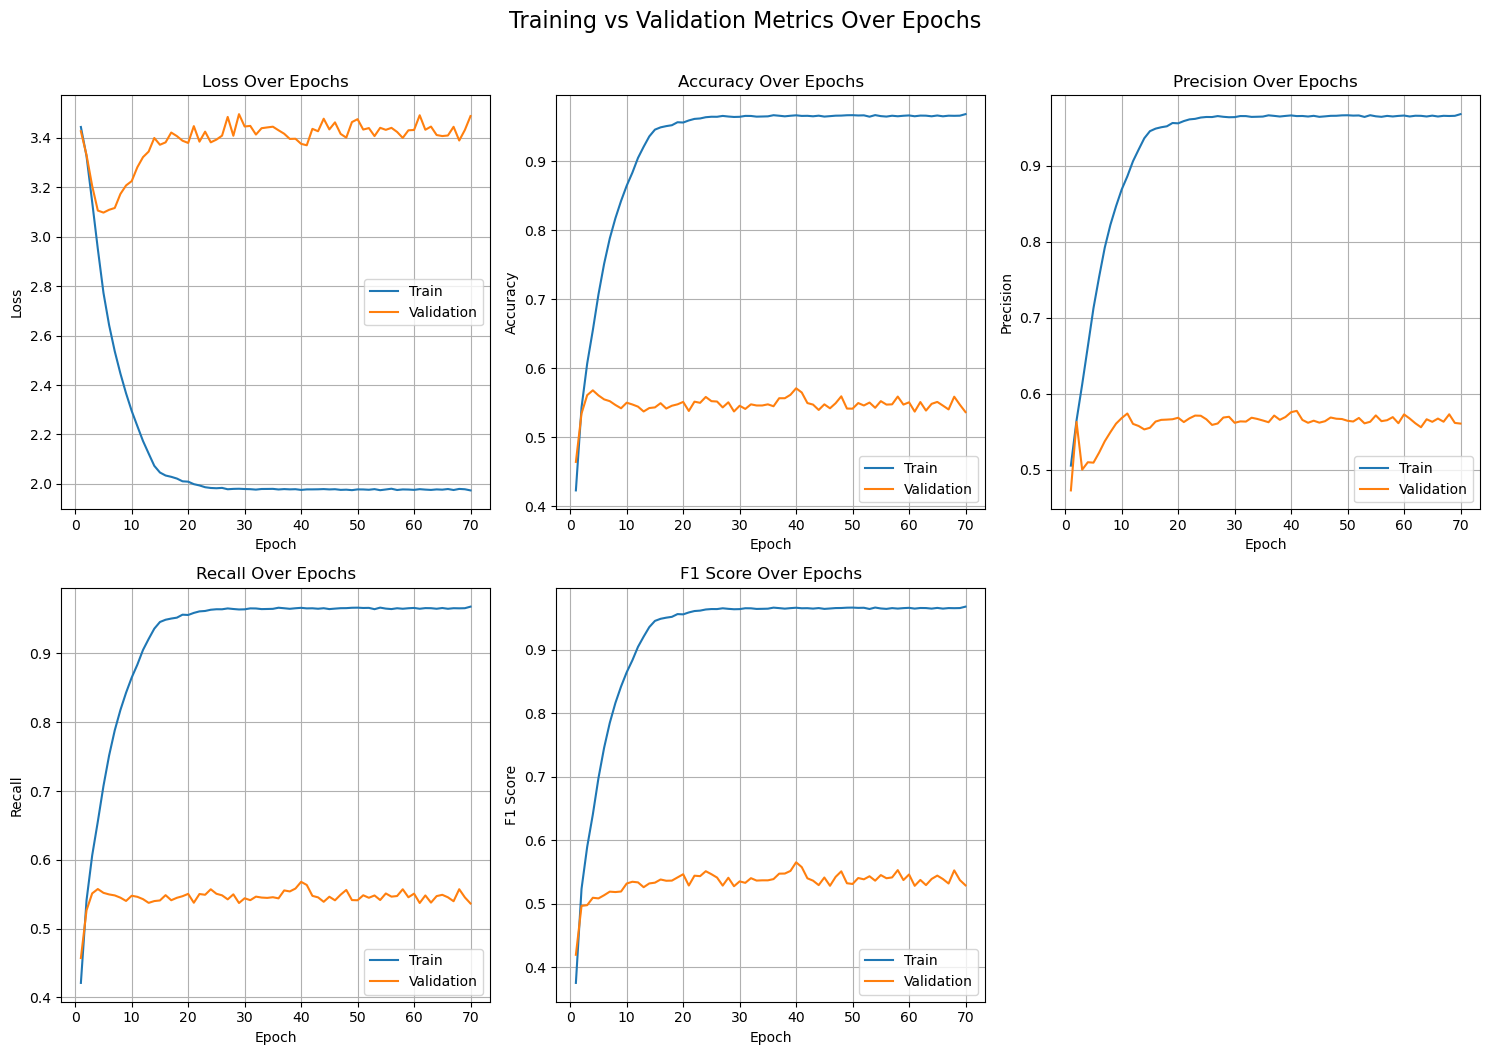

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
history = pd.read_csv("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training_TMN/ResNet50_history_TMN_dropout_15.csv")


# Define metric pairs (Train and Validation)
metric_groups = {
    'Loss': ('Train Loss', 'Val Loss'),
    'Accuracy': ('Train Acc', 'Val Acc'),
    'Precision': ('Train Precision', 'Val Precision'),
    'Recall': ('Train Recall', 'Val Recall'),
    'F1 Score': ('Train F1', 'Val F1')
}

# Plot
plt.figure(figsize=(15, 10))
for i, (title, (train_col, val_col)) in enumerate(metric_groups.items(), 1):
    plt.subplot(2, 3, i)
    plt.plot(history['Epoch'], history[train_col], label='Train')
    plt.plot(history['Epoch'], history[val_col], label='Validation')
    plt.title(f'{title} Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Training vs Validation Metrics Over Epochs', fontsize=16, y=1.05)
plt.show()
